In [1]:
%load_ext autoreload
%autoreload 2

# Always run

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import composite
%matplotlib inline
from numpy import trapz
import copy
import glob as glob
from numpy import trapz
from astropy.time import Time
from scipy import interpolate
import spectral_analysis as sa
import sqlite3 as sq3
import kaepora as kpora
import kaepora_plot as kplot
import add_new_columns as anc
c = 299792 #speed of light in km/s

In [3]:
def gsmooth(x_array, y_array, var_y, vexp = .001, nsig = 5.0):
    #returns smoothed flux array
    # if no variance array create a constant one
    if len(var_y) == 0:
        var_y = np.zeros(len(y_array))
        
    for i in range(len(var_y)):
        if var_y[i] == 0:
            var_y[i] = 1E-20
            # var_y[i] = 1E-31
    
    # Output y-array
    new_y = np.zeros(len(x_array), float)
    
    # Loop over y-array elements
    for i in range(len(x_array)):
        
        # Construct a Gaussian of sigma = vexp*x_array[i]
        gaussian = np.zeros(len(x_array), float)
        sigma = vexp*x_array[i]
        
        # Restrict range to +/- nsig sigma
        sigrange = np.nonzero(abs(x_array-x_array[i]) <= nsig*sigma)
        gaussian[sigrange] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x_array[sigrange]-x_array[i])/sigma)**2)
        
        # Multiply Gaussian by 1 / variance
        W_lambda = gaussian / var_y
        
        # Perform a weighted sum to give smoothed y value at x_array[i]
        W0 = np.sum(W_lambda)
        W1 = np.sum(W_lambda*y_array)
        new_y[i] = W1/W0

    # Return smoothed y-array
    return new_y

In [4]:
def autosmooth(x_array, y_array, var_y):
    new_y_init = gsmooth(x_array, y_array, var_y, .001)
    SNR = np.mean(new_y_init / var_y)
    
    if SNR < 5:
        vexp_auto = .0045#.0025 #temp value, need to fine tune using SNR in excel spreadsheet
    elif 5 <= SNR < 20:
        vexp_auto = .004#.002
    elif 20 <= SNR < 40:
        vexp_auto = .003#.0015
    elif 40 <= SNR < 60:
        vexp_auto = .002#.001
    elif 60 <= SNR < 100:
        vexp_auto = .0015#.00075
    else:
        vexp_auto = .001#.0005
    
    new_y = gsmooth(x_array, y_array, var_y, vexp_auto)
    return new_y

In [5]:
def autovexp(x_array, y_array, var_y):
    new_y_init = gsmooth(x_array, y_array, var_y, .001)
    SNR = np.mean(new_y_init / var_y)
        
    if SNR < 5:
        vexp_auto = .0045#.0025 #temp value, need to fine tune using SNR in excel spreadsheet
    elif 5 <= SNR < 20:
        vexp_auto = .004#.002
    elif 20 <= SNR < 40:
        vexp_auto = .003#.0015
    elif 40 <= SNR < 60:
        vexp_auto = .002#.001
    elif 60 <= SNR < 100:
        vexp_auto = .0015#.00075
    else:
        vexp_auto = .001#.0005
            
    return vexp_auto

In [6]:
sn_query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -.5 and phase <= .5"

In [7]:
SN_Array = composite.grab(sn_query, multi_epoch = False, make_corr = True, selection = "max_coverage")

109 Total Spectra found
2 flagged spectra removed 107 spectra left
3 spectra of peculiar Ias removed 104 spectra left
69 spectra of SNe that have host reddening corrections
Arrays cleaned


In [8]:
SN_Array[0].other_meta_data

{u'HOST_LOGMASS': None,
 u'HOST_LOGMASS_ERR': None,
 u'MU': None,
 u'MUERR': None,
 u'MUMODEL': None,
 u'MURES': None,
 u'MURES_NO_MSTEP': None,
 u'MURES_NO_MSTEP_C': None,
 u'MURES_NO_MSTEP_C_X1': None,
 u'c': None,
 u'cERR': None,
 u'salt2_phot_source': None,
 u'si_v0': -10296.517142888732,
 u'x1': None,
 u'x1ERR': None}

In [9]:
SN_attributes = dir(SN_Array[0])
print(SN_attributes)

['Bmag_salt', 'Bmag_salt2', 'Ebv_host', 'SNR', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'av_25', 'av_mlcs17', 'av_mlcs31', 'av_mw', 'b_minus_v_cfa', 'b_minus_v_cfa_err', 'bias_lc', 'c_array', 'c_lc', 'c_salt', 'c_salt2', 'carbon', 'cov_mb_c_lc', 'cov_mb_s_lc', 'cov_s_c_lc', 'csp_light_curves', 'czCMB_host', 'czLG_host', 'cz_host', 'dec', 'delta_mlcs17', 'delta_mlcs31', 'dm15', 'dm15_array', 'dm15_from_fits', 'dm15_source', 'e_Bmag_salt', 'e_Bmag_salt2', 'e_av_mlcs17', 'e_av_mlcs31', 'e_c_lc', 'e_c_salt', 'e_c_salt2', 'e_delta_mlcs17', 'e_delta_mlcs31', 'e_dm15', 'e_logMst_lc', 'e_mb_lc', 'e_mu_mlcs17', 'e_mu_mlcs31', 'e_mu_salt', 'e_mu_salt2', 'e_s_salt', 'e_tmax_lc', 'e_v', 'e_x1_lc', 'e_x1_salt2', 'e_zCMB_mlcs17', 'e_zCMB_mlcs31', 'e_zCMB_salt', 'e_zCMB_salt2'

In [10]:
for i, sn in enumerate(SN_Array):
    print(i, sn.name, sn.filename, sn.phase, sn.source)

(0, u'1998es', u'sn1998es-19981125-ui-corrected.flm', 0.4967508339381827, u'bsnip')
(1, u'1999aa', u'sn1999aa-19990223-ui.flm', 0.4603511483683075, u'bsnip')
(2, u'1999ac', u'sn1999ac-19990312-ui-corrected.flm', -0.3853392768725628, u'bsnip')
(3, u'2002de', u'sn2002de-20020608.374-ui-corrected.flm', -0.16048772705958972, u'bsnip')
(4, u'2002ha', u'sn2002ha-20021102-ui-corrected.flm', -0.04337539432343062, u'bsnip')
(5, u'2002he', u'sn2002he-20021108-br.flm', 0.05758547050365418, u'bsnip')
(6, u'2005eq', u'sn2005eq-20051011.376-ui-corrected.flm', 0.20214251630378466, u'bsnip')
(7, u'2005lz', u'sn2005lz-20060101.381-deimos.flm', 0.45100211520732203, u'bsnip')
(8, u'2005na', u'sn2005na-20060105.335-ui.flm', 0.4326127667494873, u'bsnip')
(9, u'2006ej', u'sn2006ej-20060824.430-ui.flm', -0.3861034129976058, u'bsnip')
(10, u'2006n', u'sn2006n-20060124.285-ui.flm', -0.4584546430575745, u'bsnip')
(11, u'2007a', u'SN07A_070113_b01_DUP_BC.dat', 0.3116704355905177, u'csp')
(12, u'2007o', u'sn2007o

# Measurement Code

In [11]:
def find_min_wave(wavelength, flux, w1 = 5900, w2 = 6300):#, error = False, n = 1000):
    wave_domain = np.where((wavelength > w1) & (wavelength < w2))
    #print wavelength
    flux_range = []
    for position in wave_domain[0]:
        #print position
        fluxelem = flux[position]
        flux_range.append(fluxelem)
    
    #print flux_range
    elem_flux = np.amin(flux_range)
    min_index = np.where((flux == elem_flux))
    min_wave = wavelength[min_index][0]
    
    return min_wave

In [12]:
def find_max_wave(wavelength, flux, w1 = 5900, w2 = 6500):#, error = False, n = 1000):
    wave_domain = np.where((wavelength > w1) & (wavelength < w2))
    #print wavelength
    flux_range = []
    for position in wave_domain[0]:
        #print position
        fluxelem = flux[position]
        flux_range.append(fluxelem)
    
    elem_flux = np.amax(flux_range)
    max_index = np.where((flux == elem_flux))
    max_wave = wavelength[max_index][0]
    
    return max_wave

In [13]:
def find_velocity(wavelength_obs, wavelength_rest):
    ejecta_velocity = c * (wavelength_obs - wavelength_rest) / wavelength_rest
    return ejecta_velocity

In [14]:
def si_velocity(min_wave):
    si_velocity = find_velocity(min_wave, 6355.)
    
    return si_velocity

In [15]:
def si_velocity_error(wavelength, flux, flux_error, n=100):
    
    v_dist = []
    
    flux = gsmooth(wavelength, flux, flux_error, .001)
    
    SNR = np.mean(flux / flux_error)
    #print SNR
    
    if SNR < 5:
        vexp_auto = .0045#.0025 #temp value, need to fine tune using SNR in excel spreadsheet
    elif 5 <= SNR < 20:
        vexp_auto = .004#.002
    elif 20 <= SNR < 40:
        vexp_auto = .003#.0015
    elif 40 <= SNR < 60:
        vexp_auto = .002#.001
    elif 60 <= SNR < 100:
        vexp_auto = .0015#.00075
    else:
        vexp_auto = .001#.0005
        
    #print vexp_auto
    for i in range(n):
        #sample_vexp = np.random.normal(vexp_auto, vexp_auto / 4)
        sample_vexp = np.random.uniform(.001, .0045)
        #print sample_vexp
        sample_flux = gsmooth(wavelength, flux, flux_error, sample_vexp)
        min_wave = find_min_wave(wavelength, sample_flux)
        
        sample_v = si_velocity(min_wave)
        v_dist.append(sample_v)
        
    sigma = np.std(v_dist)
    
    #print v_dist
    return sigma
        

In [16]:
def ca_velocity(min_wave):
    ca_velocity = find_velocity(min_wave, 3950)
    
    return ca_velocity

In [17]:
def ca_velocity_error(wavelength, flux, flux_error, n=100):
    
    v_dist = []
    
    flux = gsmooth(wavelength, flux, flux_error, .001)
    
    SNR = np.mean(flux / flux_error)
    print SNR
    
    if SNR < 5:
        vexp_auto = .0045#.0025 #temp value, need to fine tune using SNR in excel spreadsheet
    elif 5 <= SNR < 20:
        vexp_auto = .004#.002
    elif 20 <= SNR < 40:
        vexp_auto = .003#.0015
    elif 40 <= SNR < 60:
        vexp_auto = .002#.001
    elif 60 <= SNR < 100:
        vexp_auto = .0015#.00075
    else:
        vexp_auto = .001#.0005
        
    print vexp_auto
    for i in range(n):
        #sample_vexp = np.random.normal(vexp_auto, vexp_auto / 4)
        sample_vexp = np.random.uniform(.001, .0045)
        print sample_vexp
        sample_flux = gsmooth(wavelength, flux, flux_error, sample_vexp)
        min_wave = find_min_wave(wavelength, sample_flux, 3650, 4100)
        
        sample_v = ca_velocity(min_wave)
        v_dist.append(sample_v)
        
    sigma = np.std(v_dist)
    
    print v_dist
    return sigma

In [18]:
def v_0(v_obs, phase):
    v_0 = (v_obs + .285*phase) / (1 - .0322*phase)
    
    return v_0

In [19]:
def intrinsic_color(v_0):
    B0V0 = -0.39 - (0.033 * v_0 / 1000)
    return B0V0

In [20]:
# wavelength, flux, left boundary domain 1, right boundary domain 1, left boundary domain 2, right boundary domain 2
def eq_width(wavelength, flux, b1w1=5900, b1w2=6100, b2w1=6250, b2w2=6450):
    
    
    max1 = find_max_wave(wavelength, flux, b1w1, b1w2)
    max2 = find_max_wave(wavelength, flux, b2w1, b2w2)
    #print max1, max2
    flux1 = flux[np.where(wavelength == max1)][0]
    flux2 = flux[np.where(wavelength == max2)][0]
    #print(flux1, flux2)
    domain = np.where((wavelength > max1) & (wavelength < max2))
    
    wave_range = []
    flux_range = []
   
    for index in domain:
        wave_range.append(wavelength[index])
        flux_range.append(flux[index])
        
    #fit normal line over dip
    line_elem = np.polyfit([max1, max2], [flux1, flux2], 1) 
    line = line_elem[1] + line_elem[0] * wave_range[0]
    
    #normalize spectrum
    norm = flux_range[0] / line
    
    a_curve = trapz((norm), x = wave_range)
    a_line = wave_range[0][-1] - wave_range[0][0]
    eq_width = a_line - a_curve
    
   # plt.figure(figsize=(10,4))
    #plt.plot(wave_range[0], line)#flux_range[0])
    #plt.plot(wave_range[0], flux_range[0])
    #plt.show()
    
    #print eq_width
    
    return eq_width[0]

In [21]:
def si_eq_width_error(wavelength, flux, var_flux, n = 100):
    
    si_eq_width_dist = []
    ideal_vexp = autovexp(wavelength, flux, var_flux)
    
    for i in range(n):
        sample_vexp = np.random.normal(ideal_vexp, ideal_vexp / 4) #temporary variable of randomness
        sample_flux = gsmooth(wavelength, flux, var_flux, sample_vexp)
        
        sample_eq_width = eq_width(wavelength, sample_flux)
        si_eq_width_dist.append(sample_eq_width)
        
    sigma = np.std(si_eq_width_dist)
    
    return sigma

In [22]:
def si_ratio(wavelength, flux):
    max1 = find_max_wave(wavelength, flux, 5500, 5700)
    max2 = find_max_wave(wavelength, flux, 5700, 6000)
    max3 = find_max_wave(wavelength, flux, 6000, 6500)
    
    maxindex1 = np.where(wavelength == max1)
    maxindex2 = np.where(wavelength == max2)
    maxindex3 = np.where(wavelength == max3)
    
    domain1 = np.where((wavelength >= max1) & (wavelength <= max2))
    line_elem1 = np.polyfit([max1, max2], [flux[maxindex1], flux[maxindex2]], 1)
    
    domain1 = np.ndarray.tolist(domain1[0])
    
    differences1 = []
    for index in domain1:
        line_flux = line_elem1[0]*wavelength[index] + line_elem1
        dip_flux = flux[index]
        differences1.append(line_flux - dip_flux)
        small_silc = np.amax(differences1)
        #print(small_silc)
        
        
    domain2 = np.where((wavelength >= max2) & (wavelength <= max3))
    line_elem2 = np.polyfit([max2, max3], [flux[maxindex2], flux[maxindex3]], 1)
    
    domain1 = np.ndarray.tolist(domain2[0])
    
    differences2 = []
    for index in domain2:
        line_flux = line_elem2[0]*wavelength[index] + line_elem2
        dip_flux = flux[index]
        differences2.append(line_flux - dip_flux)
        big_silc = np.amax(differences2)
        #print(big_silc)
        
    si_ratio = small_silc / big_silc
    
    
    return si_ratio

In [23]:
def si_ratio_error(wavelength, flux, flux_error, n = 100):
    
    si_ratio_dist = []
    ideal_vexp = autovexp(wavelength, flux, flux_error)
    
    for i in range(n):
        sample_vexp = np.random.normal(ideal_vexp, ideal_vexp / 4) #temporary variable of randomness
        #sample_vexp = np.random.uniform(.001, .0045)
        sample_flux = gsmooth(wavelength, flux, flux_error, sample_vexp)
        
        sample_si_ratio = si_ratio(wavelength, sample_flux)
        si_ratio_dist.append(sample_si_ratio)
        
    sigma = np.std(si_ratio_dist)
    
    return sigma

In [24]:
def eq_width_0(eq_width, phase):
    ew_0 = (eq_width + 4.48*phase) / (1 - 0.0339*phase)
    return ew_0

# Spectrum Eventsorting

In [25]:
# outputs two tables: one table of supernovae and one table of every corresponding spectrum object
def eventsort(spectrum_list):
    name_table = []
    object_table = []
    
    subset = []
    for n in range(0, len(spectrum_list)):
        if n == 0:
            subset.append(spectrum_list[n])

        elif spectrum_list[n].name == spectrum_list[n-1].name:
            subset.append(spectrum_list[n])
            
        elif spectrum_list[n].name != spectrum_list[n-1].name:
            object_table.append(subset)
            name_table.append(subset[0].name)
            subset = []
            subset.append(spectrum_list[n])
            
    #print len(object_table), len(name_table)
    
    return name_table, object_table

# Spectral Analysis

# Silicon Velocity Evolution

In [25]:
v_evo_query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase <= 30 and minwave <= 5500 and maxwave >= 6500 and source != 'swift_uv'"
v_evo_spectra = composite.grab(v_evo_query, multi_epoch = True, make_corr = True)

2861 Total Spectra found
96 flagged spectra removed 2765 spectra left
59 spectra of peculiar Ias removed 2706 spectra left
2288 spectra of SNe that have host reddening corrections
Arrays cleaned


In [26]:
v_evo_names, v_evo_objects = eventsort(v_evo_spectra)

In [27]:
class v_evo_species:
    def __init__(self, name, objects):
        self.name = name
        self.objects = objects

v_evo_data = []
for n in range(0, len(v_evo_names)):
    v_evo_specimen = v_evo_species(v_evo_names[n], v_evo_objects[n])
    v_evo_data.append(v_evo_specimen)

1989b


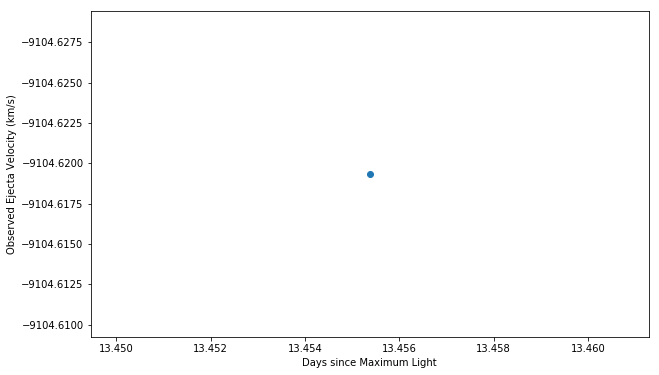

1990n


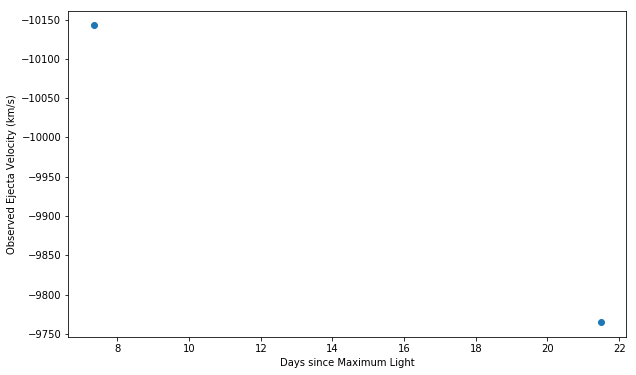

1990o


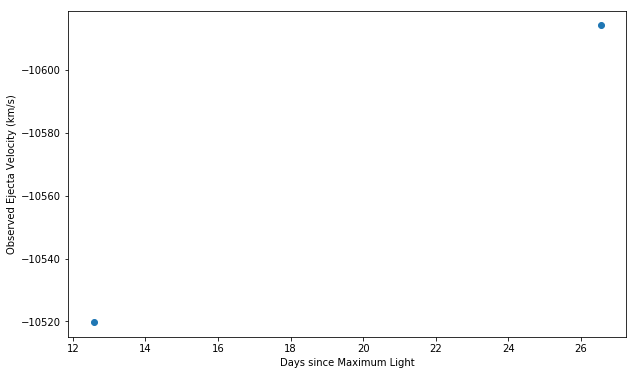

1990y


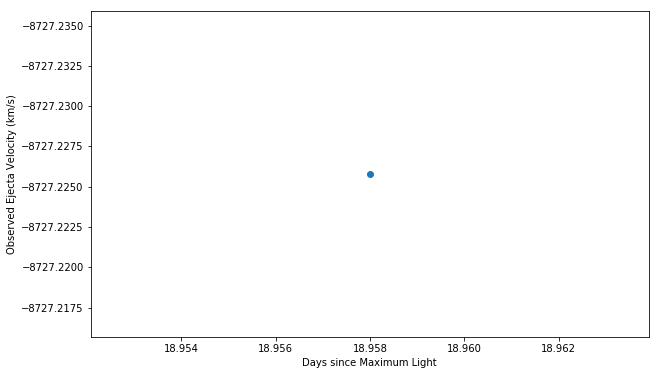

1991bg


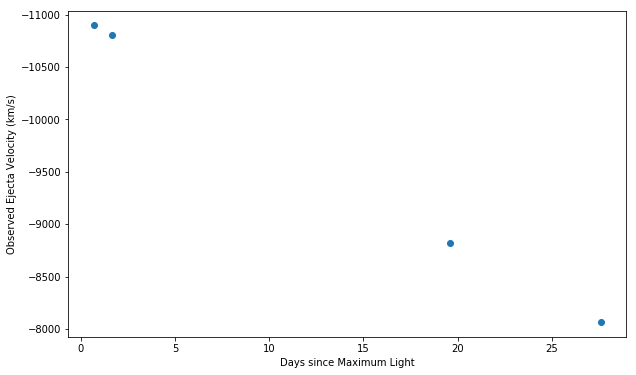

1991m


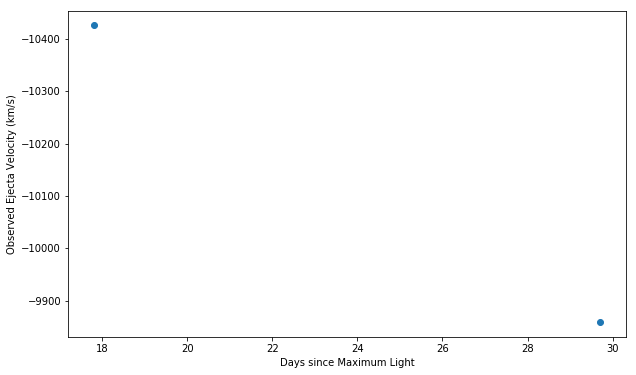

1991t


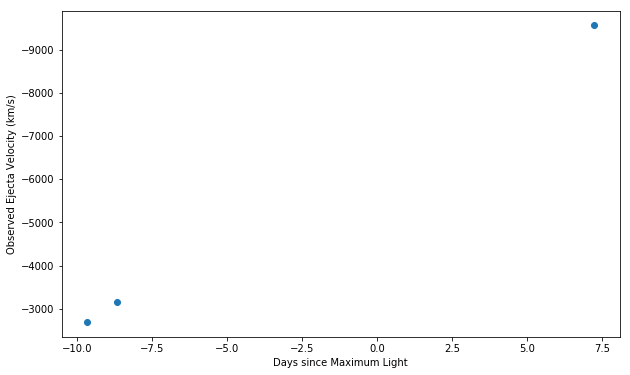

1992g


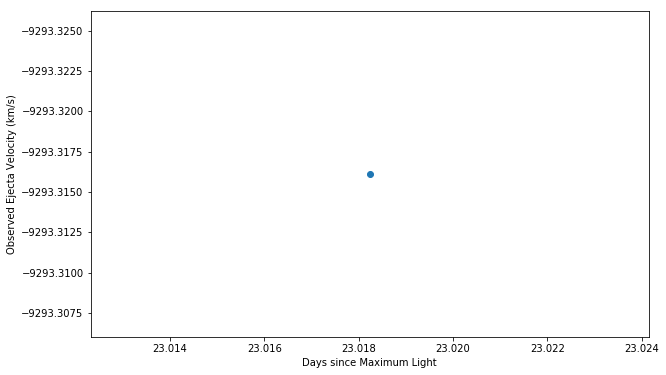

1993ac


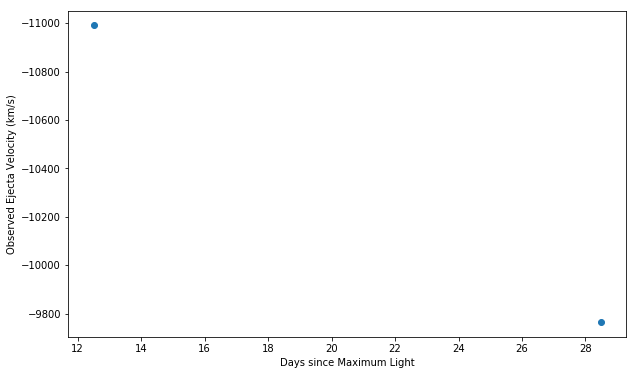

1993ae


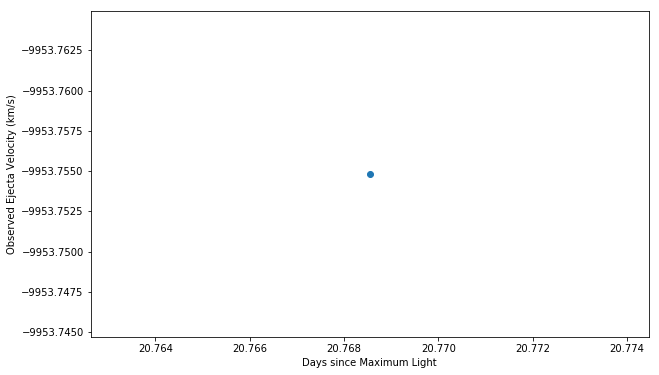

1994d


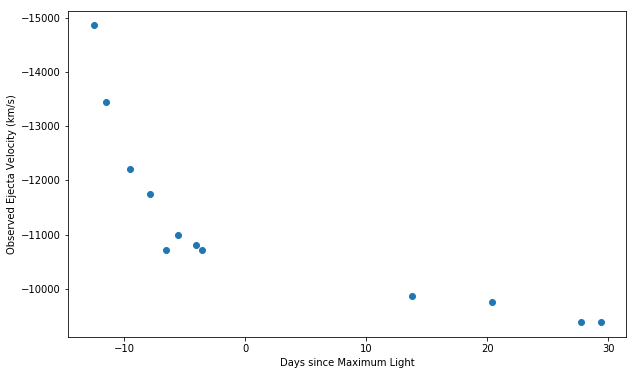

1994q


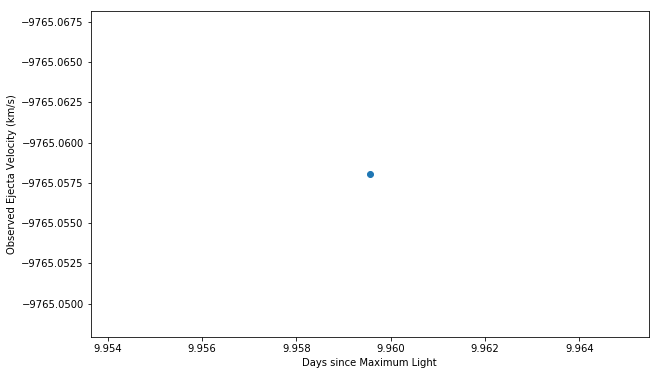

1994s


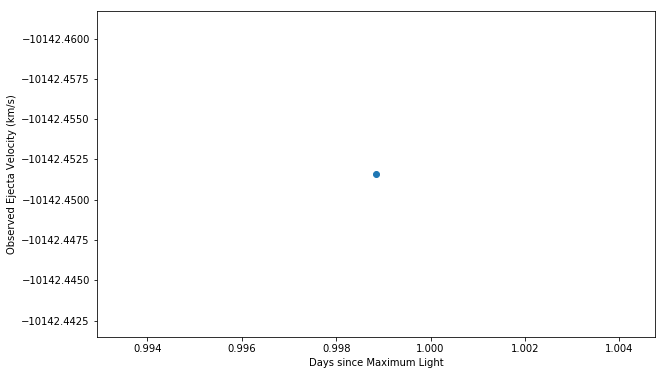

1995ac


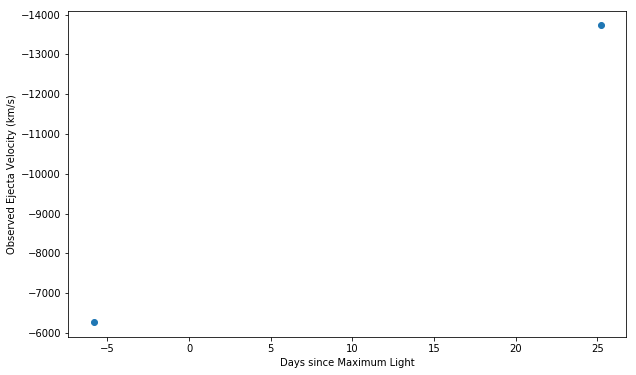

1995ak


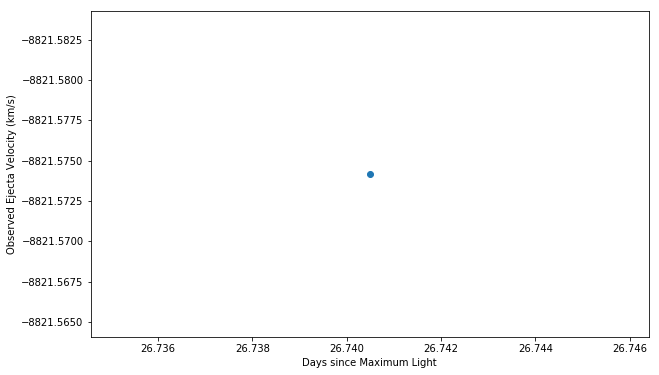

1995al


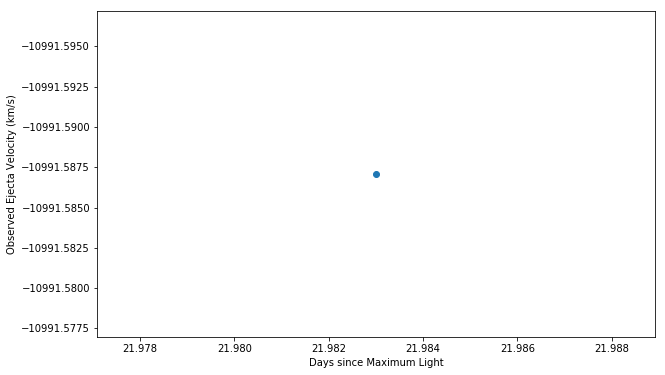

1995d


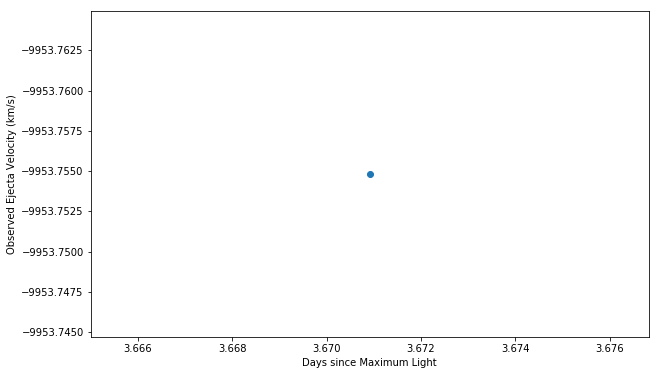

1995e


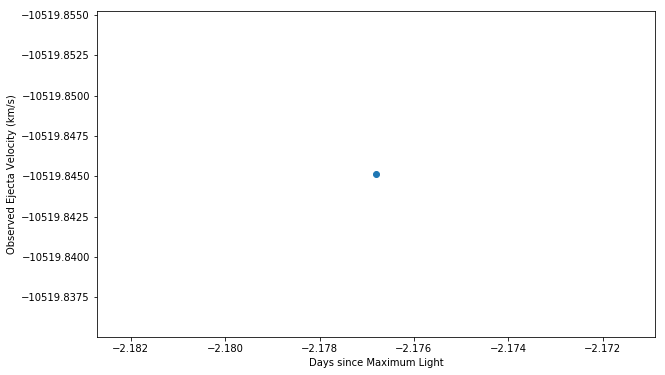

1996ai


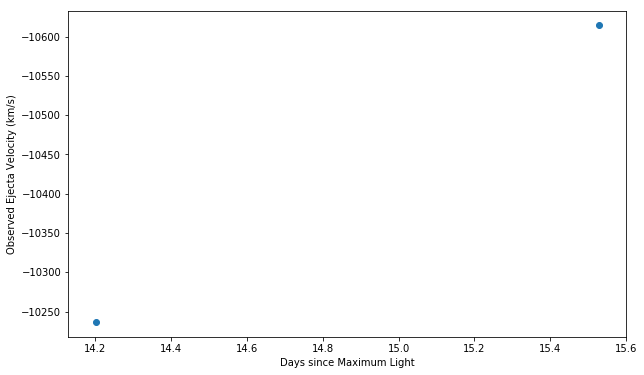

1996bv


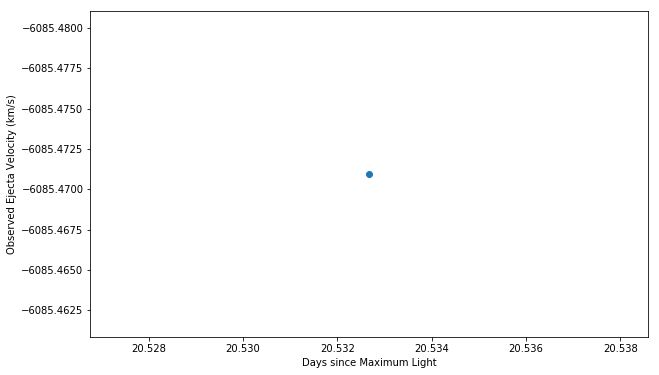

1997bp


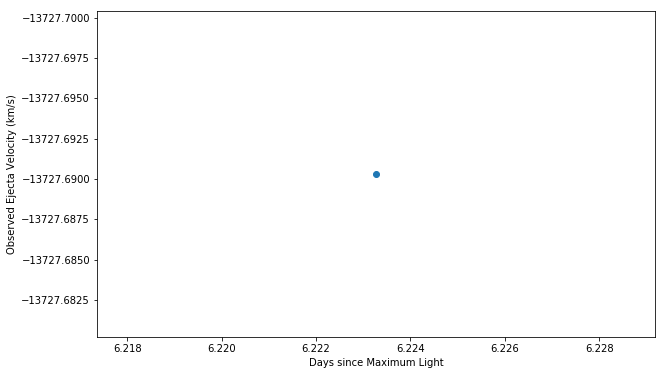

1997br


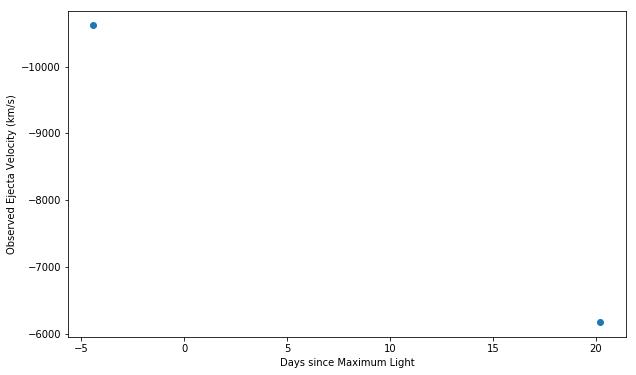

1997cn


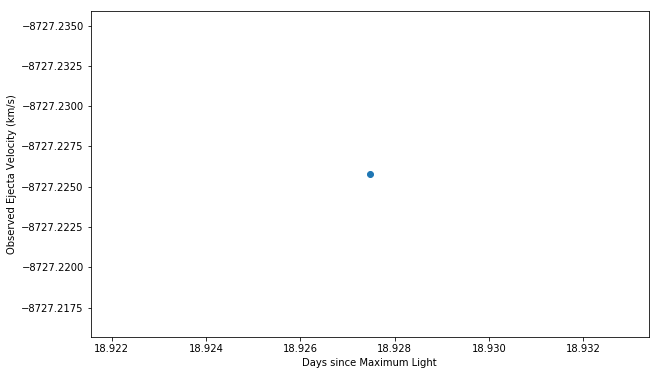

1997do


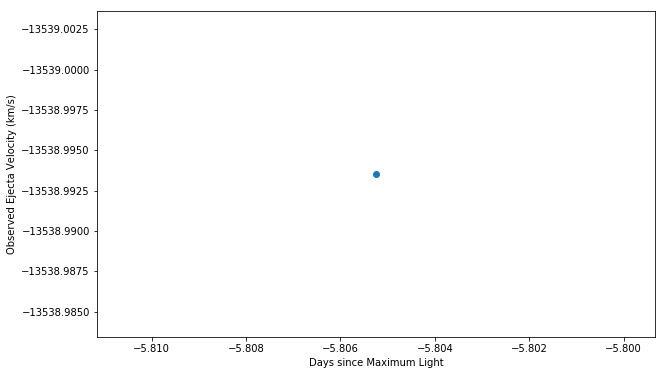

1997e


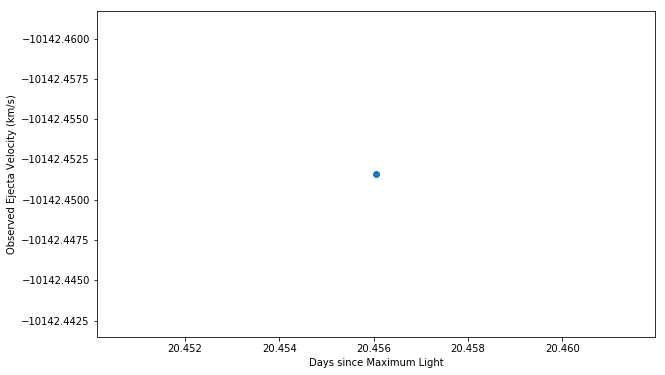

1997y


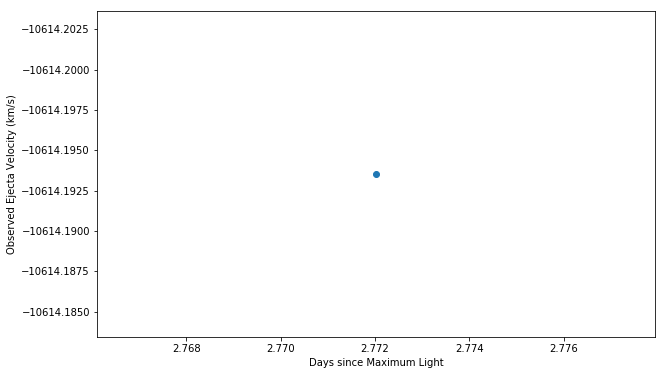

1998bu


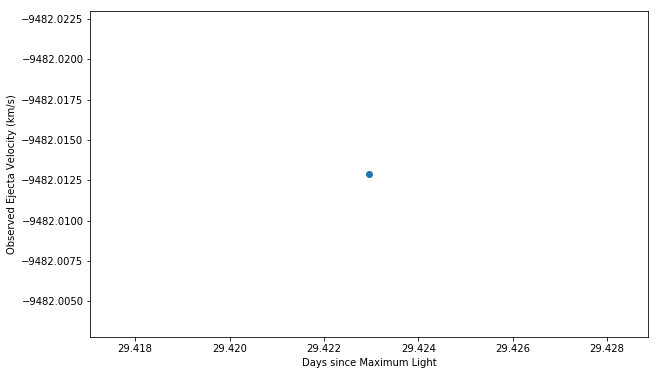

1998de


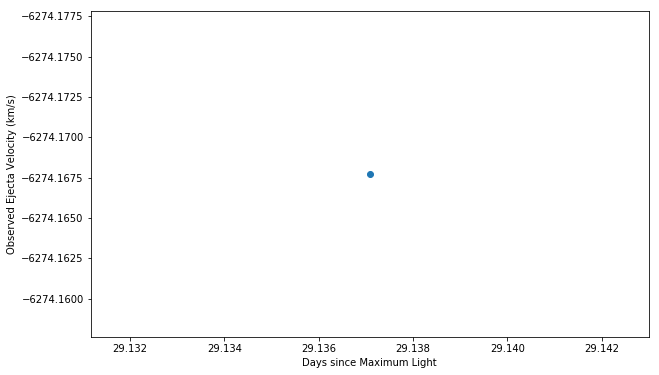

1998dh


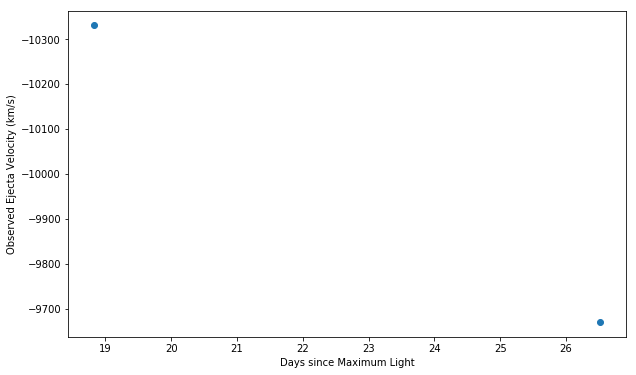

1998dk


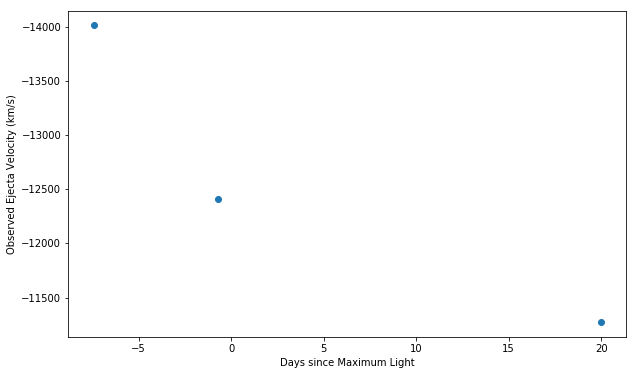

1998dm


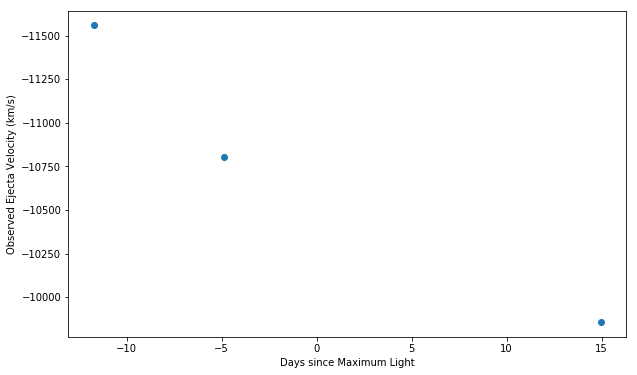

1998dx


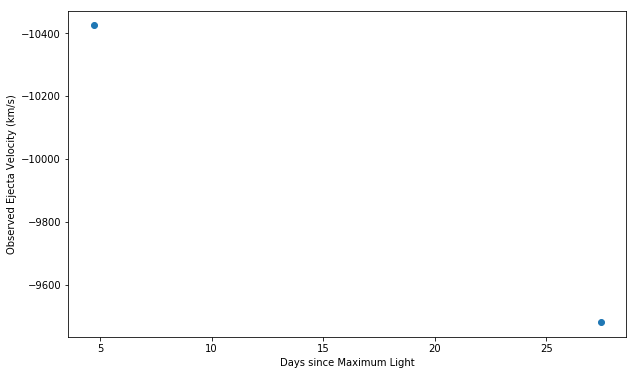

1998ec


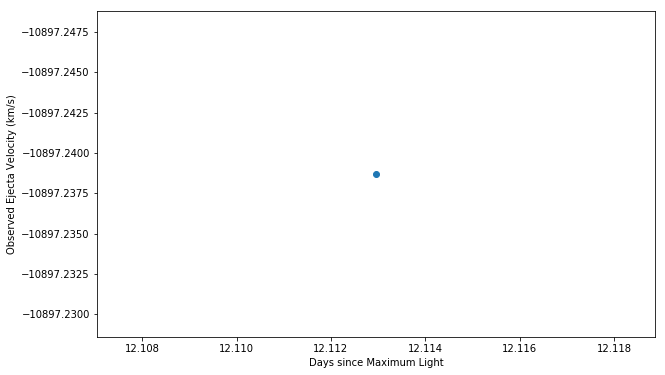

1998ef


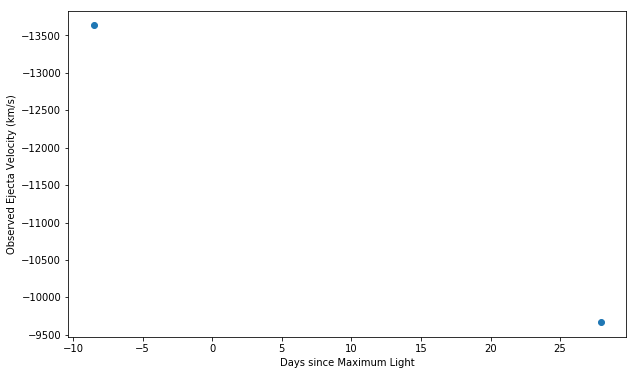

1998es


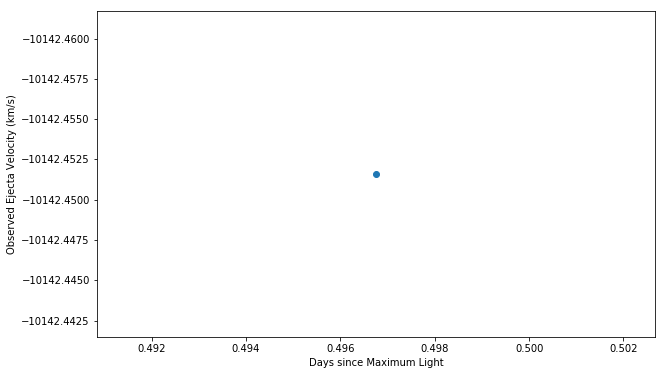

1998v


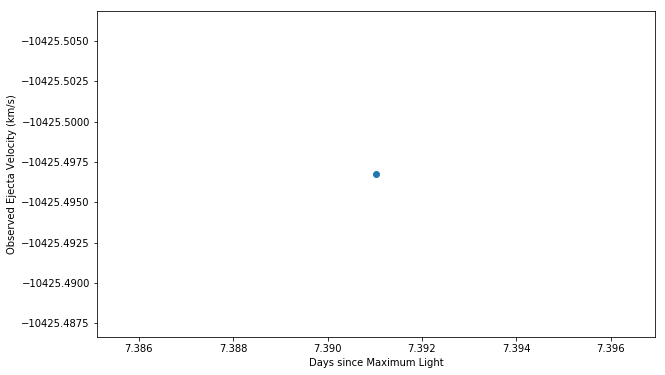

1999aa


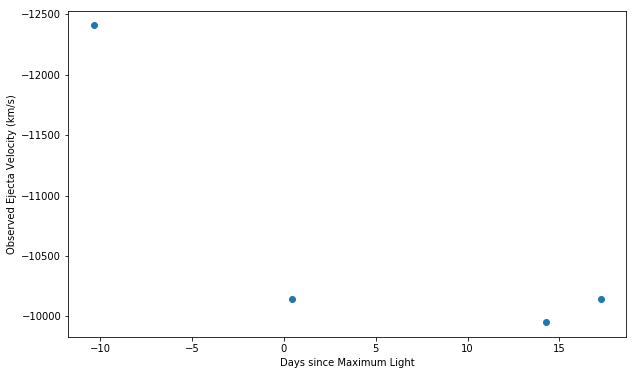

1999ac


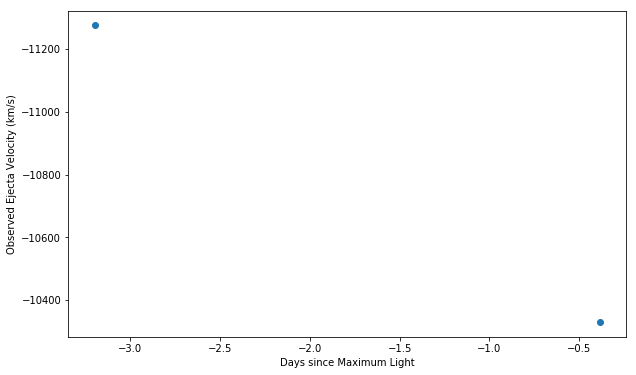

1999cl


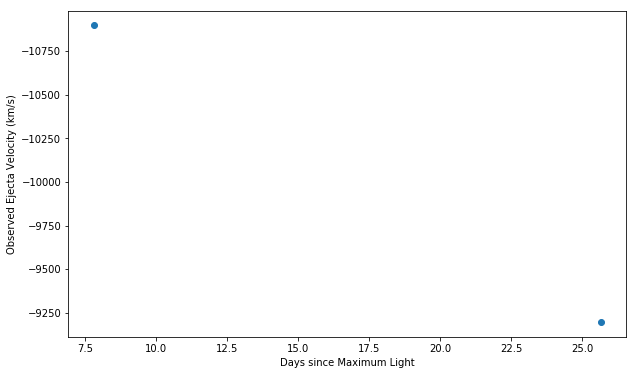

1999cp


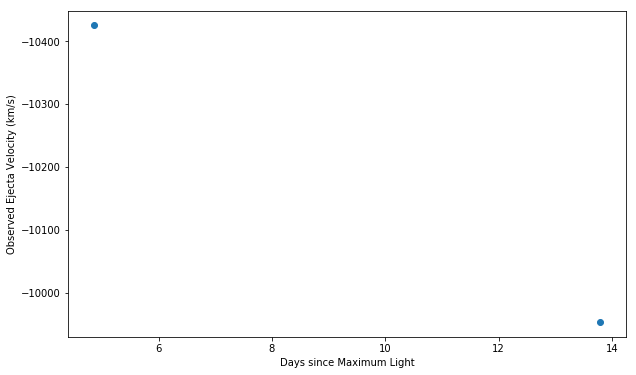

1999cw


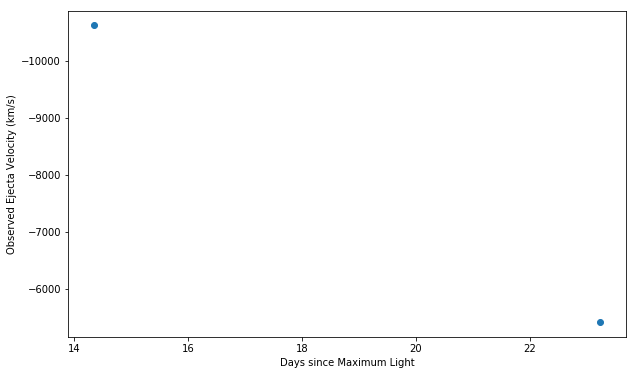

1999da


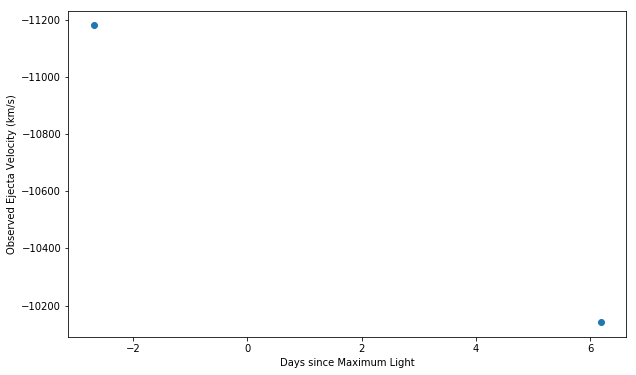

1999dk


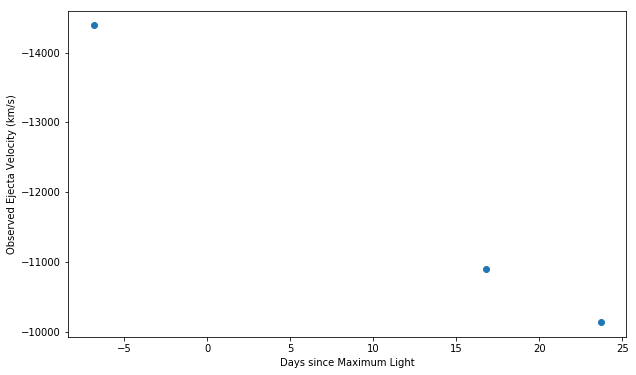

1999dq


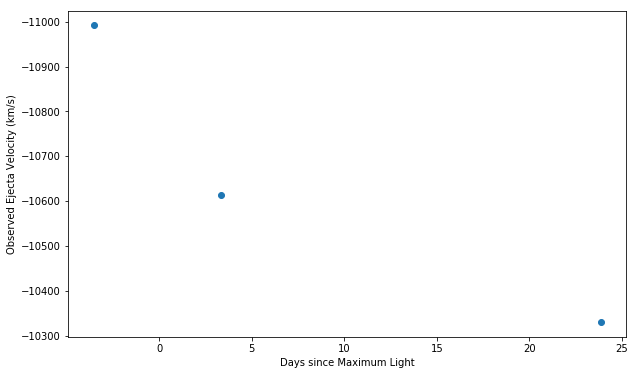

1999ee


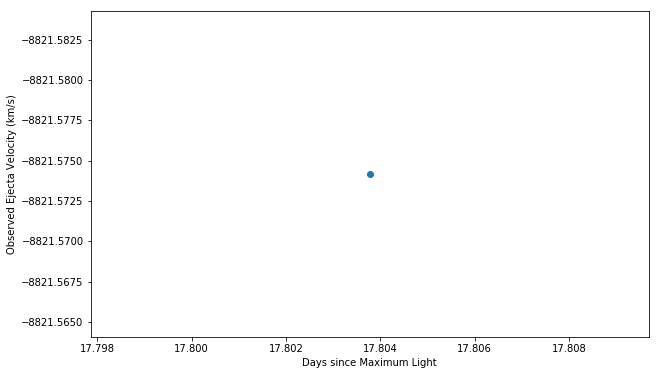

1999ek


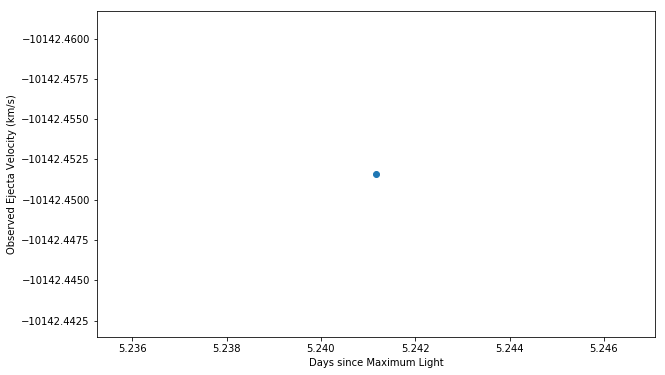

1999gd


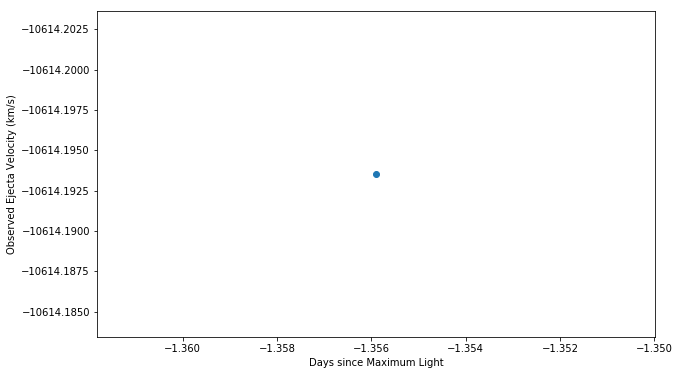

1999gh


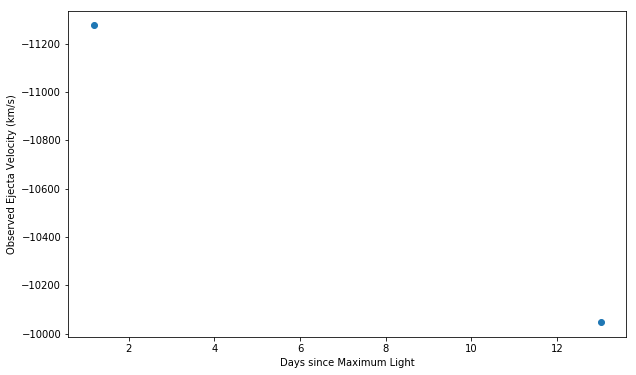

1999x


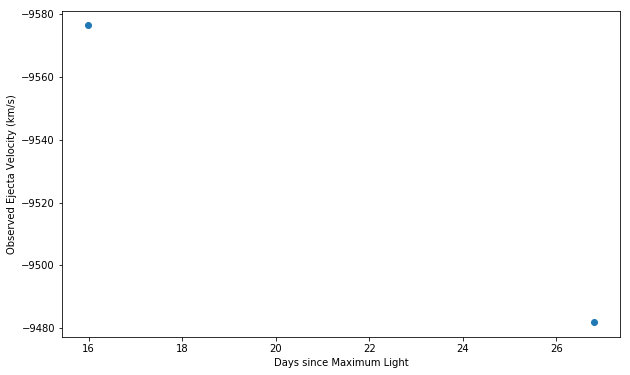

2000bk


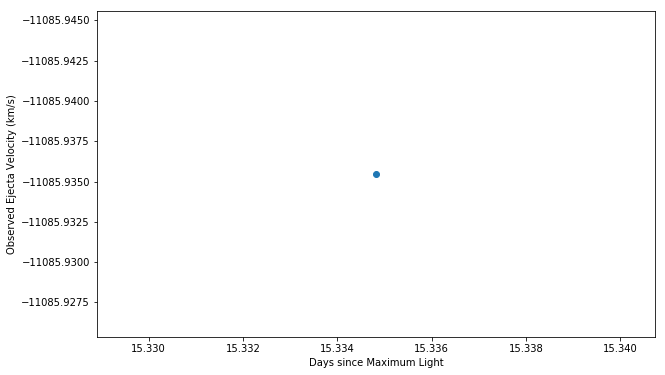

2000ce


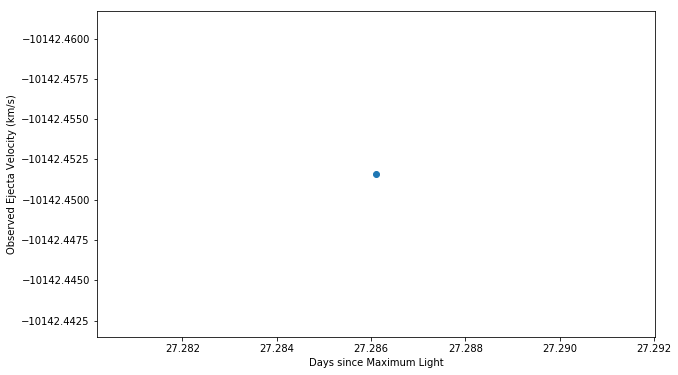

2000cn


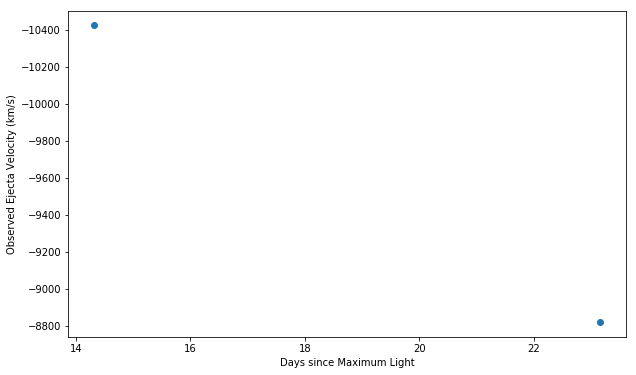

2000dk


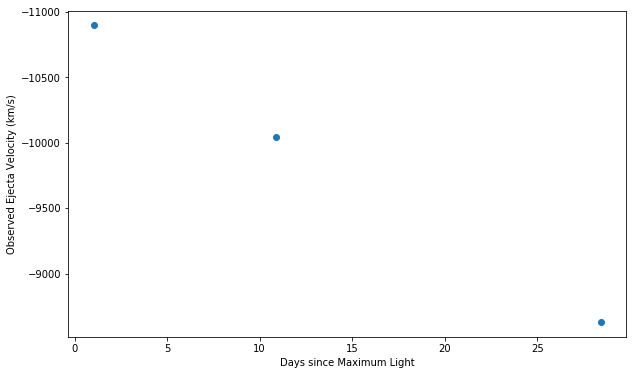

2000fa


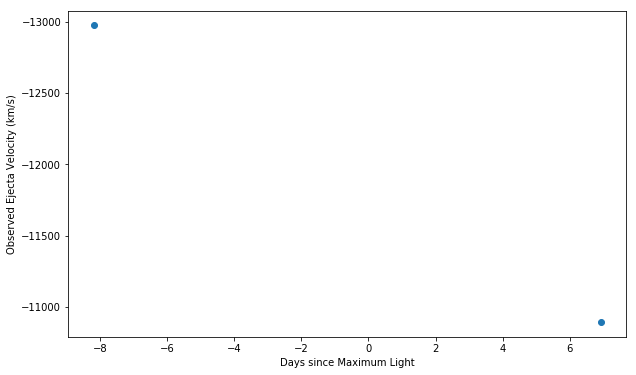

2001ay


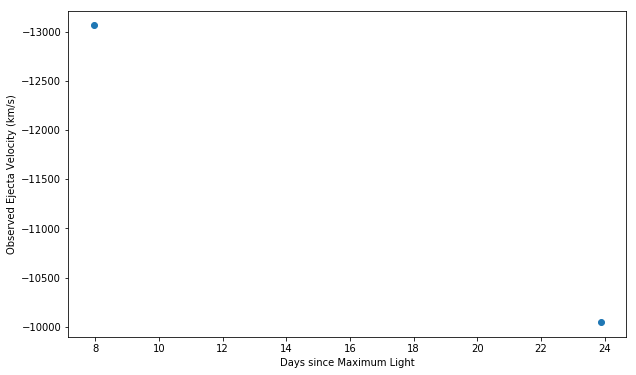

2001az


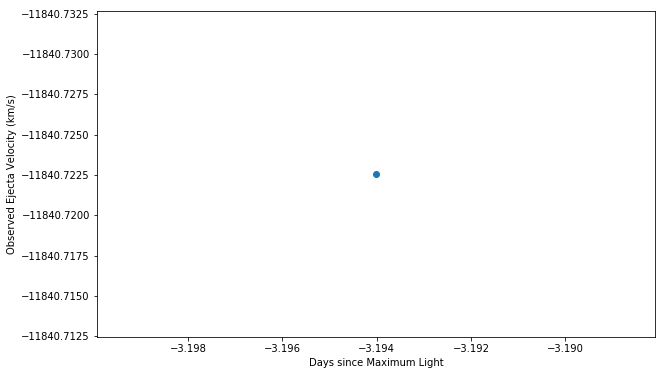

2001ba


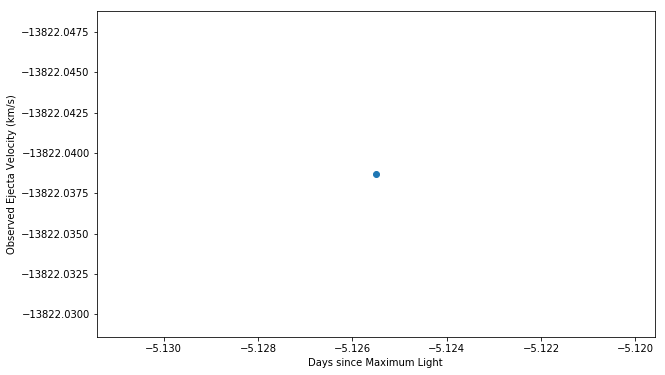

2001bf


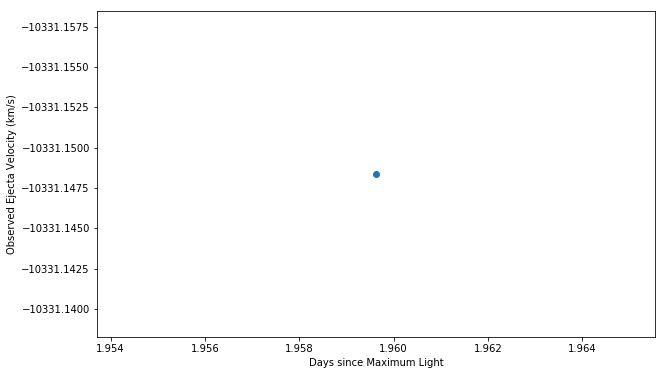

2001c


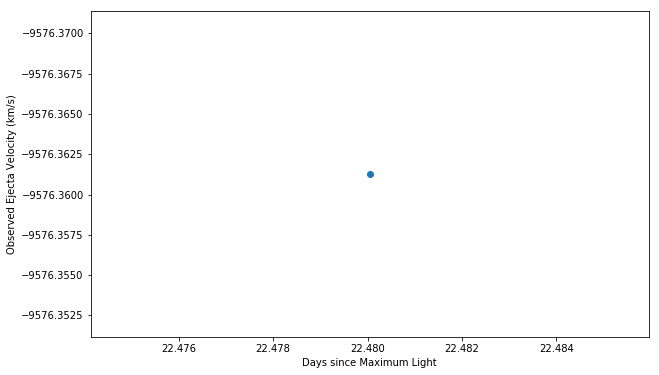

2001cp


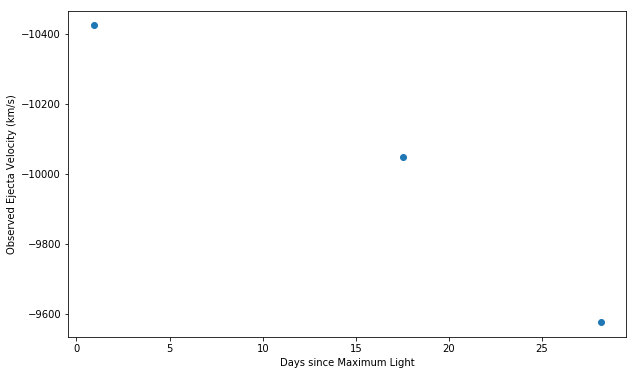

2001da


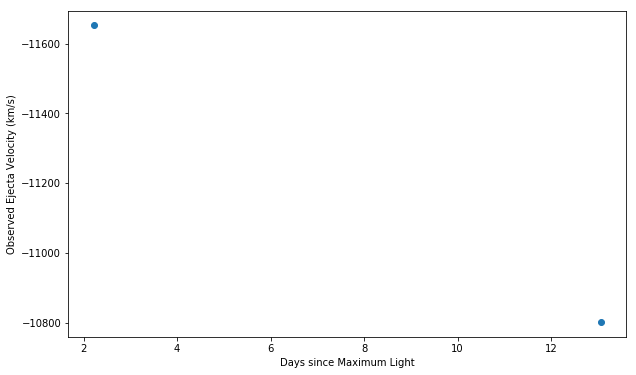

2001eh


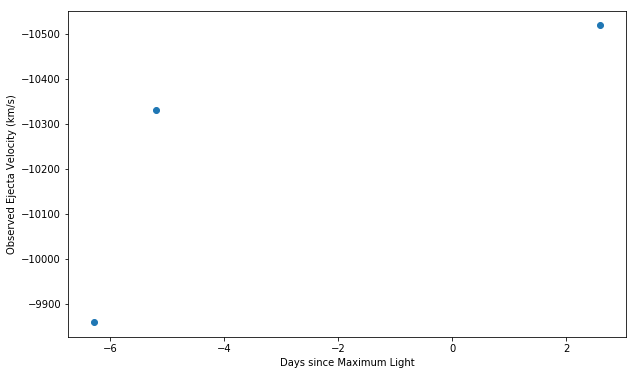

2001en


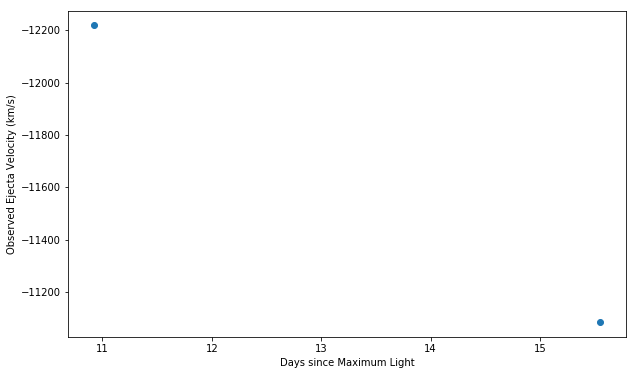

2001ep


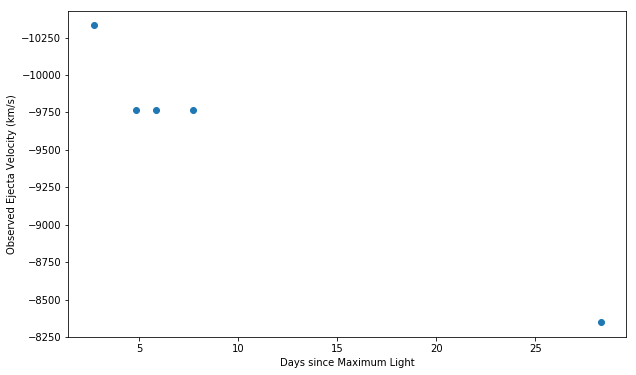

2001fe


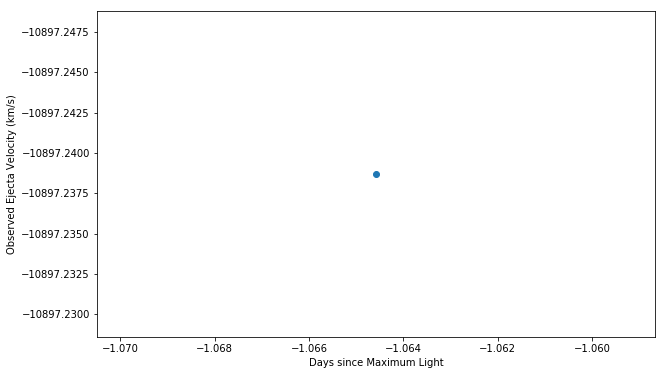

2001fh


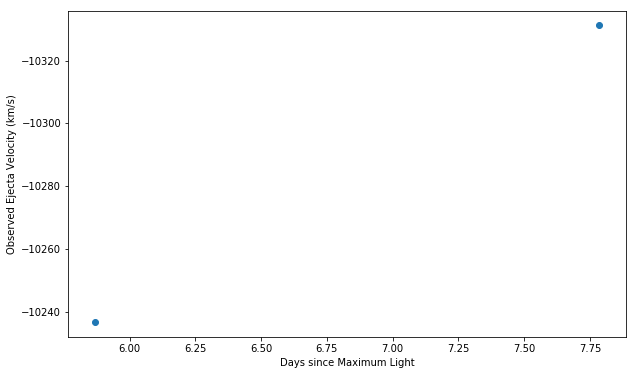

2001g


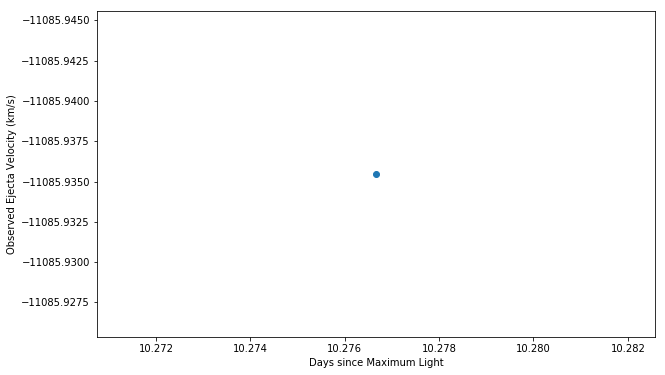

2001ic


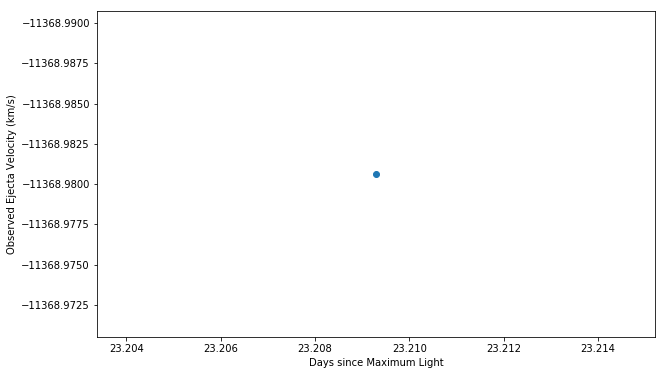

2001n


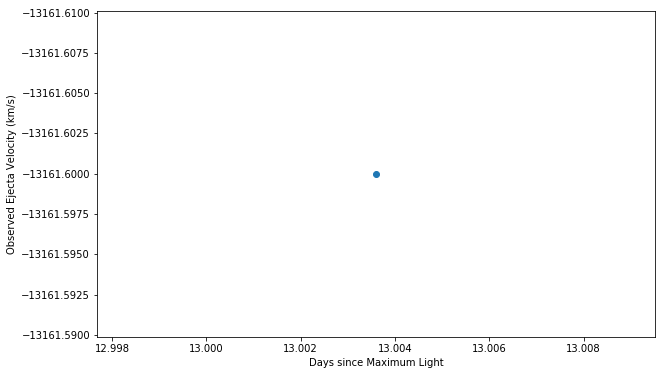

2001v


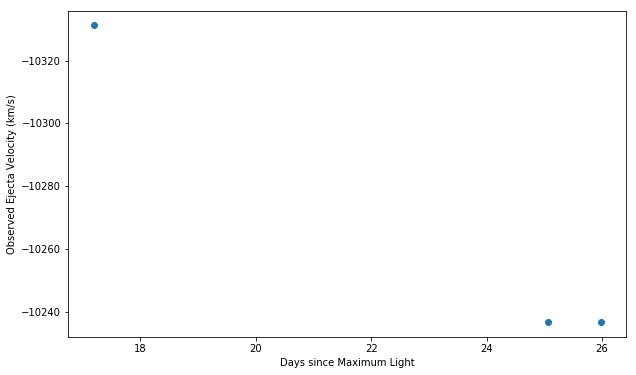

2002ar


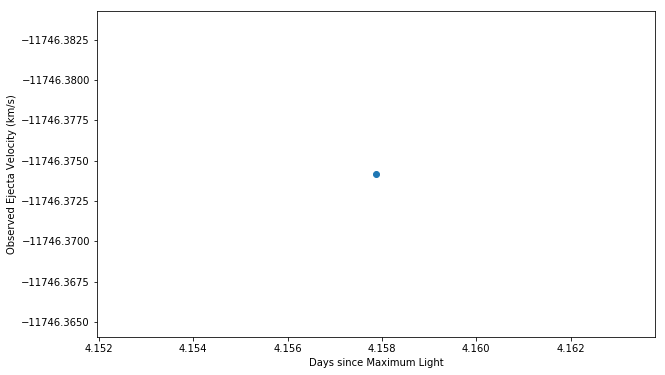

2002bf


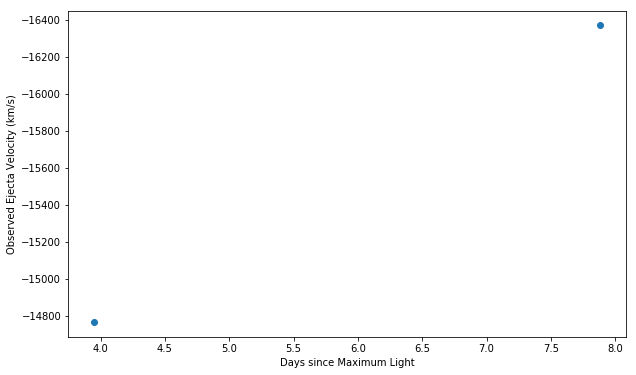

2002bo


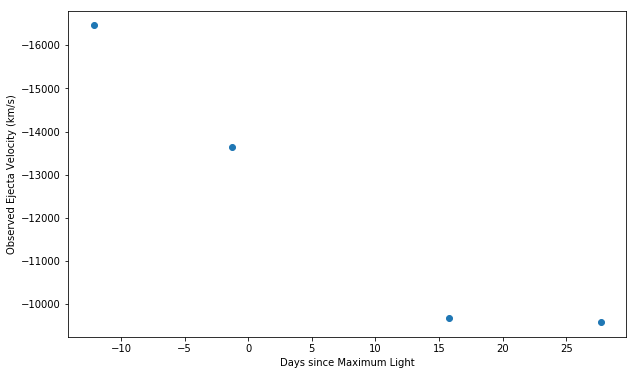

2002bz


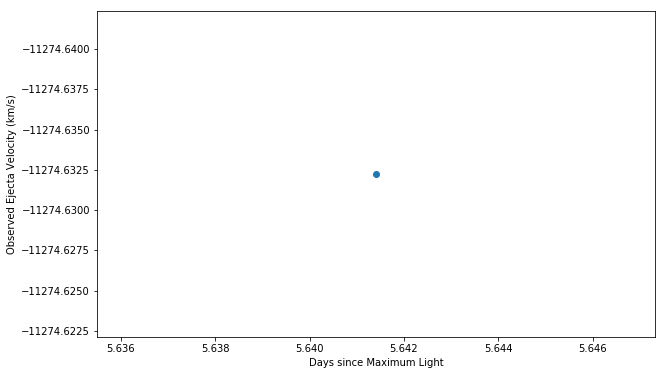

2002cd


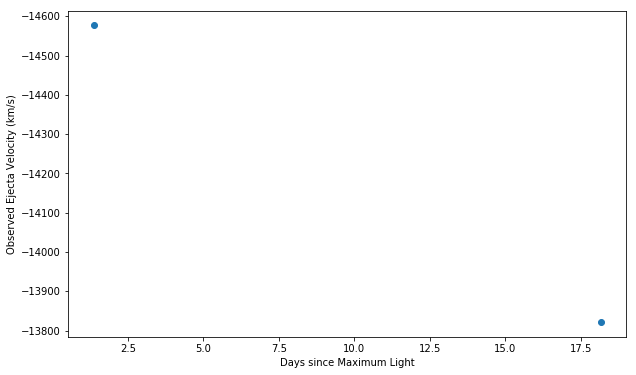

2002ck


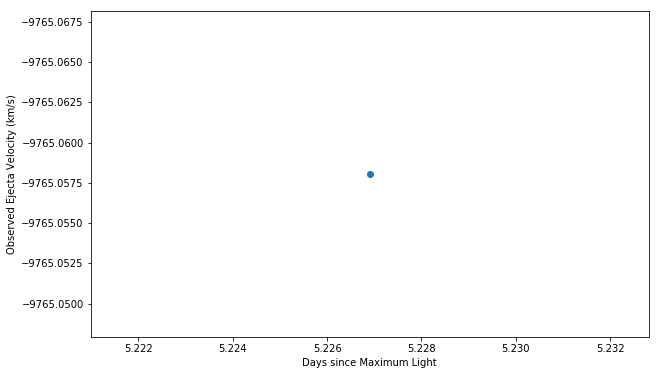

2002cr


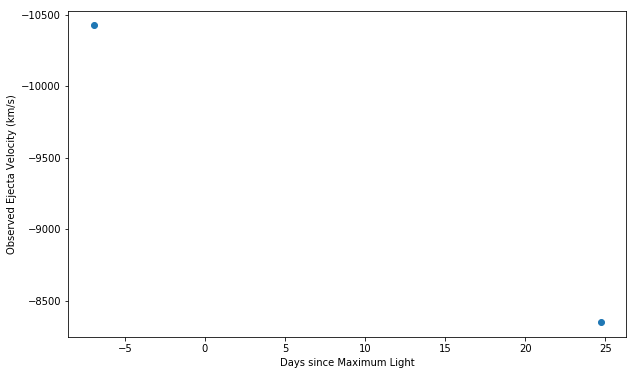

2002de


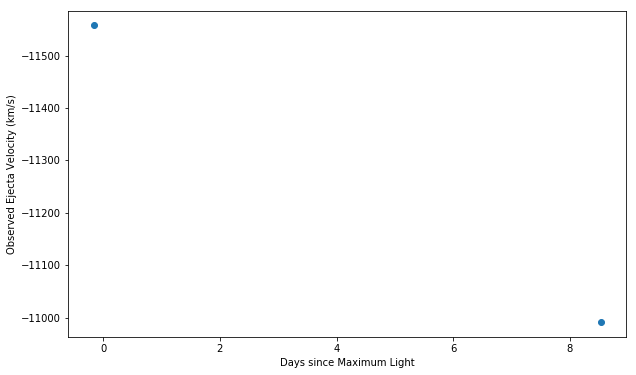

2002dj


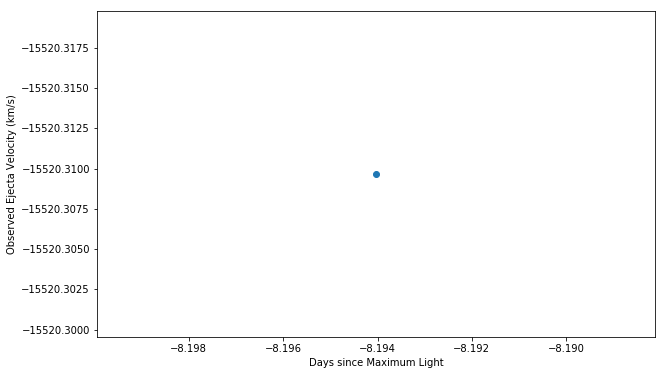

2002do


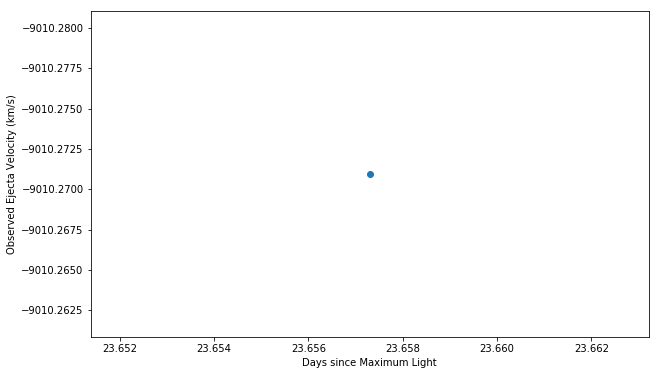

2002dp


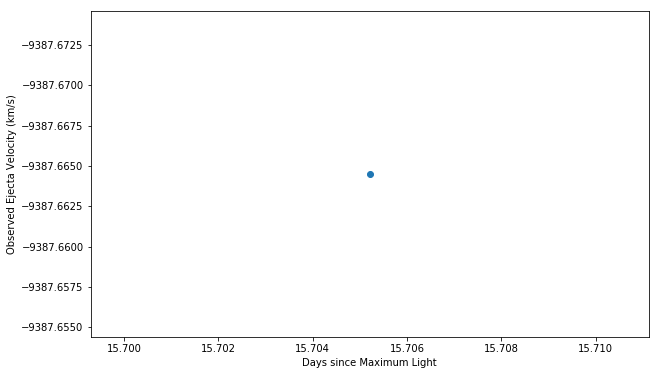

2002er


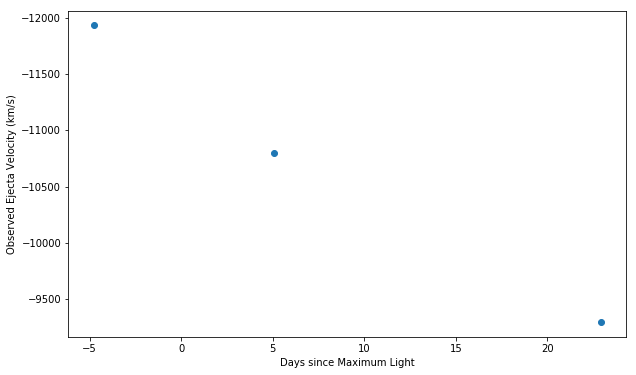

2002eu


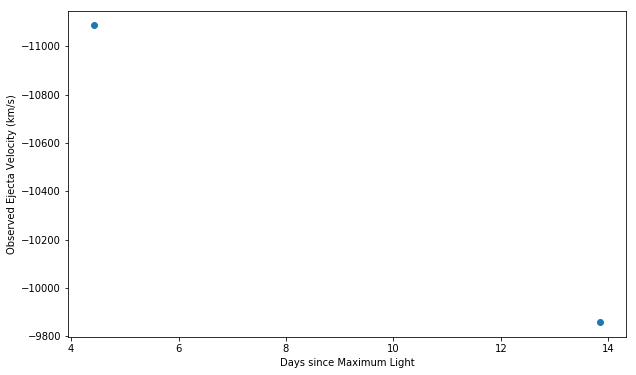

2002fb


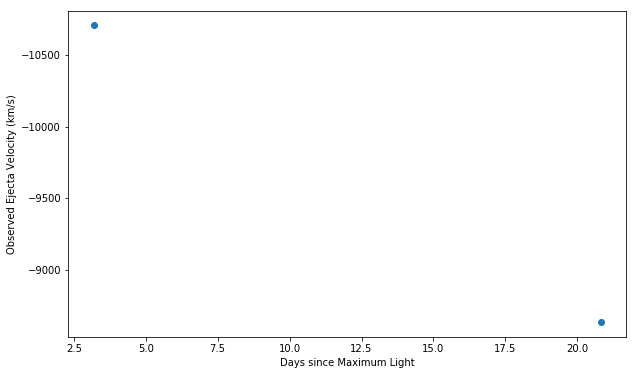

2002fk


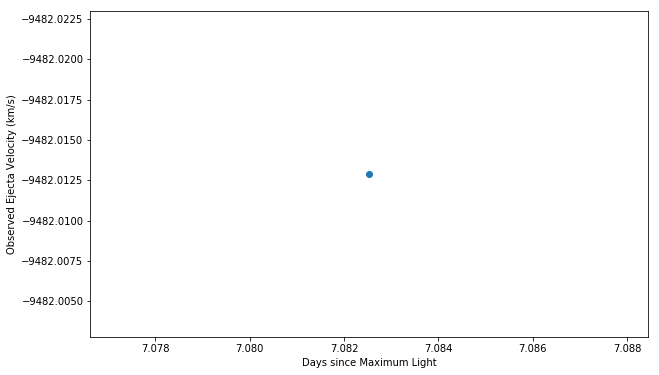

2002g


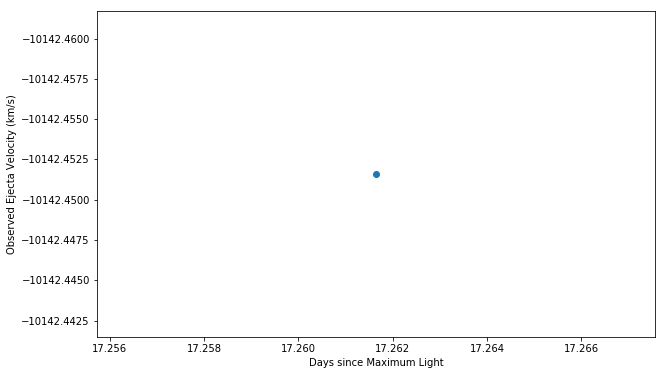

2002ha


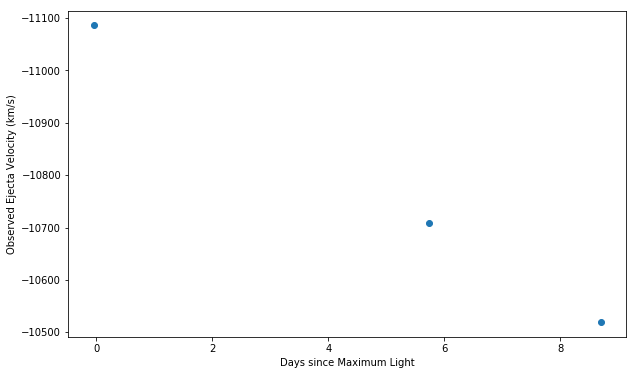

2002hd


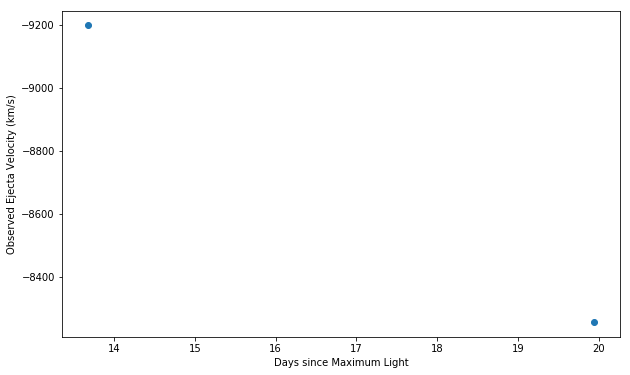

2002he


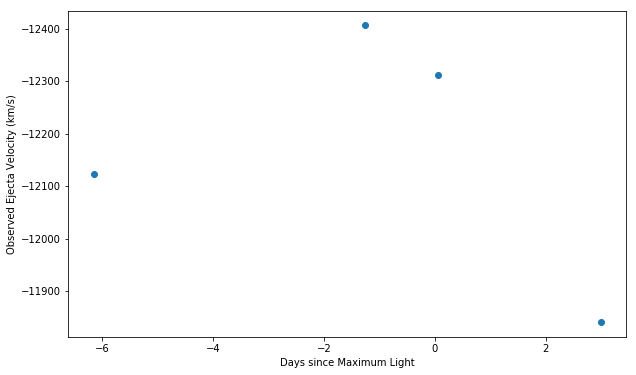

2002hu


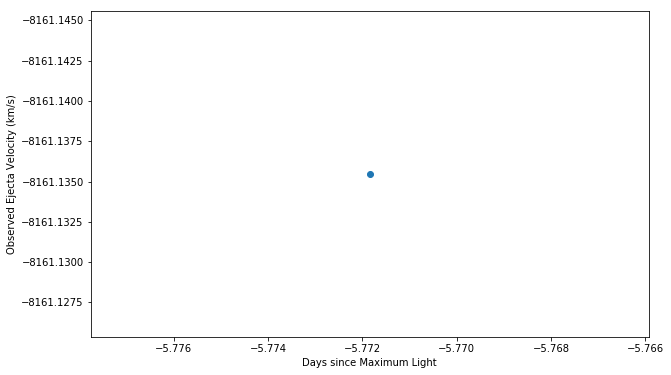

2002hw


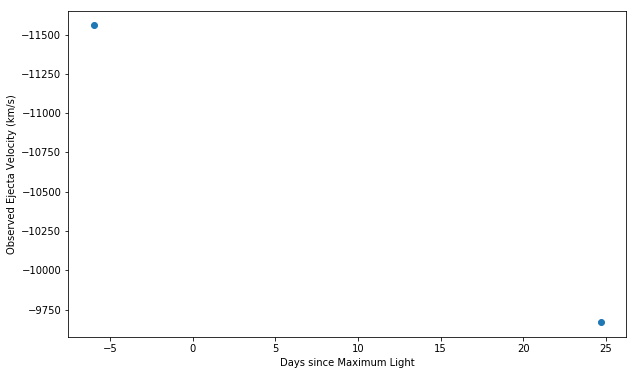

2002jy


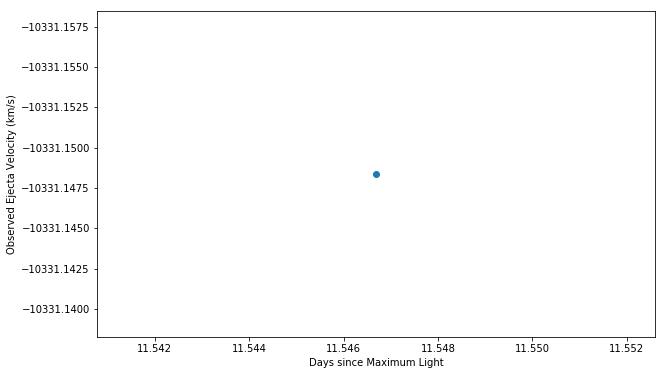

2002kf


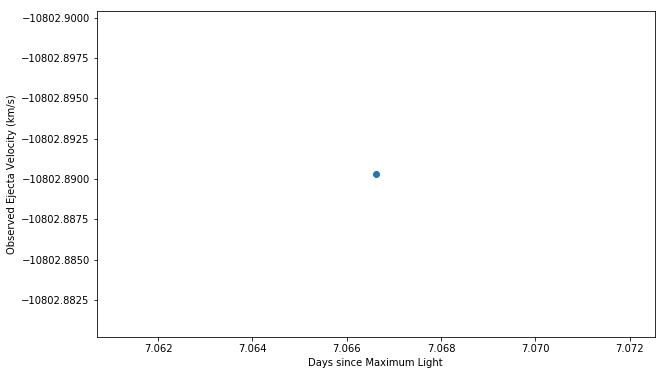

2003ai


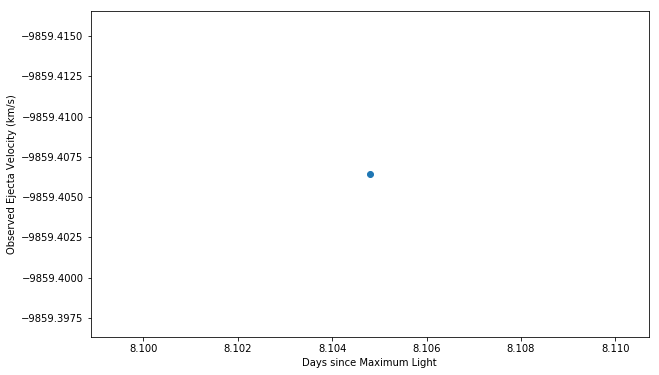

2003cq


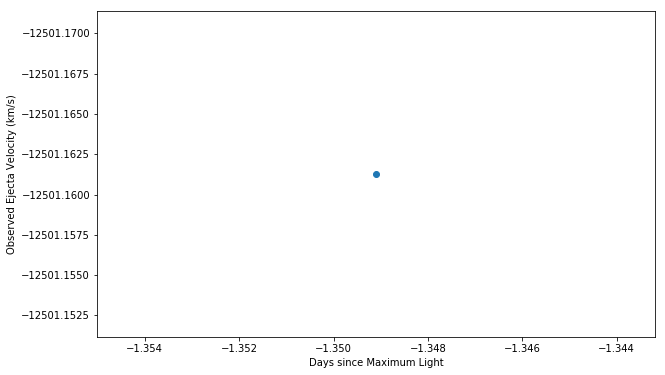

2003d


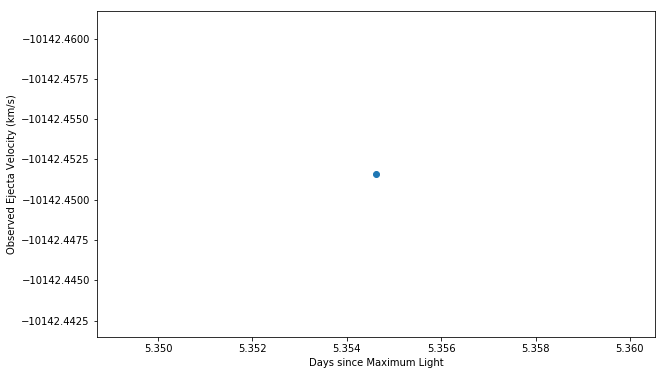

2003du


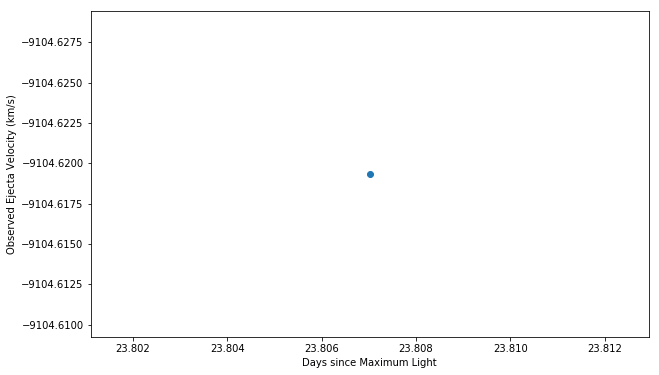

2003fa


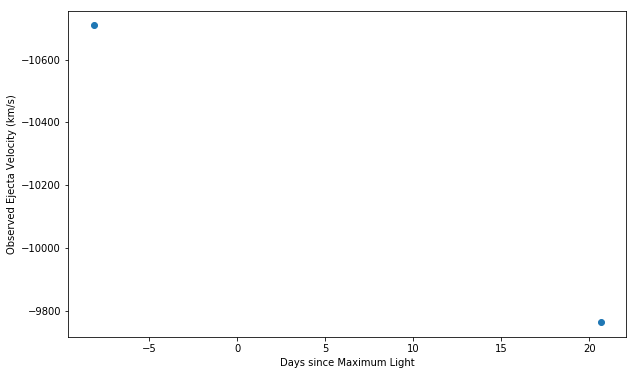

2003iv


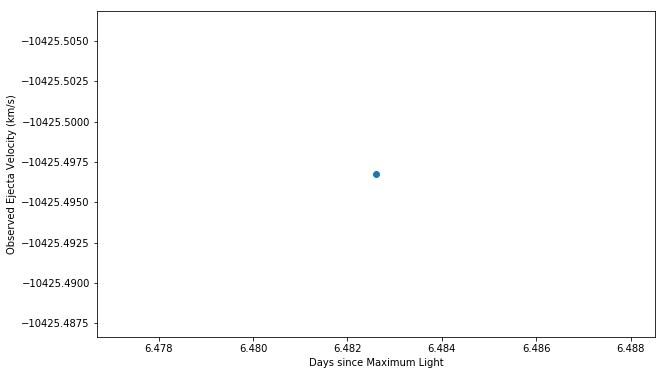

2003k


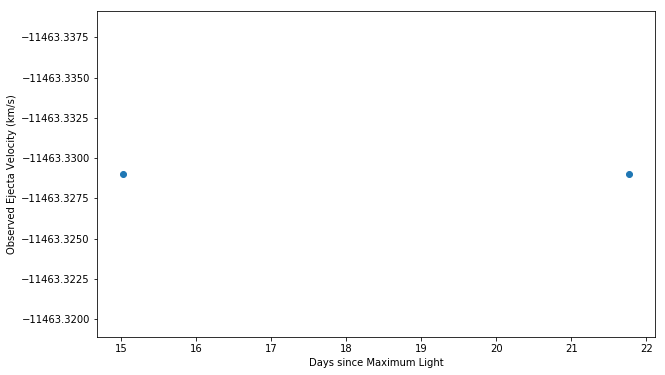

2003kc


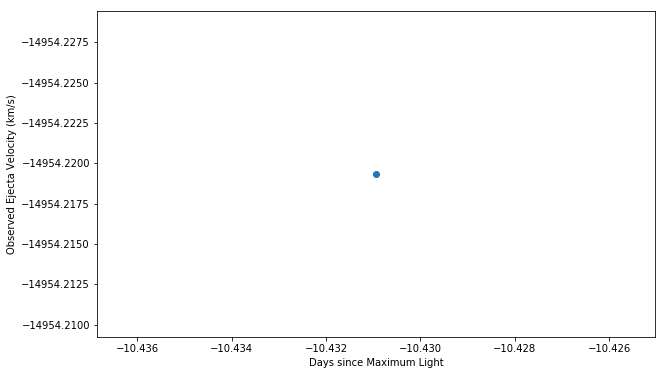

2003kf


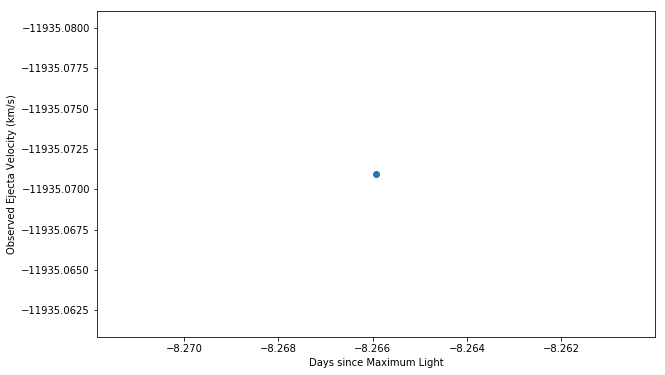

2003u


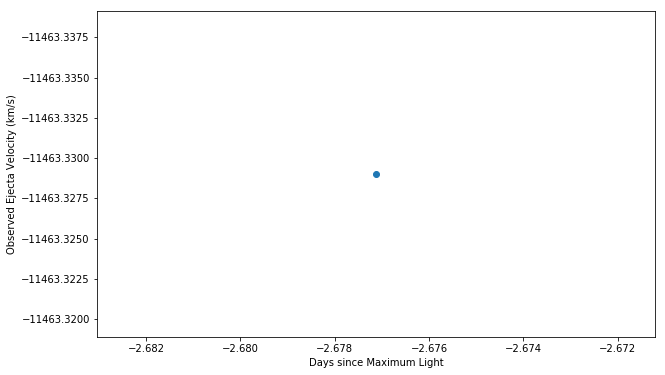

2003w


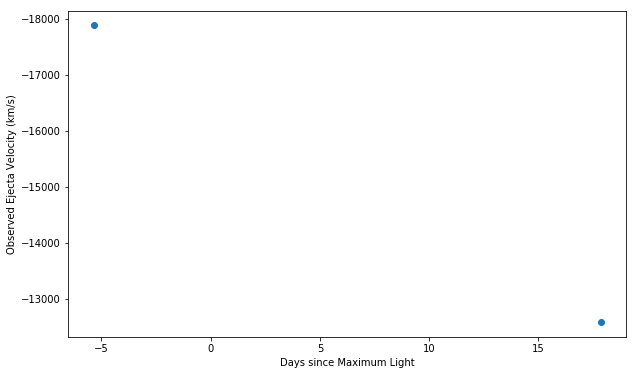

2004as


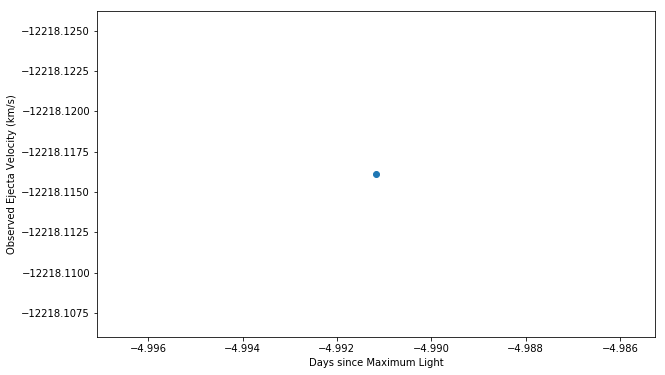

2004bg


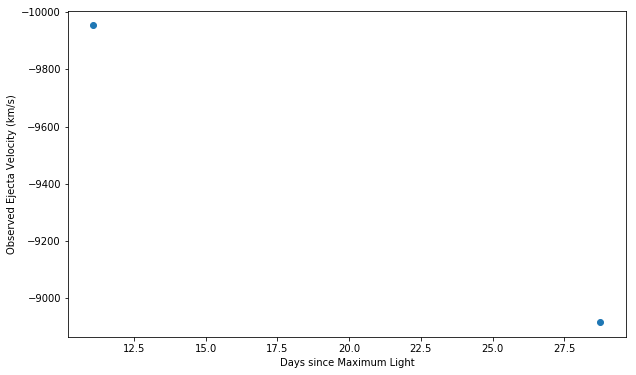

2004dt


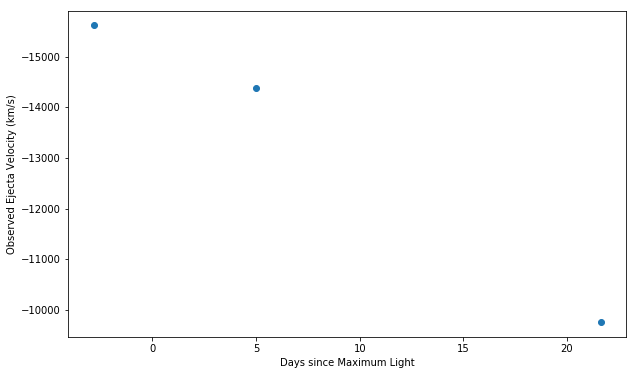

2004ef


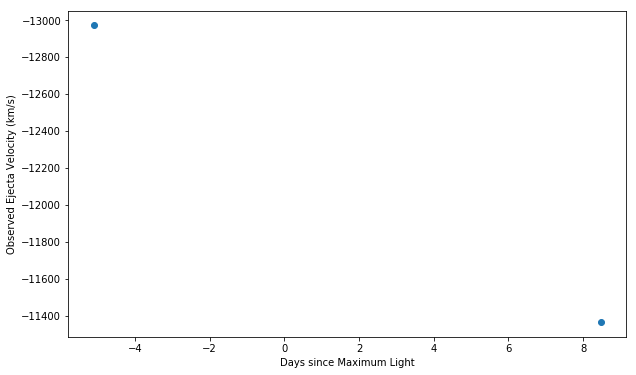

2004eo


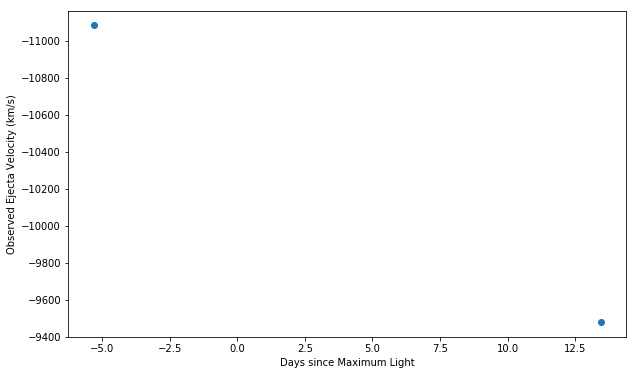

2004ey


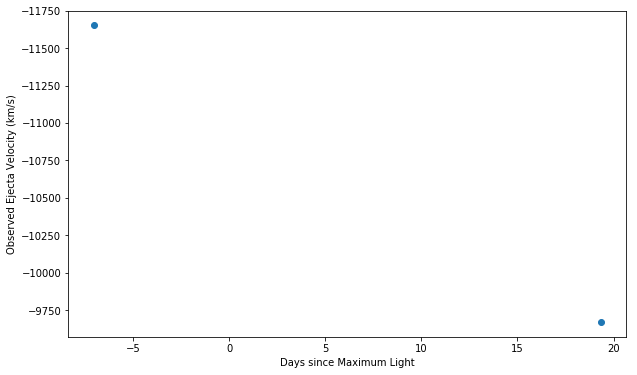

2004fu


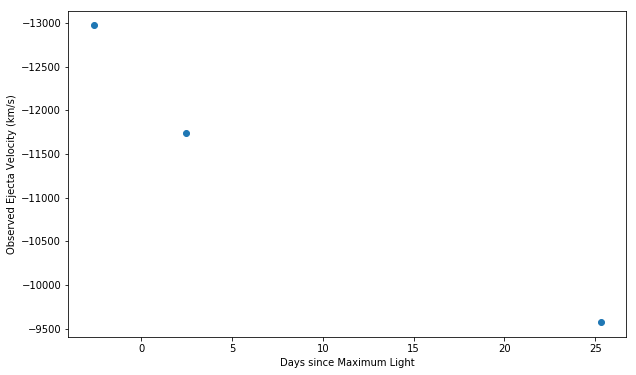

2004gs


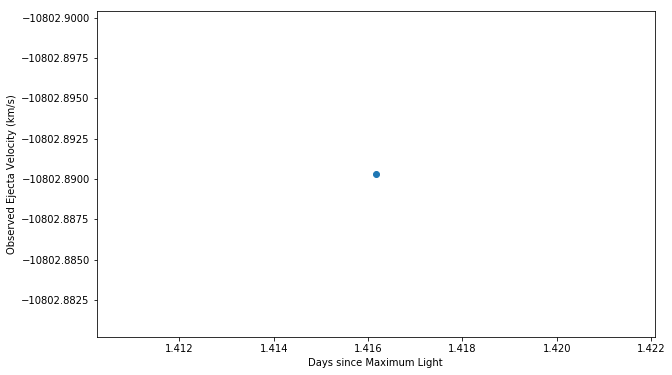

2004gu


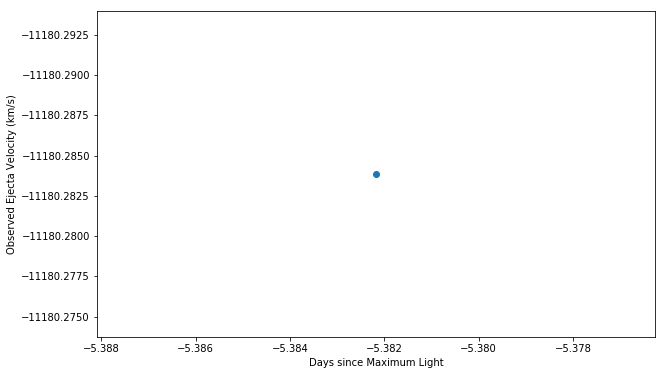

2005a


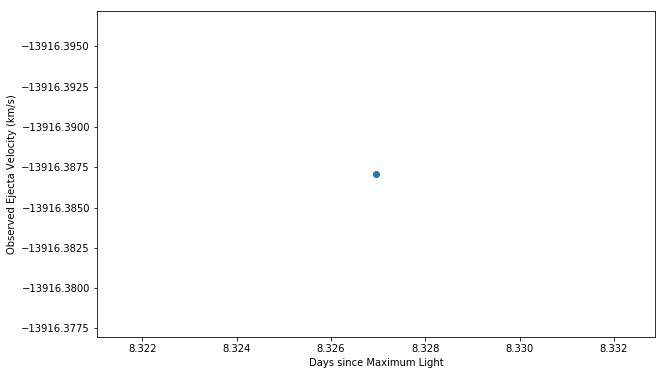

2005ag


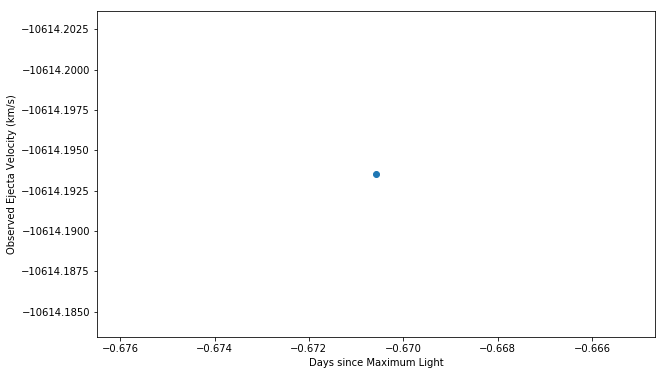

2005am


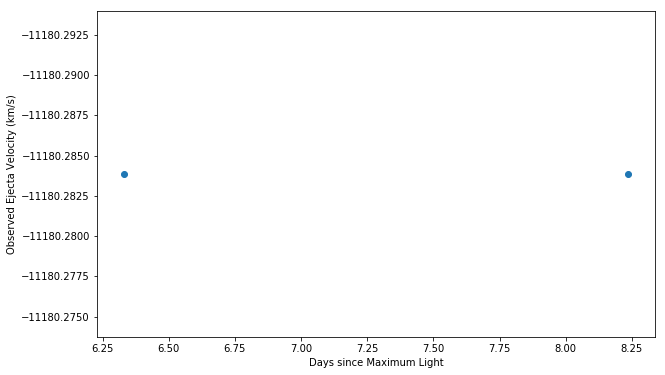

2005be


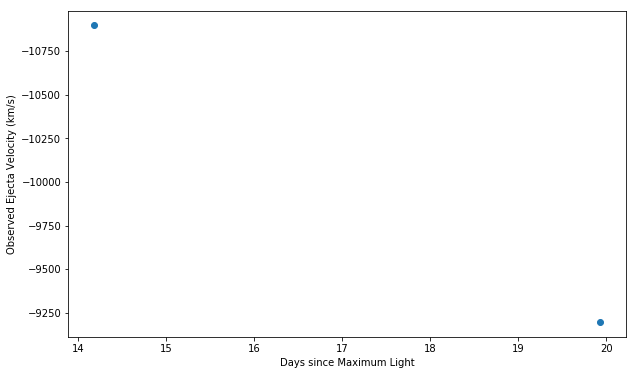

2005bl


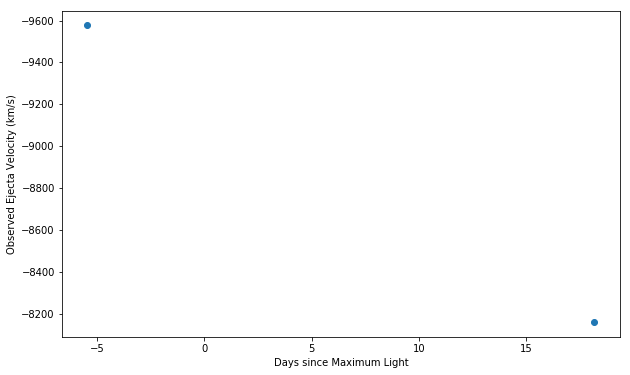

2005bo


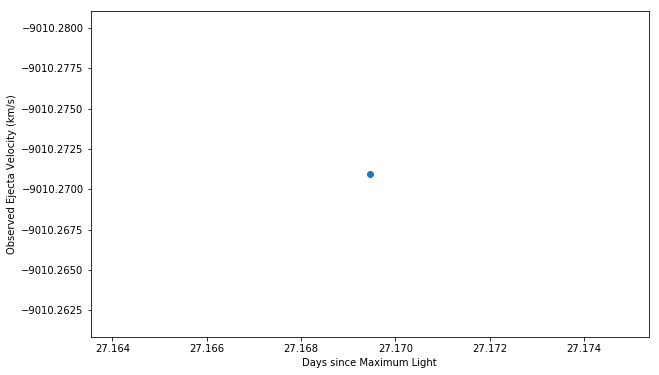

2005cf


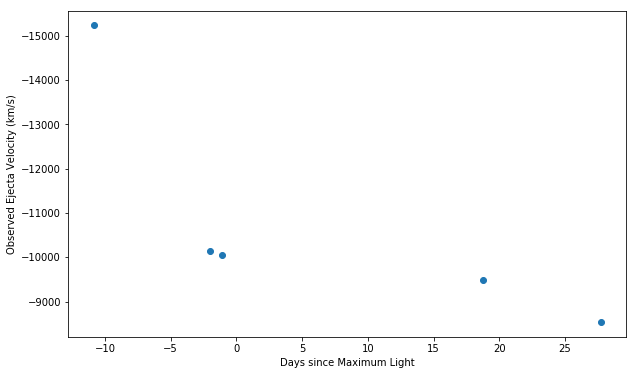

2005dv


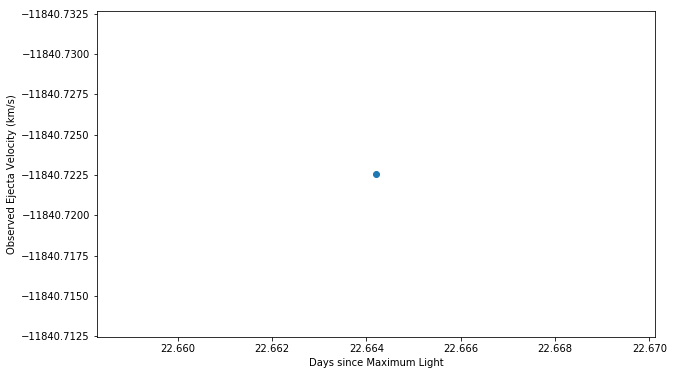

2005el


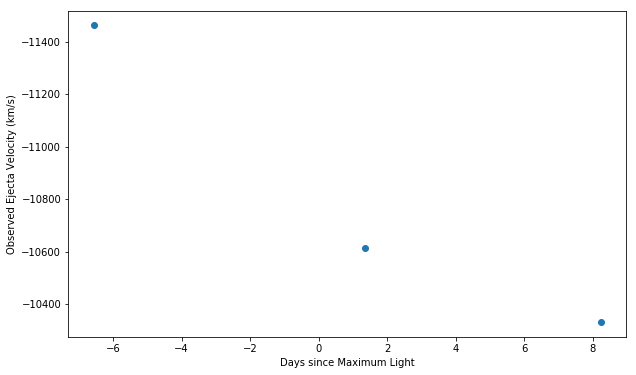

2005eq


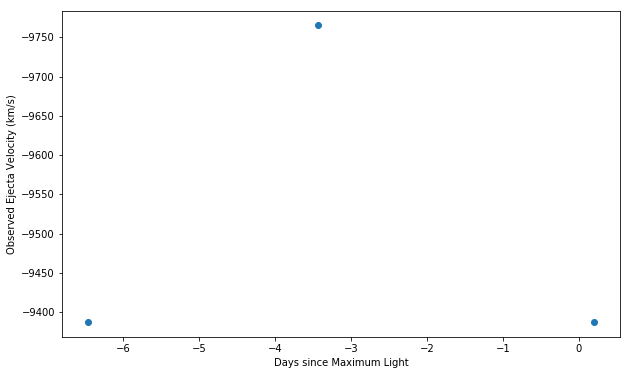

2005eu


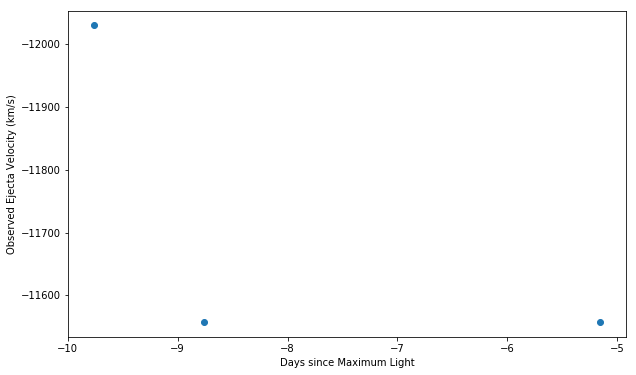

2005ew


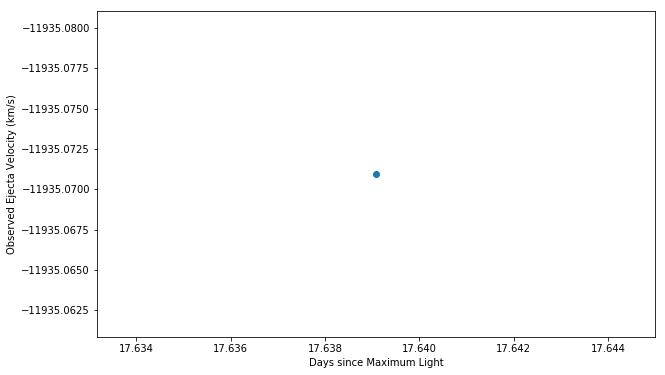

2005hc


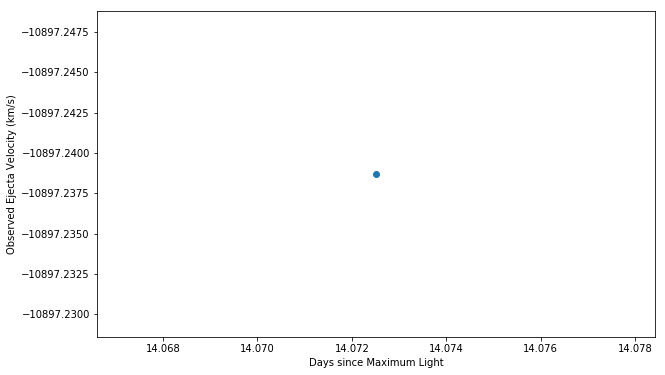

2005hj


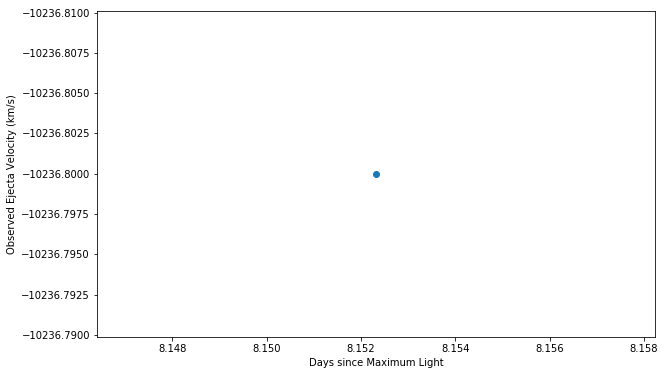

2005iq


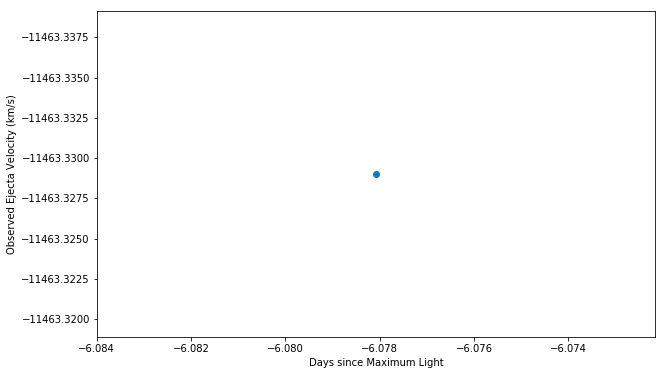

2005kc


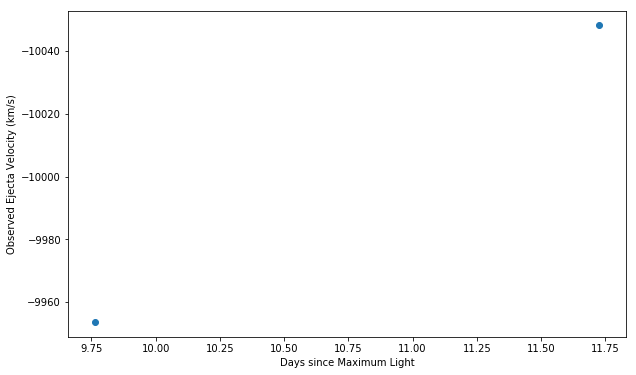

2005ke


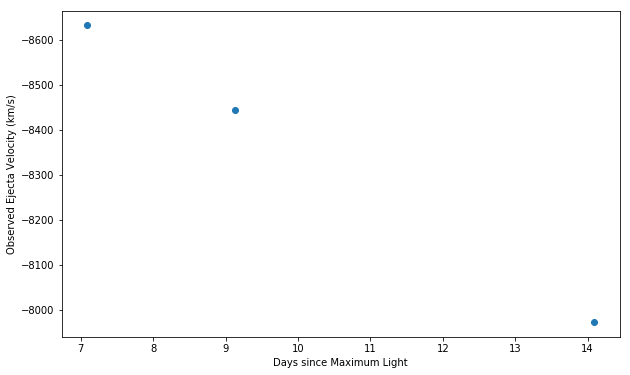

2005ki


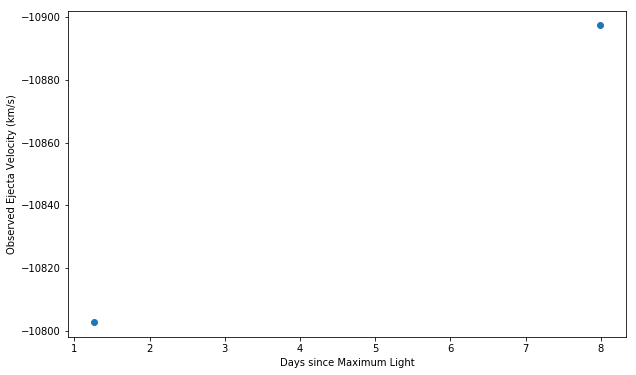

2005ls


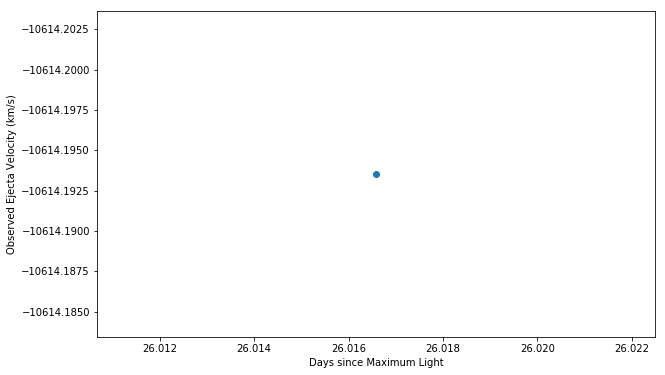

2005lz


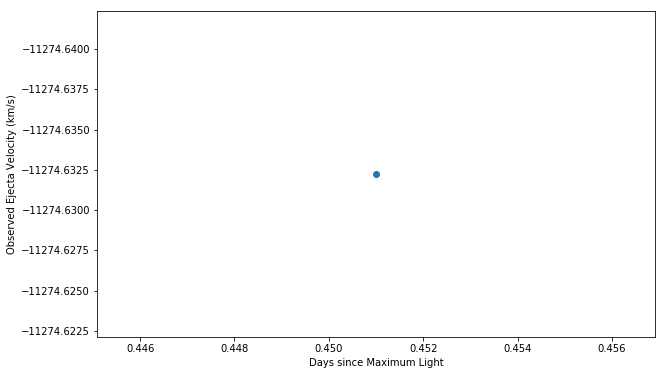

2005m


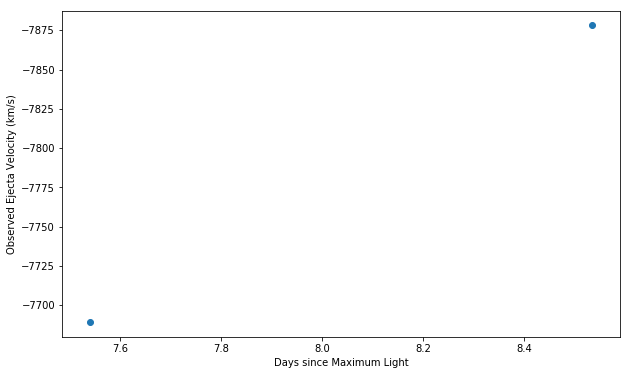

2005mc


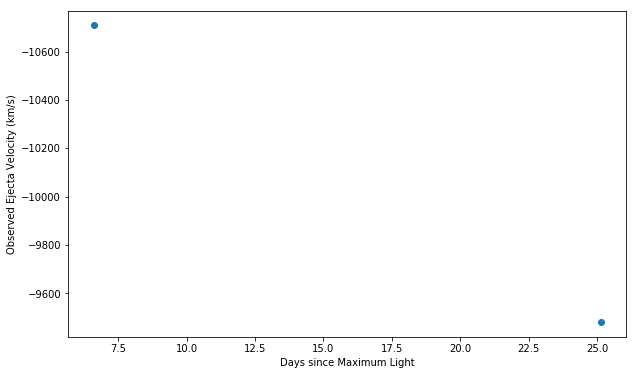

2005ms


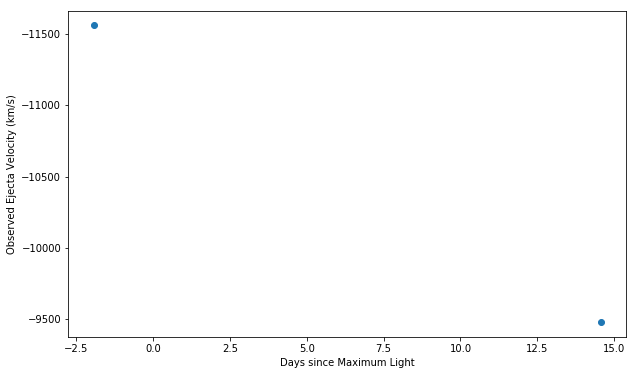

2005na


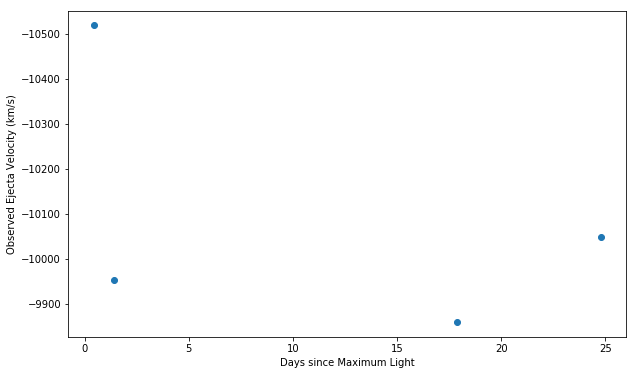

2005w


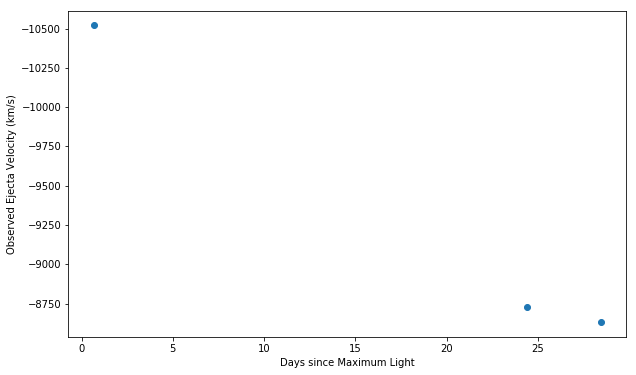

2006ac


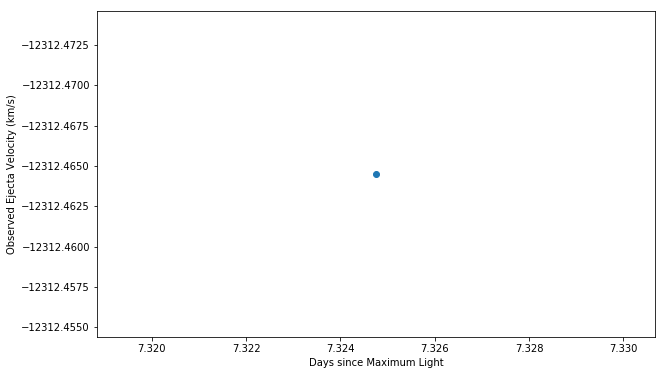

2006ak


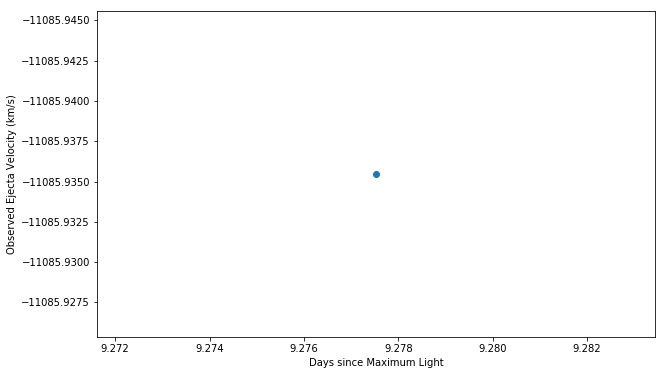

2006ax


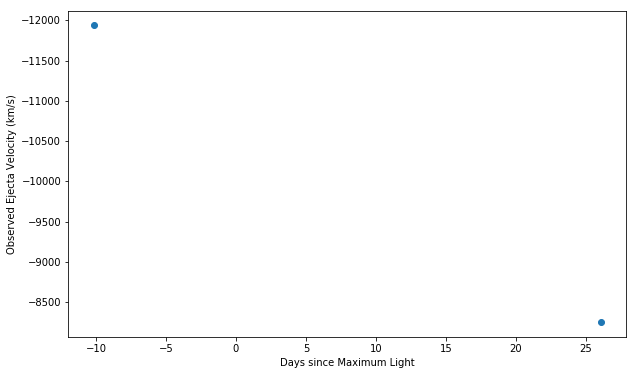

2006az


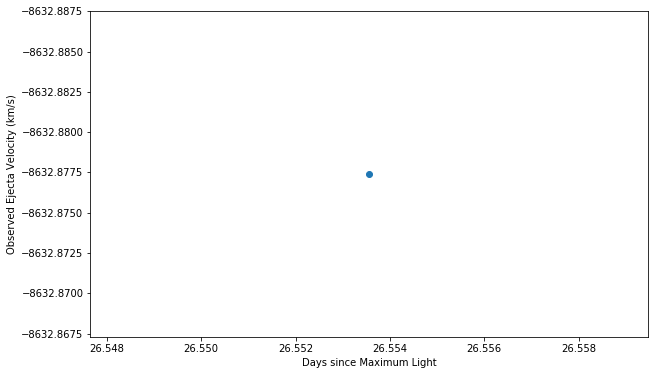

2006bq


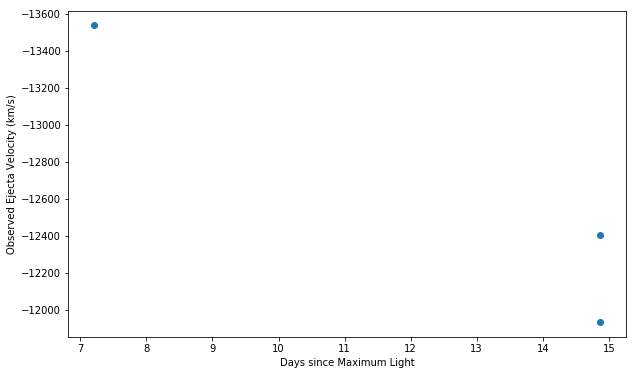

2006bu


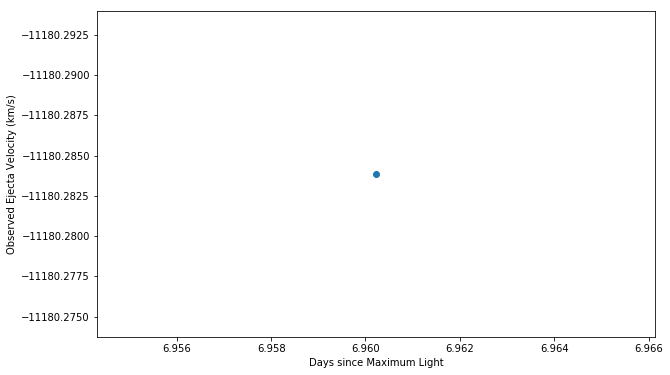

2006bw


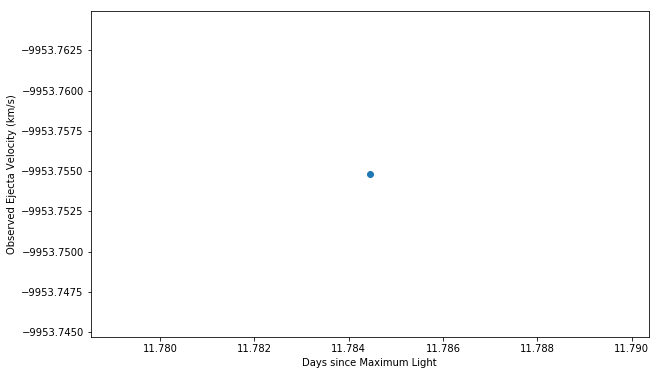

2006bz


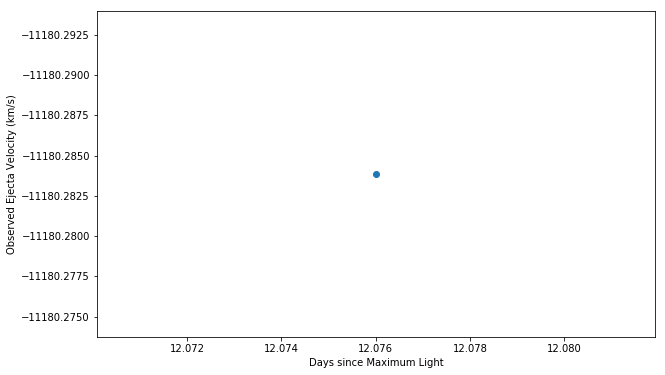

2006cc


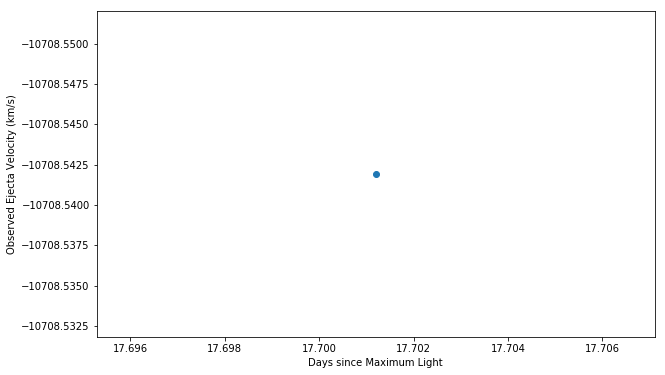

2006cf


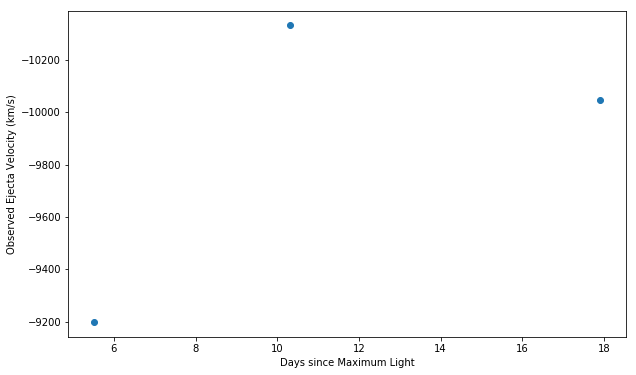

2006cj


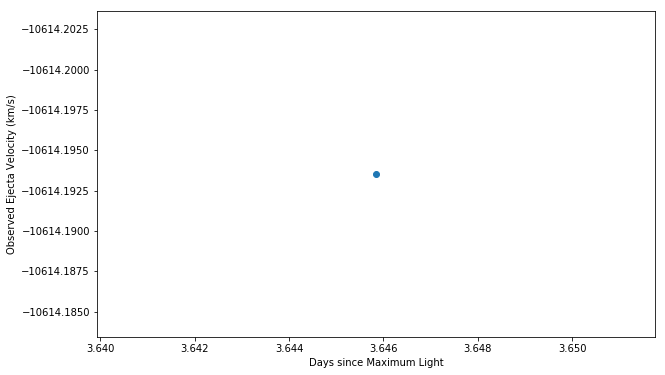

2006cp


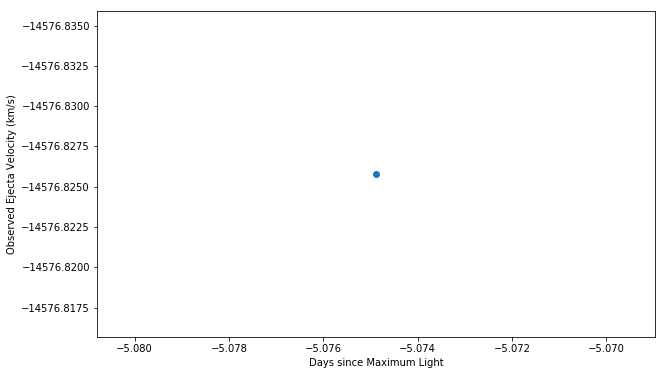

2006cq


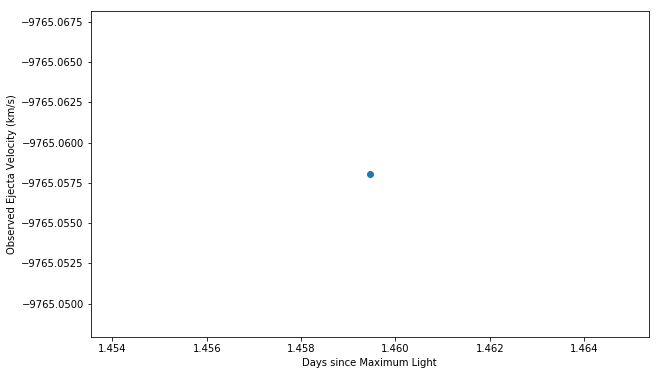

2006cs


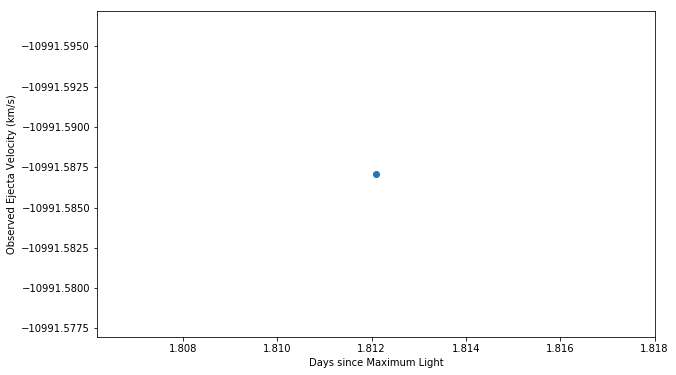

2006cz


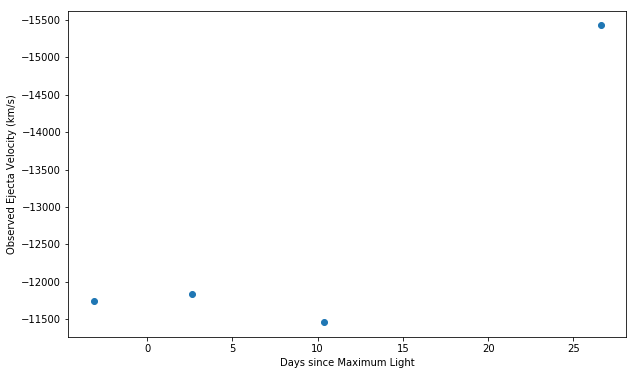

2006d


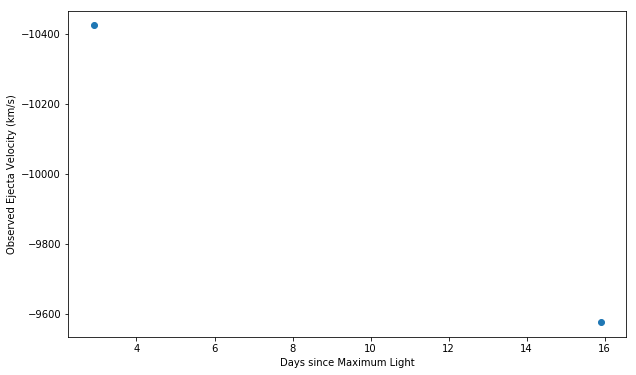

2006ef


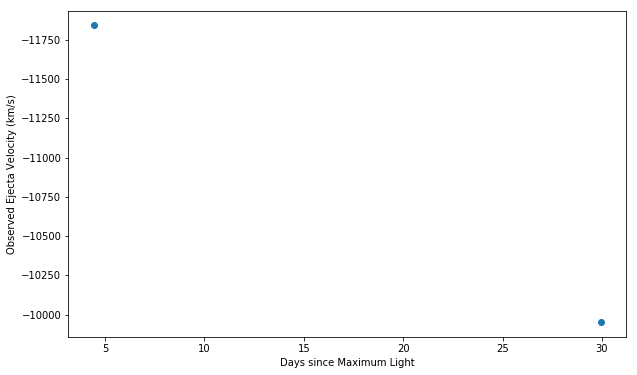

2006ej


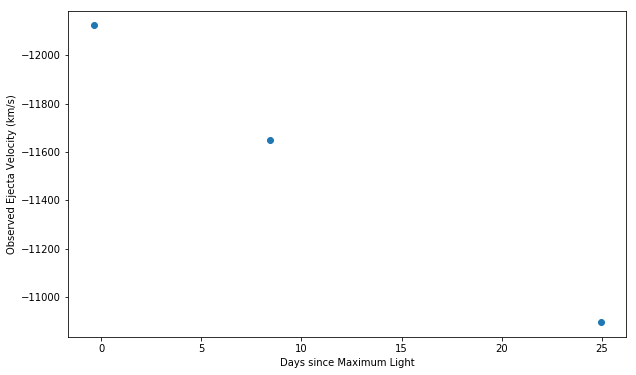

2006em


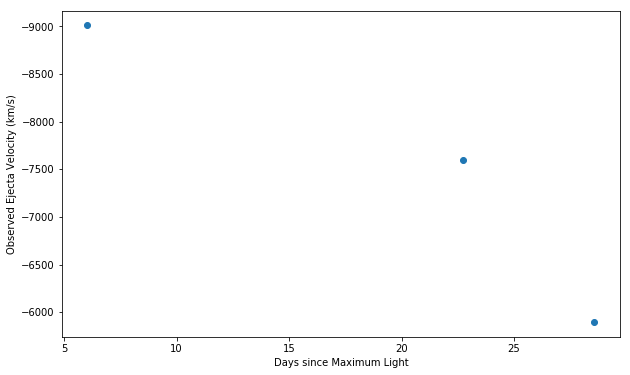

2006en


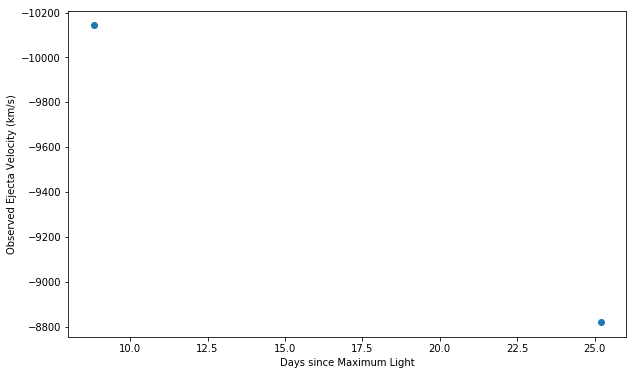

2006et


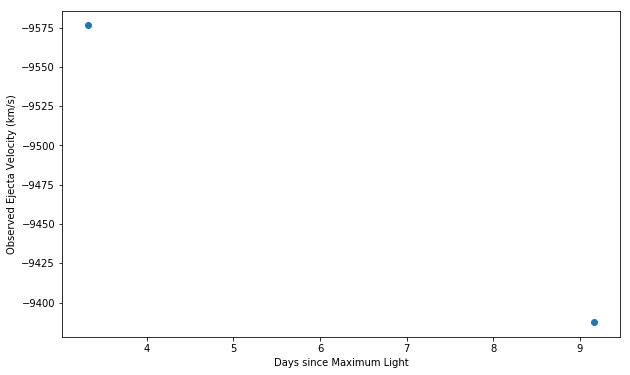

2006eu


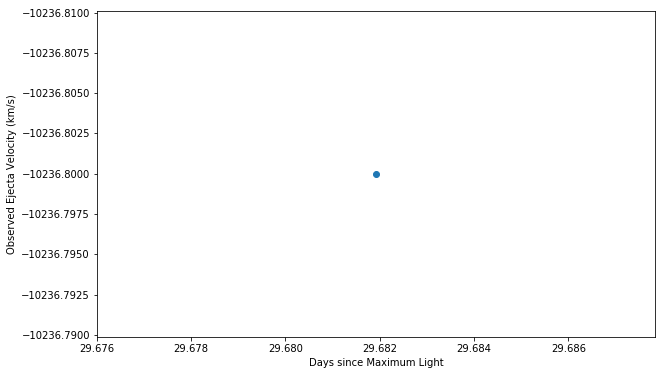

2006ev


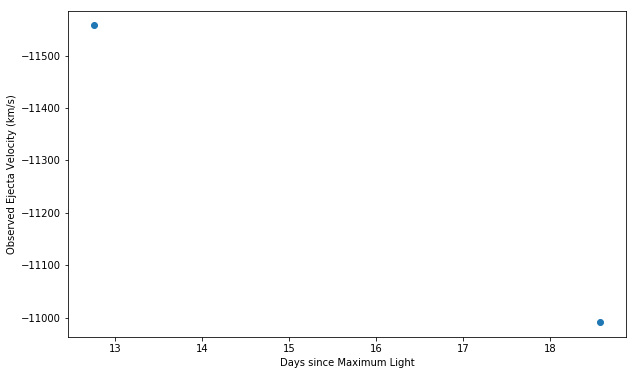

2006gj


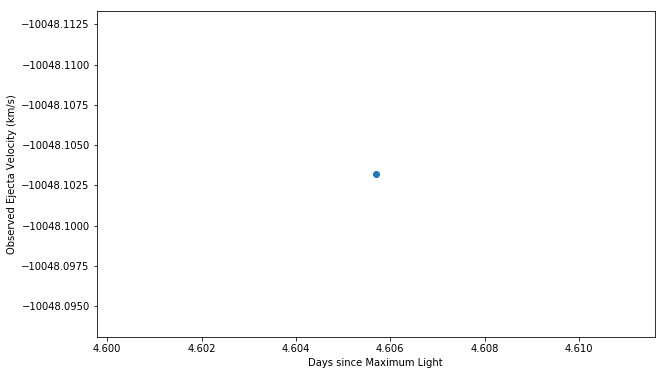

2006gr


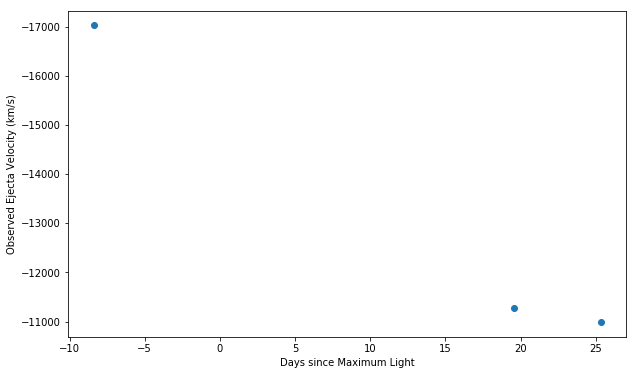

2006gt


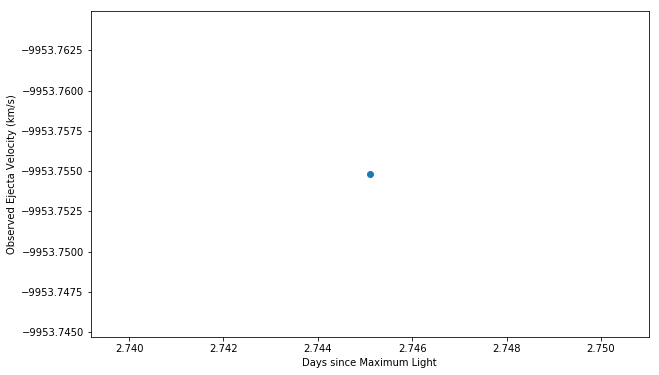

2006h


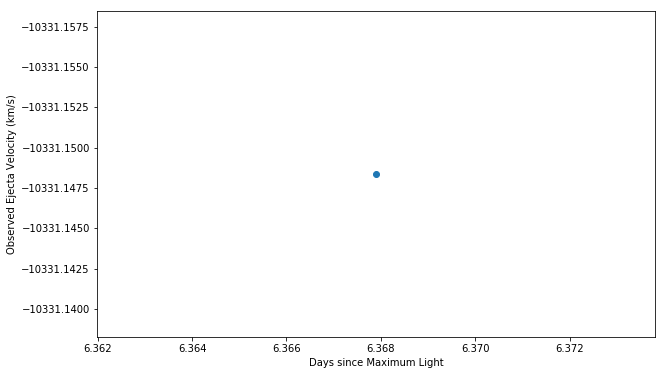

2006je


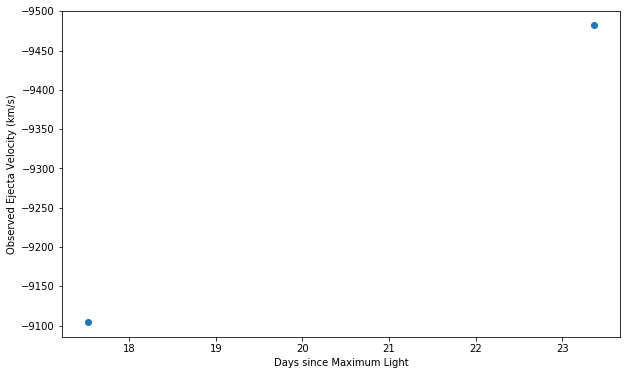

2006kf


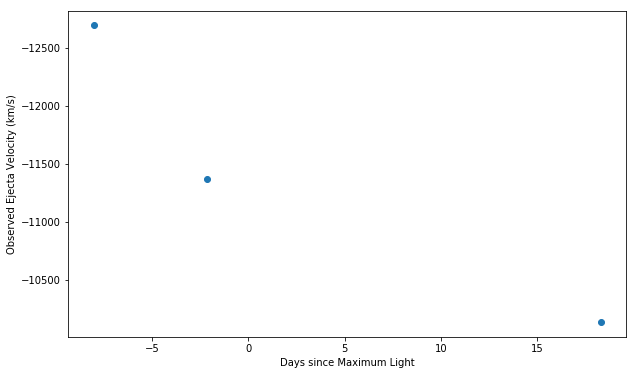

2006le


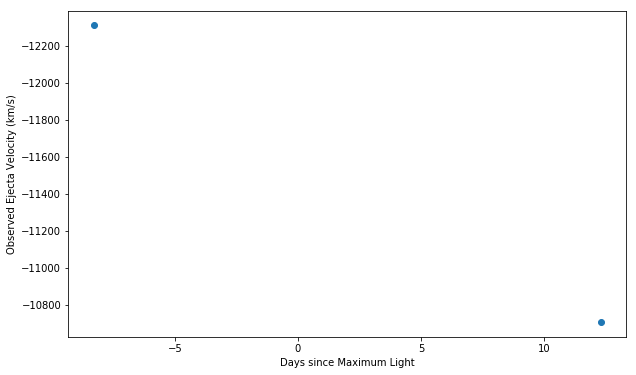

2006lf


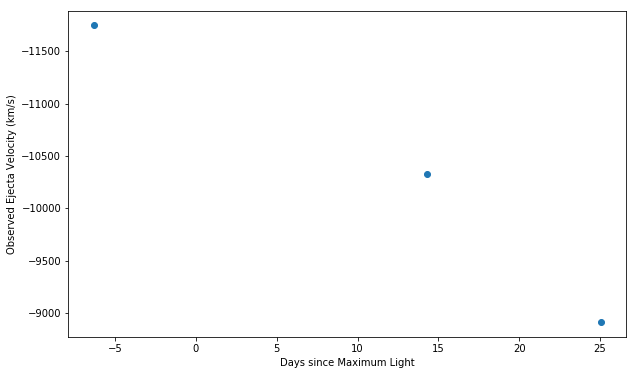

2006mo


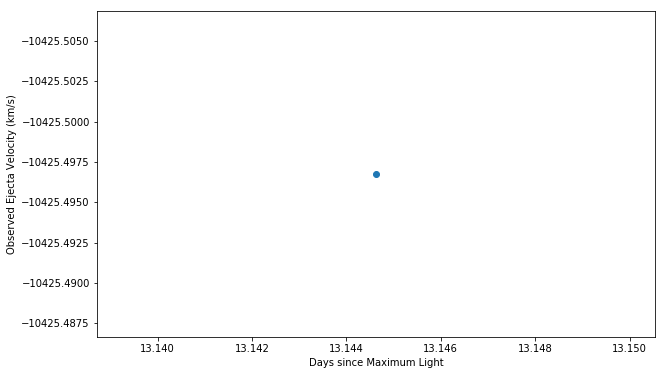

2006mp


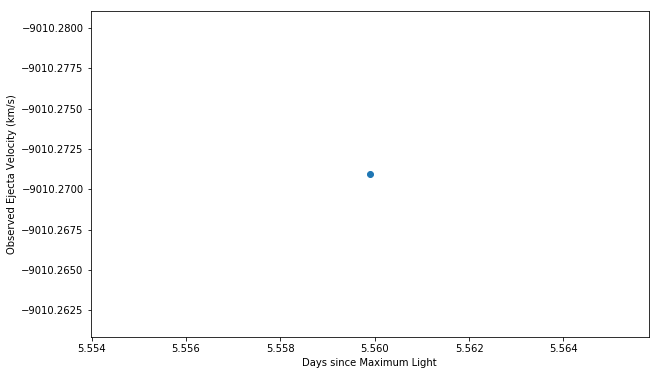

2006n


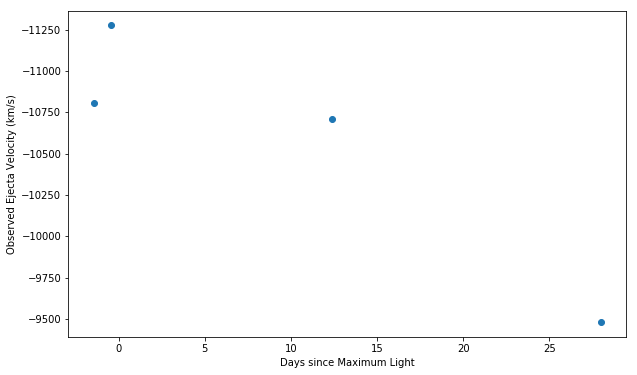

2006or


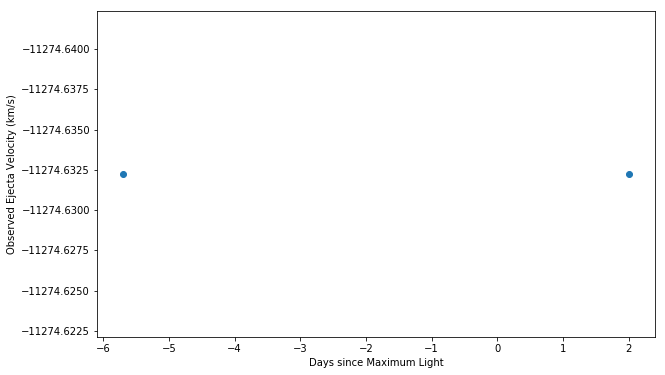

2006os


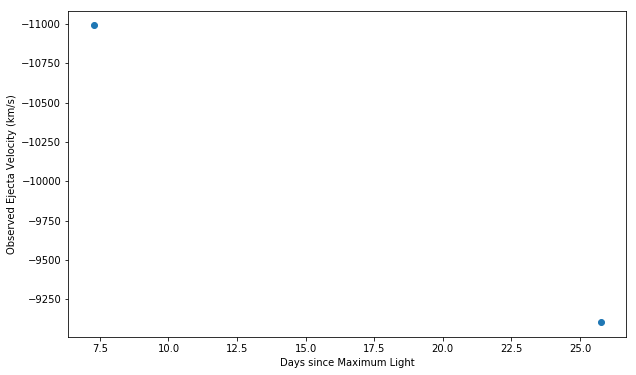

2006ot


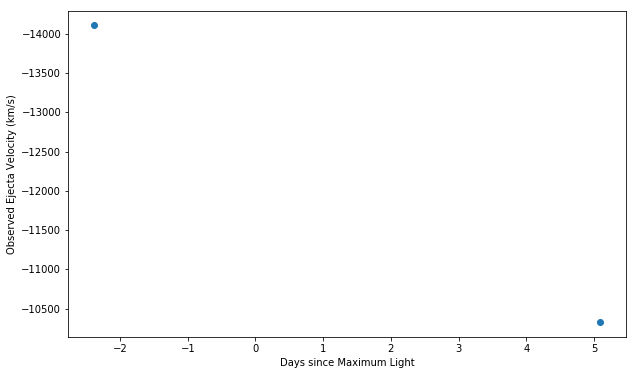

2006qo


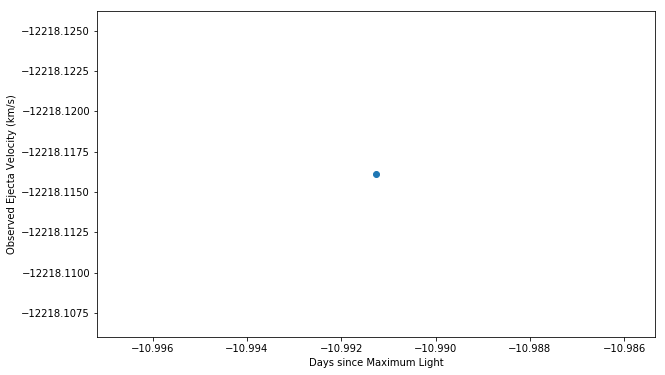

2006s


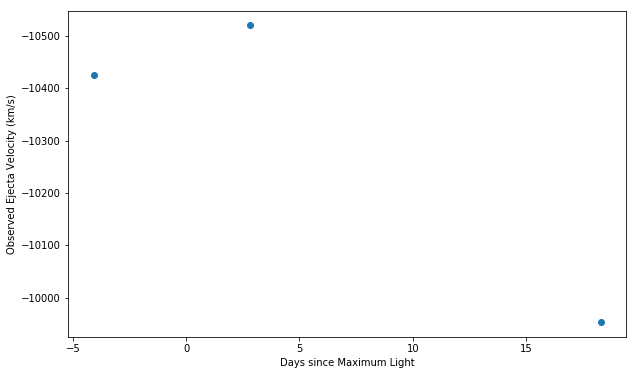

2006sr


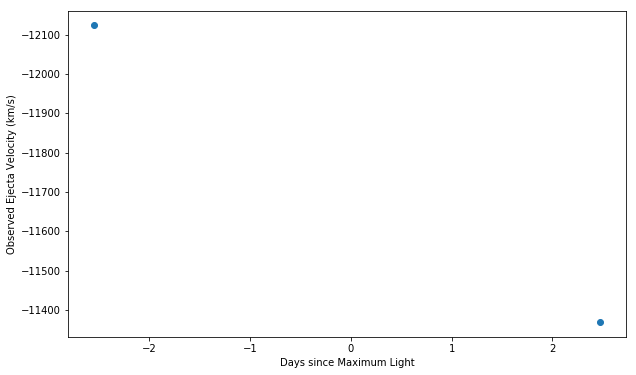

2006td


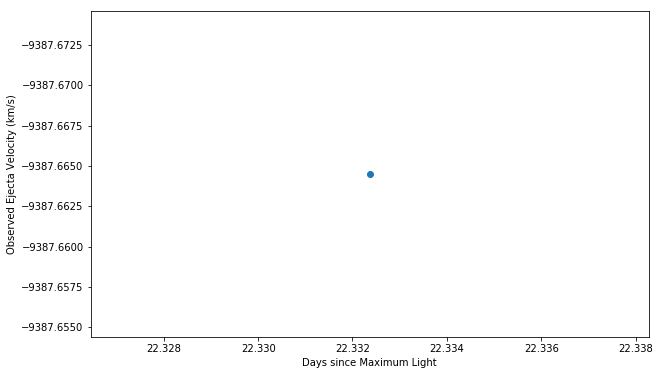

2006te


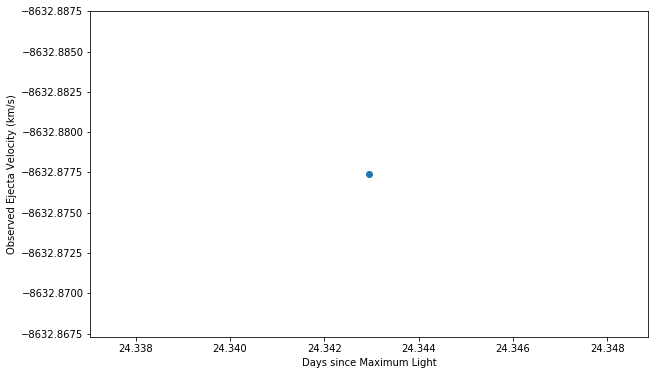

2006x


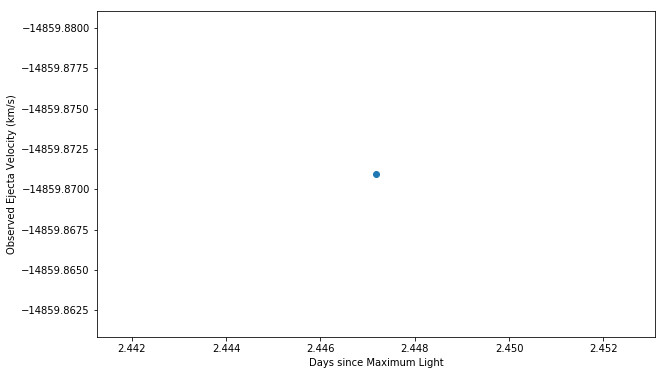

2007a


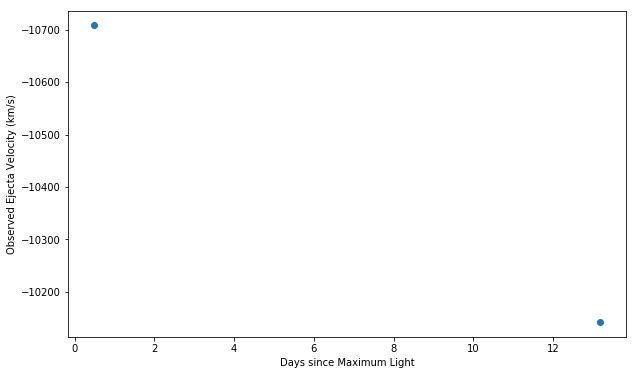

2007af


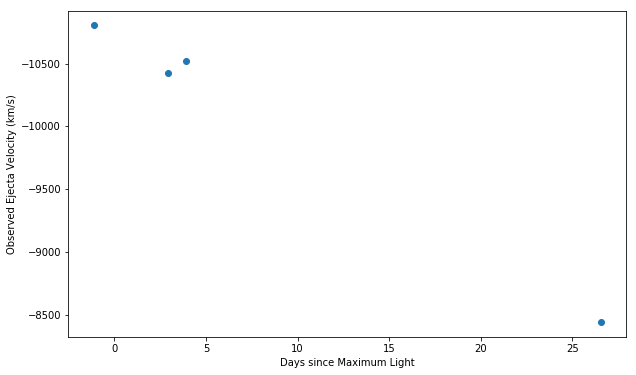

2007al


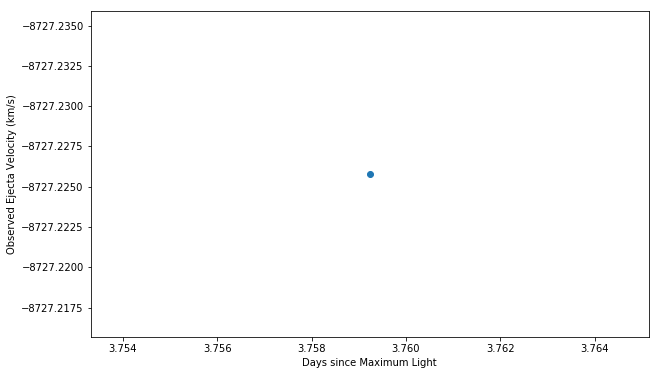

2007ap


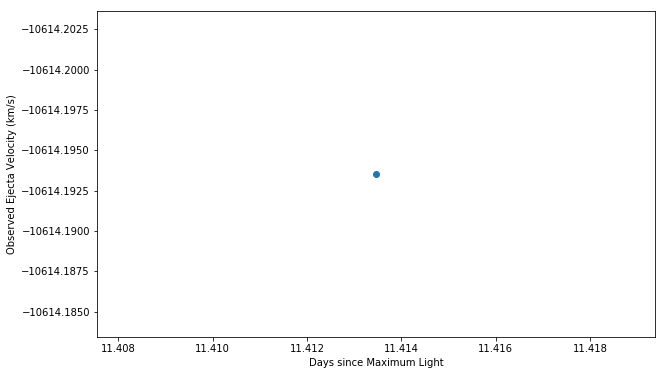

2007au


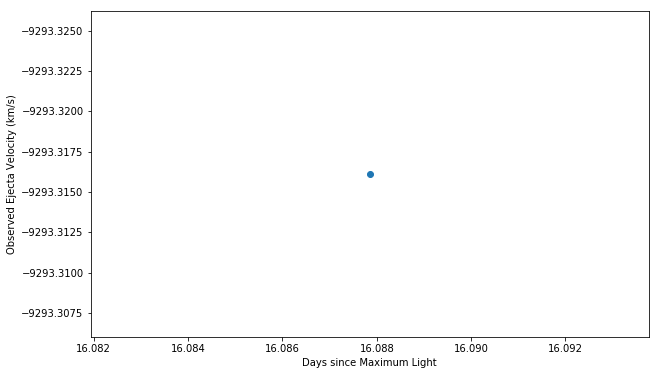

2007ax


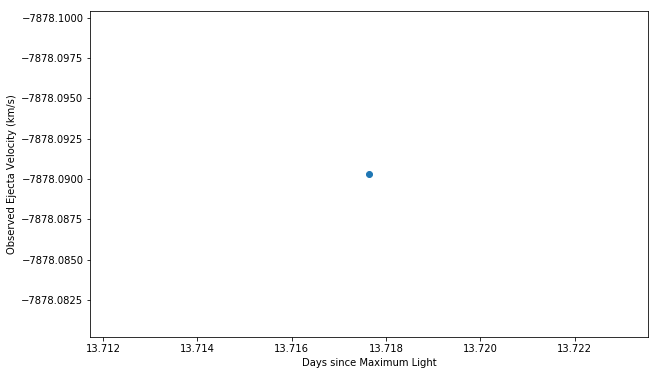

2007ba


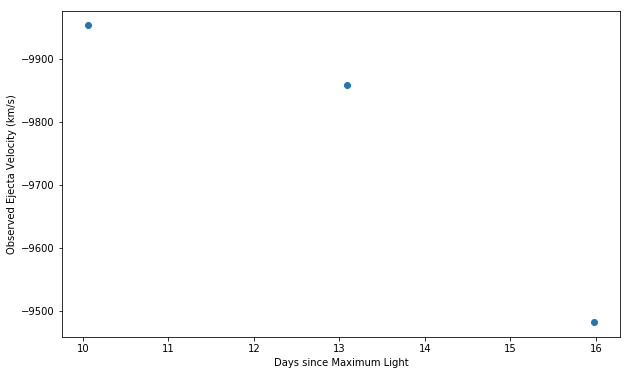

2007bc


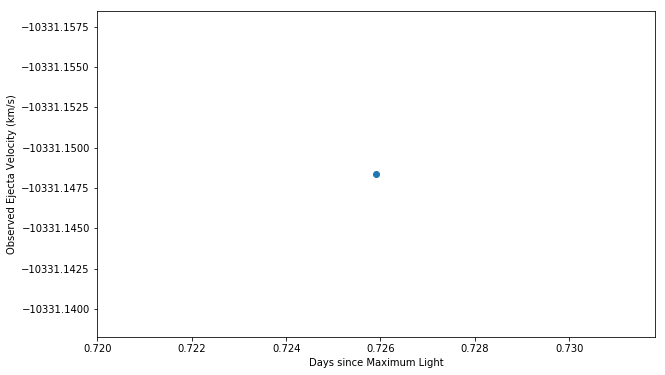

2007bd


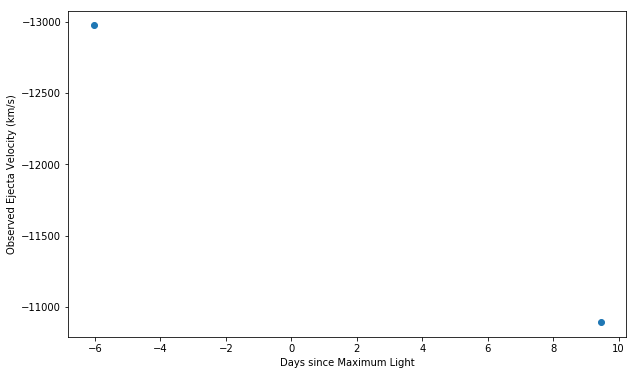

2007bm


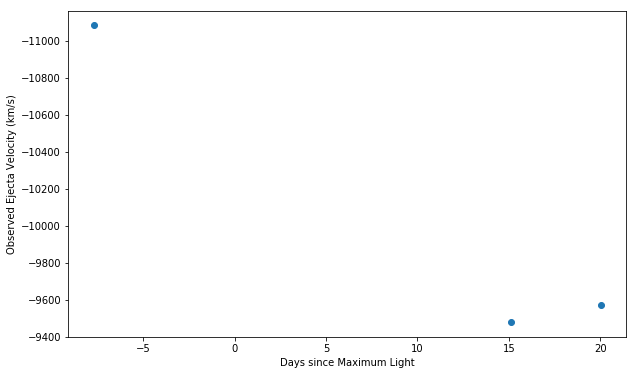

2007bz


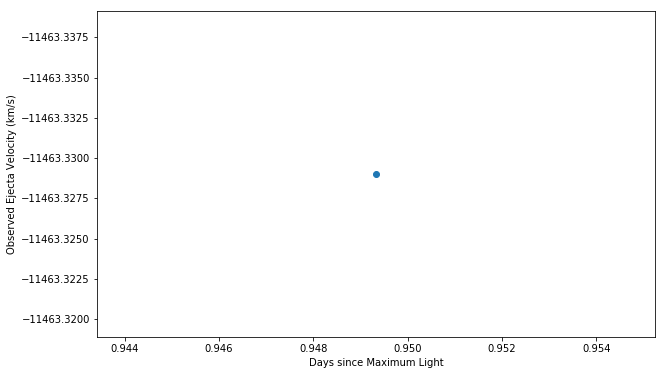

2007ca


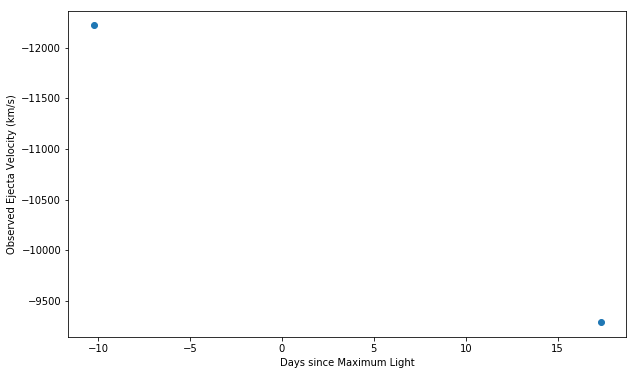

2007cg


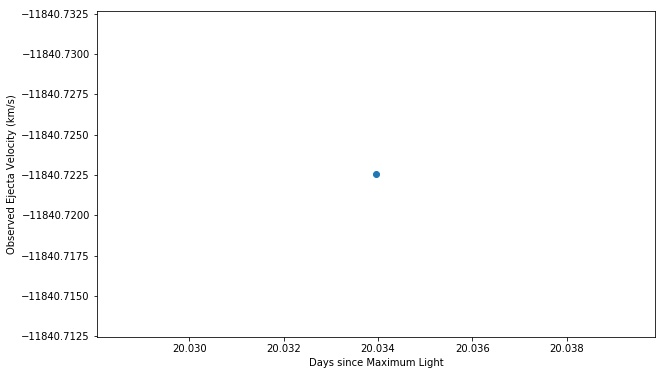

2007ci


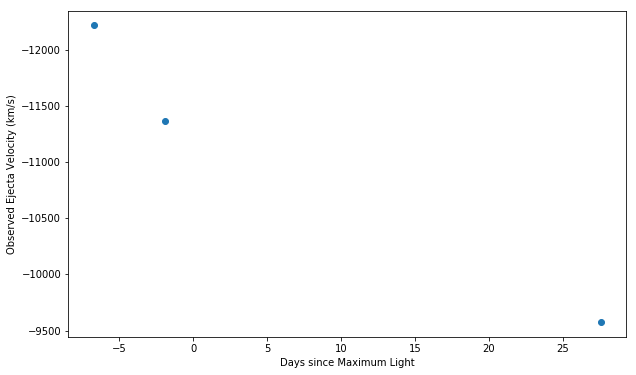

2007co


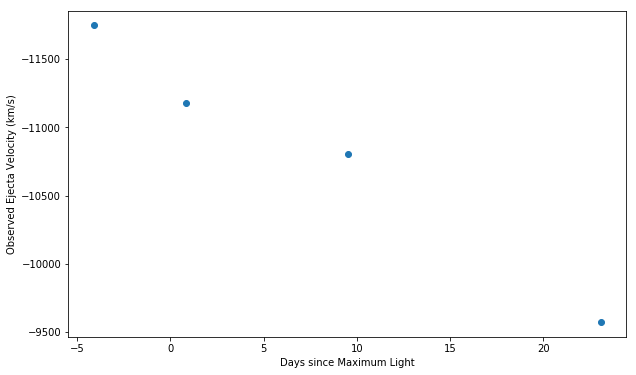

2007cp


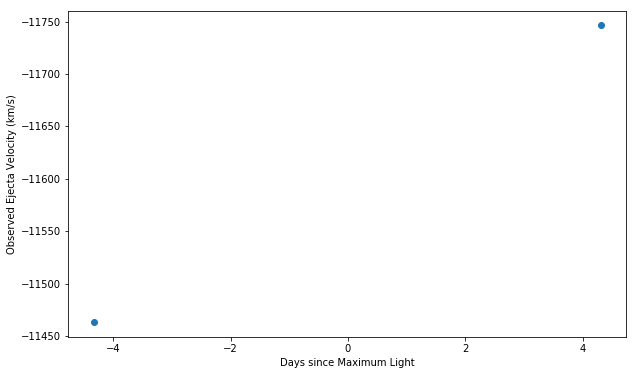

2007cq


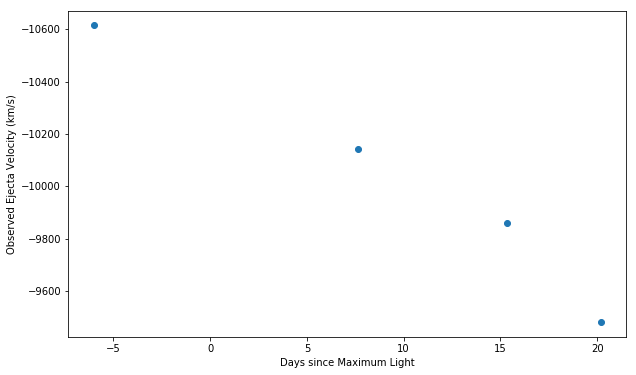

2007f


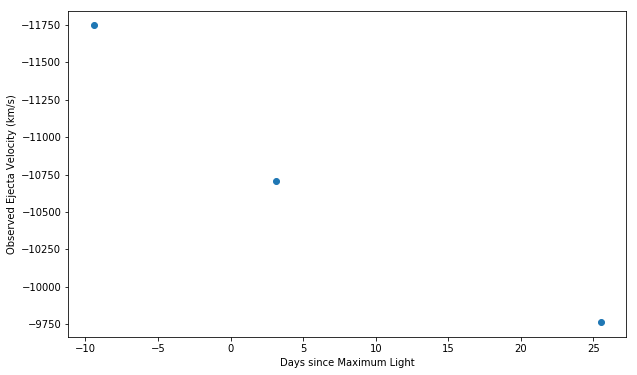

2007le


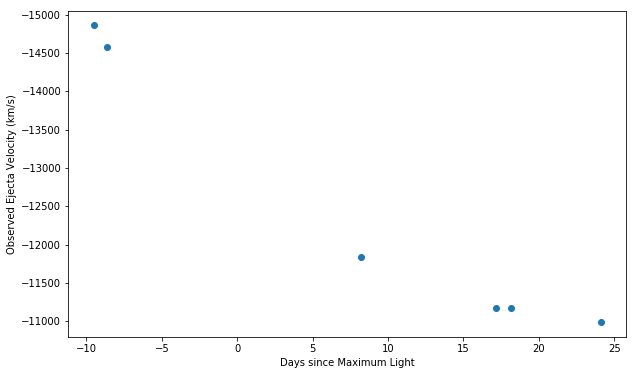

2007n


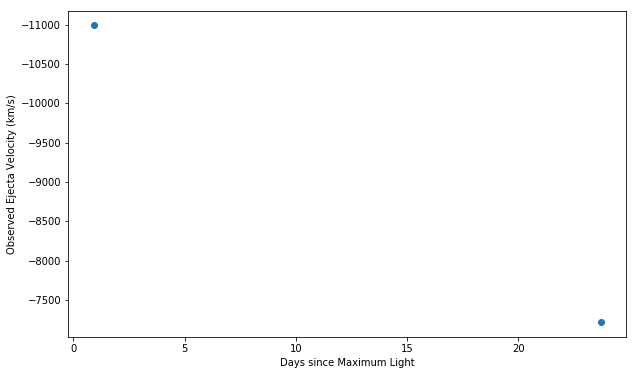

2007o


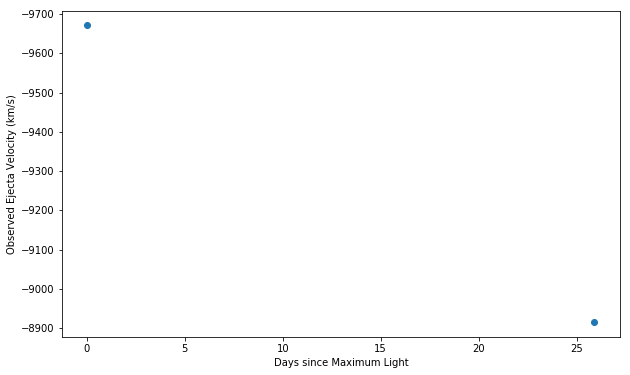

2007on


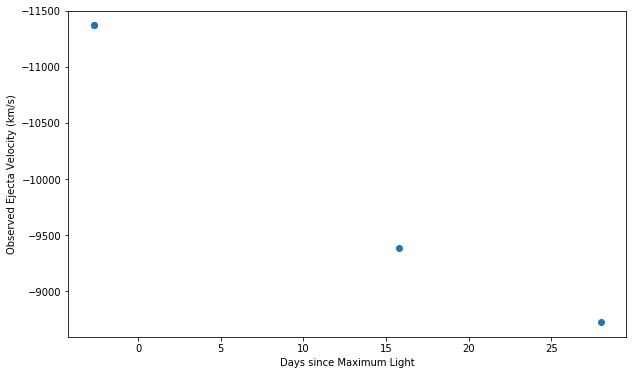

2007qe


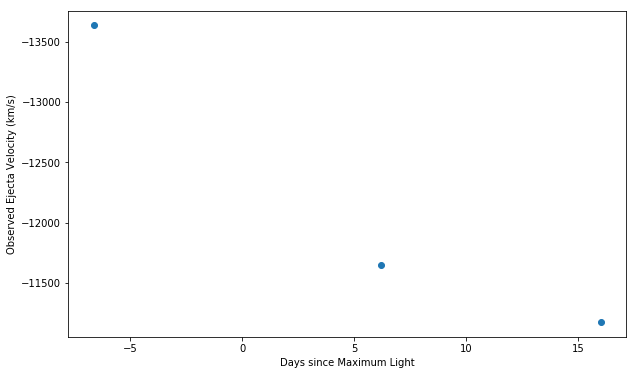

2007r


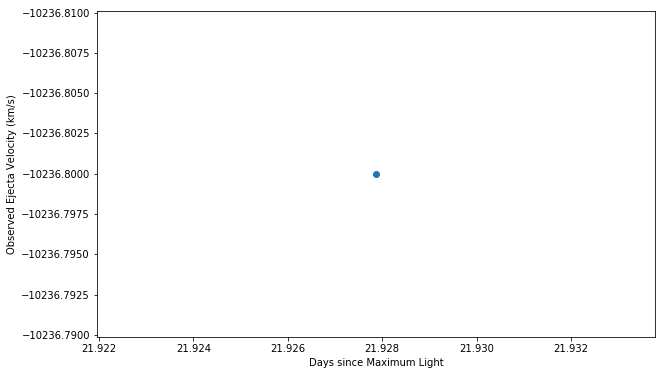

2007s


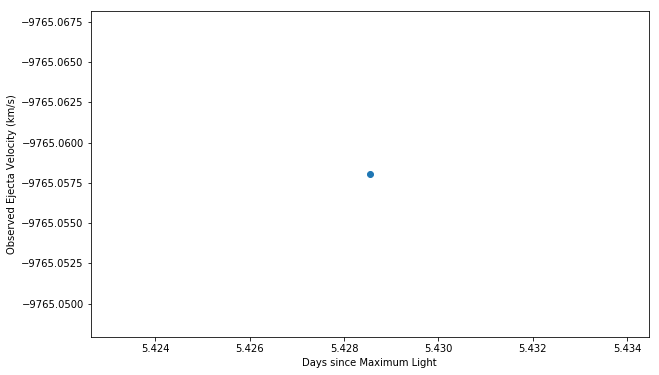

2008af


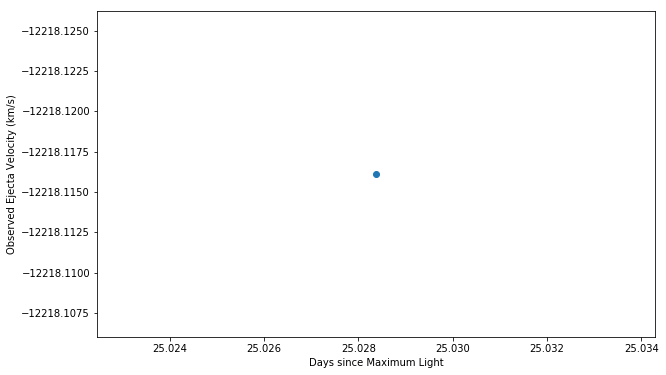

2008bf


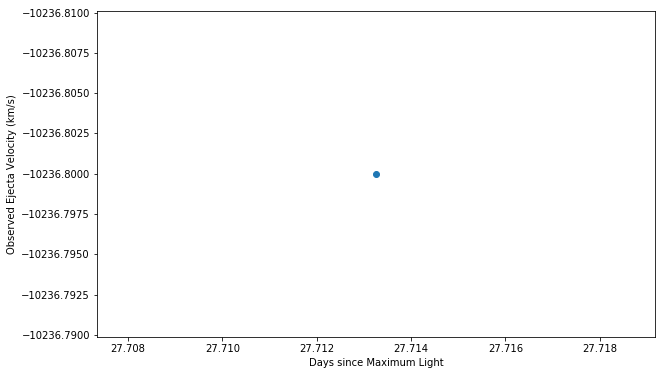

2008c


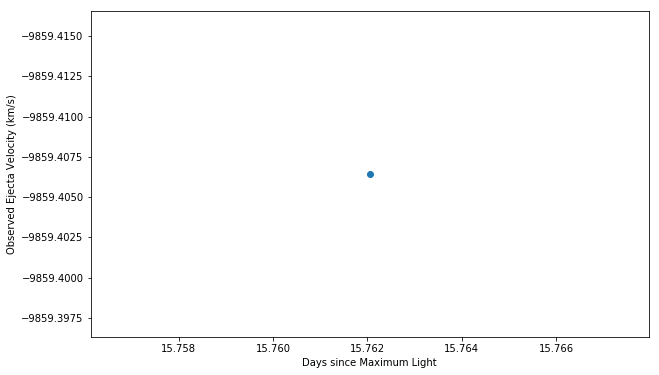

1993ac


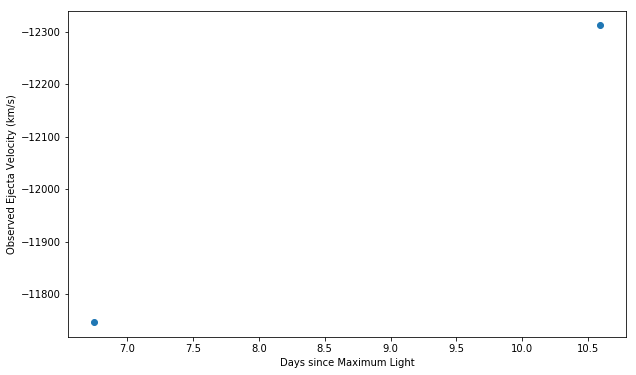

1994ae


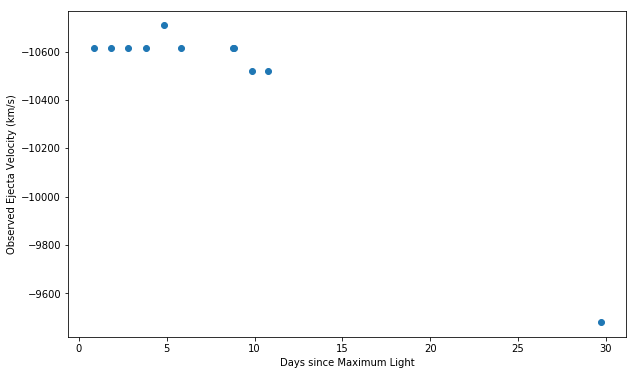

1994d


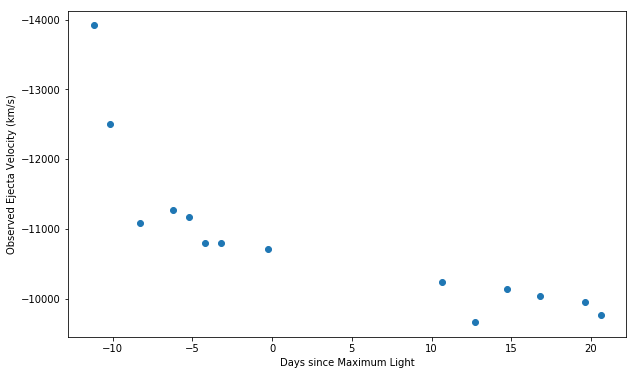

1994m


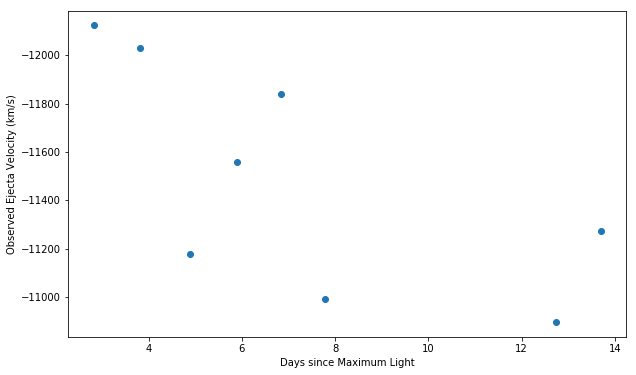

1994q


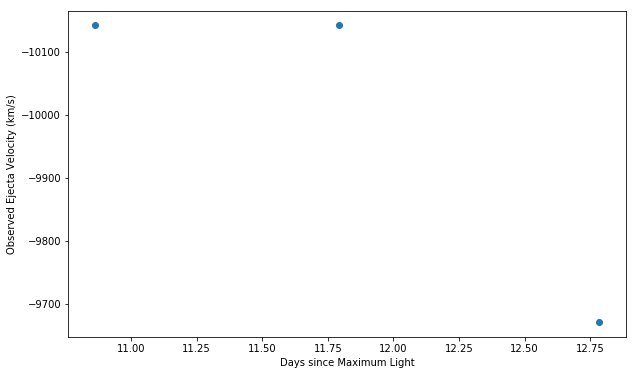

1994s


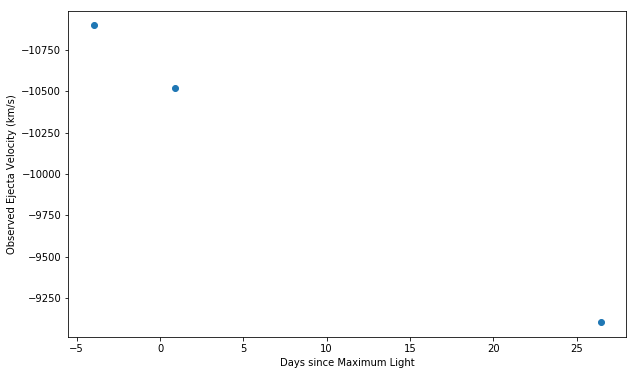

1994t


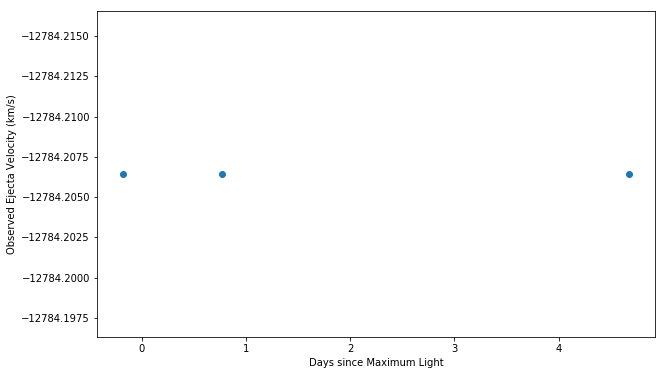

1995ac


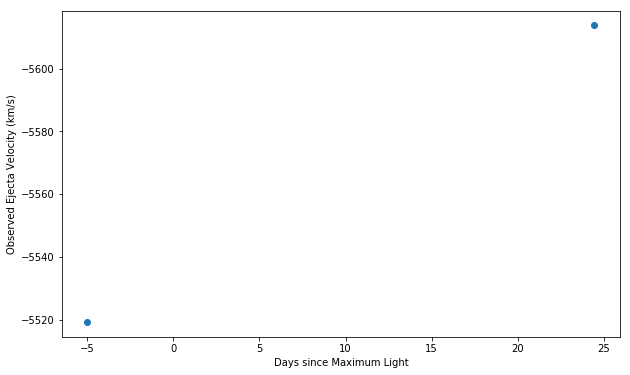

1995ak


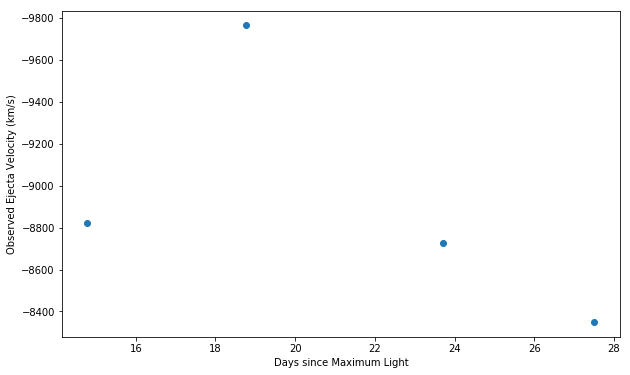

1995al


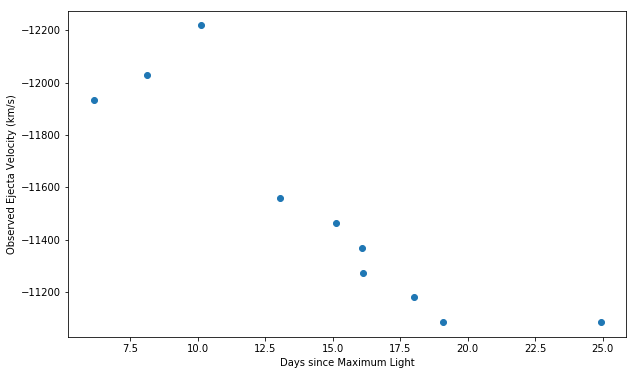

1995bd


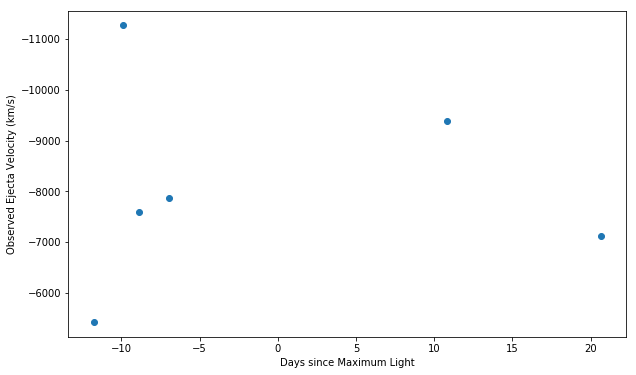

1995d


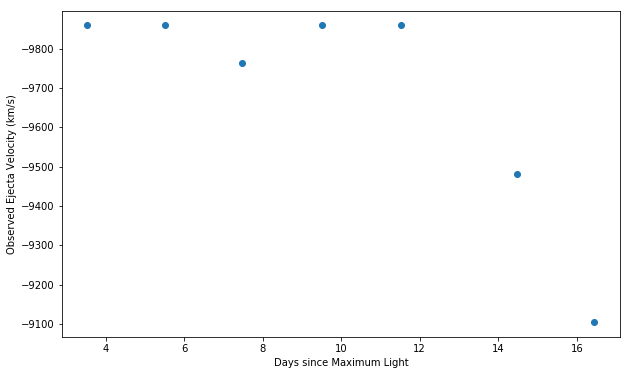

1995e


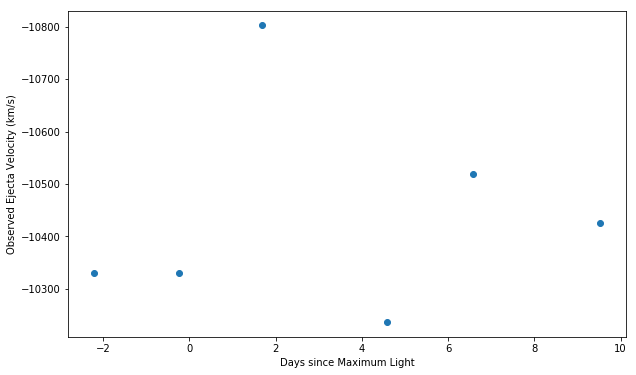

1996ab


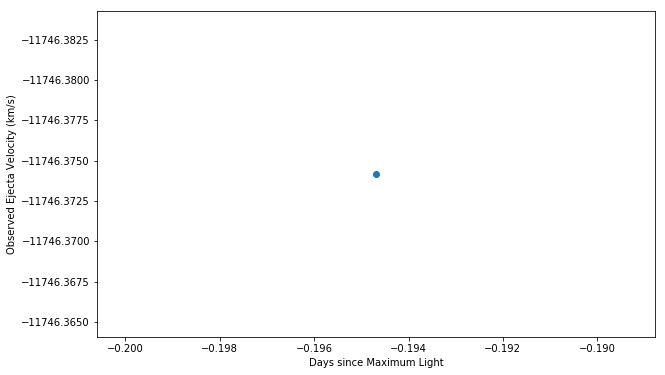

1996ai


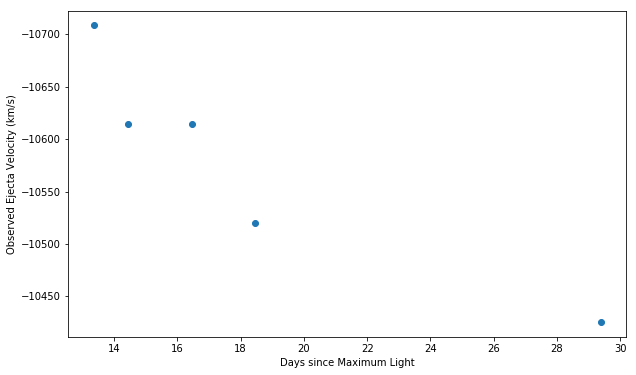

1996bl


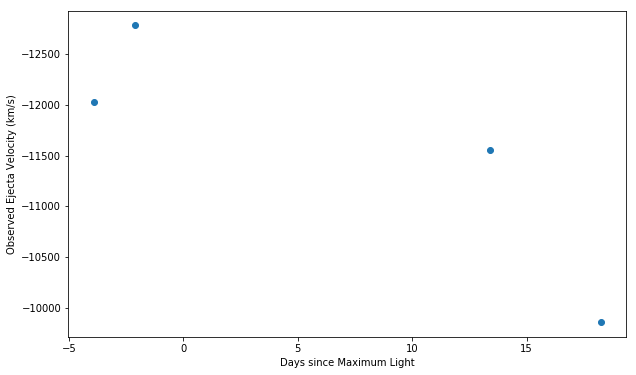

1996bo


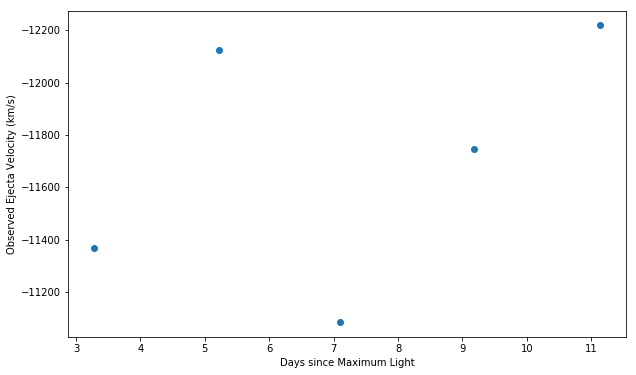

1996c


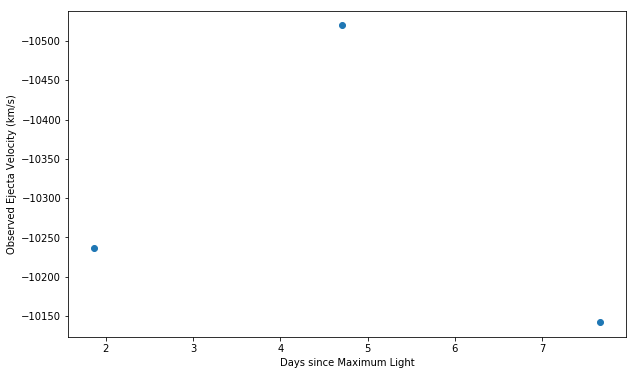

1996x


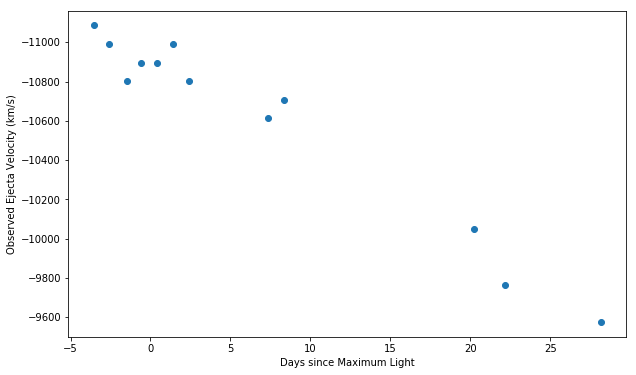

1996z


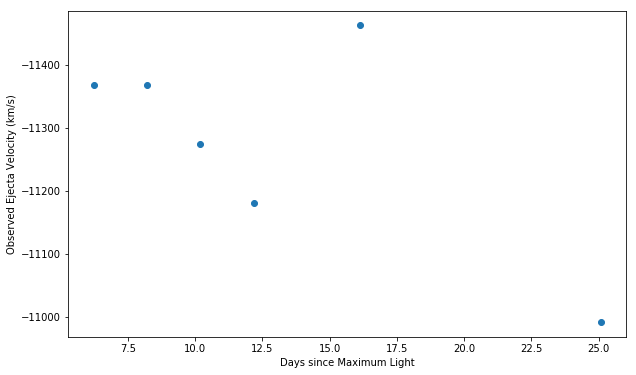

1997bp


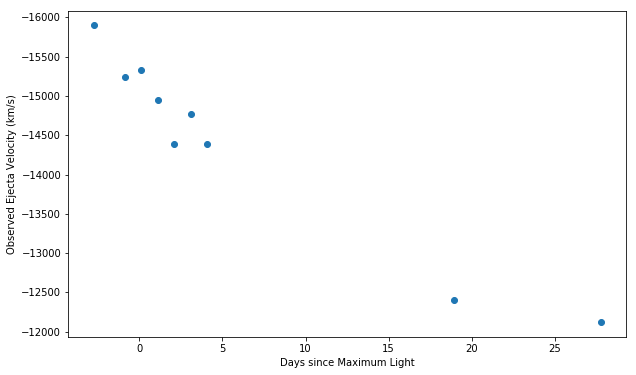

1997bq


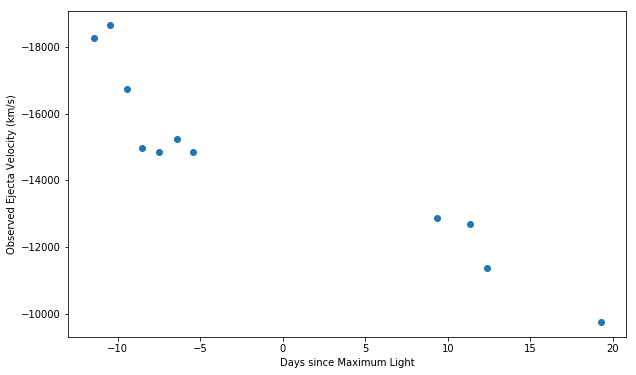

1997br


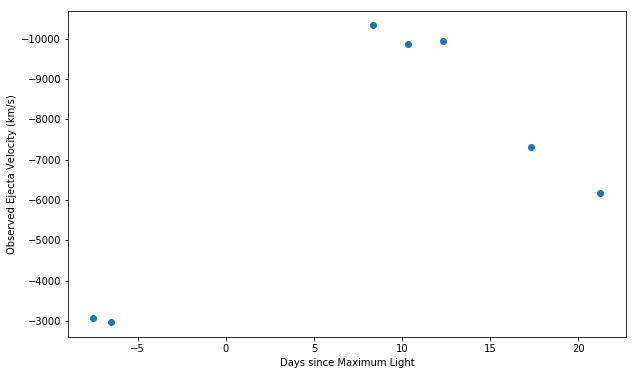

1997cn


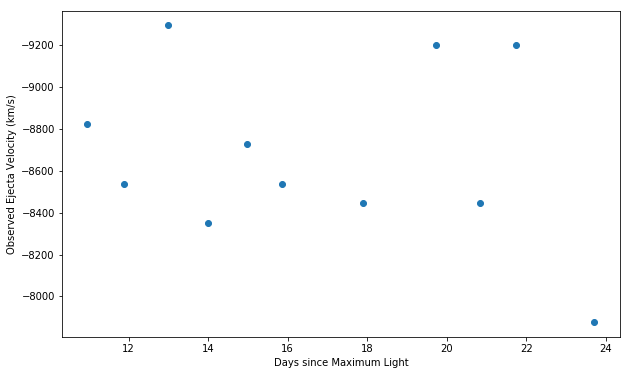

1997do


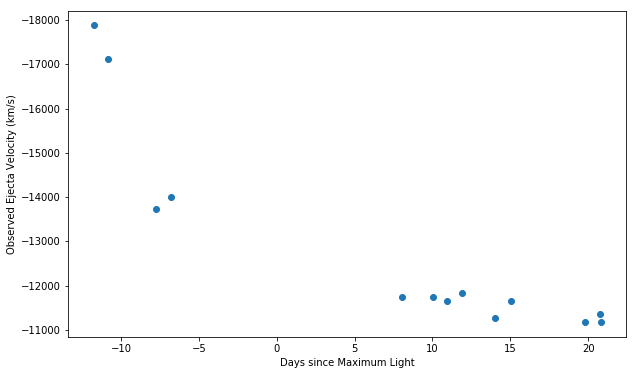

1997dt


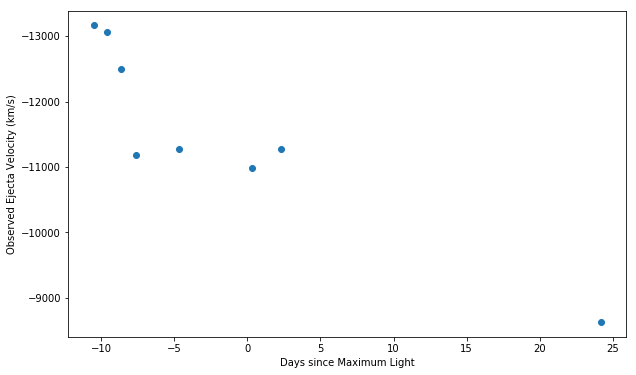

1997e


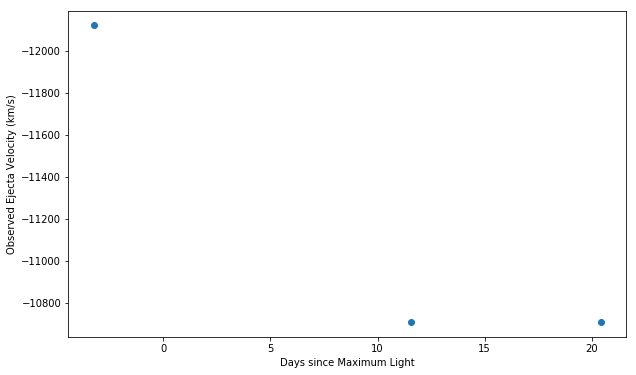

1997y


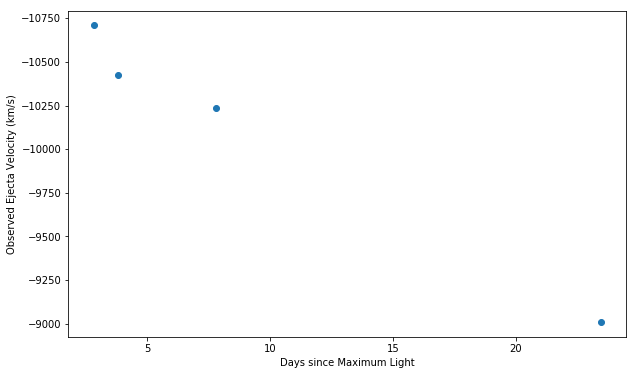

1998ab


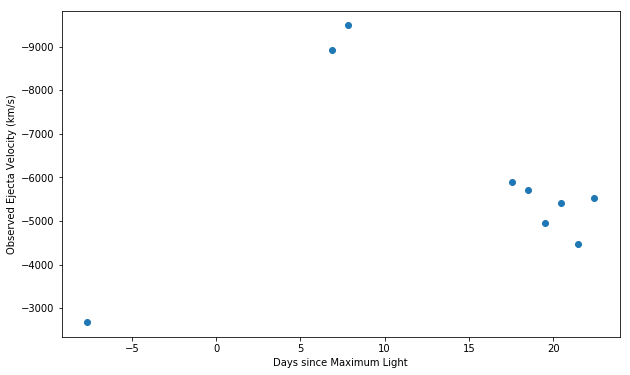

1998aq


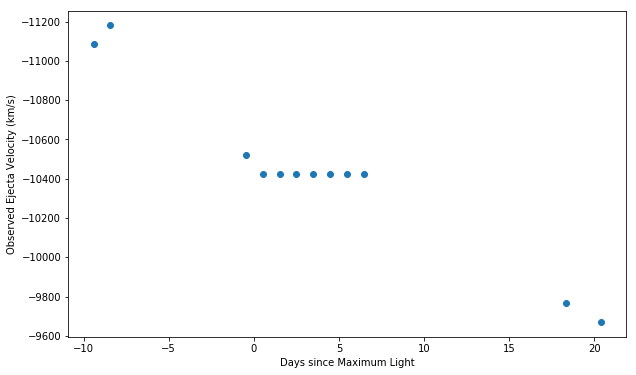

1998bp


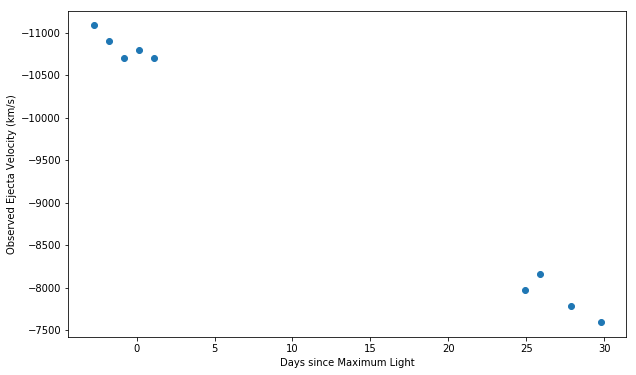

1998bu


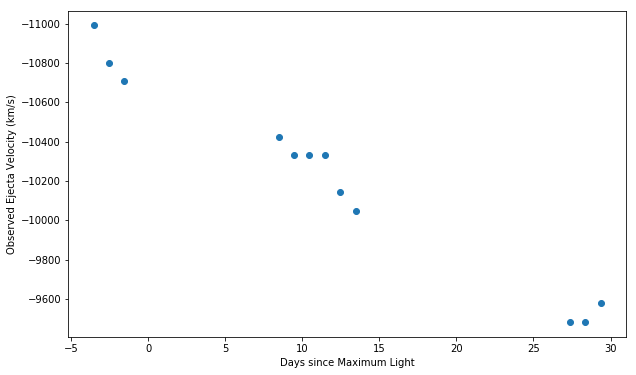

1998co


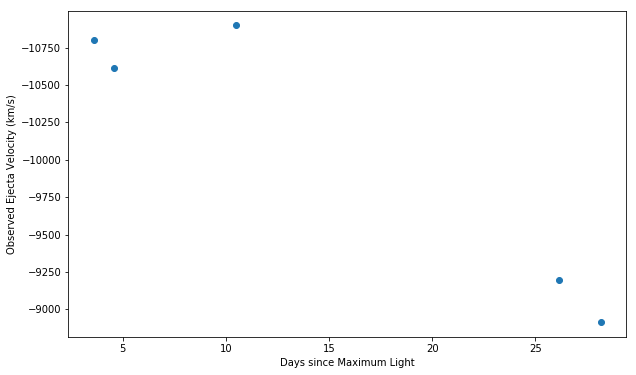

1998de


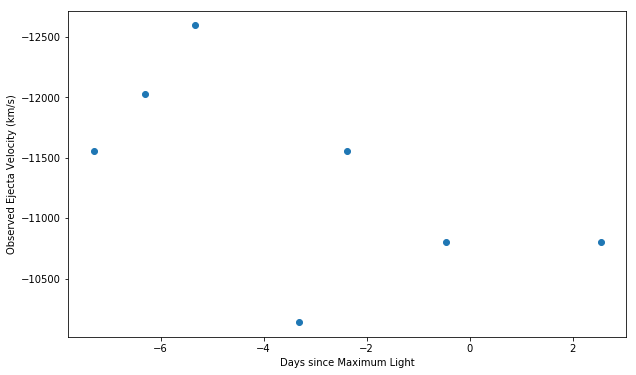

1998dh


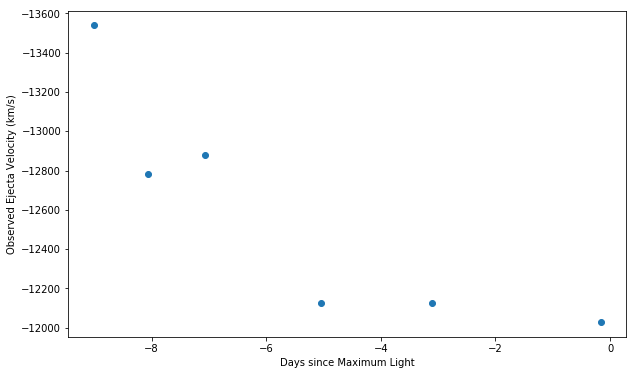

1998dk


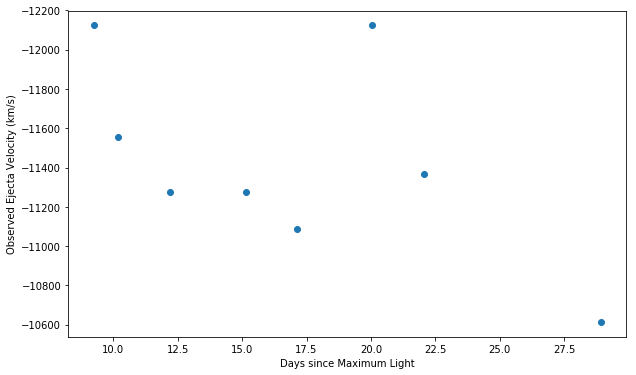

1998dm


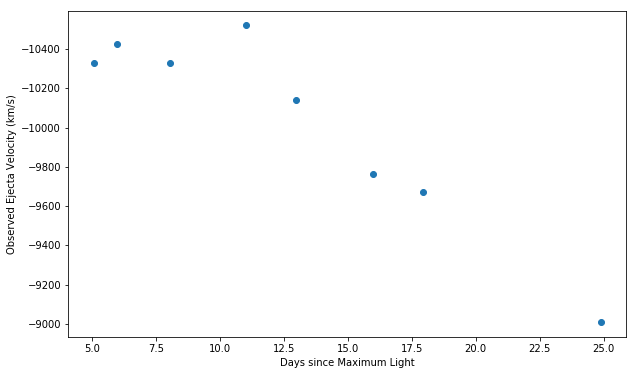

1998dx


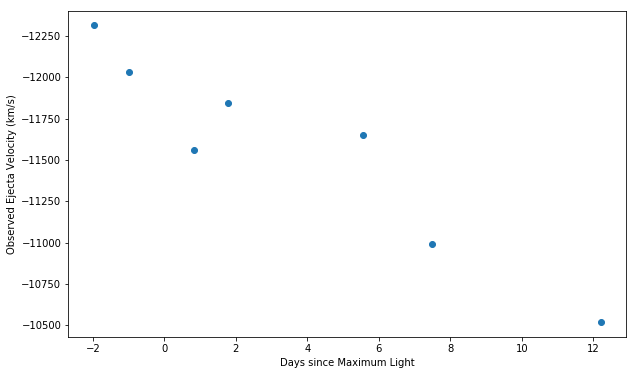

1998ec


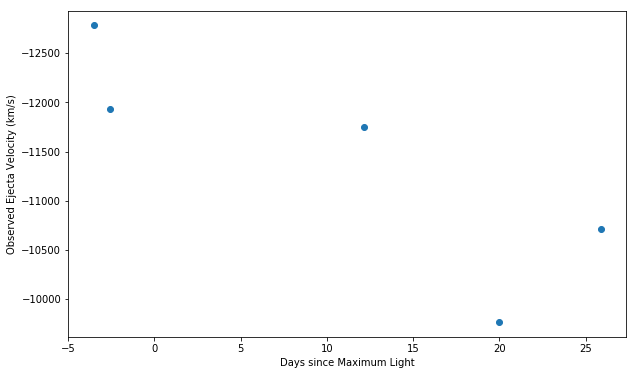

1998ef


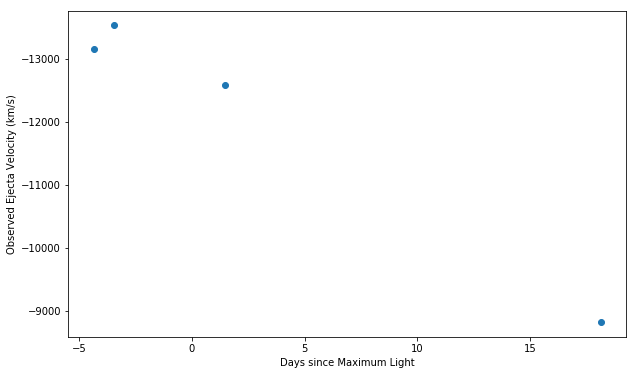

1998eg


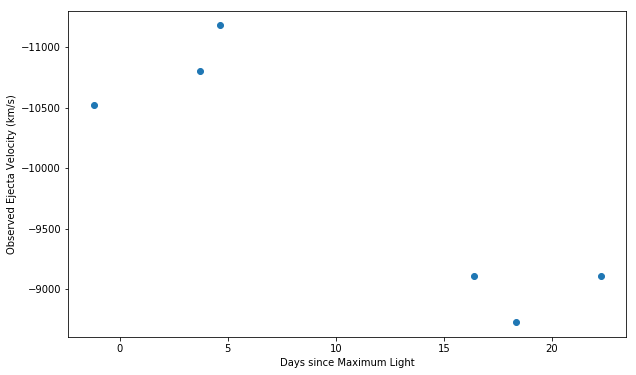

1998es


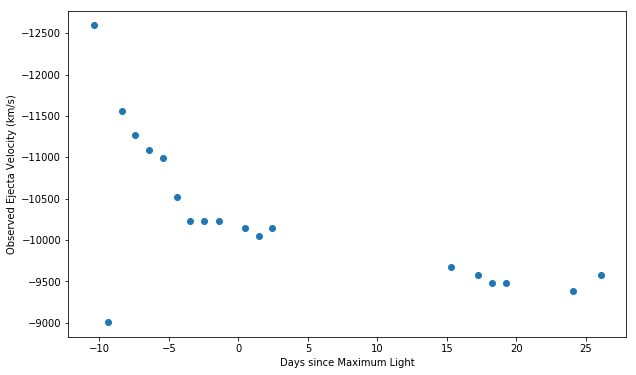

1998v


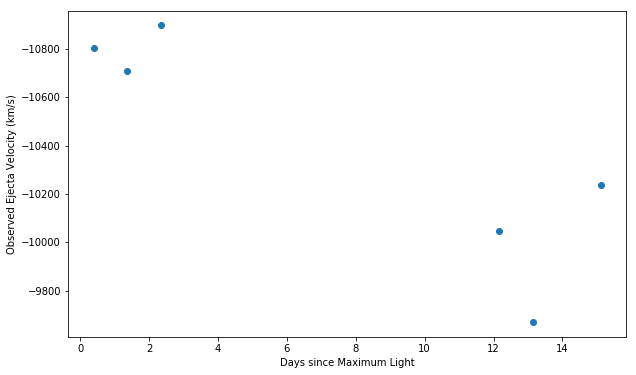

1999aa


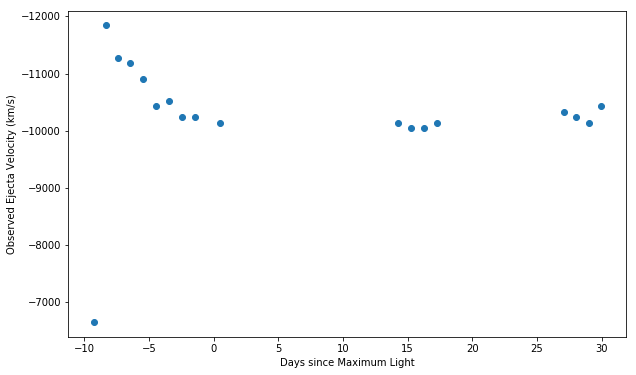

1999ac


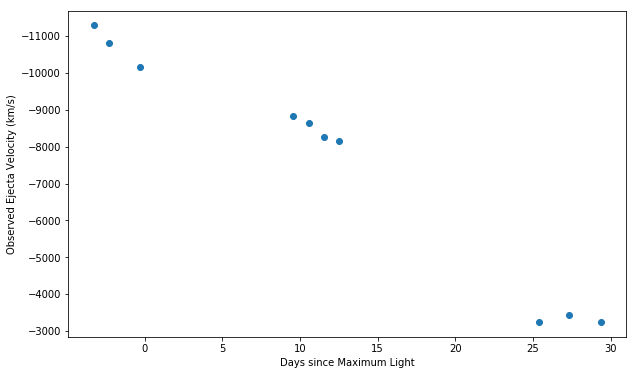

1999by


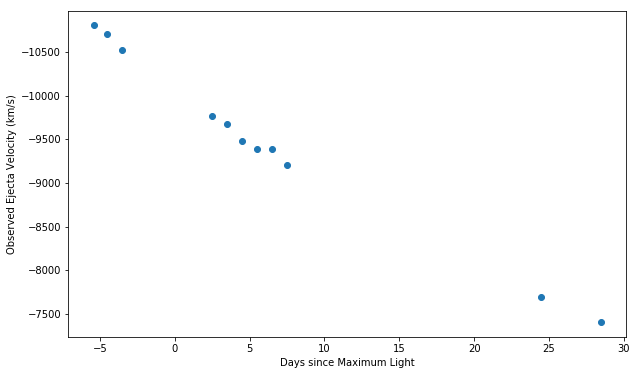

1999cc


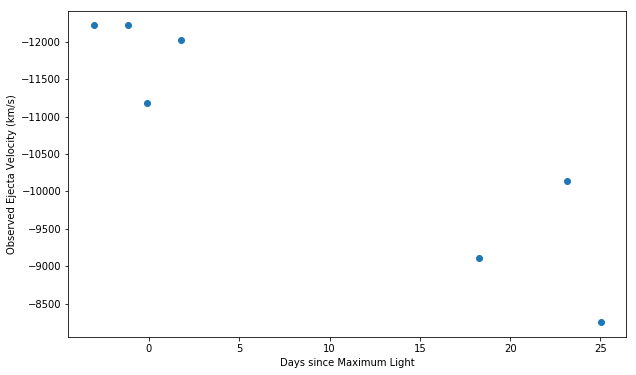

1999cl


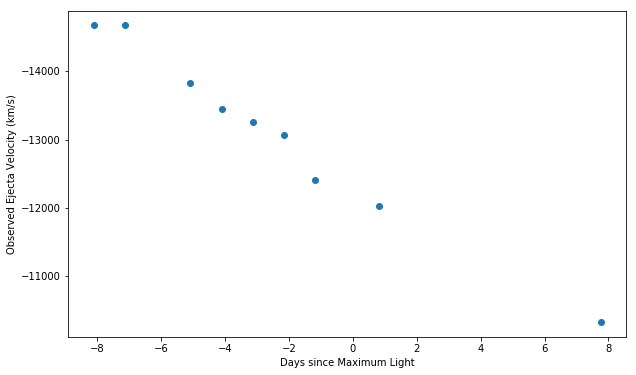

1999cp


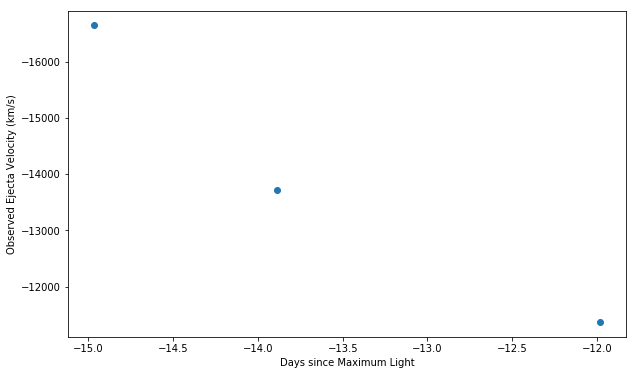

1999cw


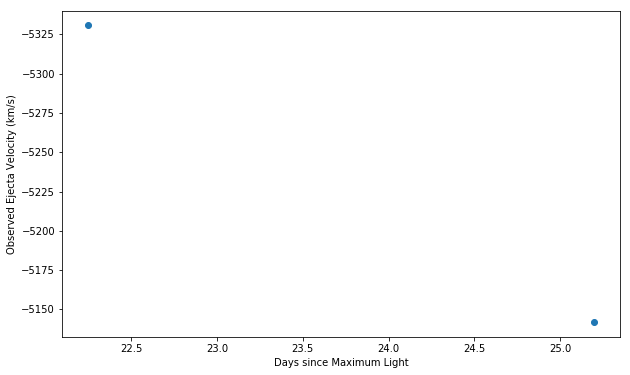

1999da


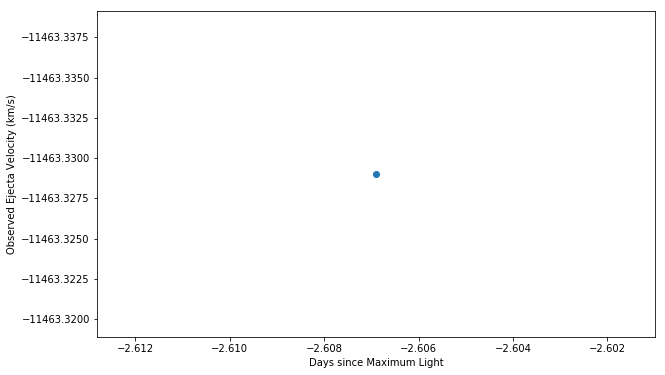

1999dq


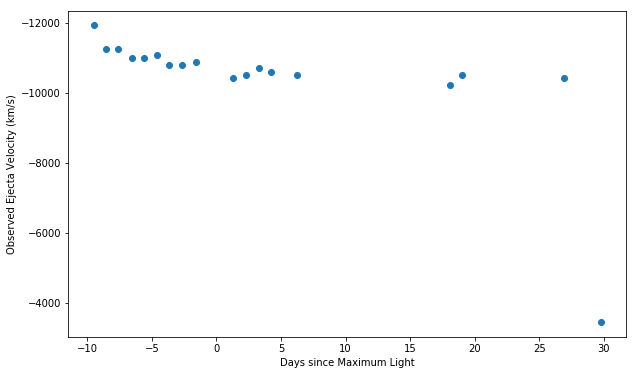

1999ef


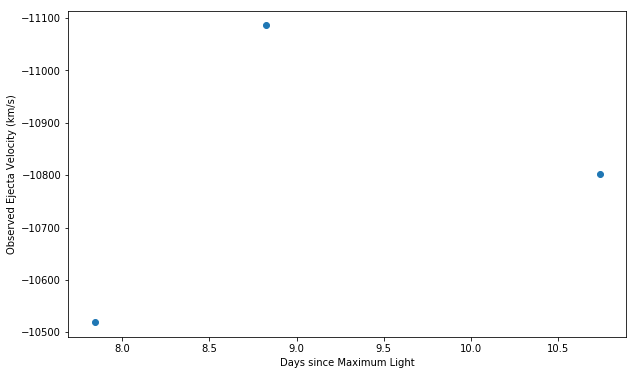

1999ej


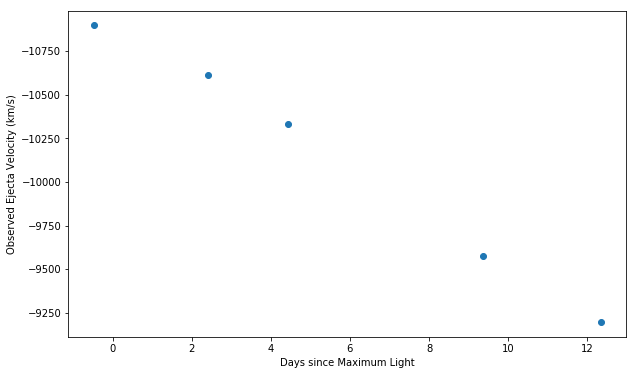

1999ek


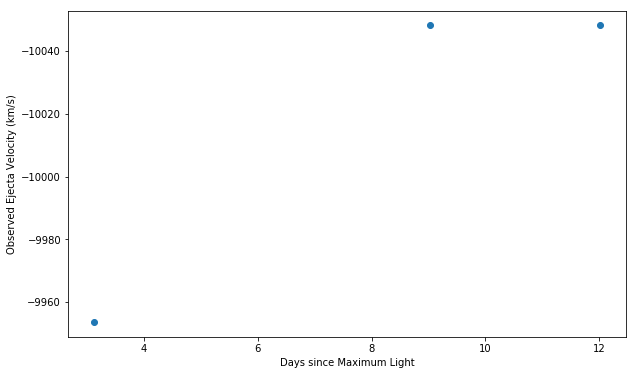

1999gd


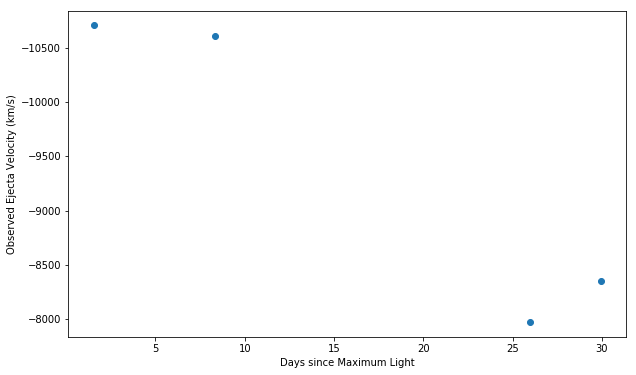

1999gh


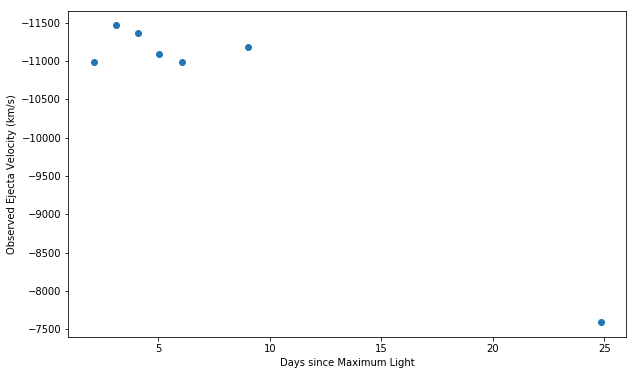

1999gp


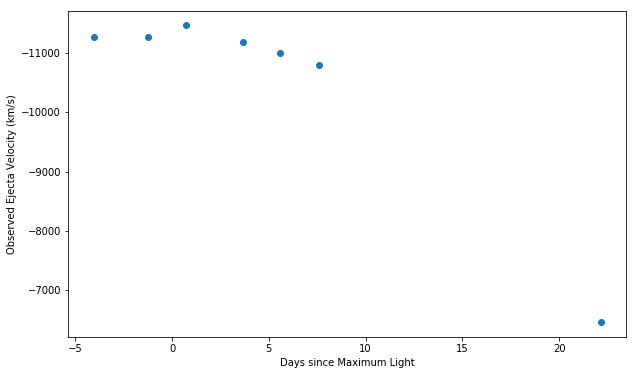

1999x


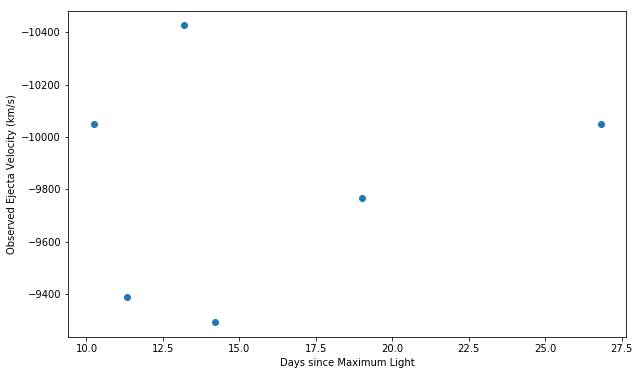

2000b


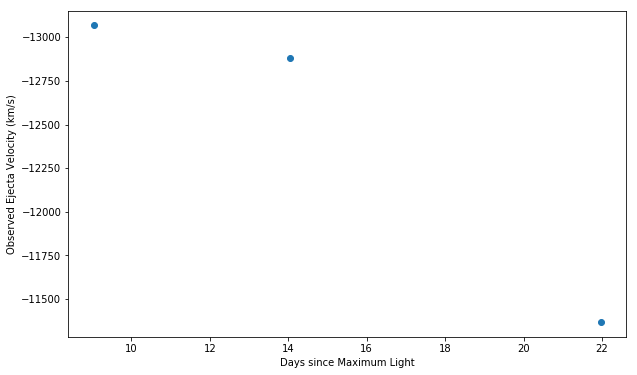

2000bh


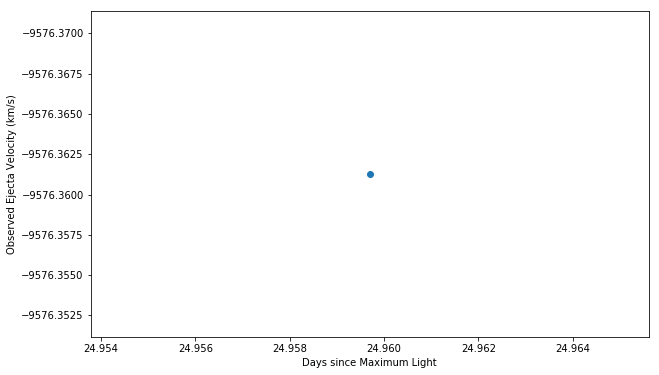

2000bk


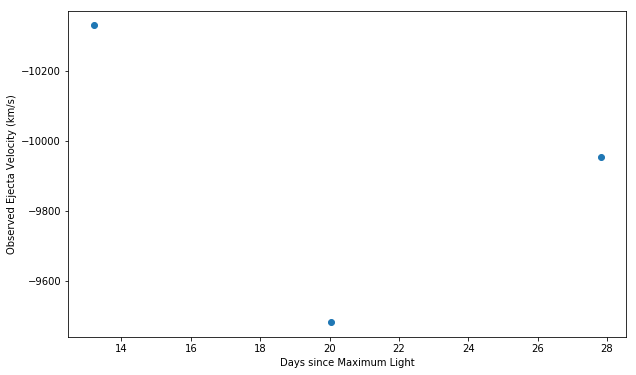

2000ce


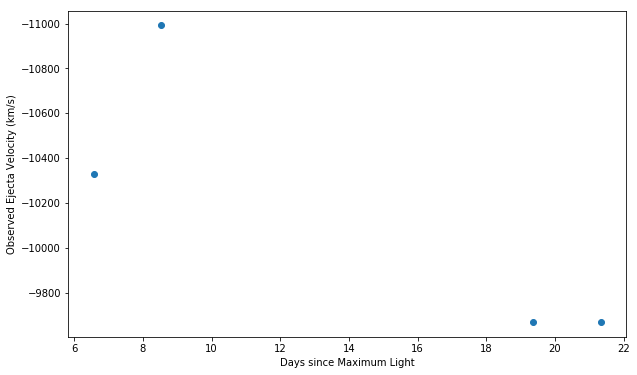

2000cf


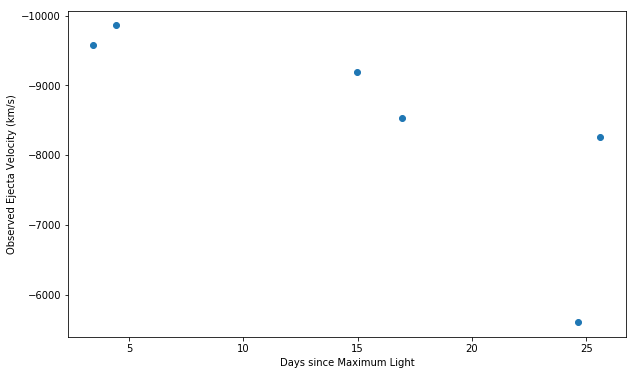

2000cn


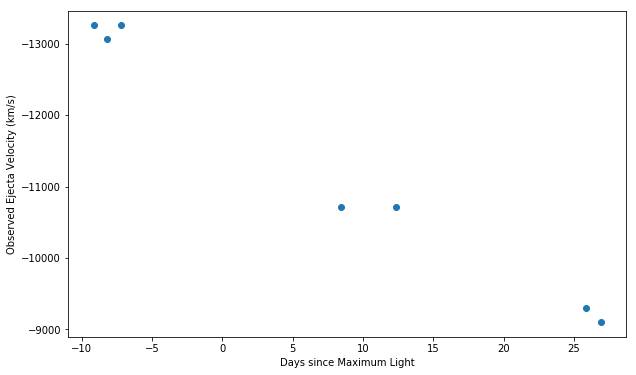

2000dk


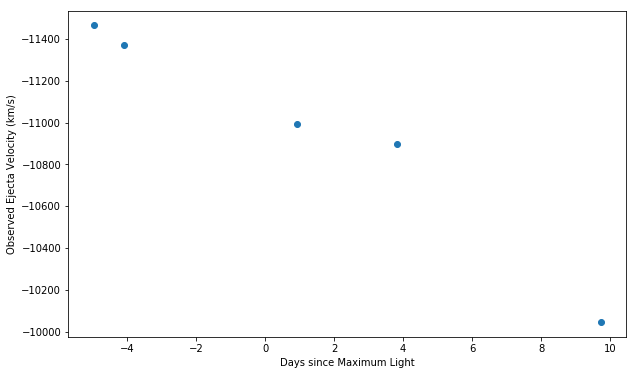

2000fa


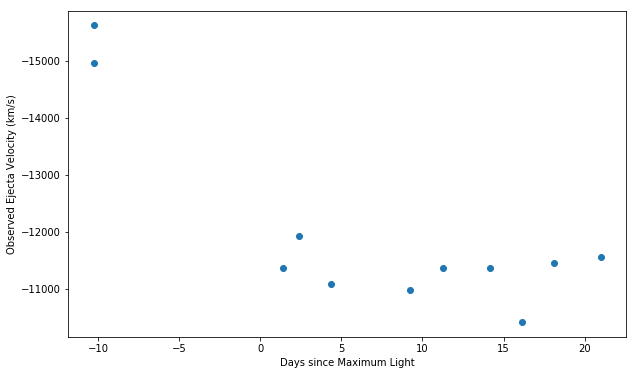

2001ah


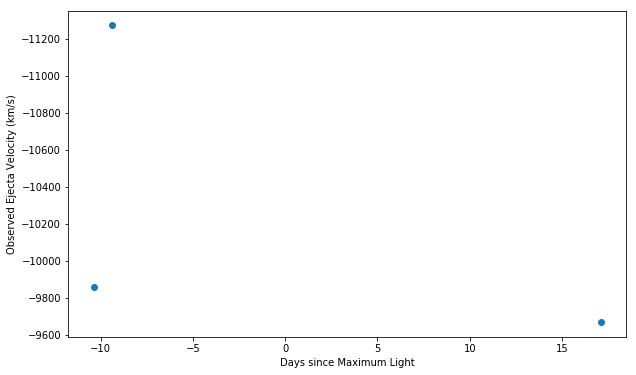

2001ay


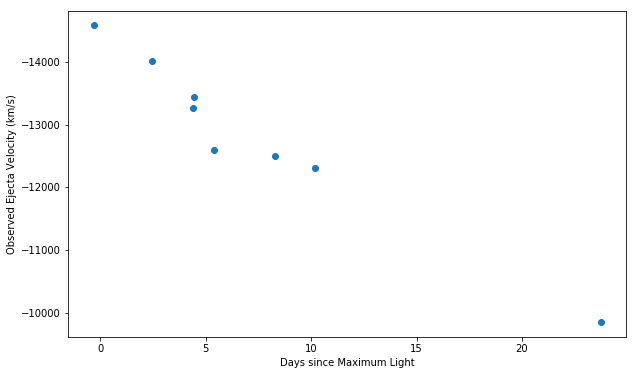

2001az


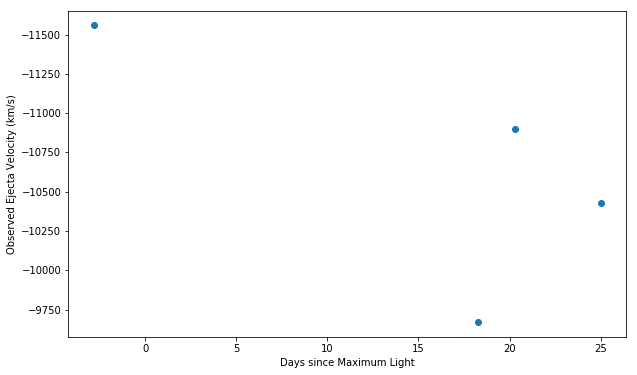

2001bf


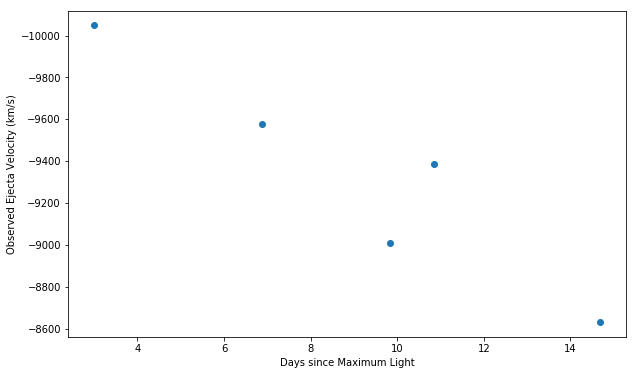

2001cp


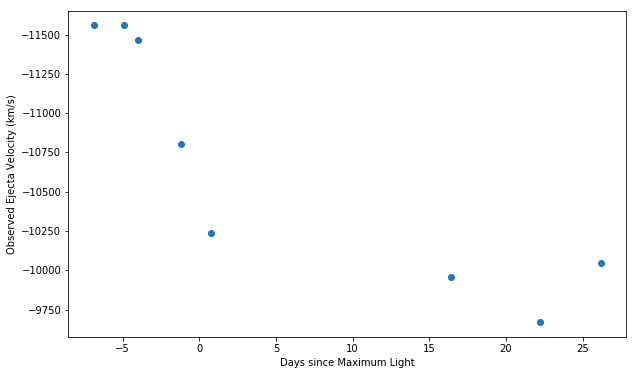

2001da


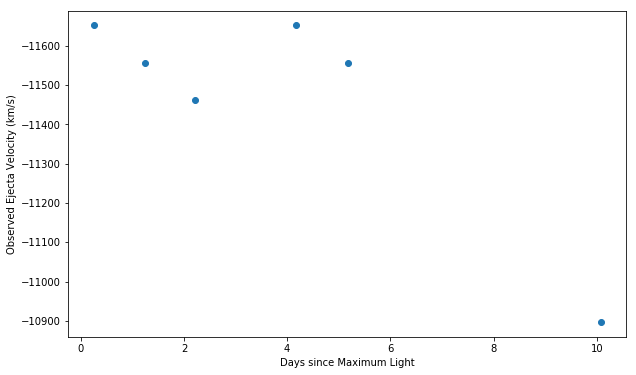

2001eh


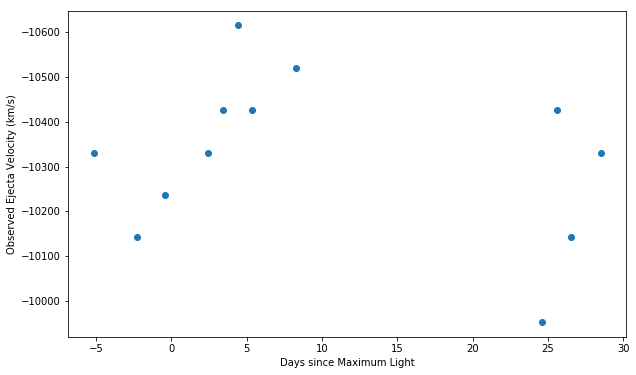

2001en


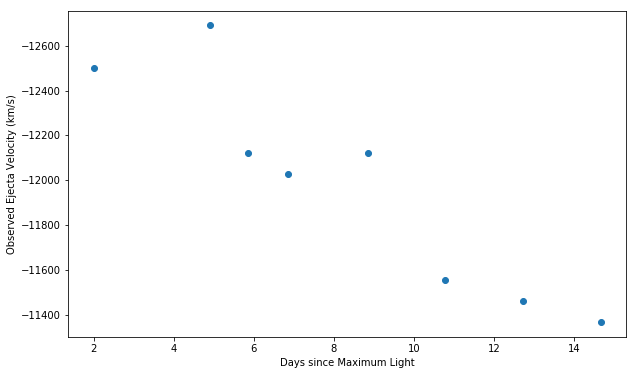

2001ep


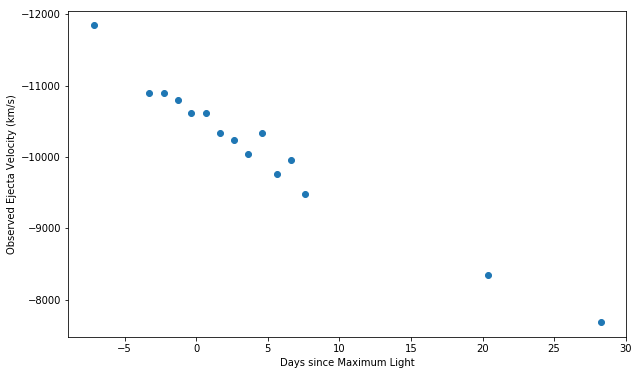

2001fe


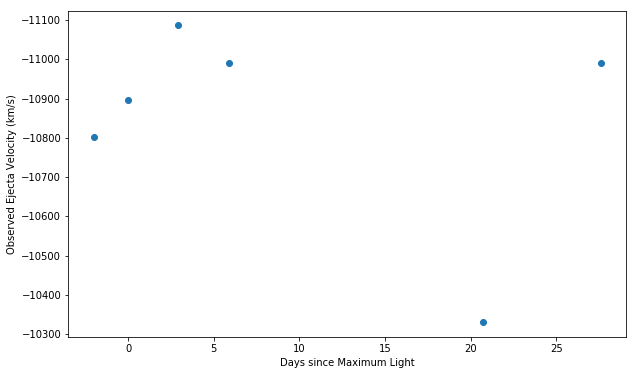

2001fh


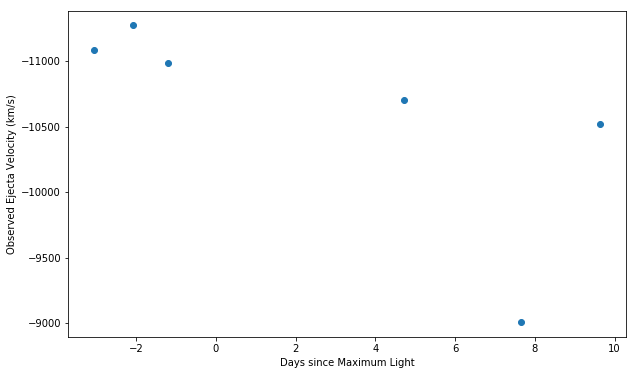

2001g


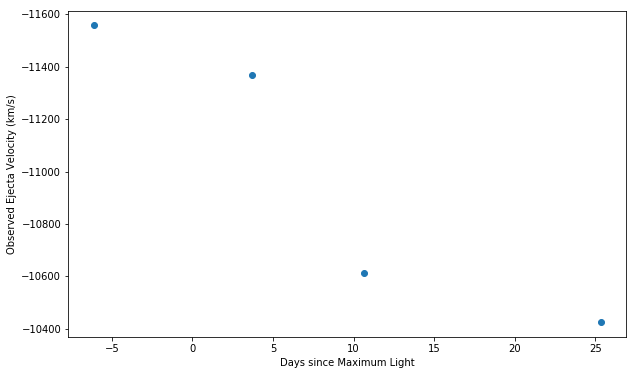

2001gc


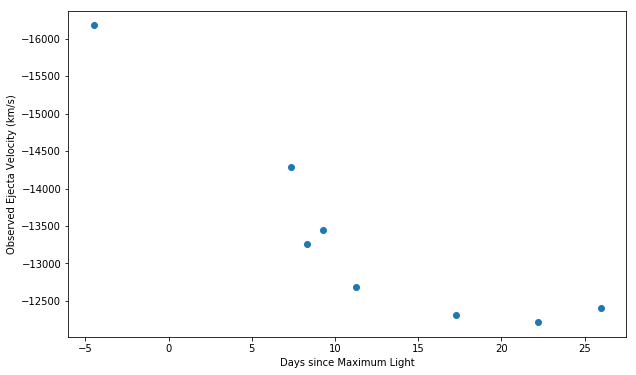

2001n


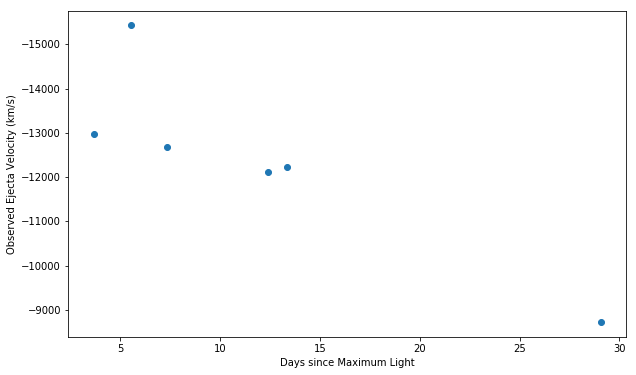

2001v


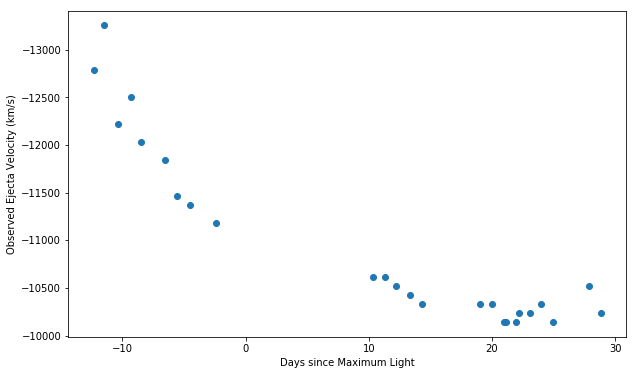

2002bf


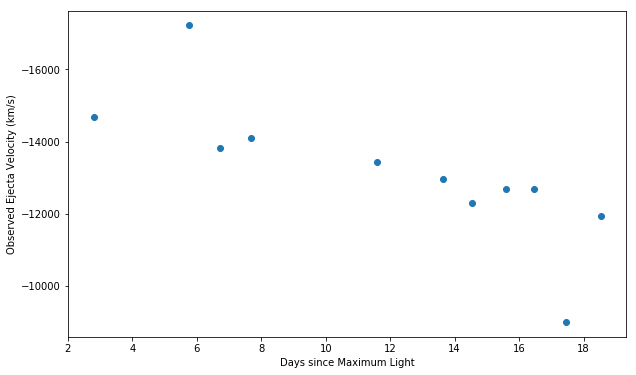

2002bo


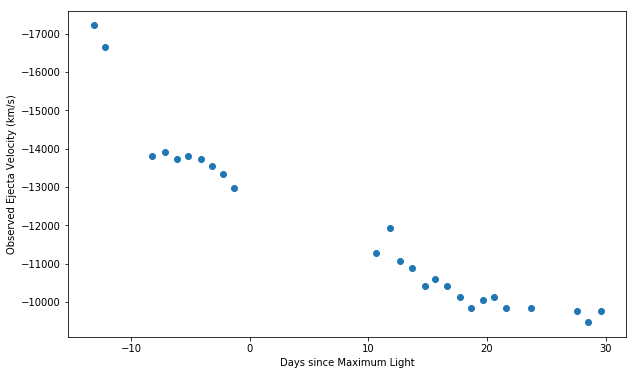

2002cd


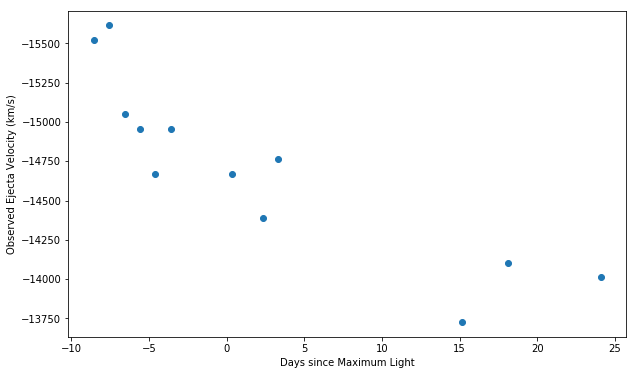

2002ck


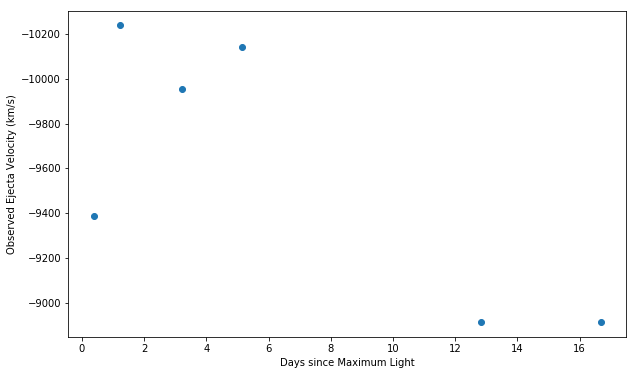

2002cr


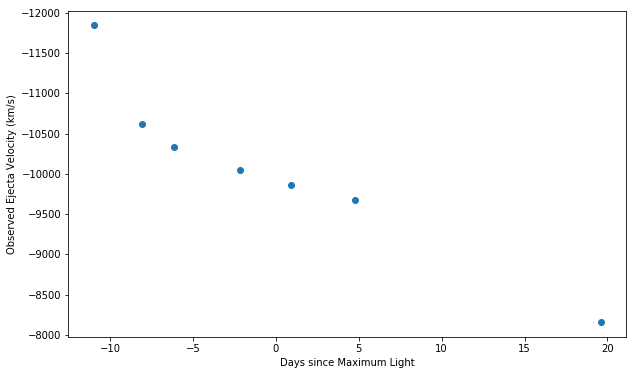

2002de


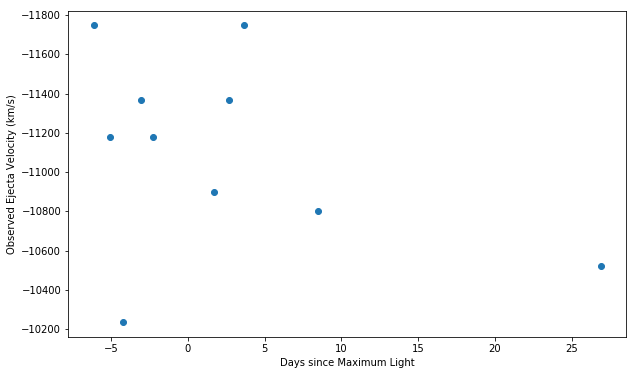

2002dj


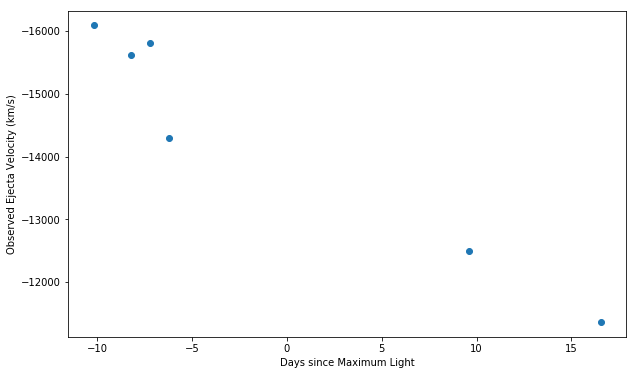

2002do


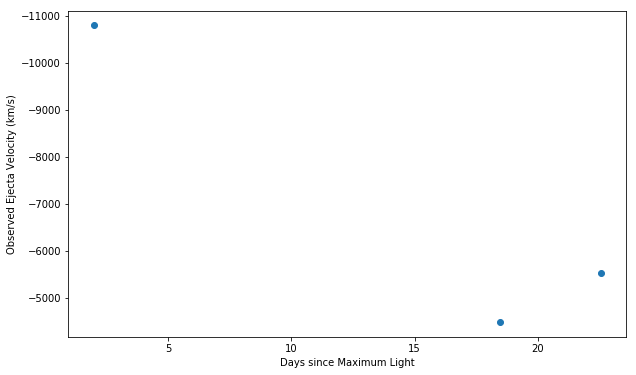

2002dp


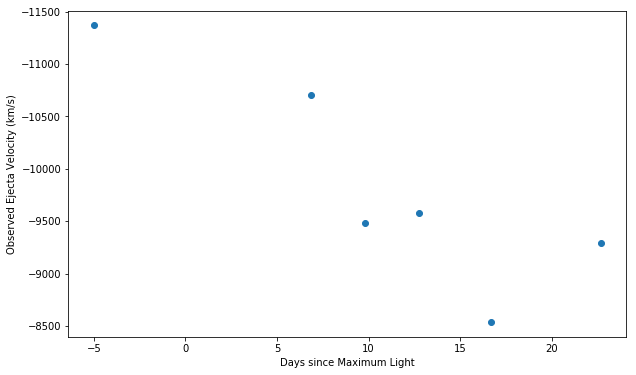

2002er


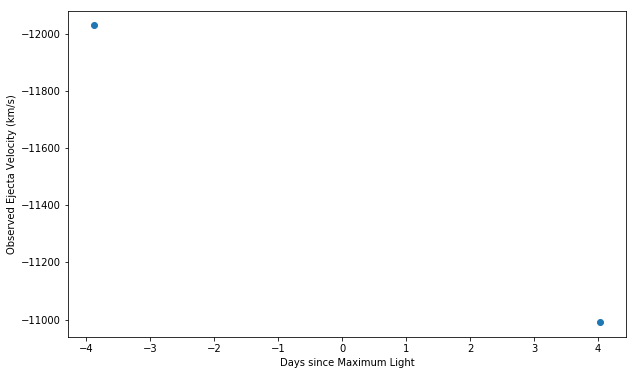

2002es


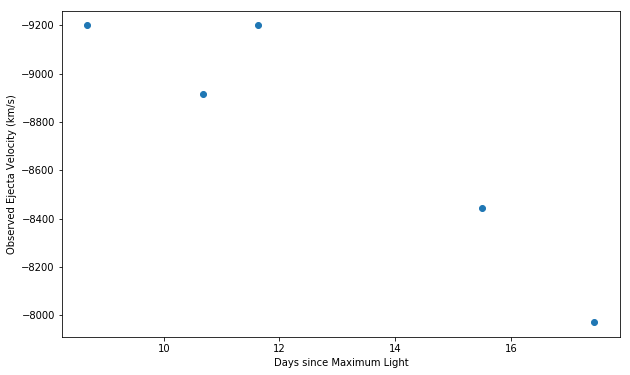

2002eu


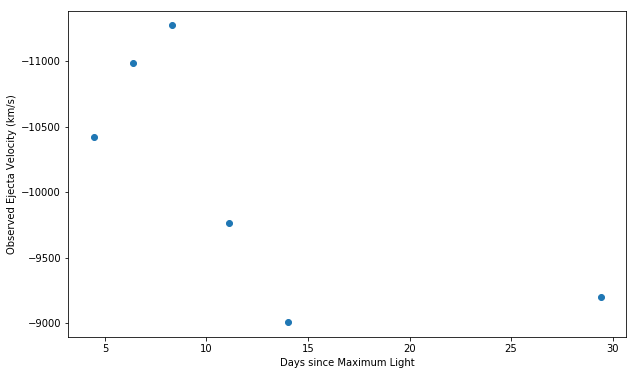

2002fb


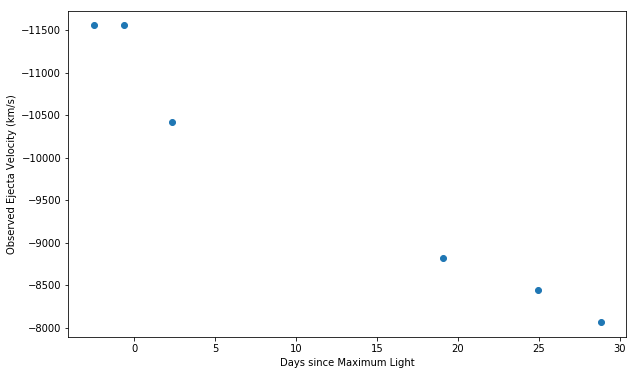

2002fk


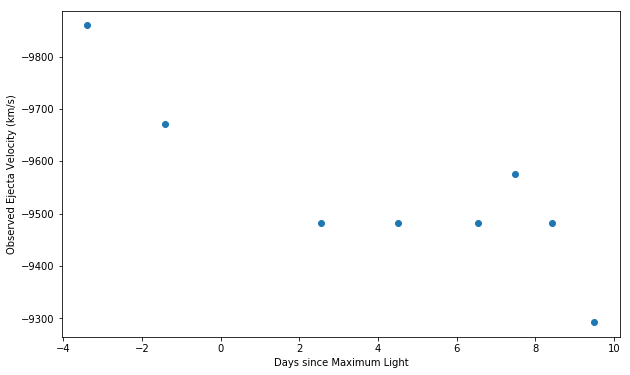

2002g


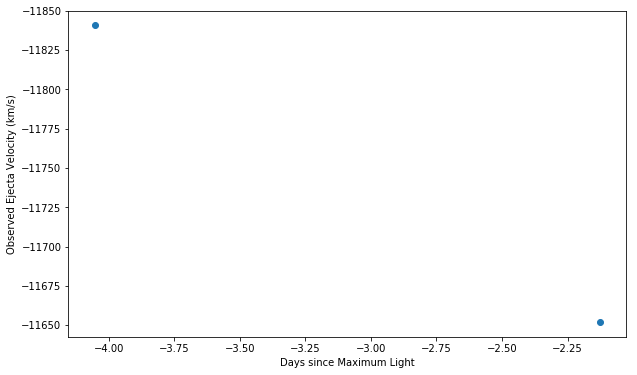

2002ha


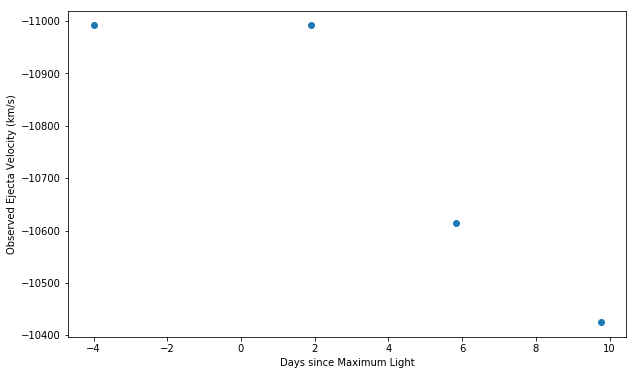

2002hd


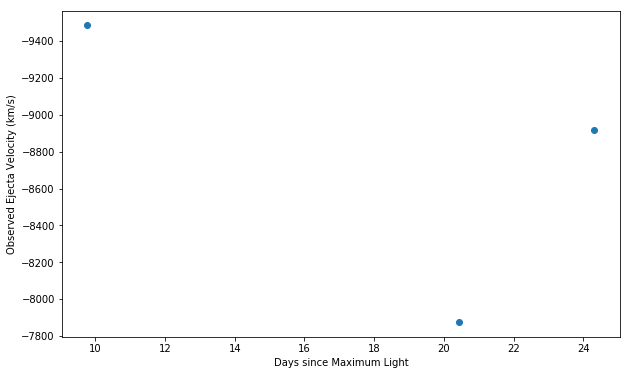

2002he


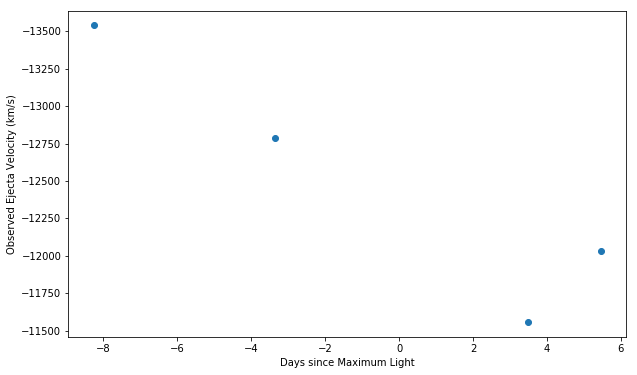

2002hu


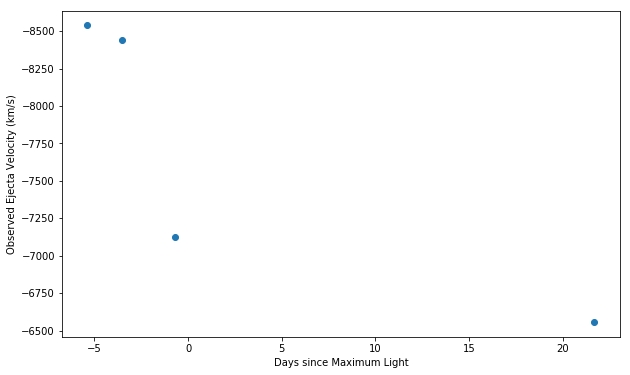

2002hw


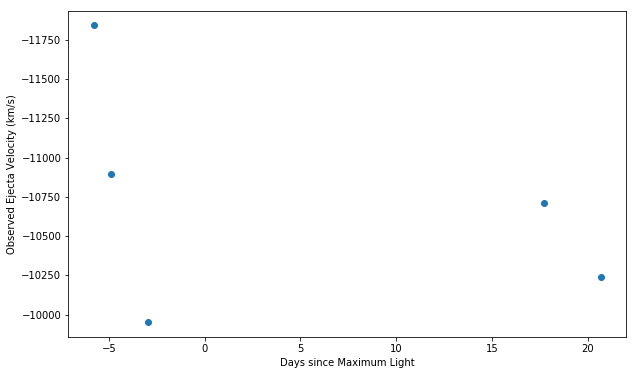

2002jy


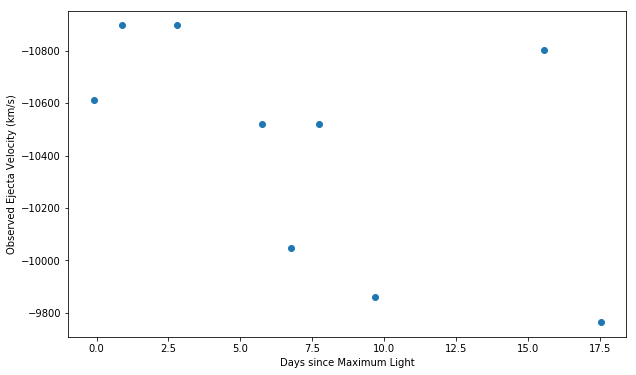

2002kf


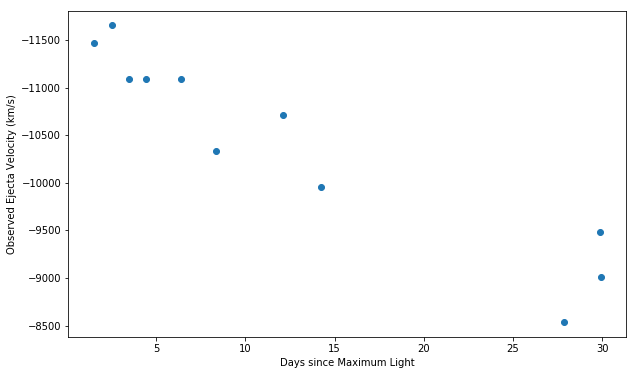

2003cg


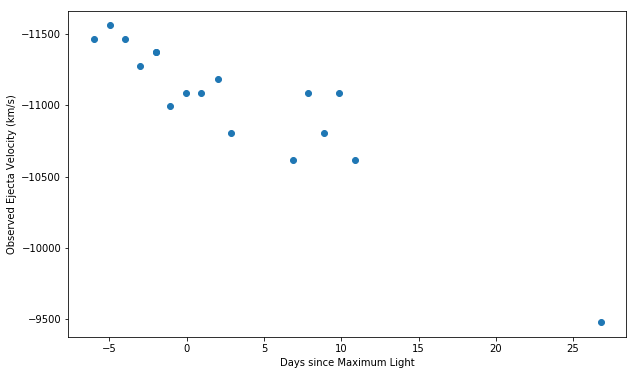

2003ch


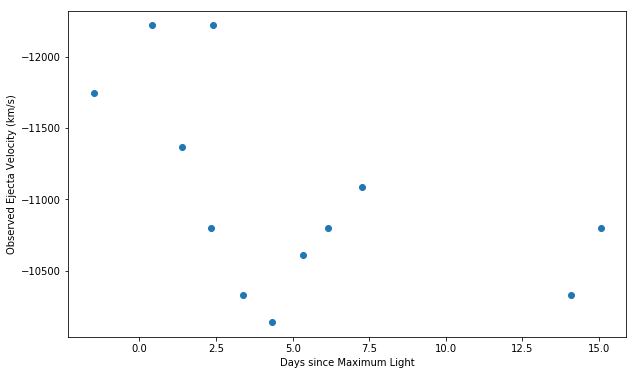

2003cq


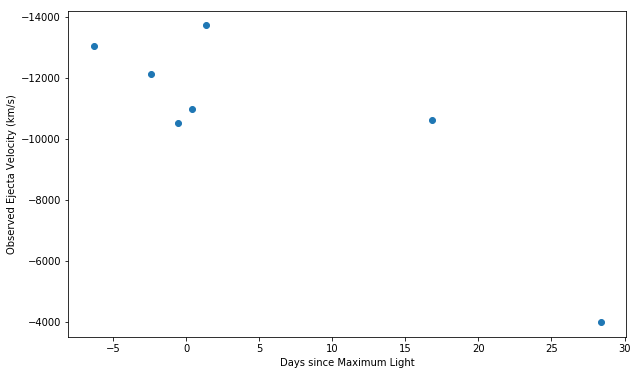

2003du


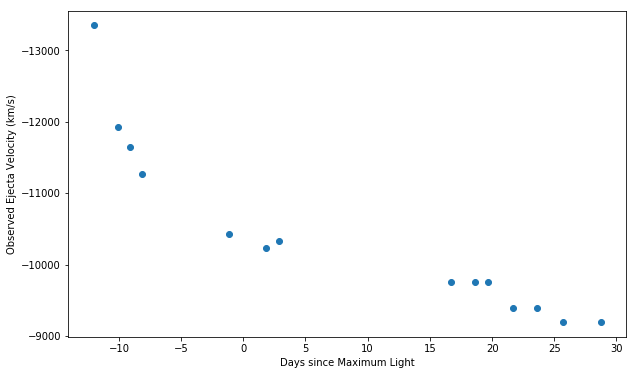

2003fa


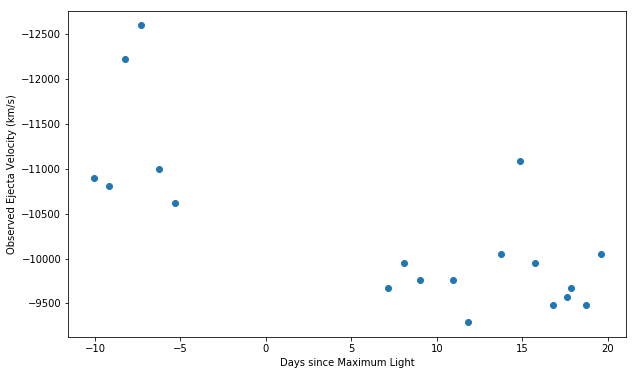

2003hu


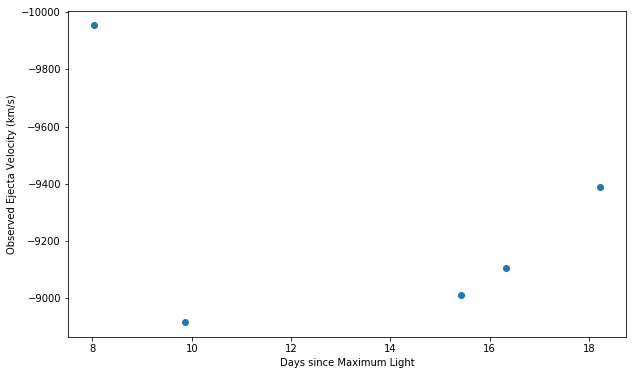

2003ic


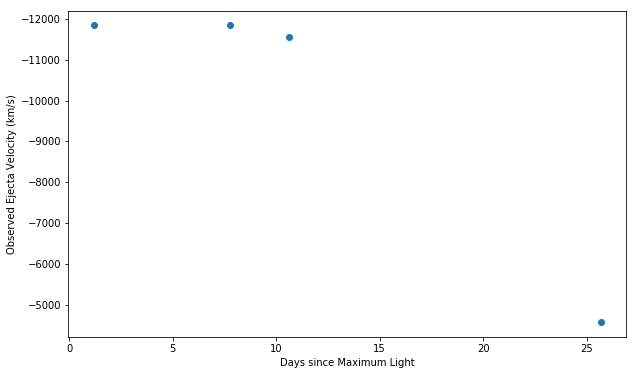

2003it


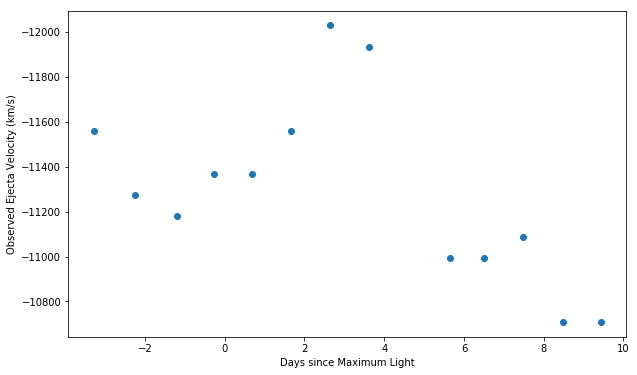

2003iv


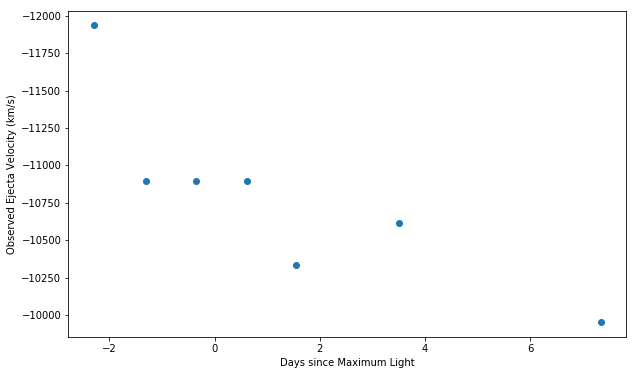

2003kc


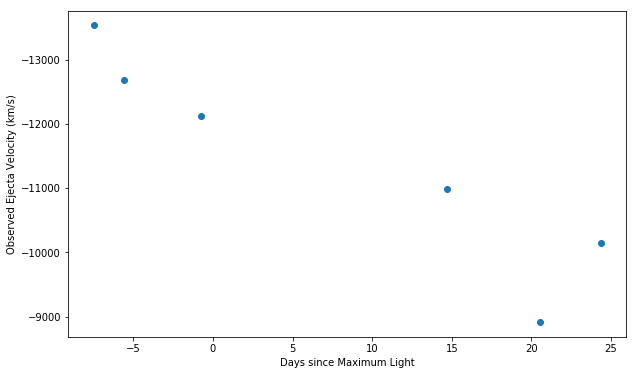

2003kf


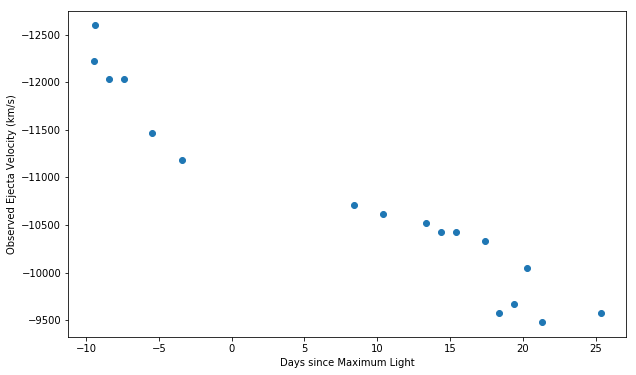

2003u


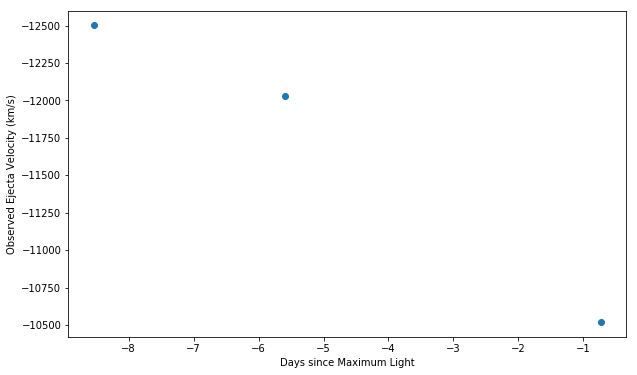

2003w


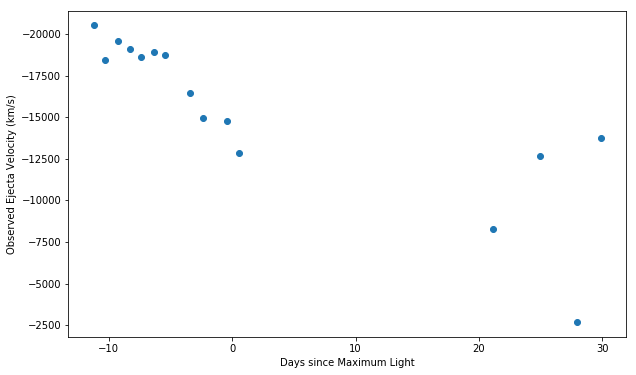

2004as


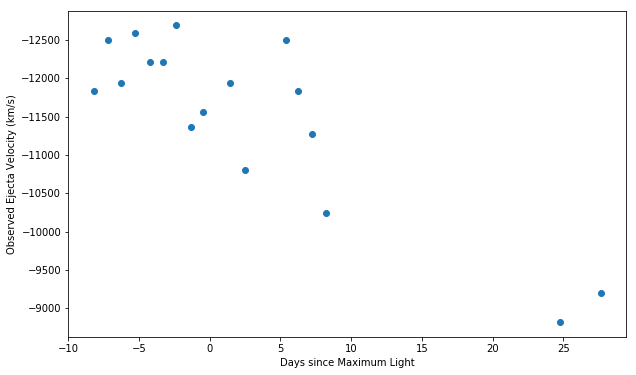

2004bg


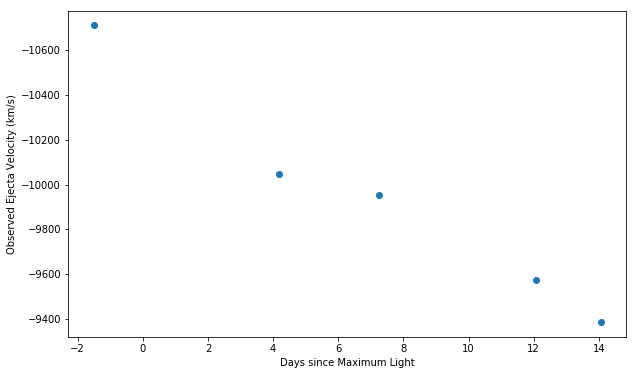

2004dt


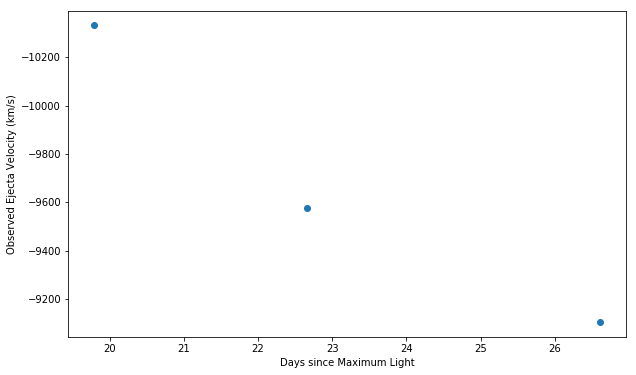

2004ef


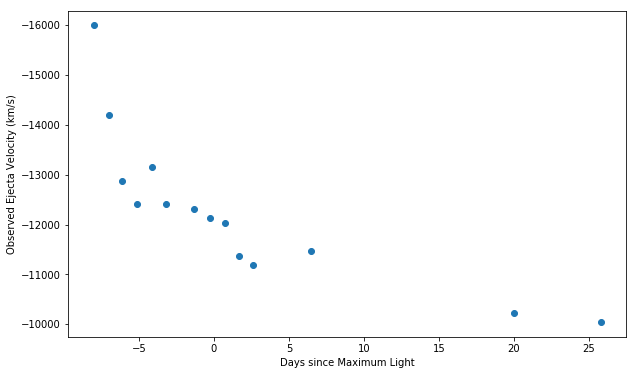

2004fu


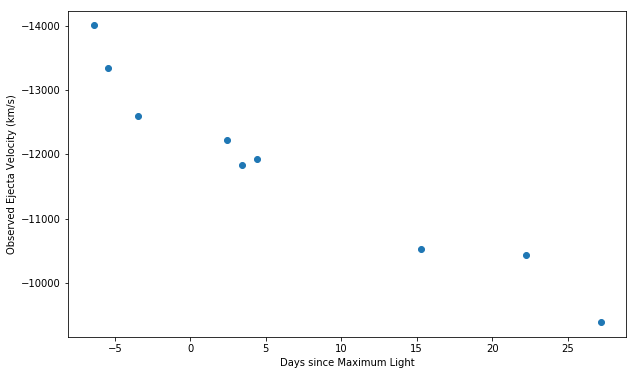

2004gc


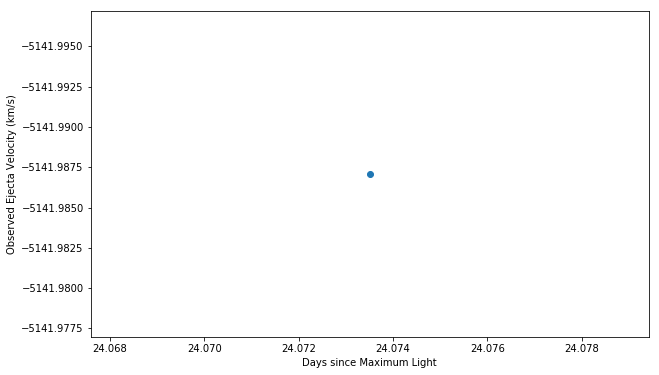

2004gs


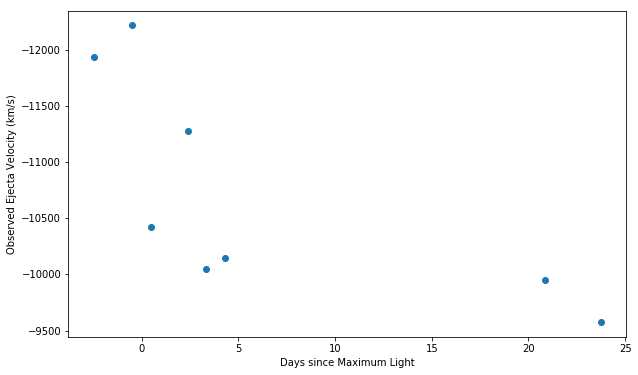

2004l


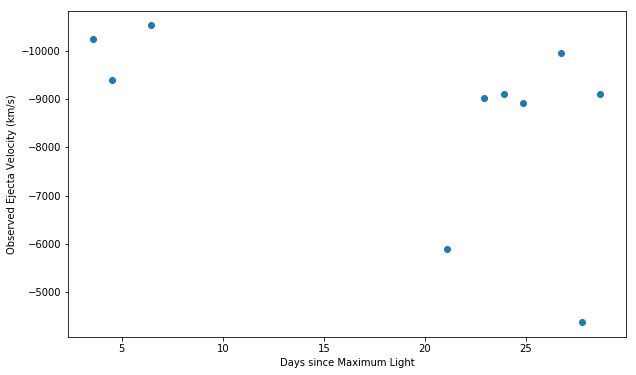

2005a


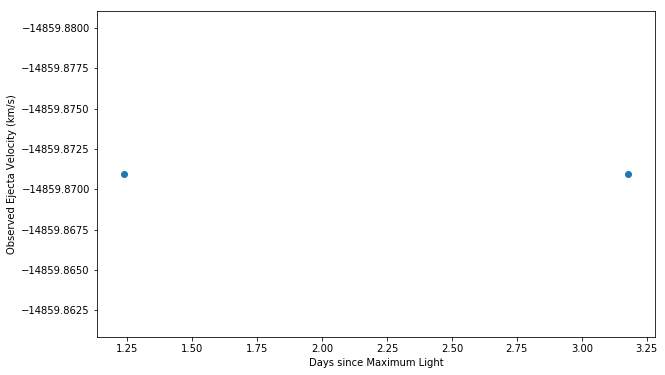

2005am


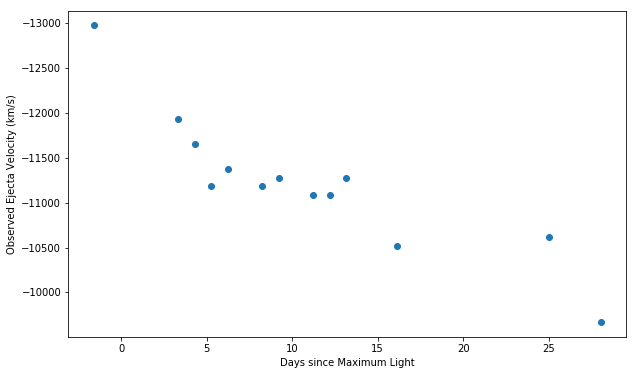

2005be


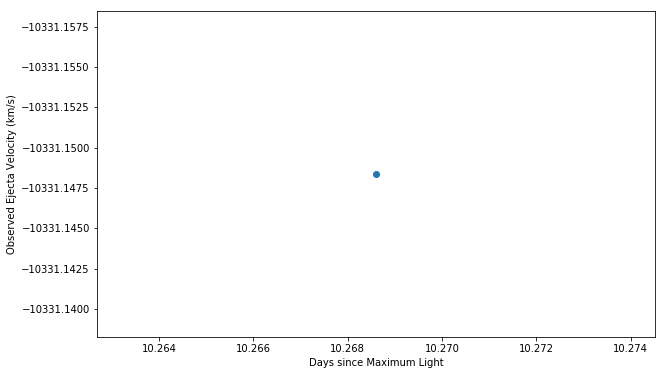

2005bl


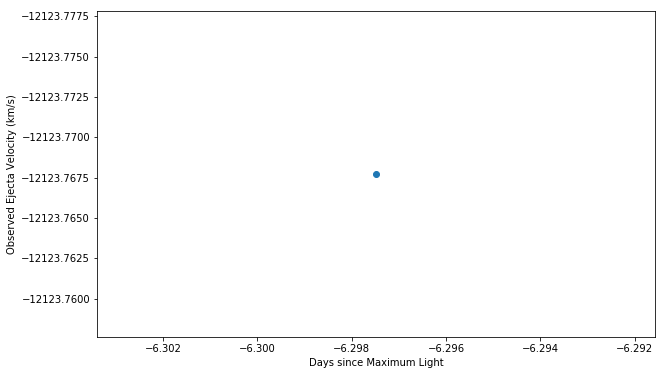

2005bo


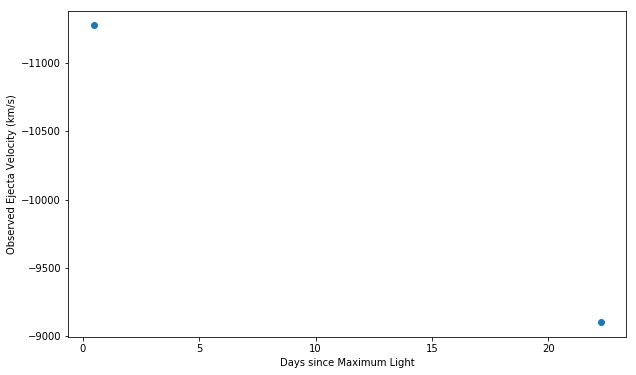

2005cf


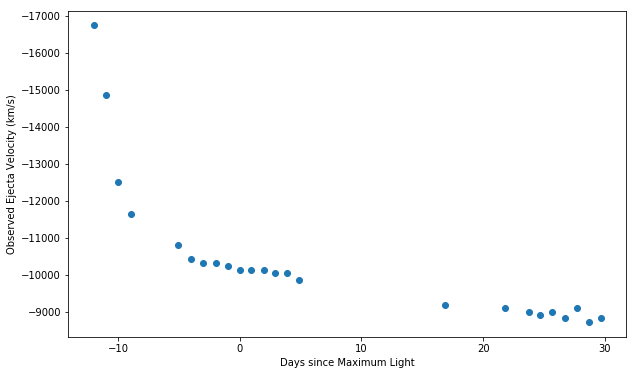

2005el


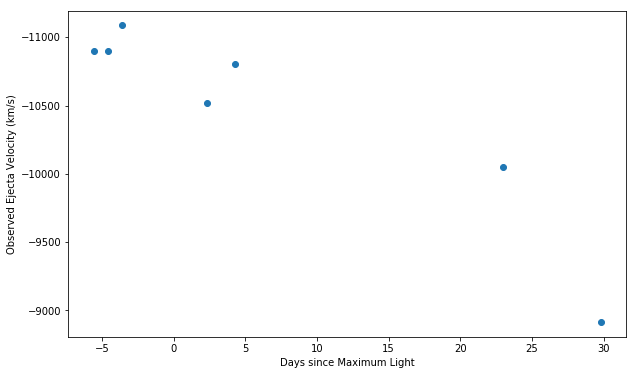

2005eq


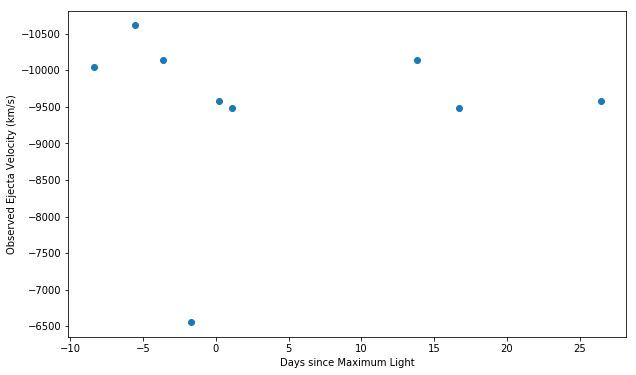

2005eu


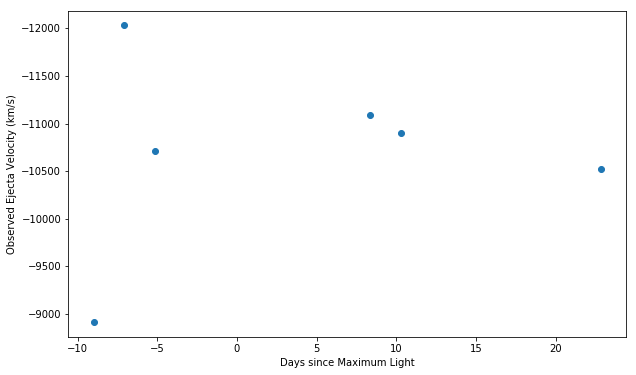

2005hc


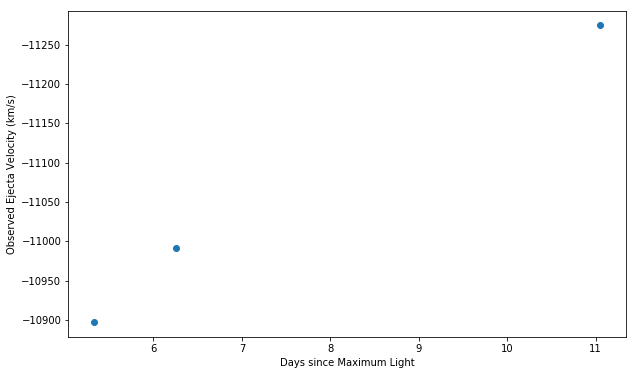

2005hf


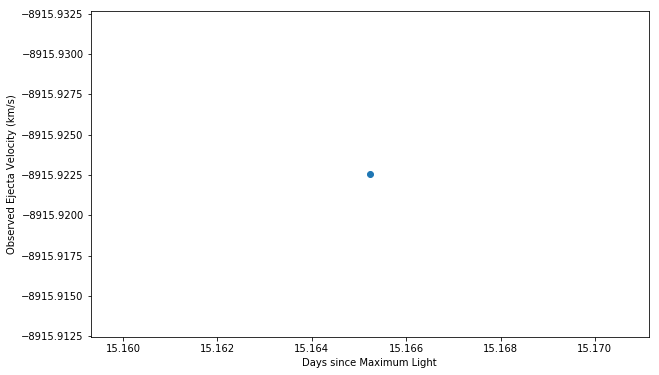

2005iq


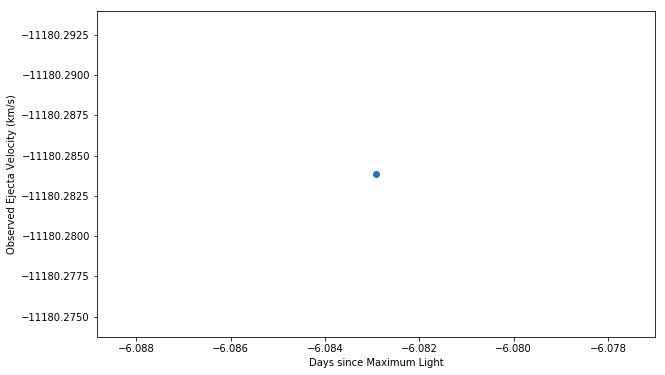

2005kc


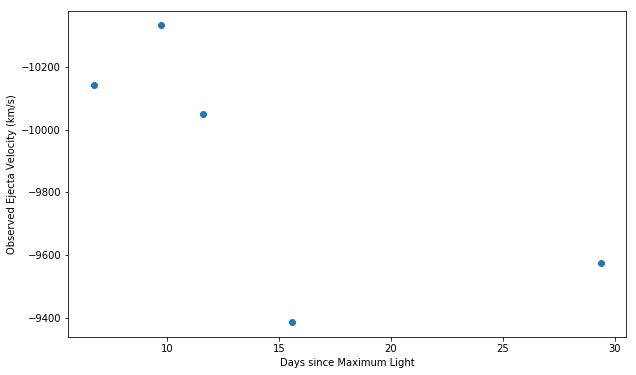

2005ke


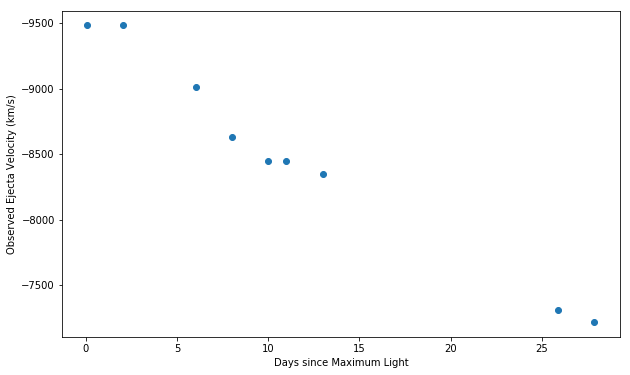

2005ki


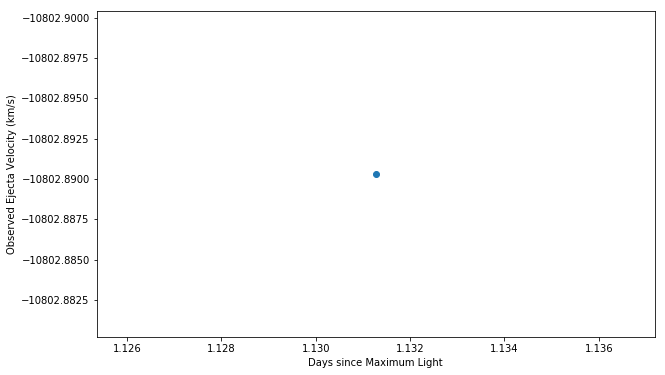

2005ls


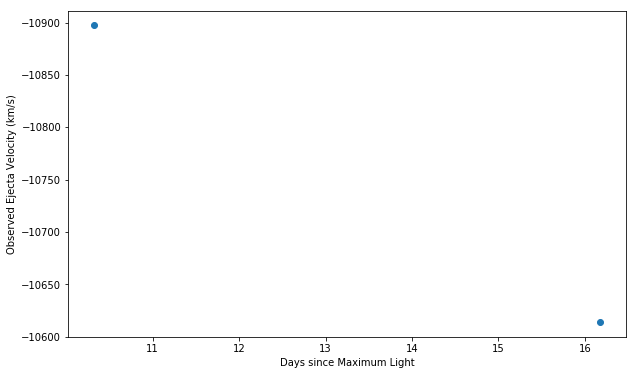

2005lu


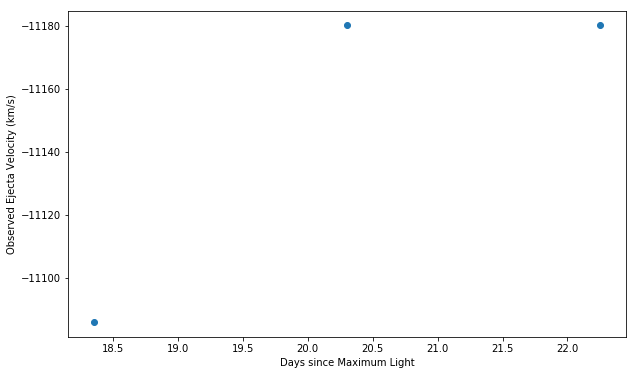

2005lz


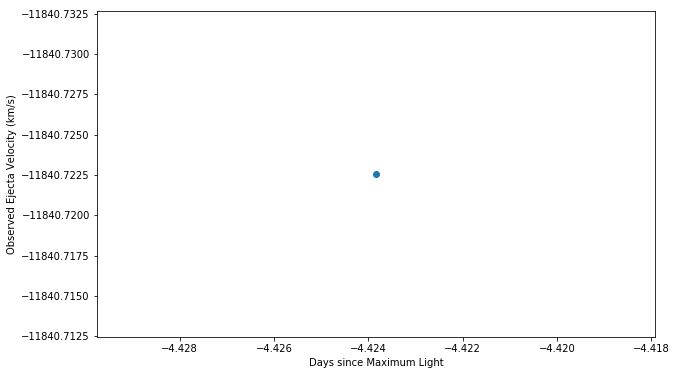

2005m


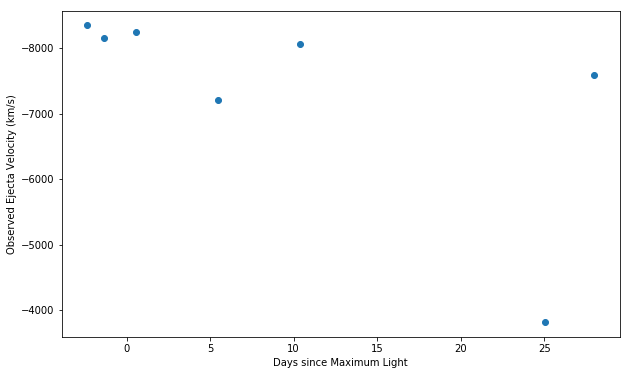

2005mc


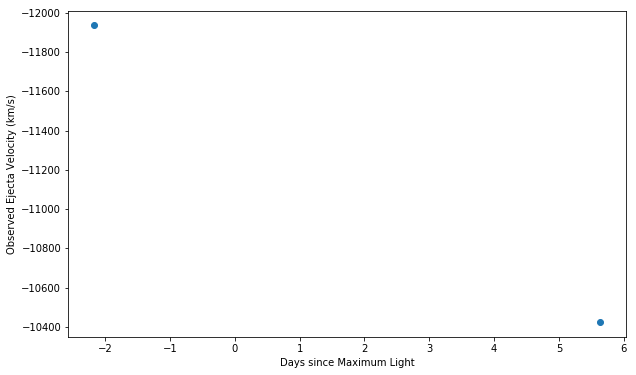

2005mz


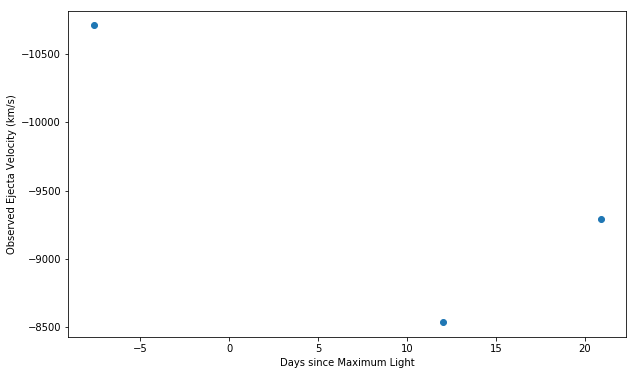

2005na


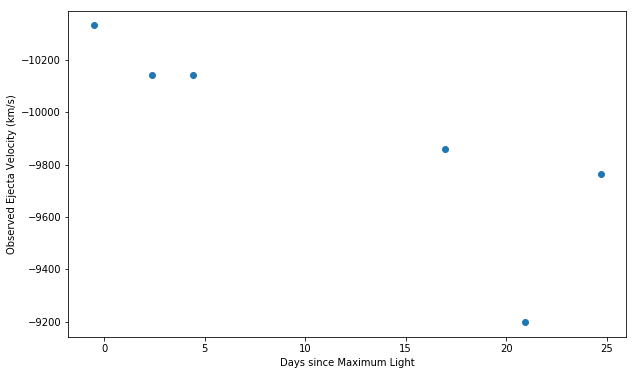

2006ac


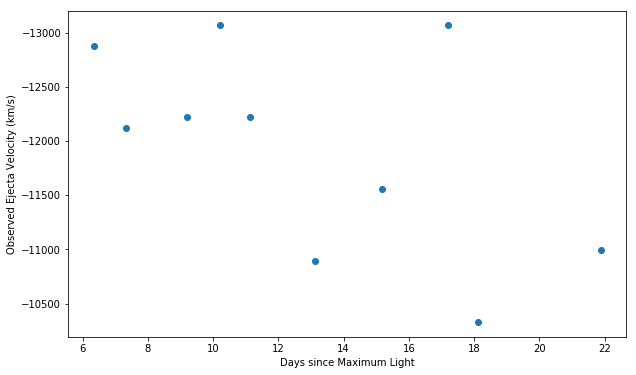

2006ak


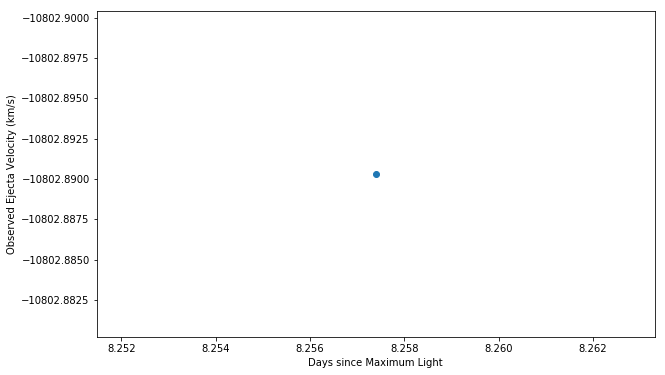

2006al


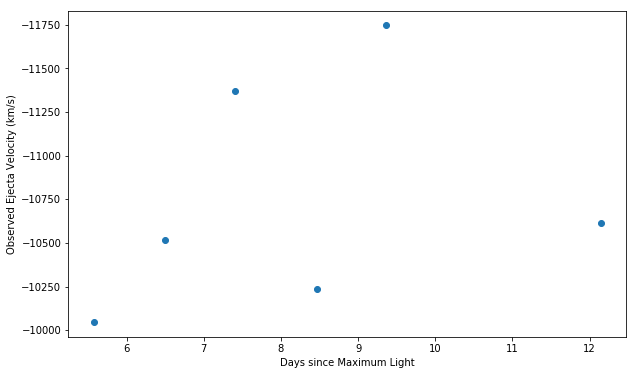

2006ax


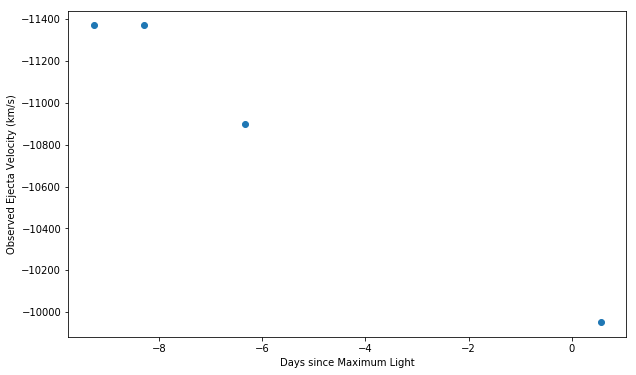

2006az


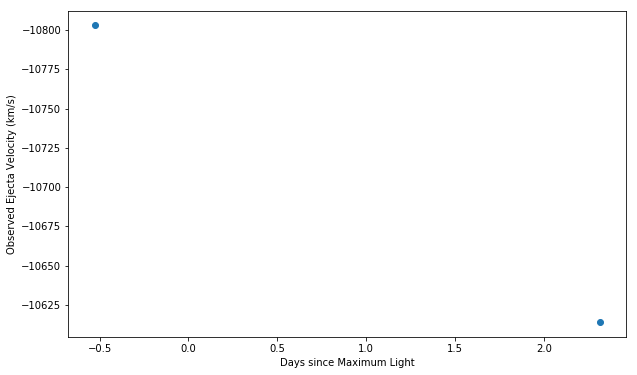

2006bq


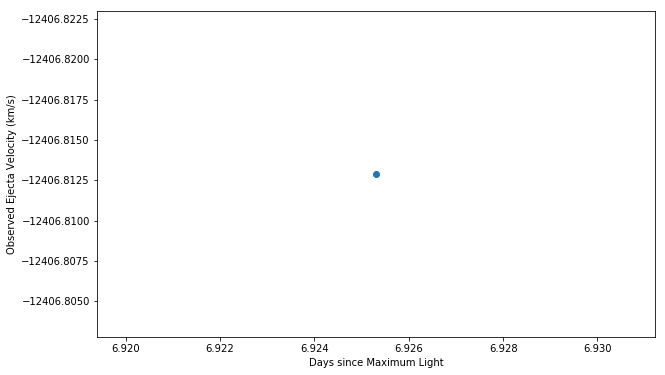

2006br


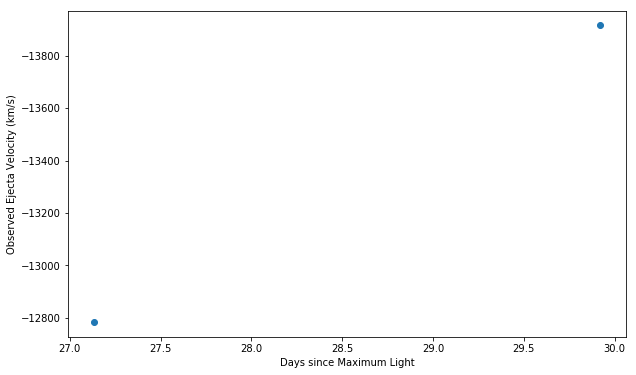

2006bu


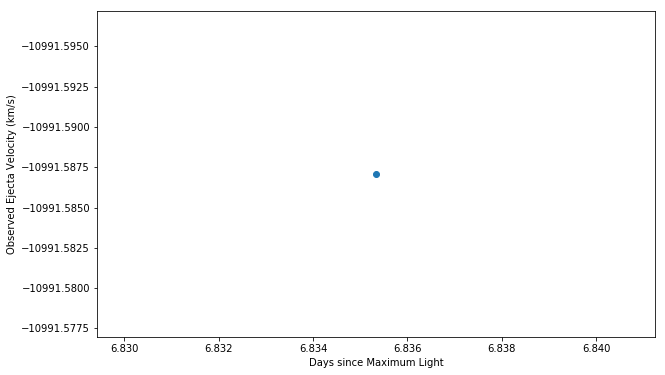

2006bw


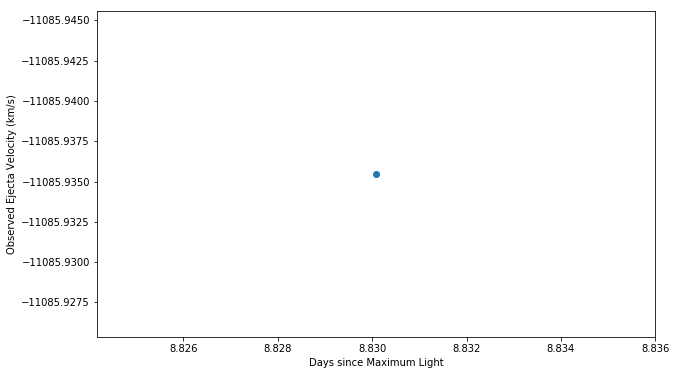

2006bz


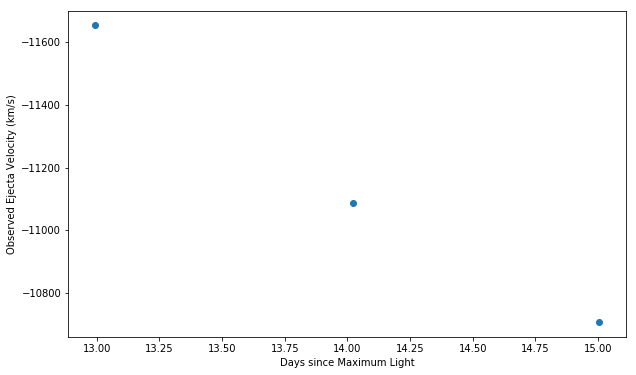

2006cc


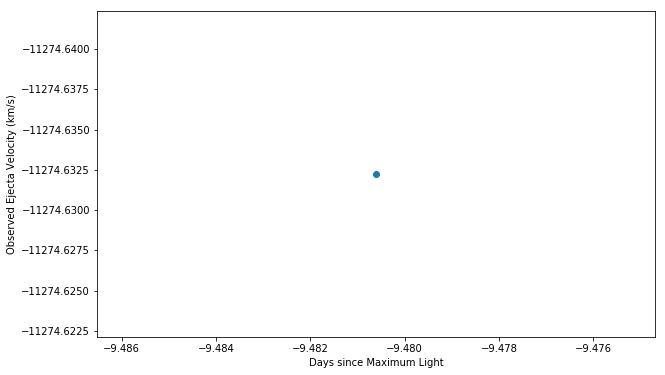

2006cf


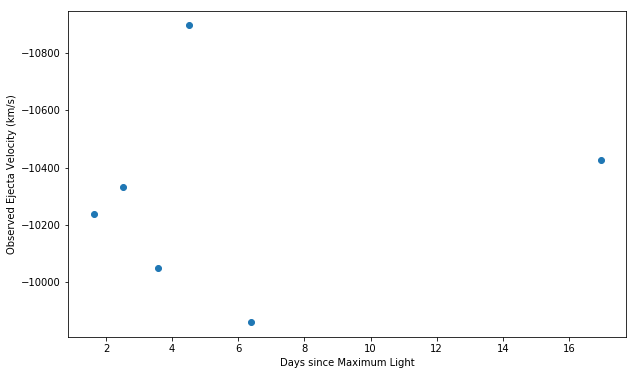

2006cj


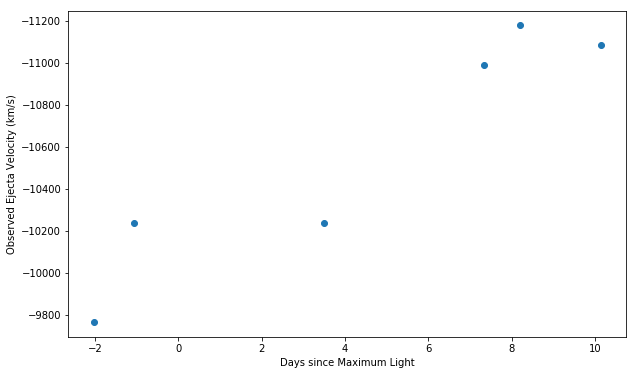

2006cp


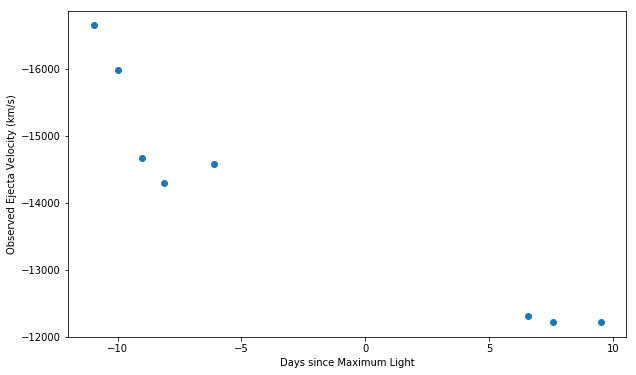

2006cq


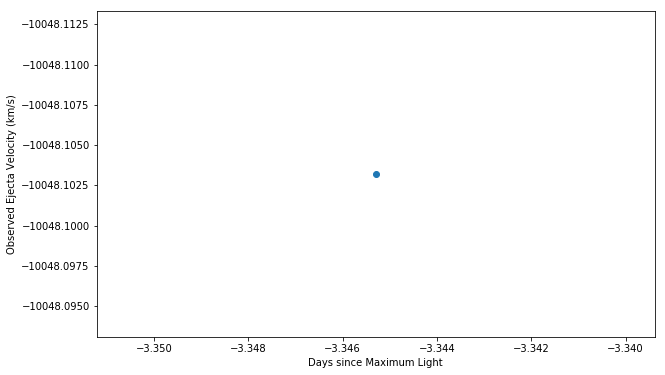

2006cz


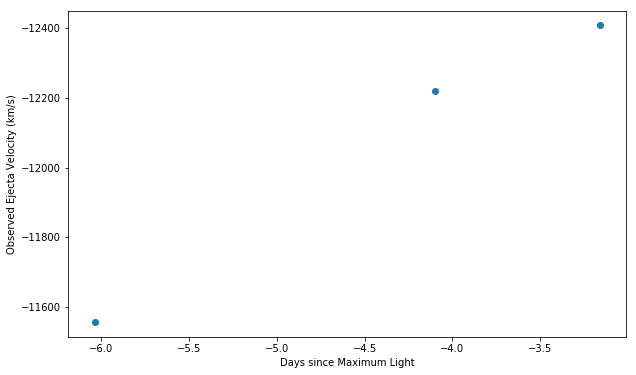

2006d


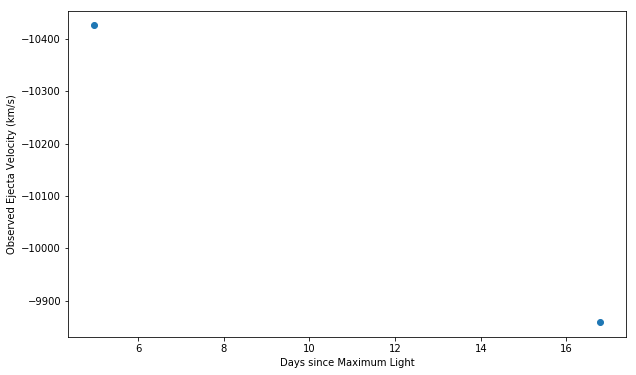

2006em


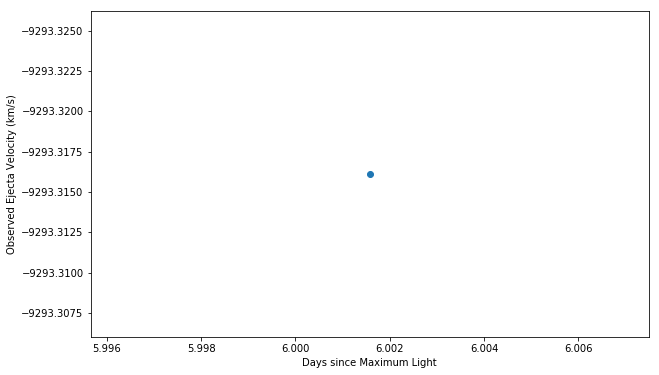

2006eq


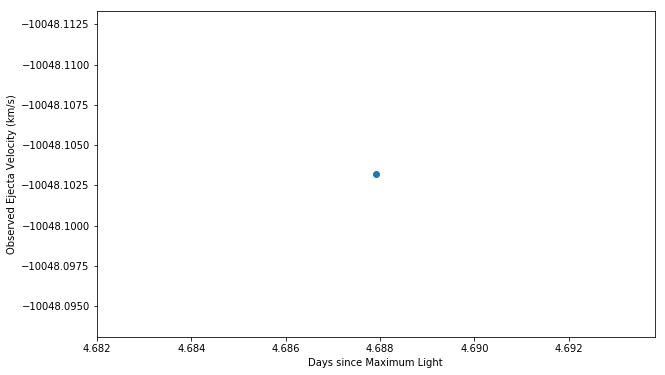

2006et


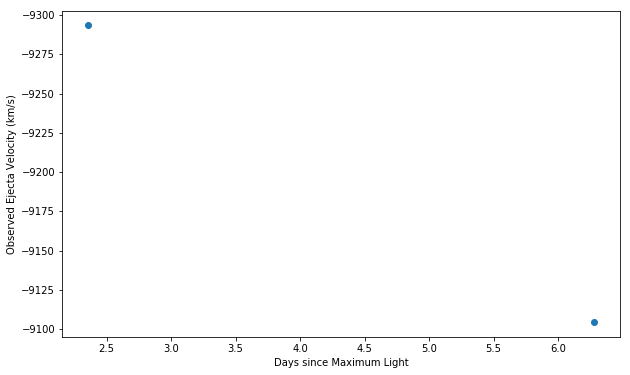

2006eu


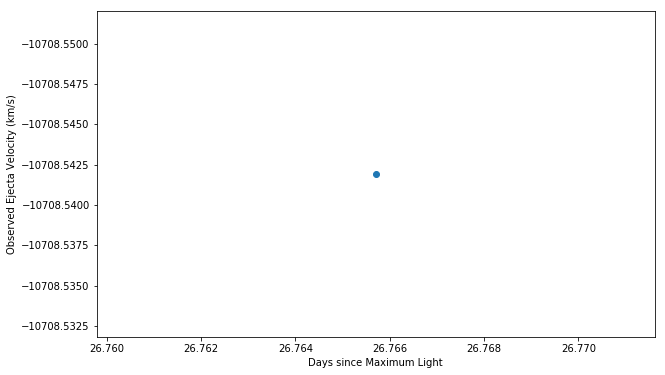

2006ev


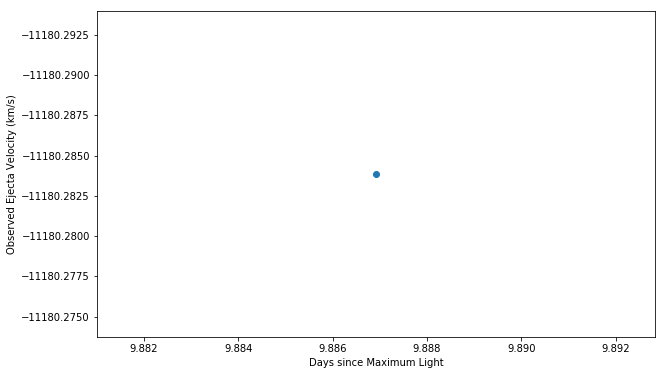

2006gj


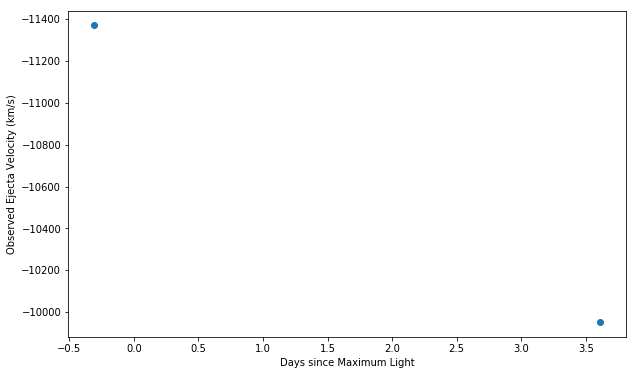

2006gr


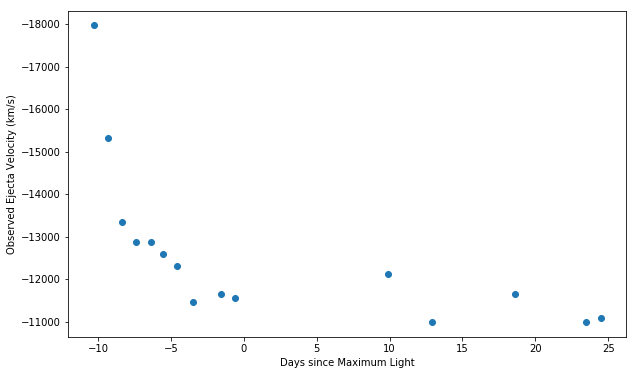

2006gt


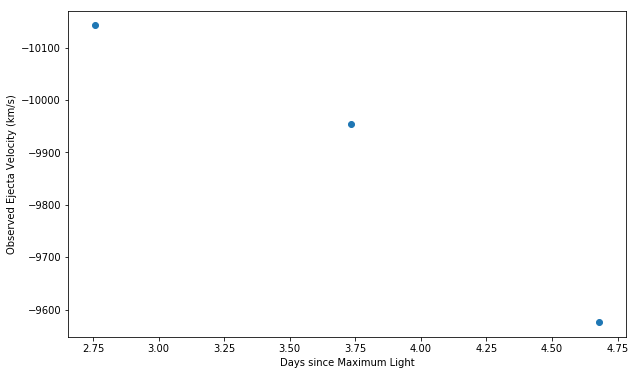

2006h


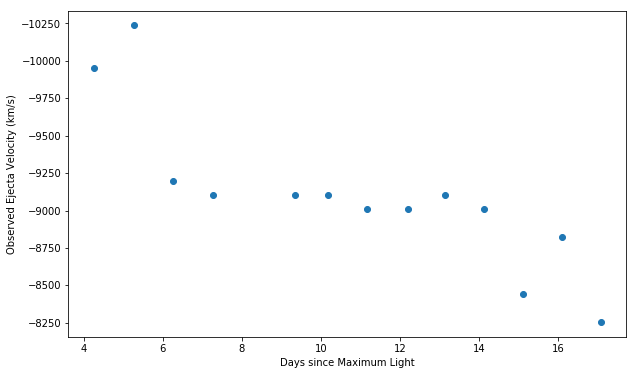

2006hb


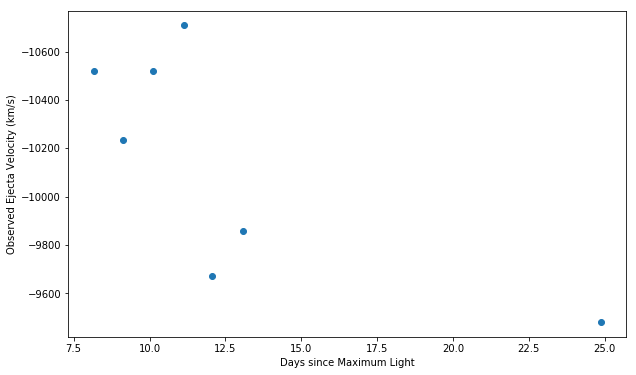

2006kf


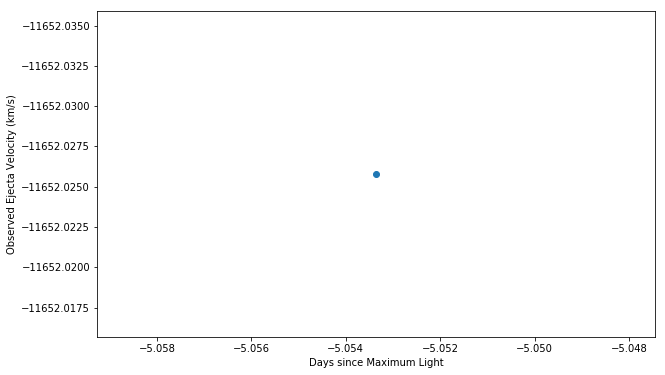

2006le


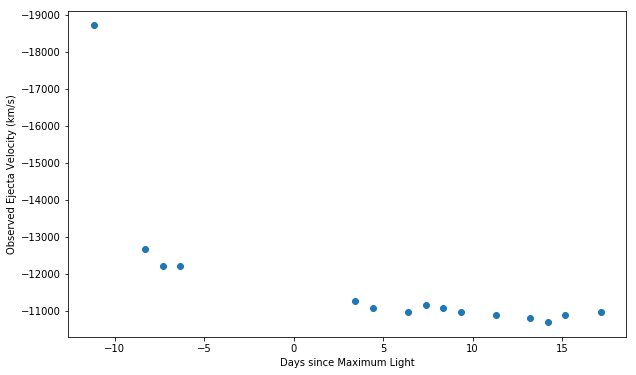

2006lf


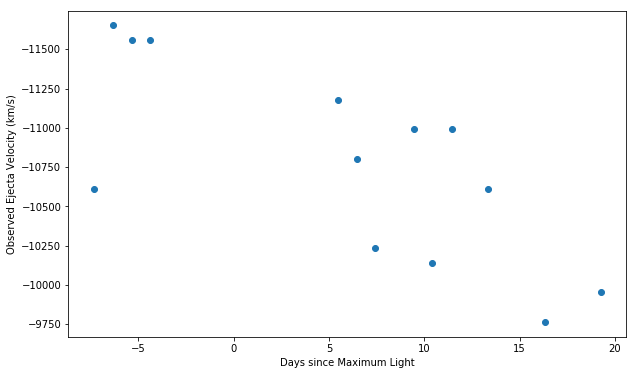

2006mo


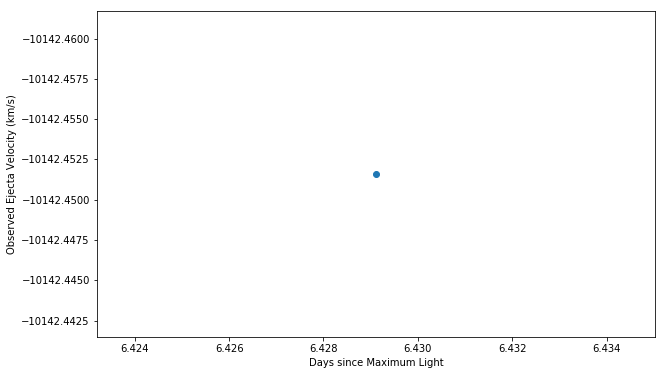

2006n


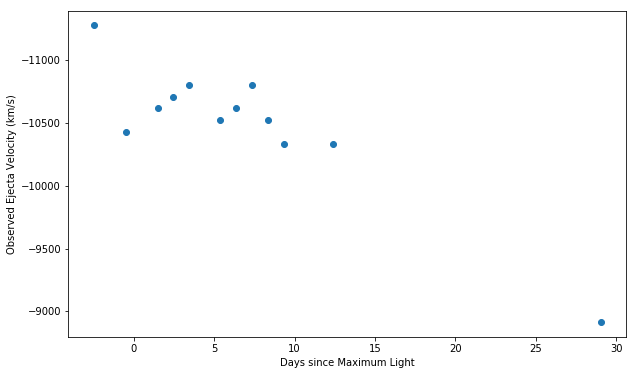

2006oa


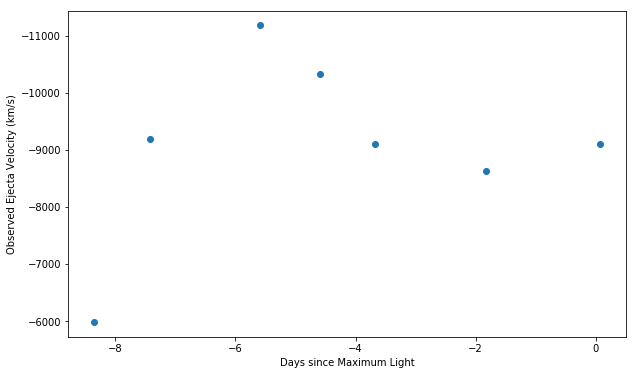

2006ot


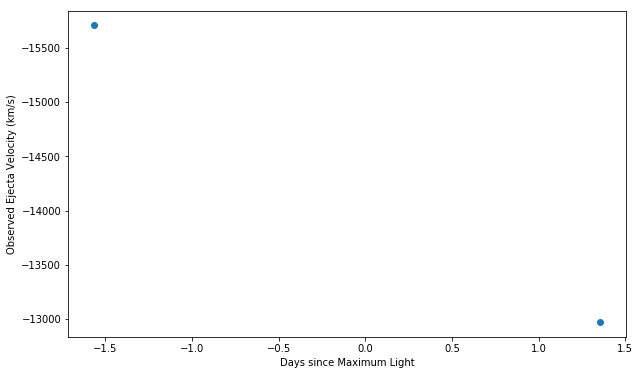

2006s


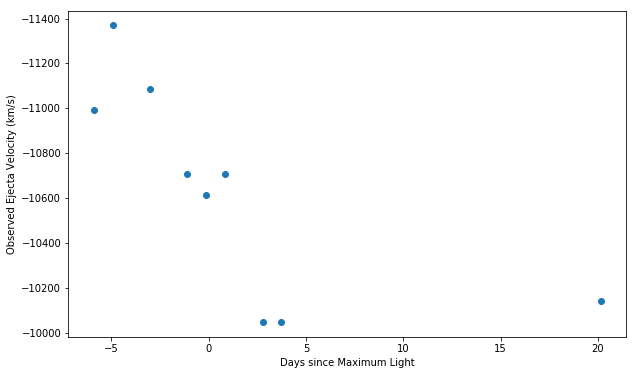

2006sr


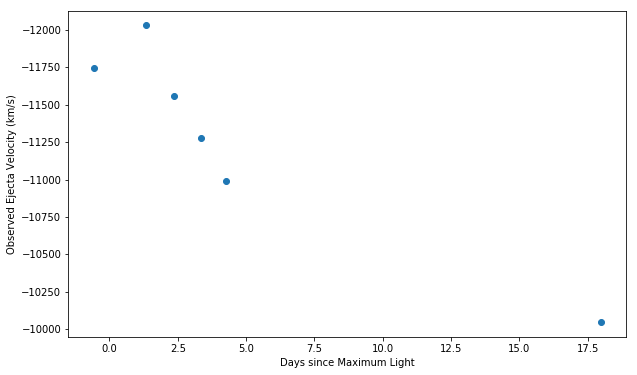

2006te


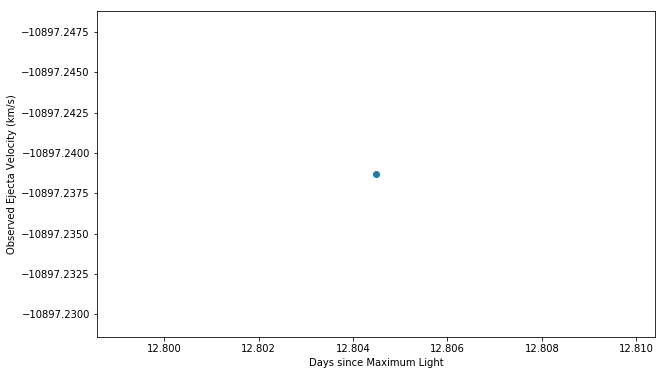

2006x


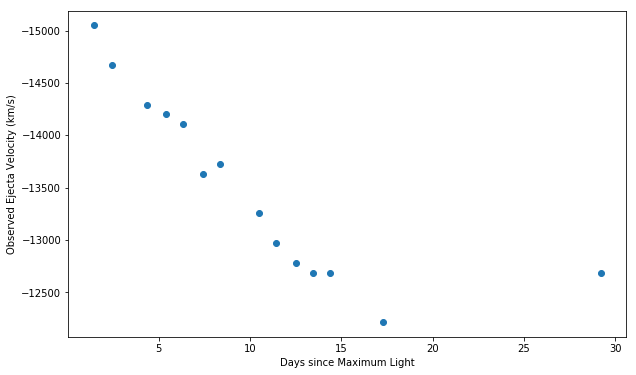

2007a


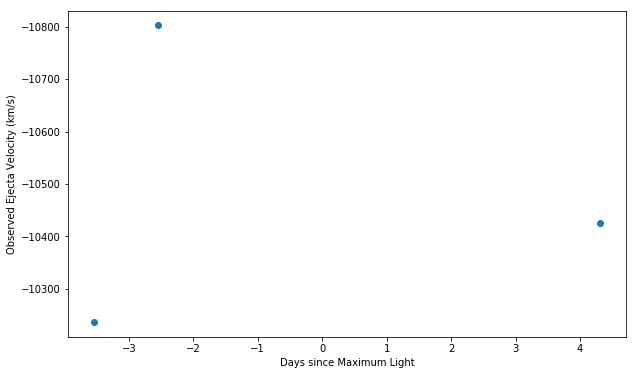

2007ae


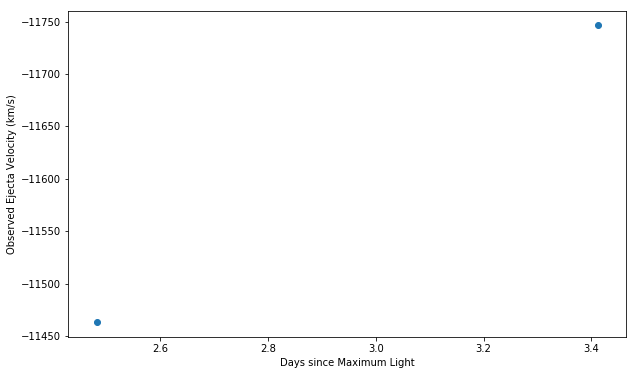

2007af


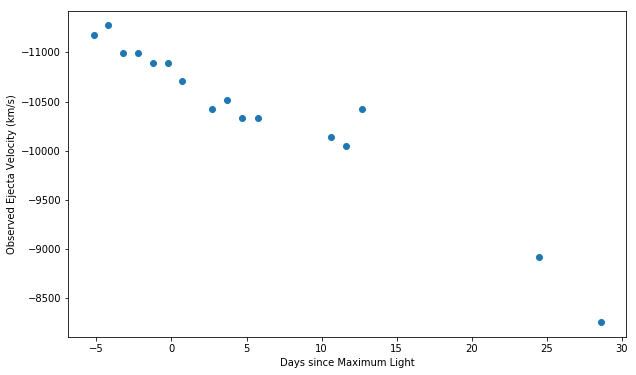

2007al


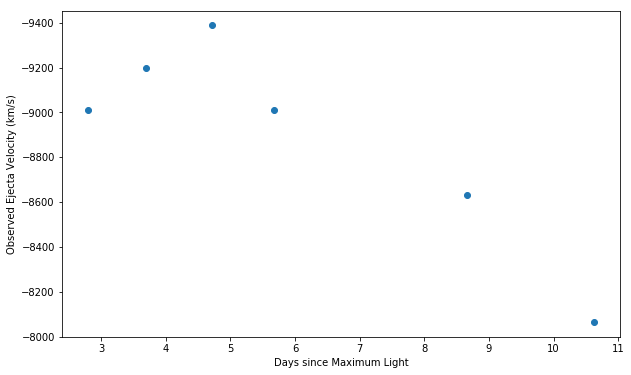

2007ap


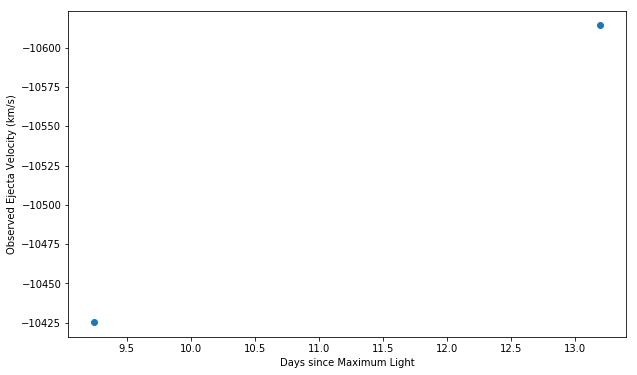

2007au


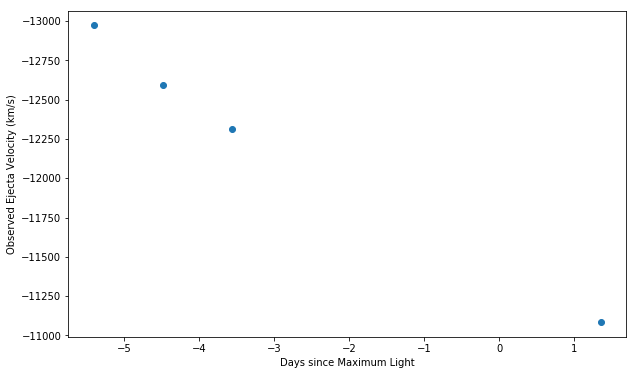

2007ax


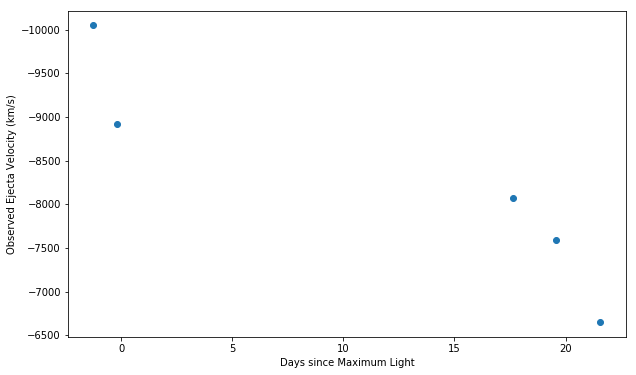

2007ba


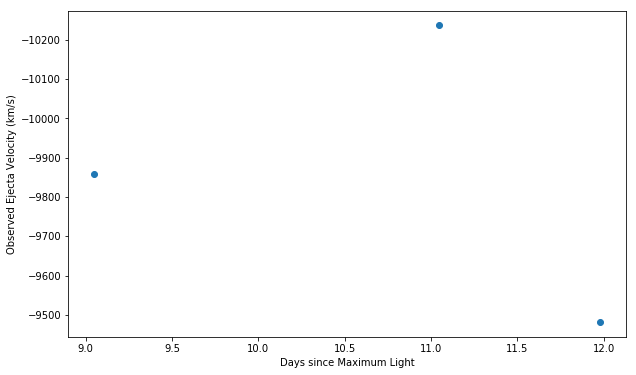

2007bc


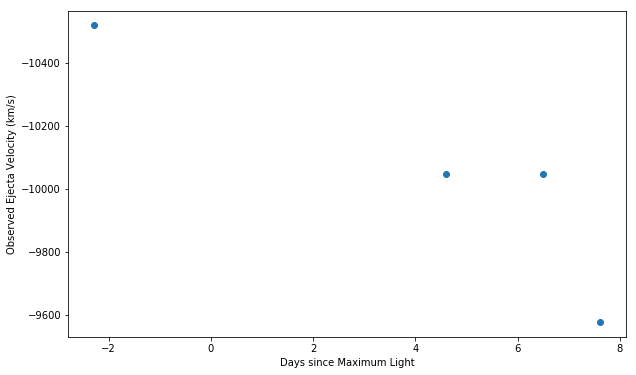

2007bd


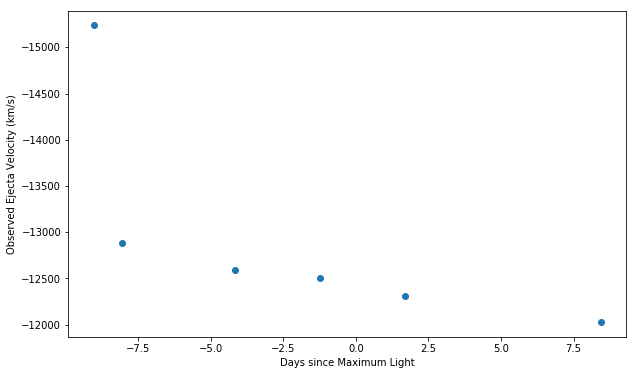

2007bm


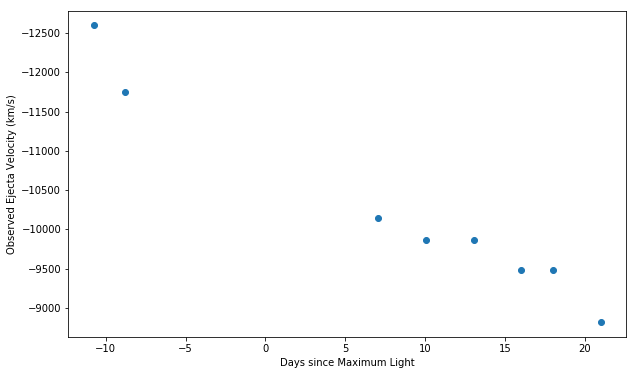

2007bz


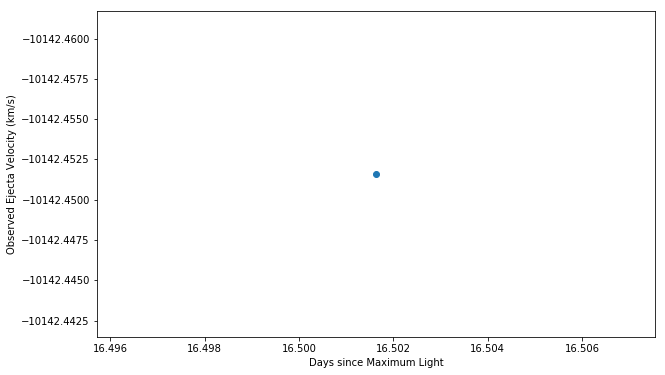

2007ca


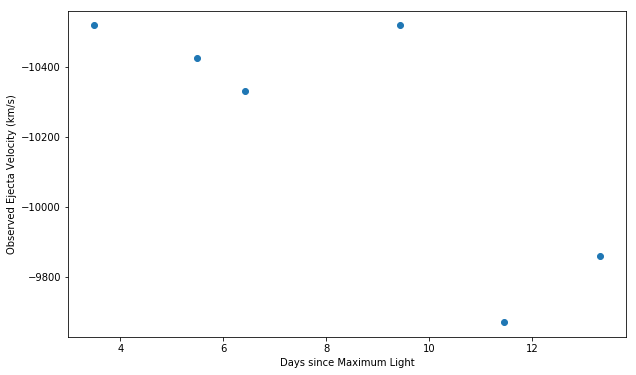

2007cg


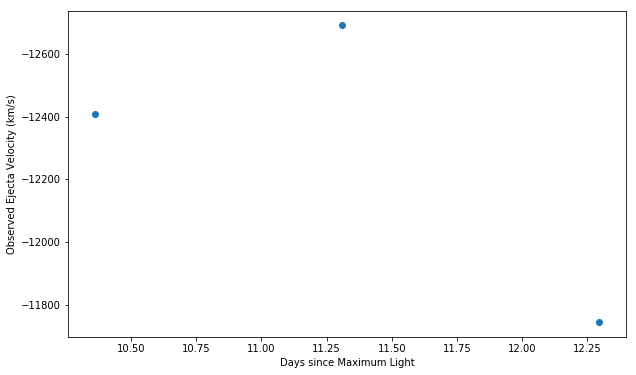

2007ci


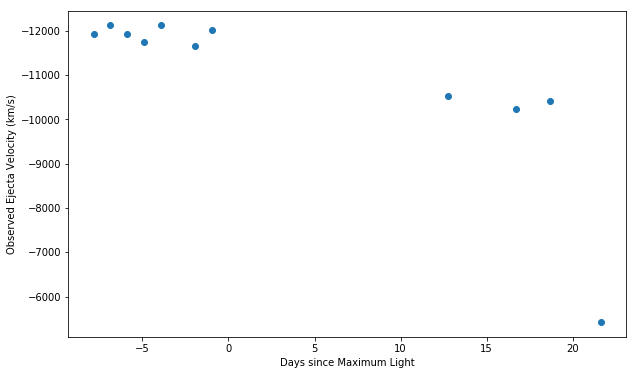

2007co


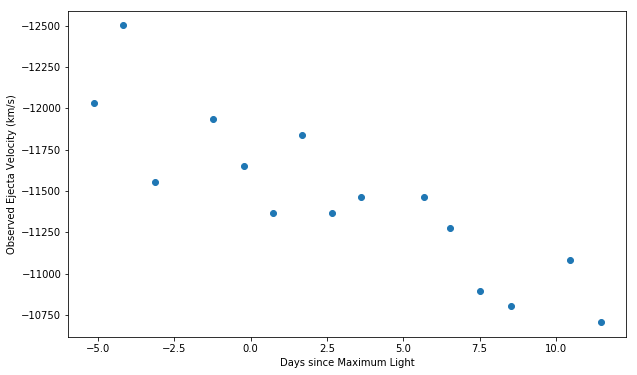

2007cq


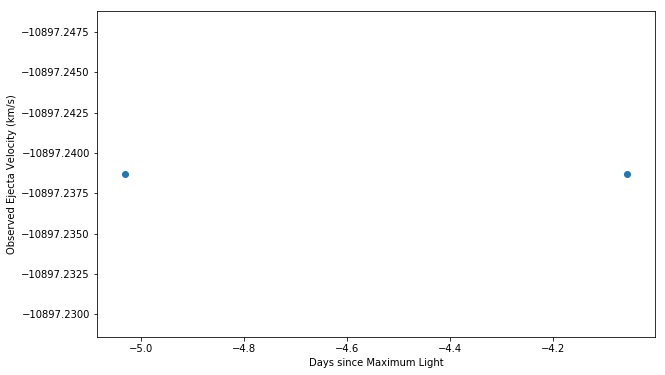

2007f


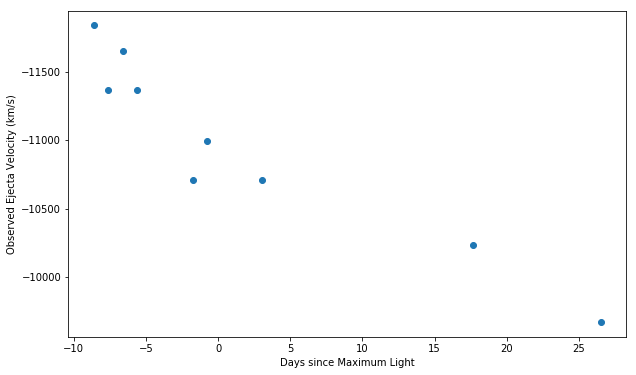

2007if


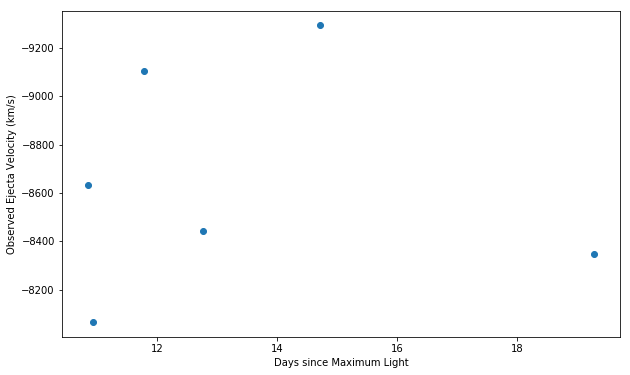

2007jg


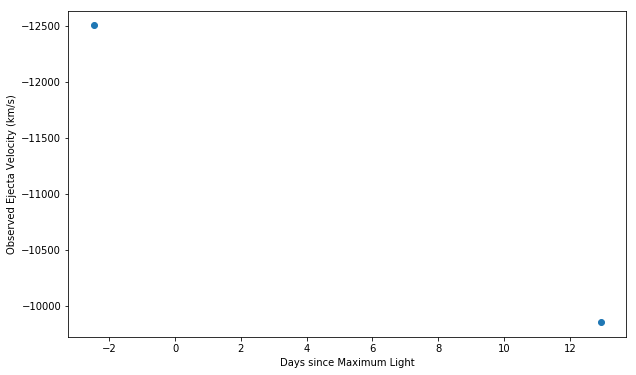

2007le


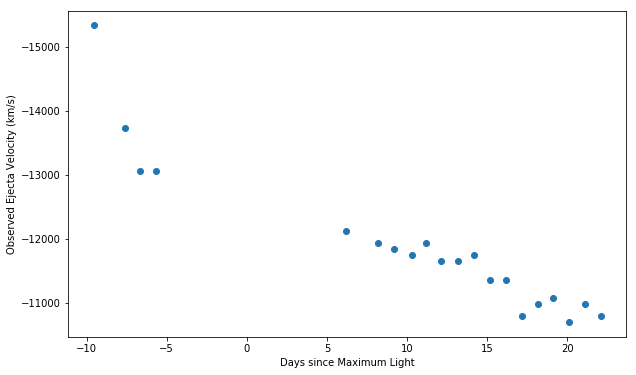

2007nq


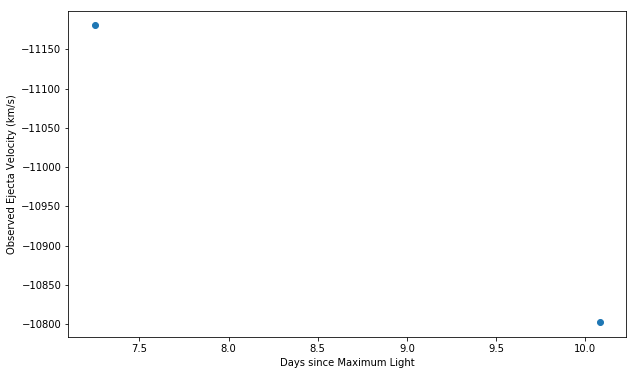

2007qe


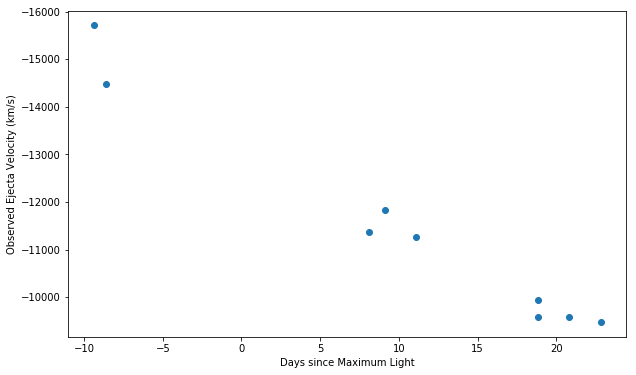

2007s


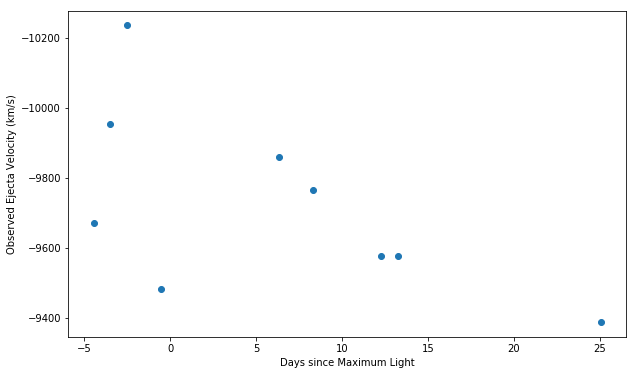

2007sr


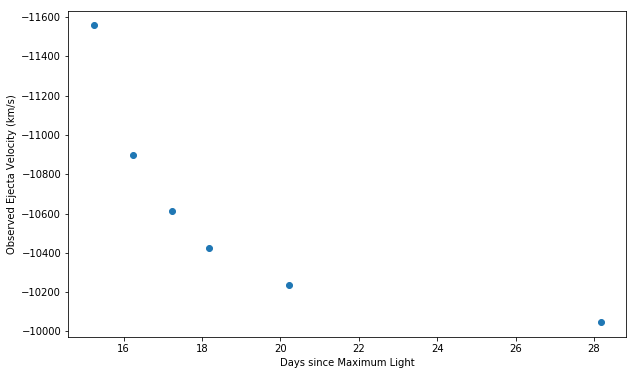

2008af


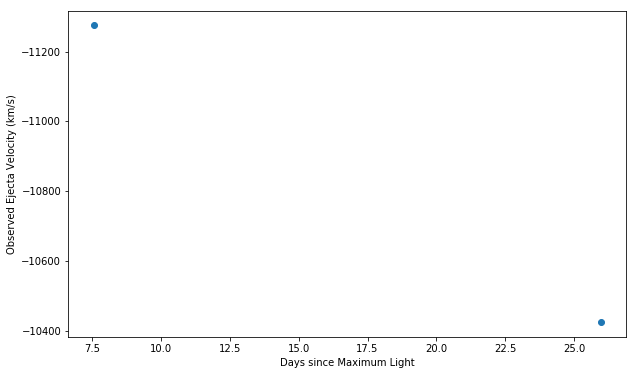

2008bf


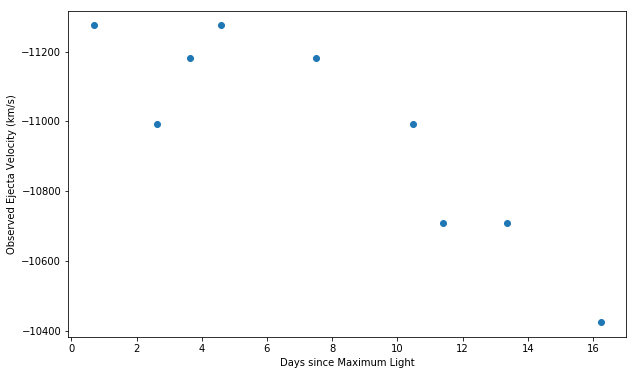

2008c


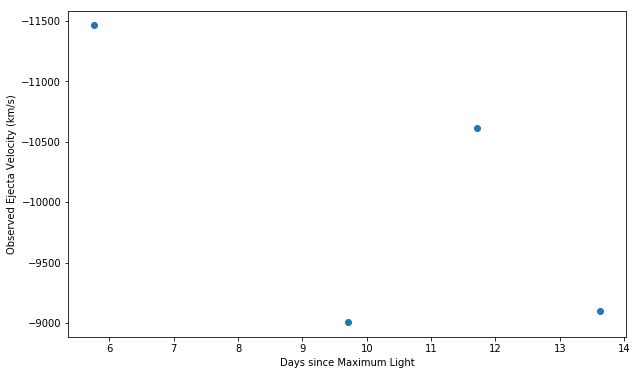

2008l


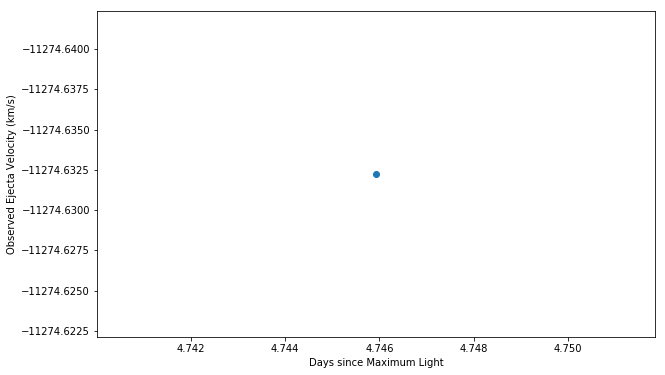

2008r


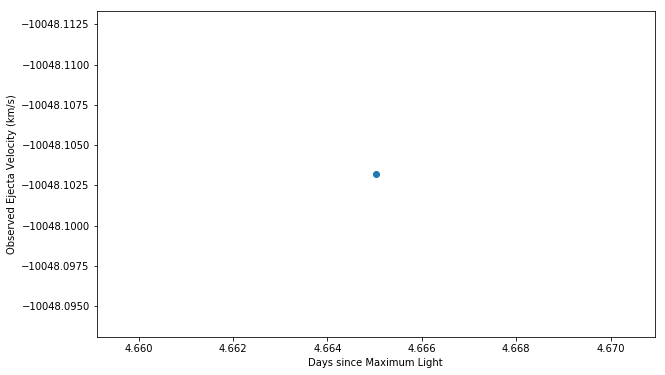

2004dt


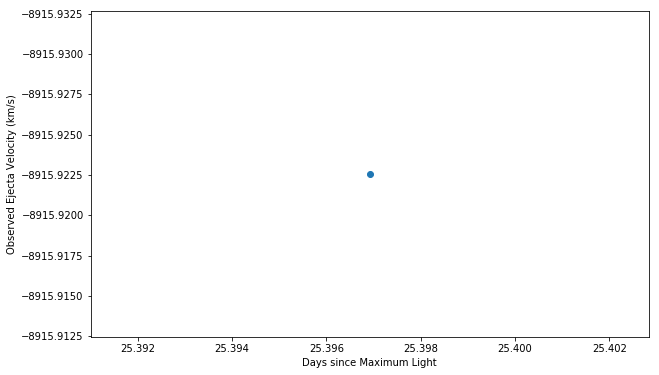

2004ef


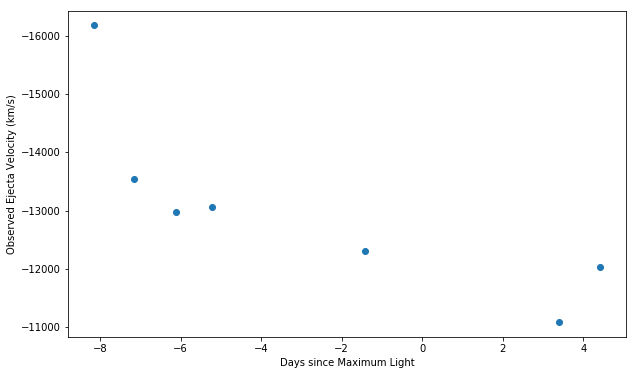

2004eo


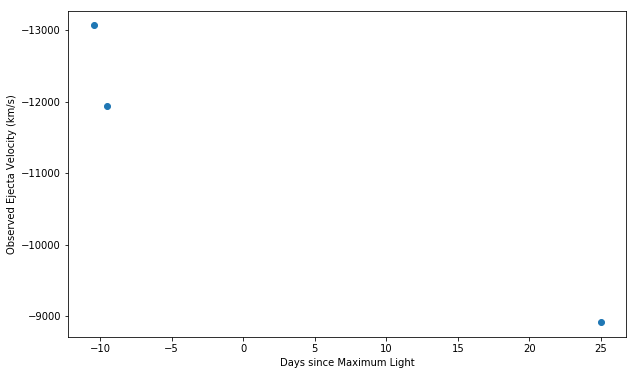

2004ey


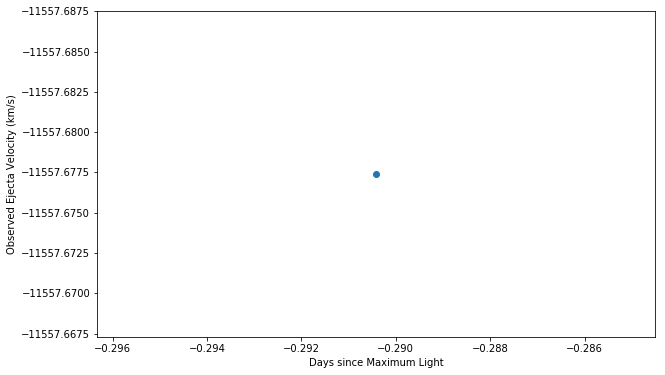

2004gc


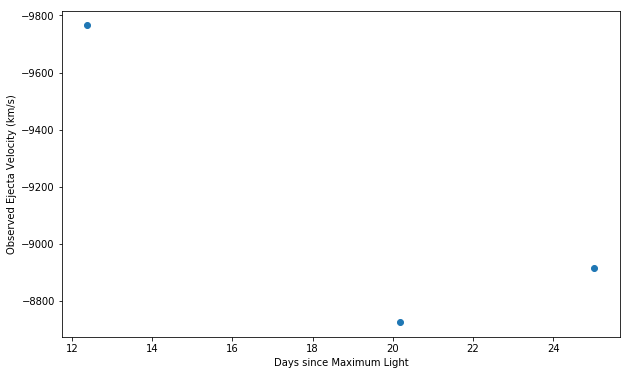

2004gs


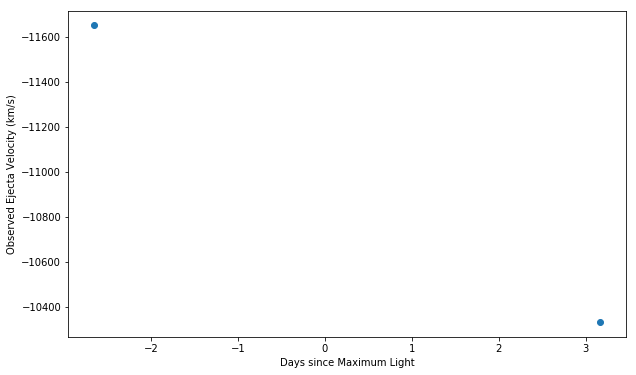

2004gu


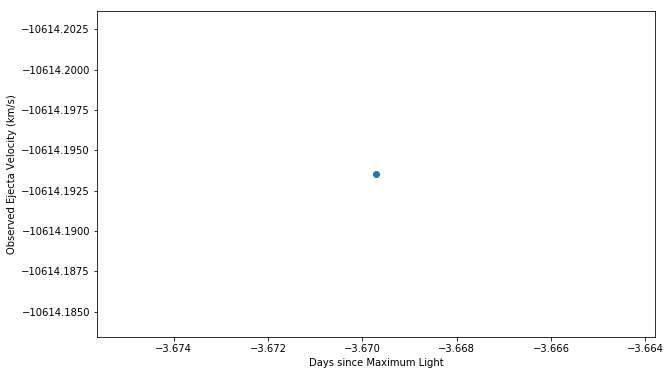

2005ag


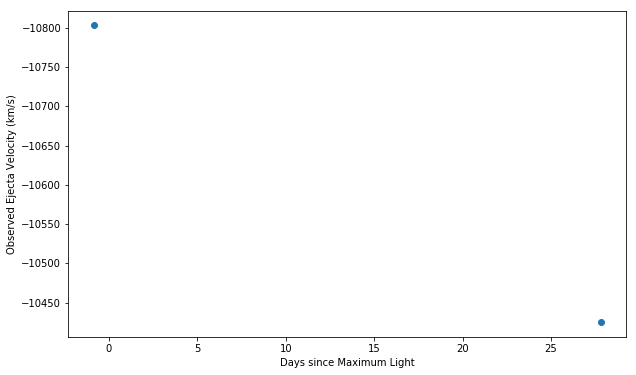

2005al


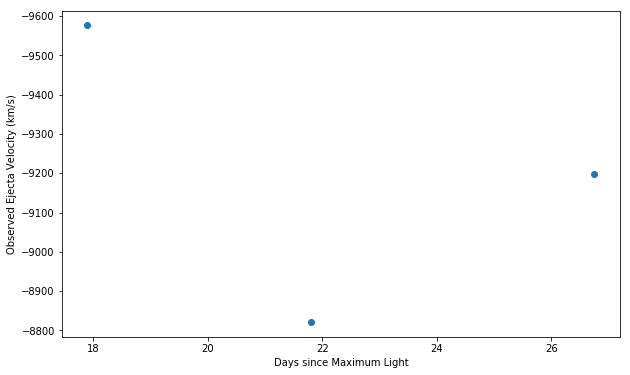

2005am


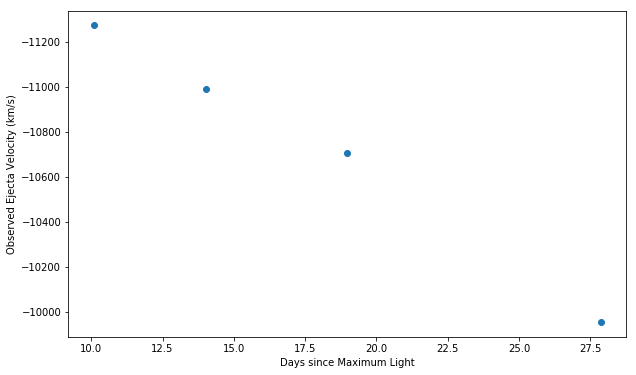

2005a


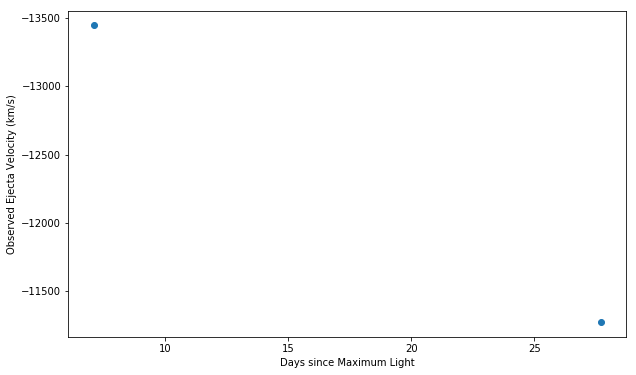

2005be


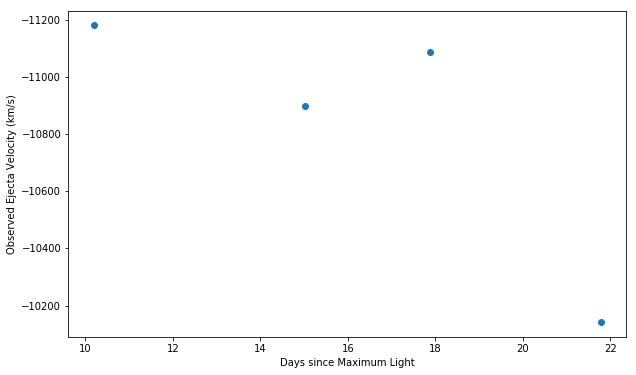

2005bg


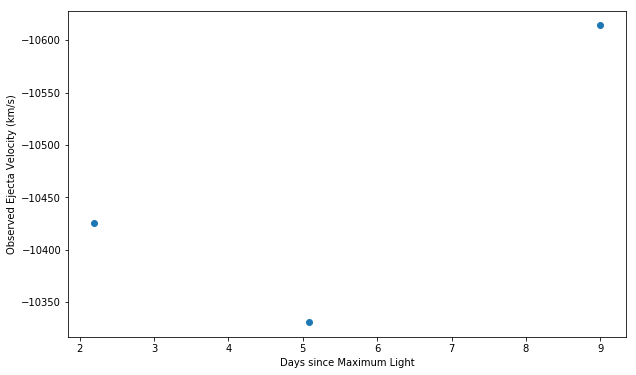

2005bl


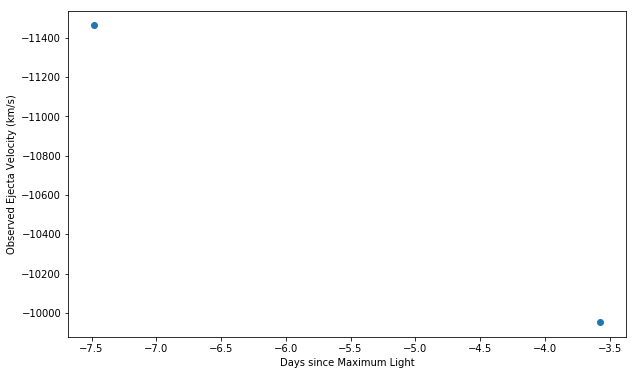

2005bo


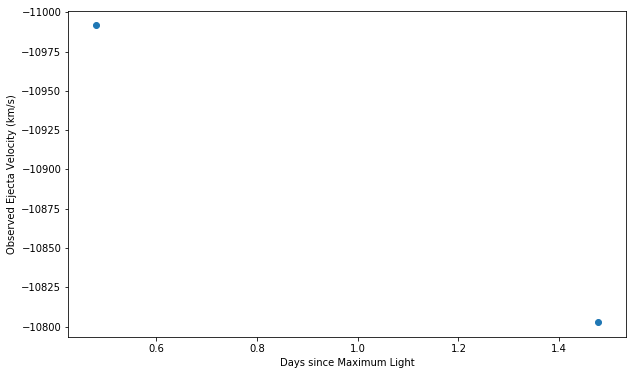

2005el


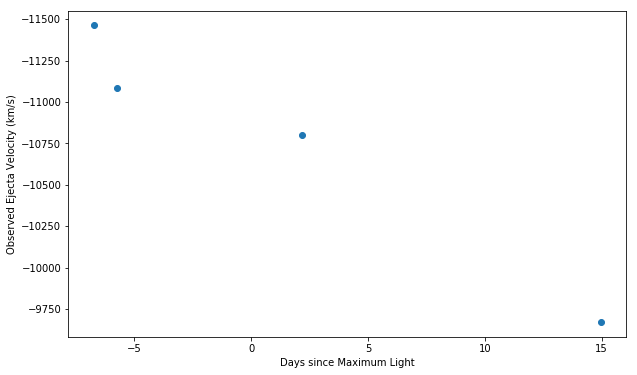

2005eq


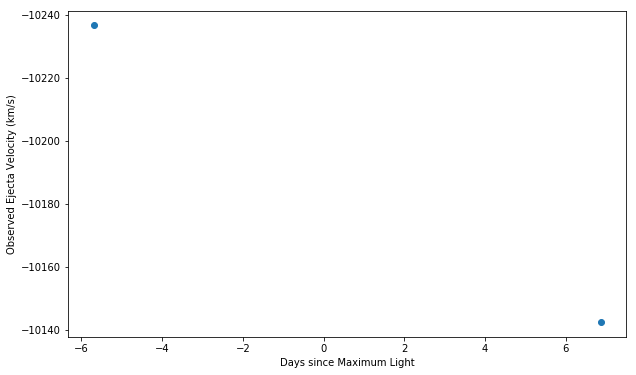

2005hc


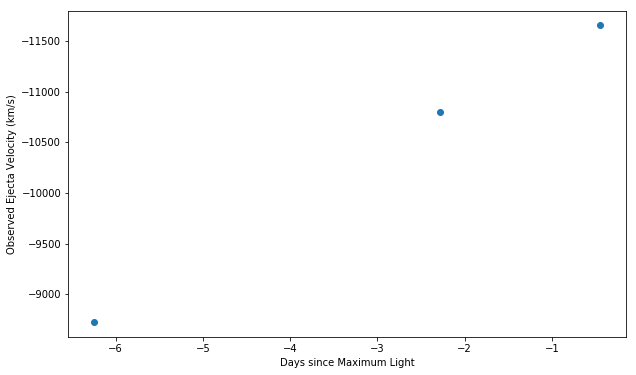

2005iq


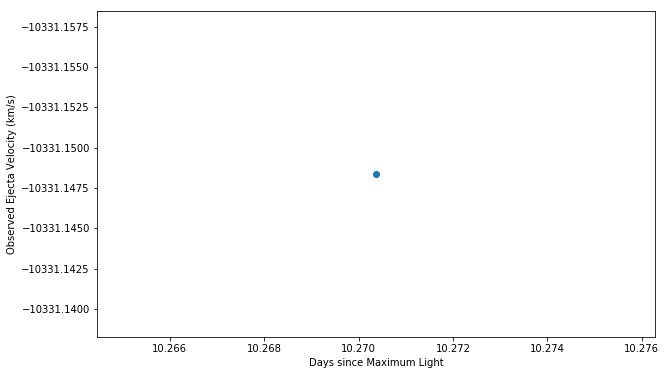

2005kc


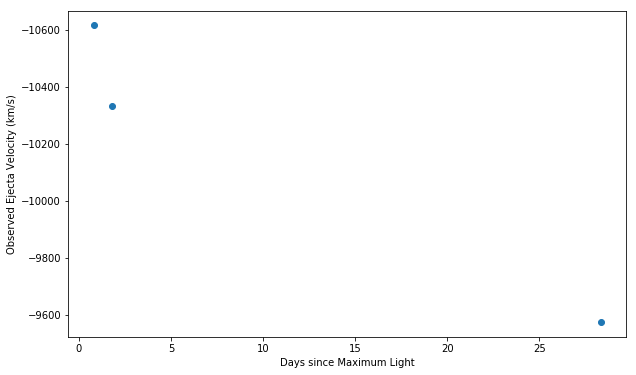

2005ke


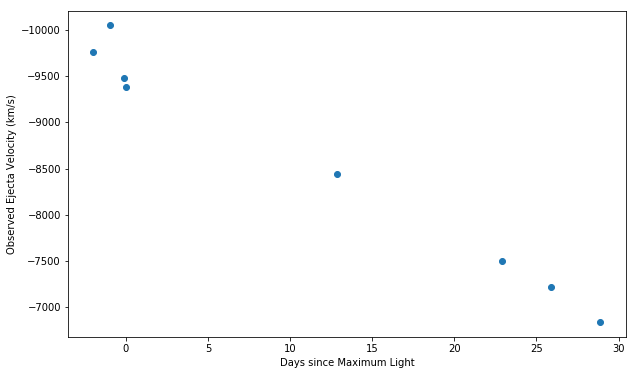

2005ki


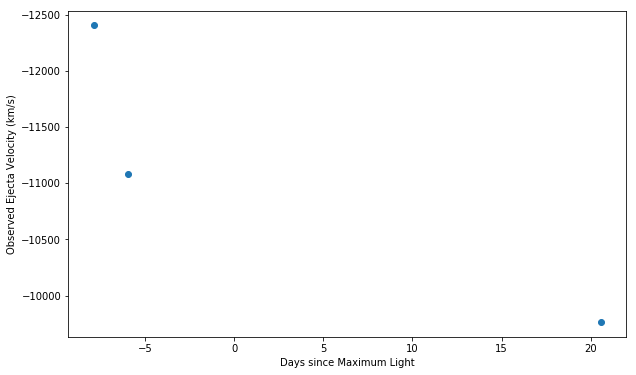

2005ku


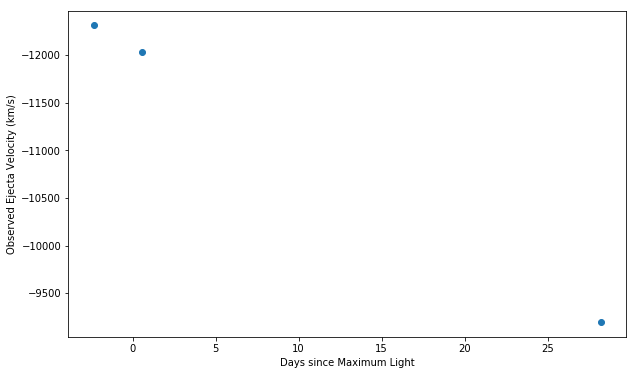

2005lu


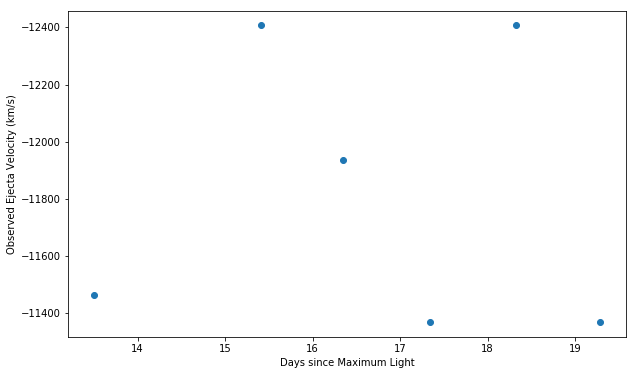

2005m


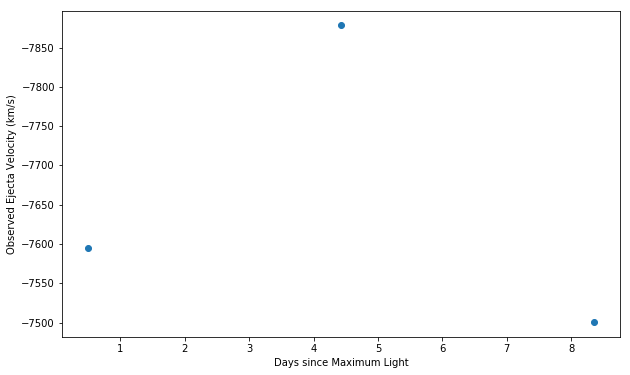

2005na


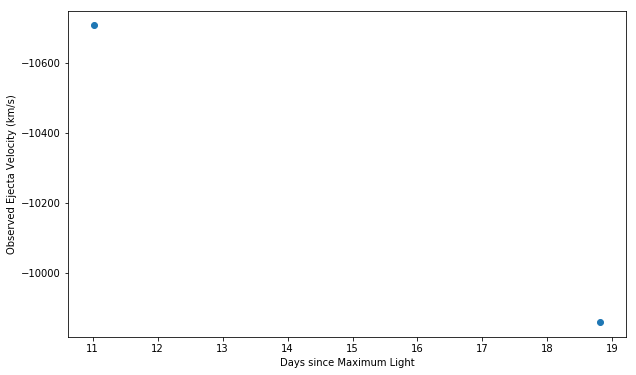

2006ax


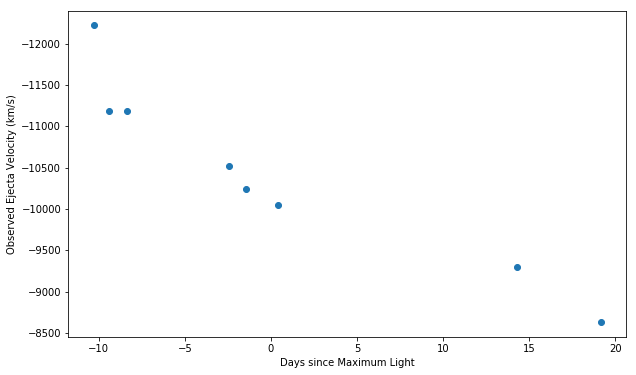

2006bh


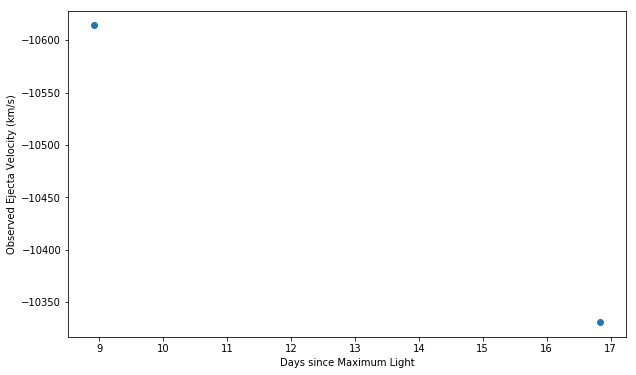

2006br


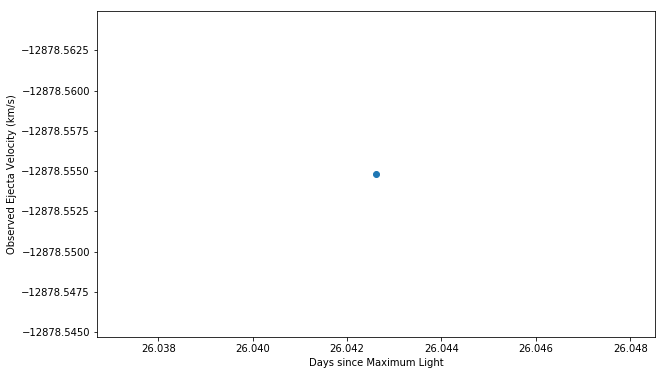

2006d


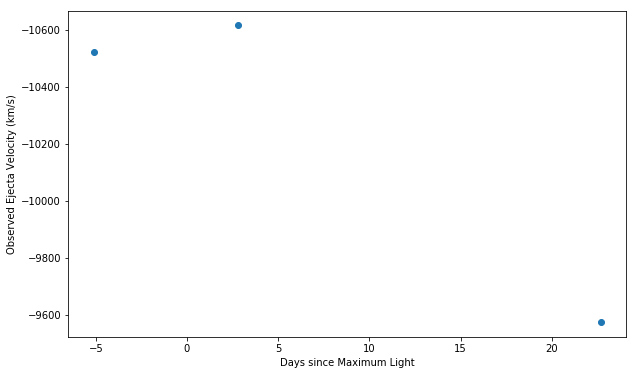

2006eq


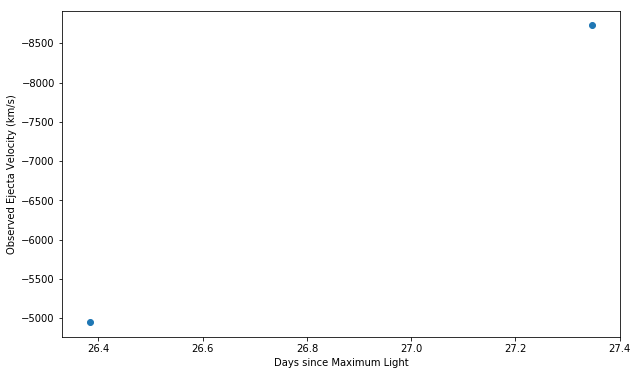

2006et


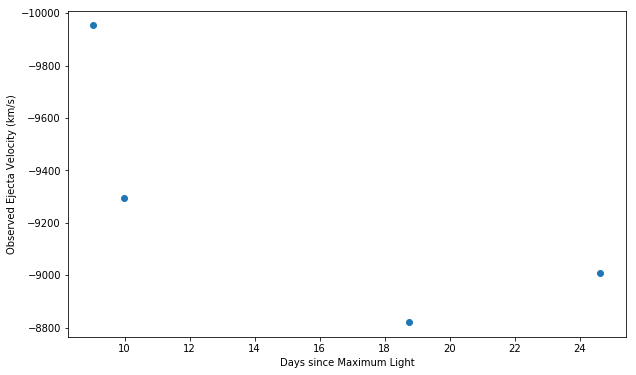

2006ev


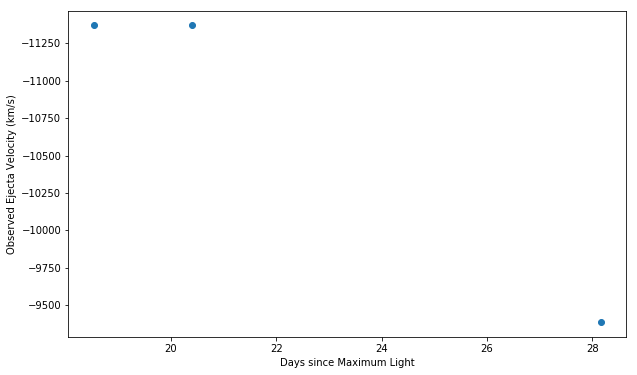

2006fw


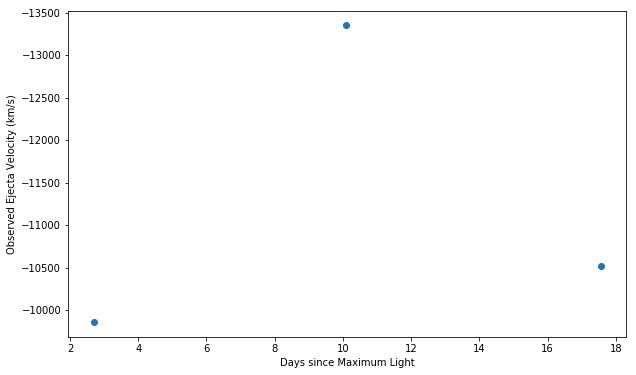

2006gj


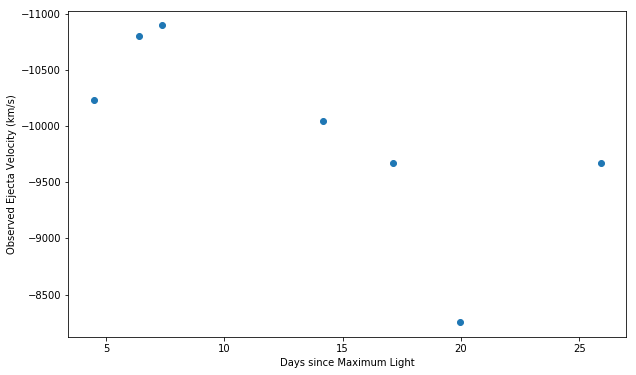

2006gt


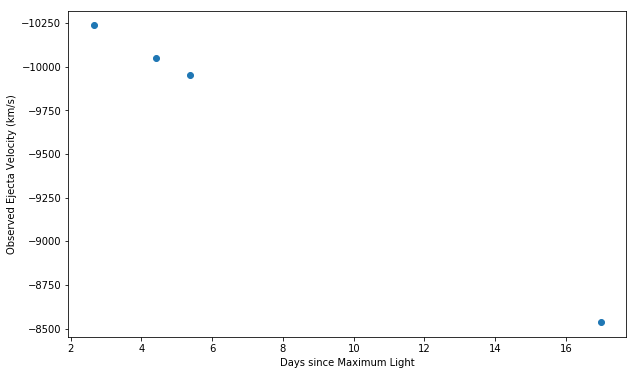

2006hb


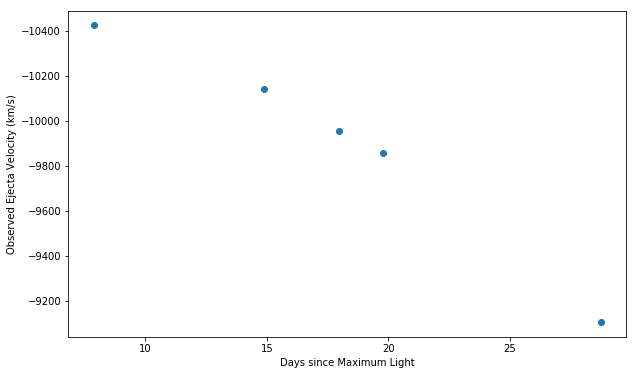

2006hx


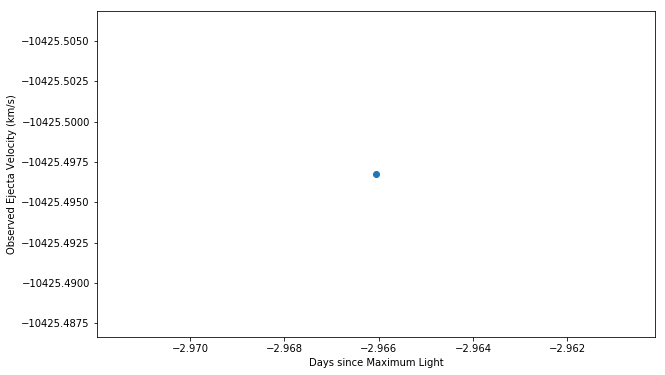

2006is


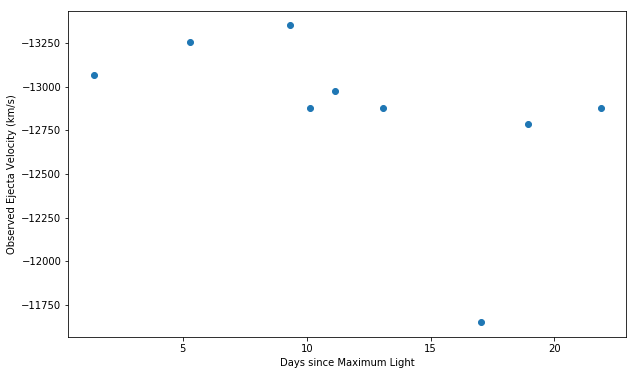

2006kf


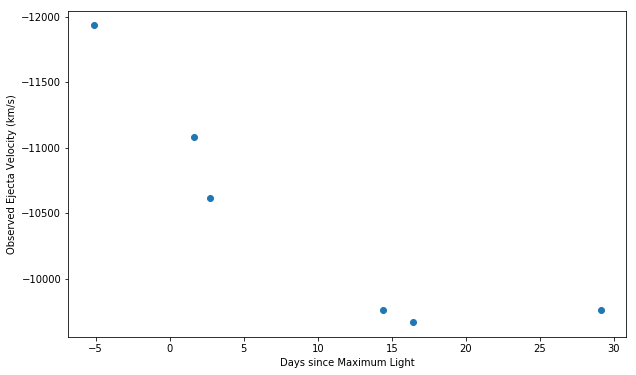

2006lu


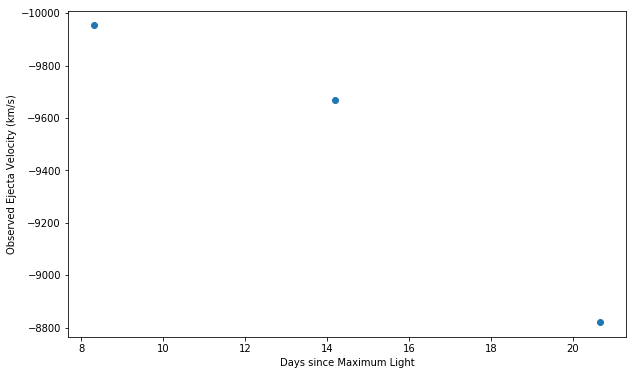

2006ob


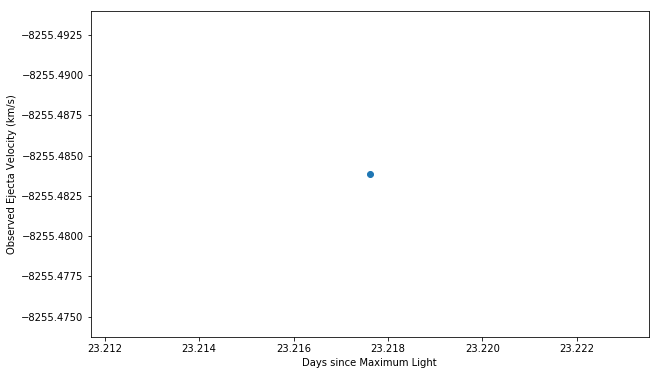

2006os


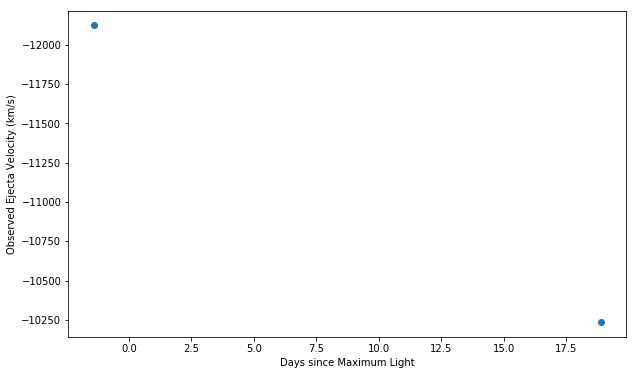

2006ot


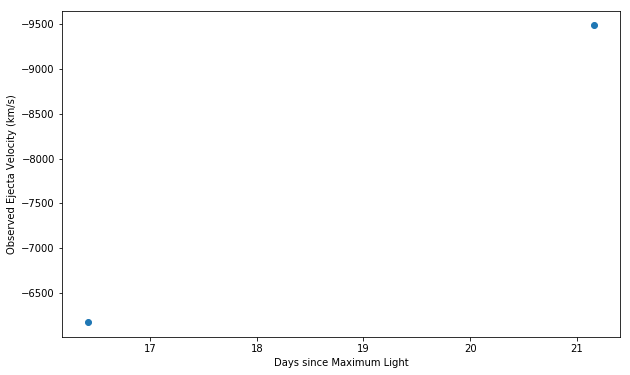

2006py


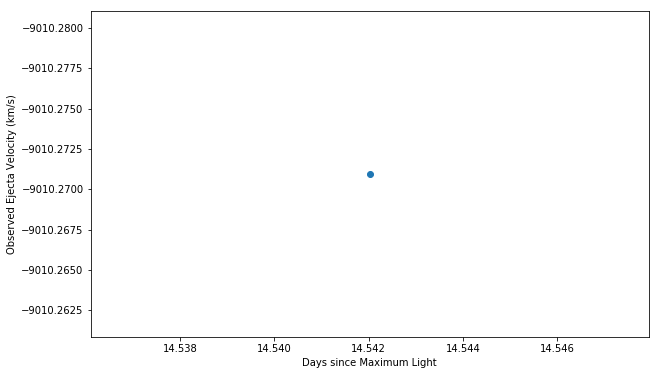

2006x


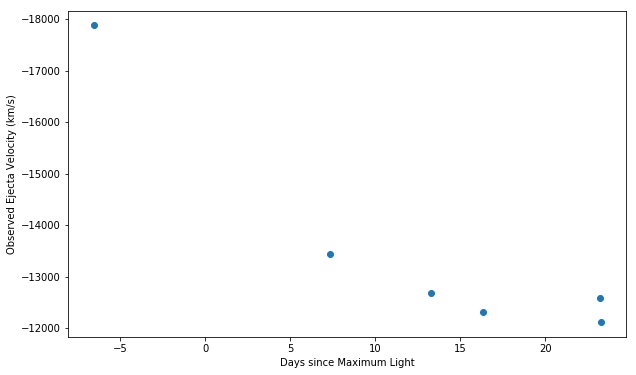

2007af


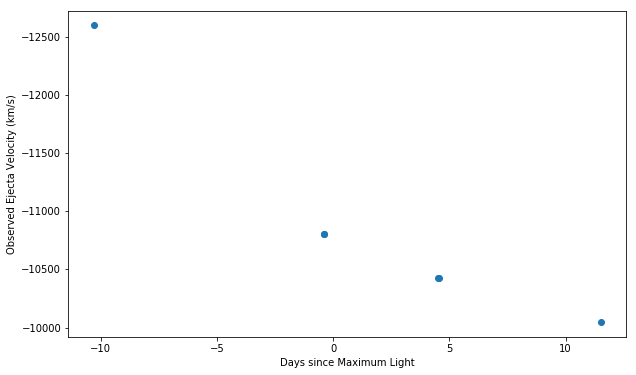

2007ai


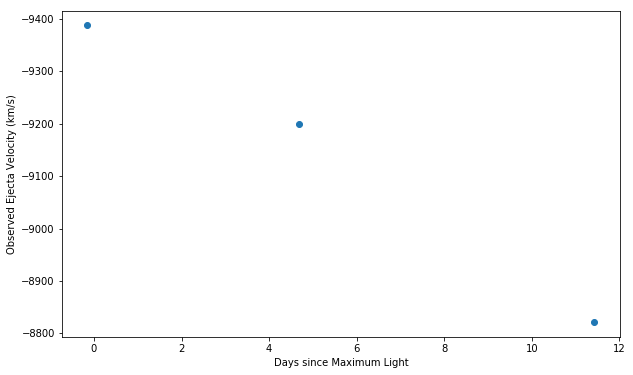

2007al


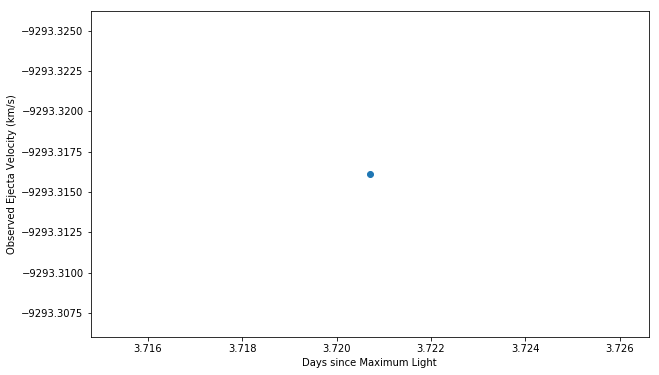

2007as


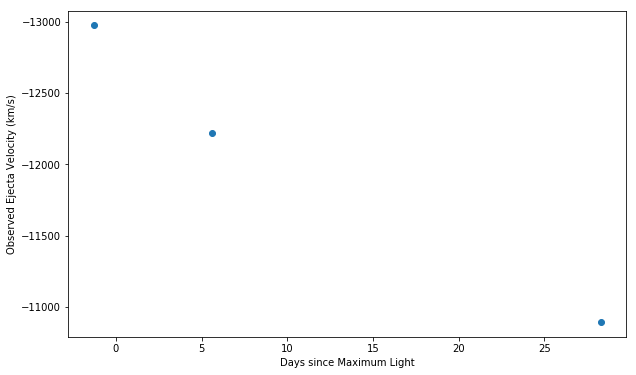

2007ax


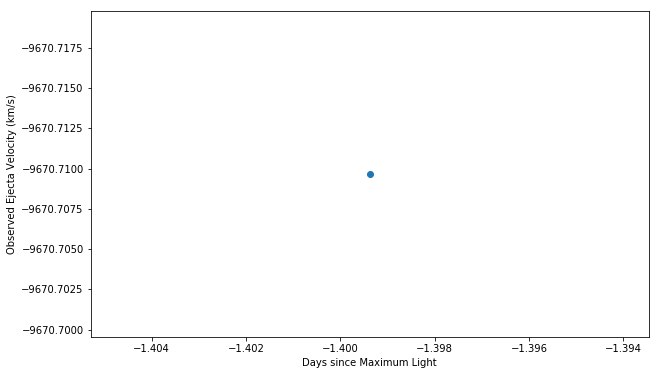

2007a


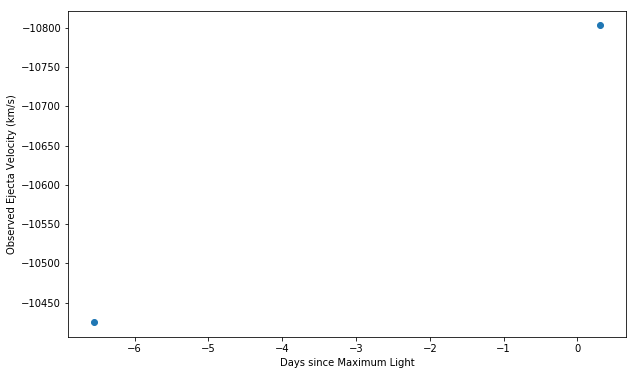

2007ba


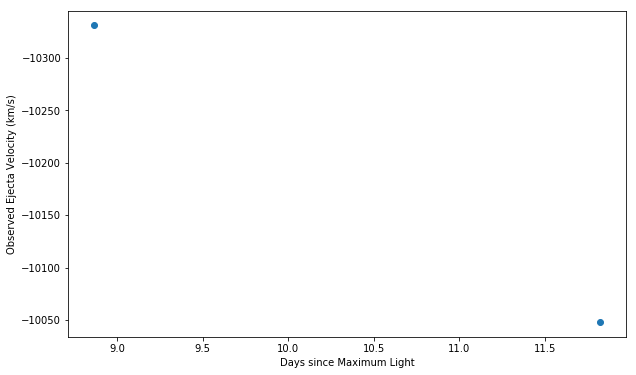

2007bc


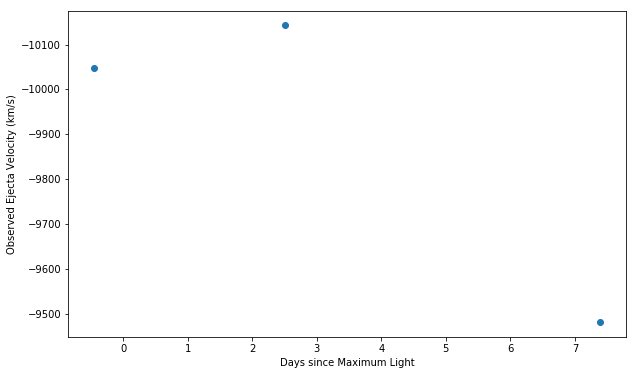

2007bd


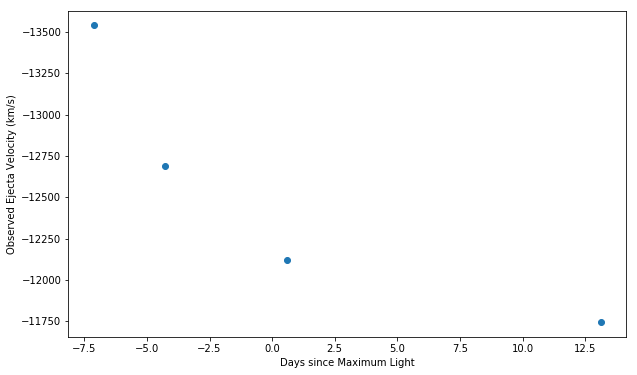

2007bm


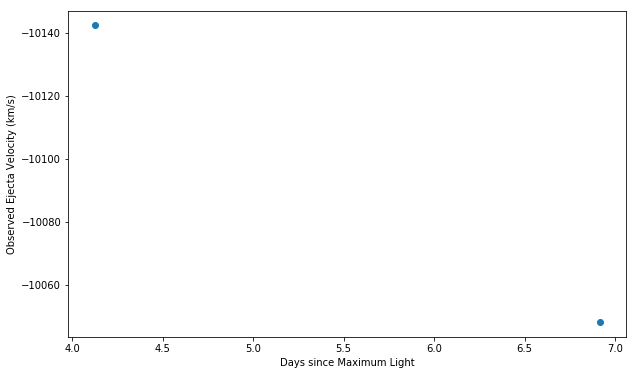

2007ca


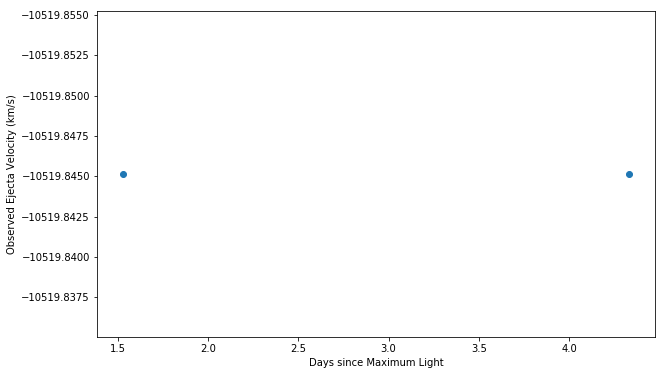

2007jg


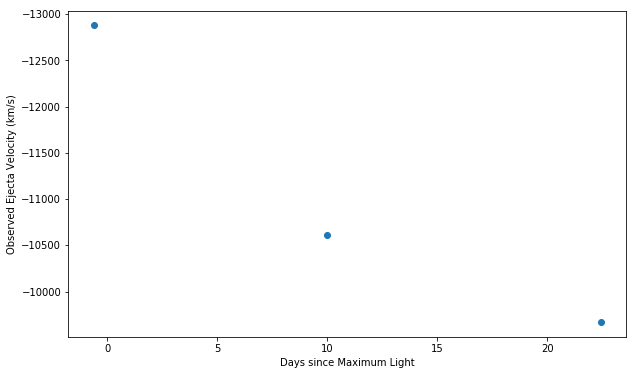

2007le


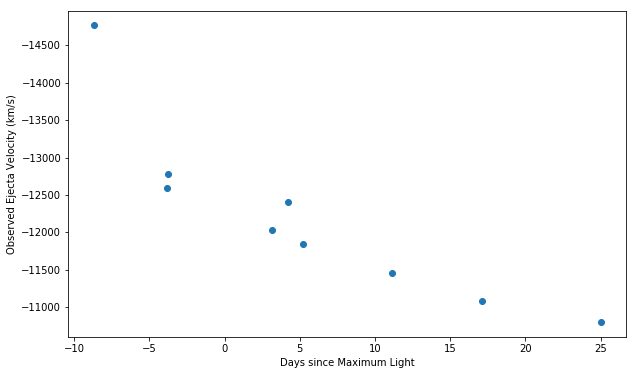

2007nq


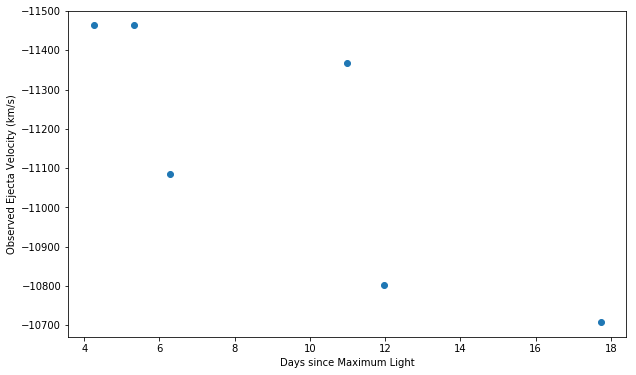

2007n


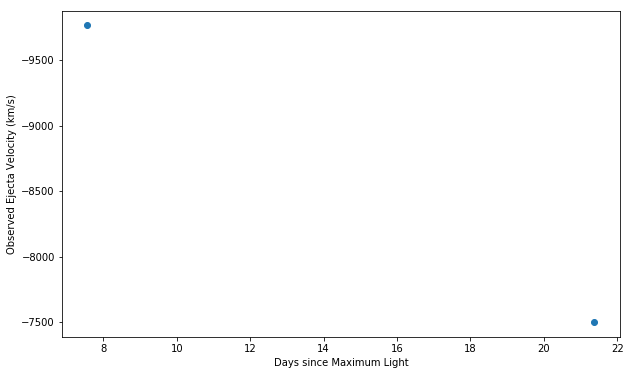

2007on


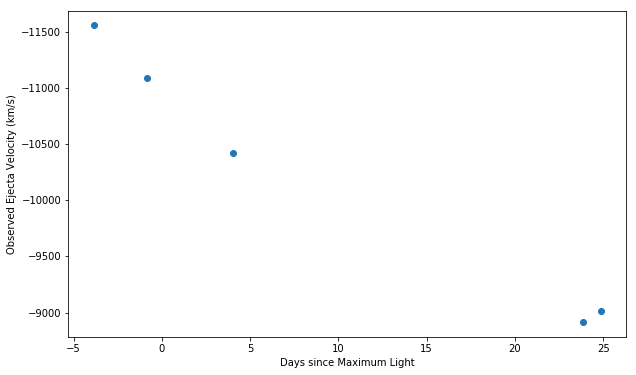

2007sr


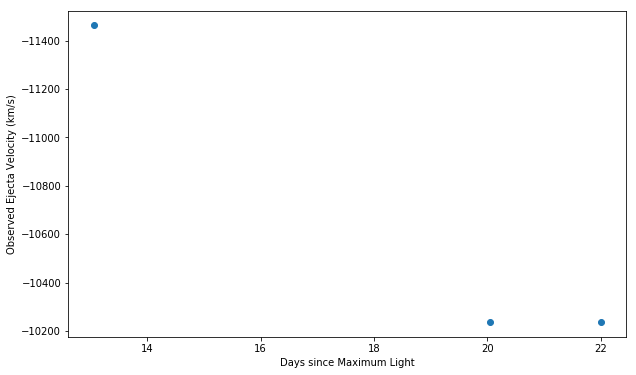

2007s


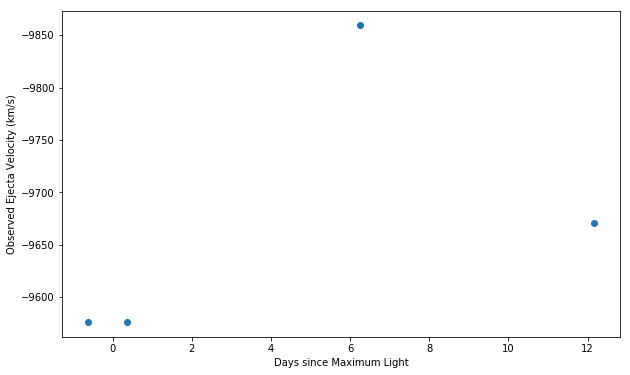

2008bc


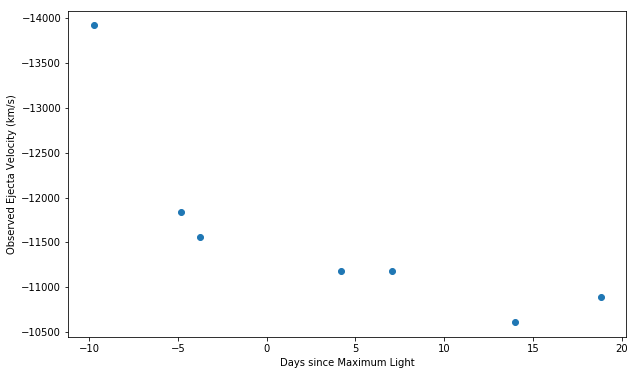

2008bf


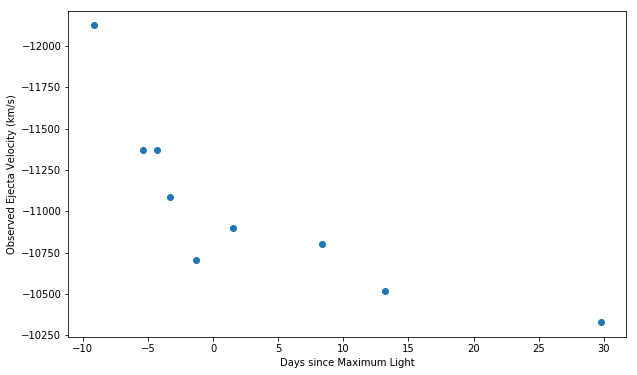

2008bq


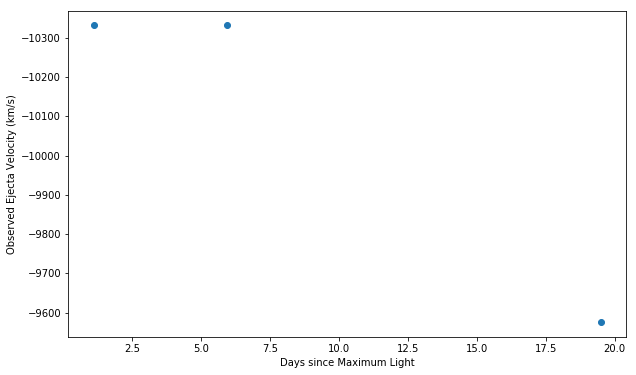

2008c


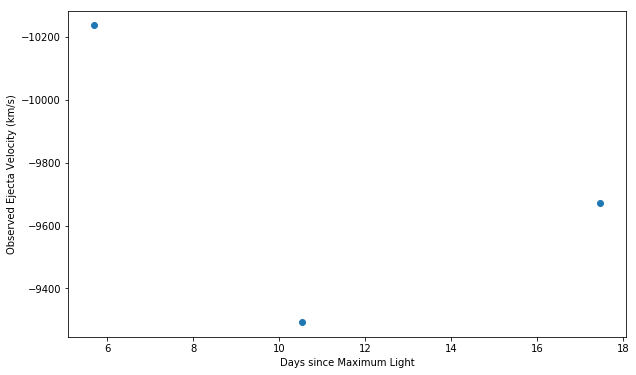

2008fp


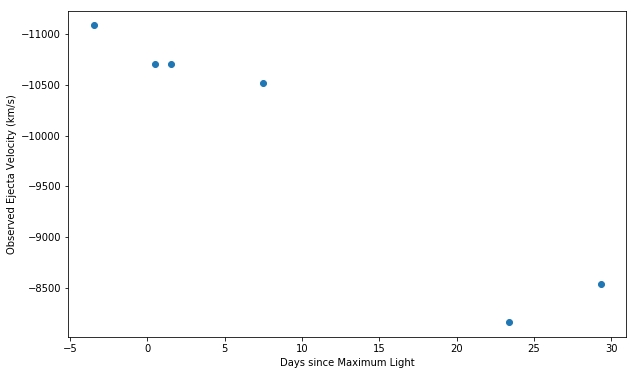

2008gp


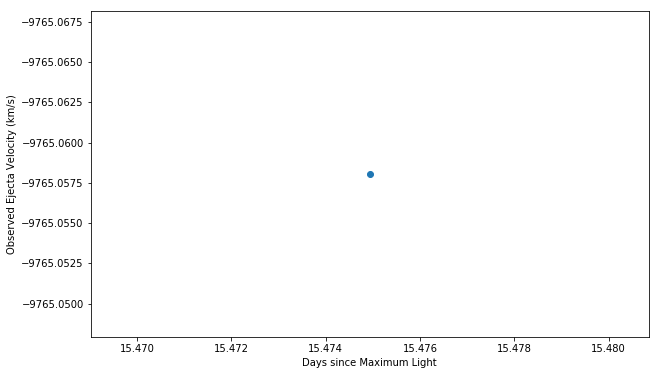

2008hv


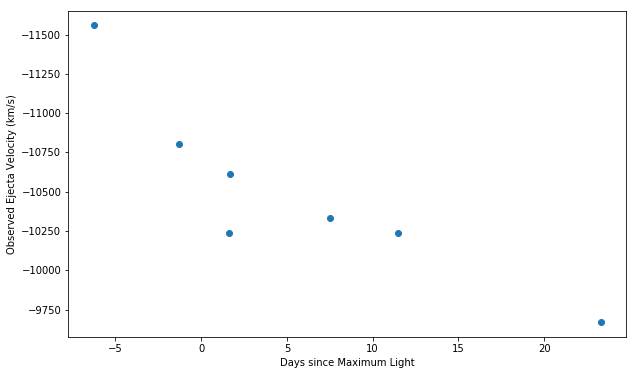

2008r


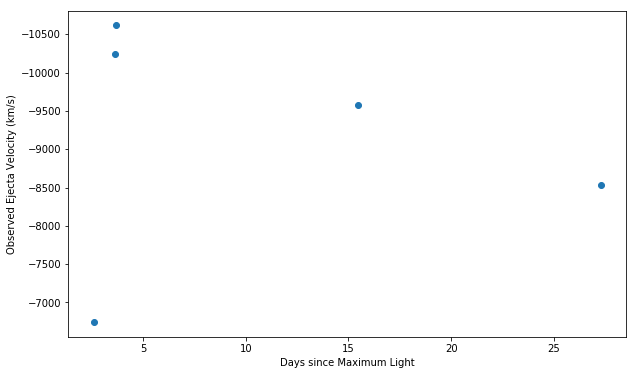

2009f


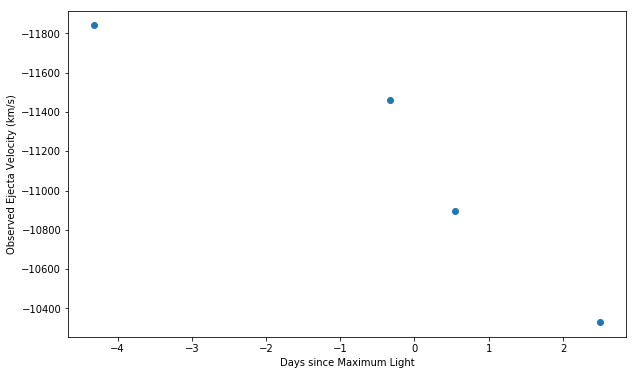

1994d


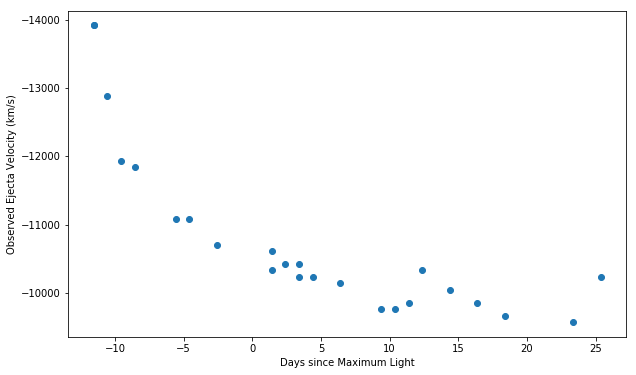

1994q


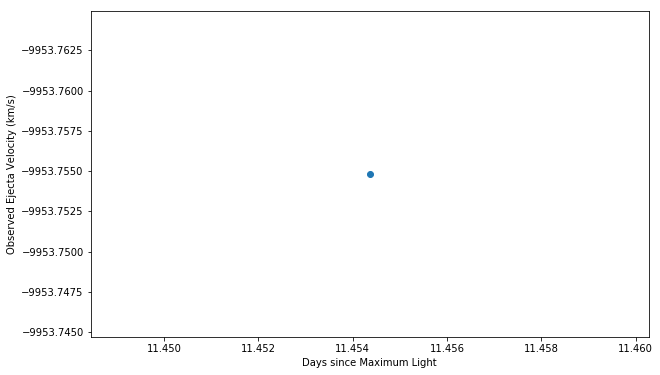

1994s


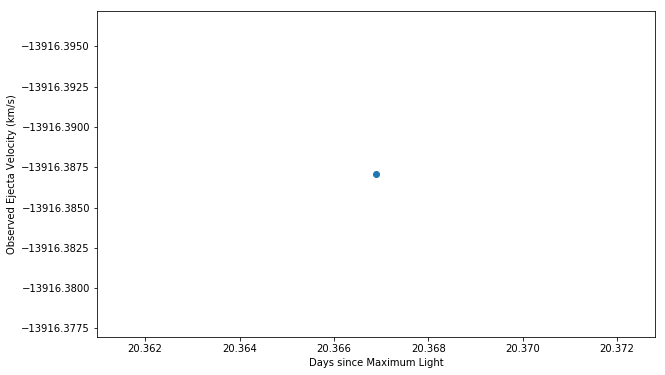

1996x


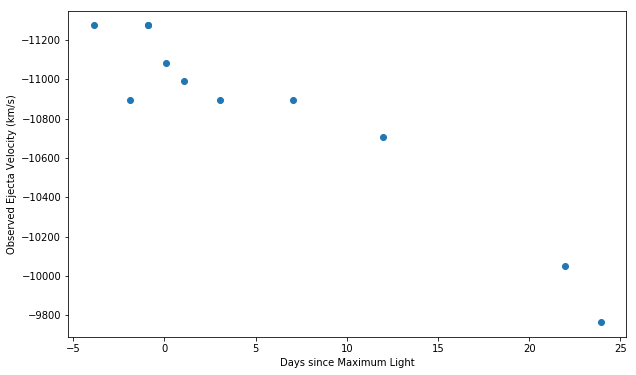

2002bo


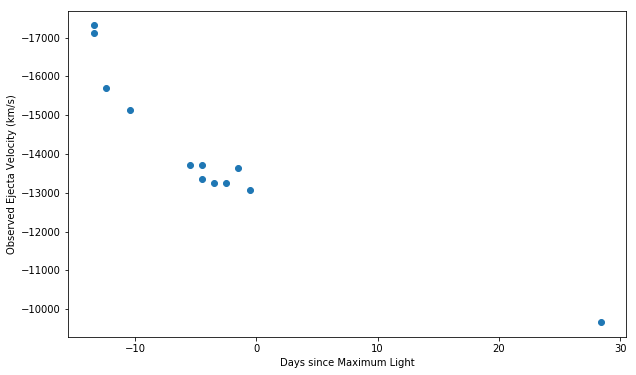

2002dj


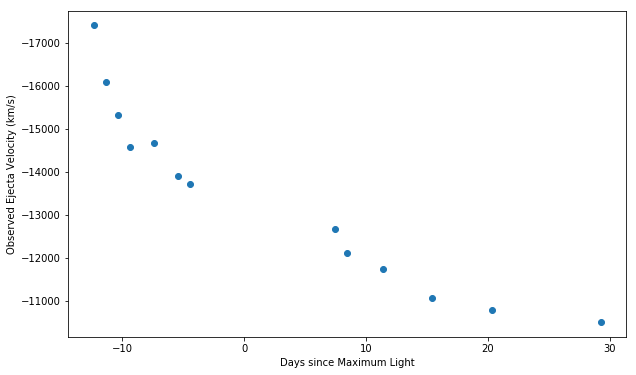

2002er


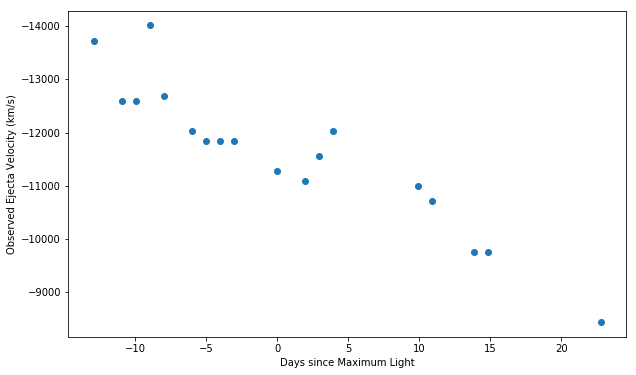

2003cg


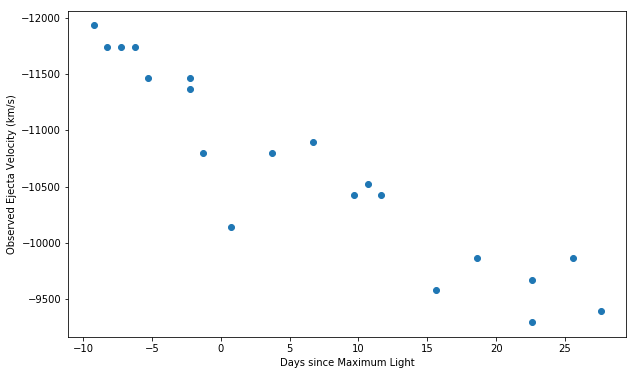

2003du


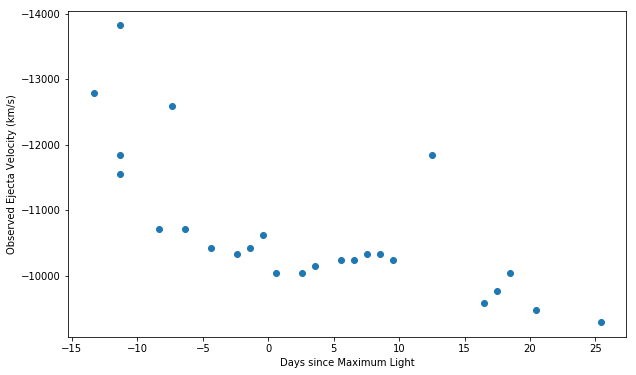

2005cf


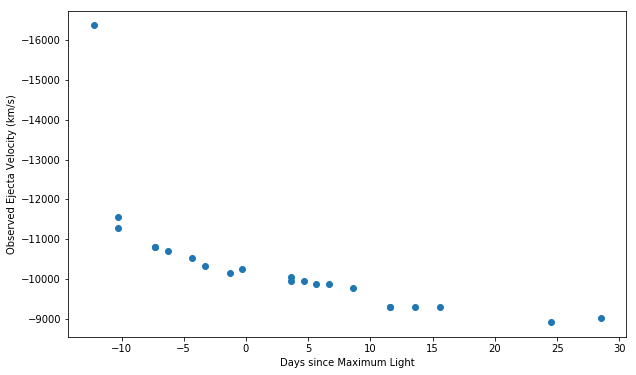

2006x


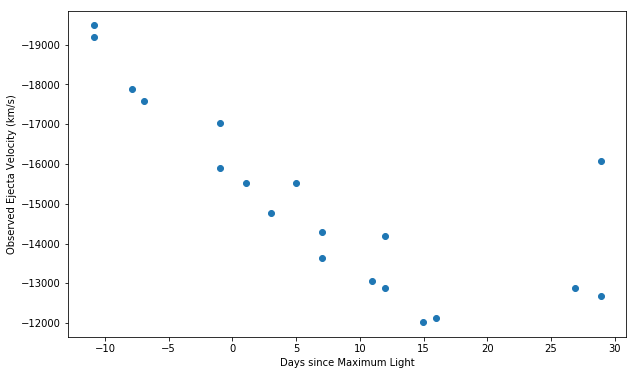

2006d


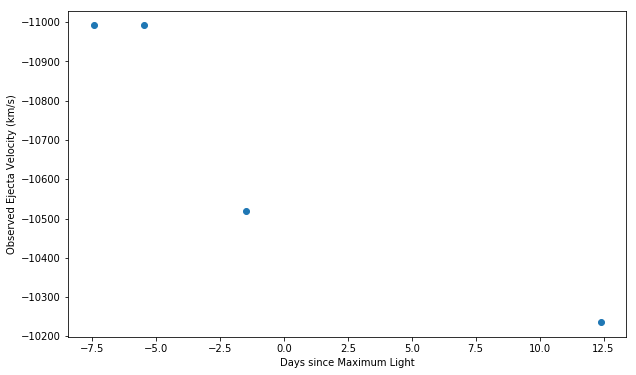

2011fe


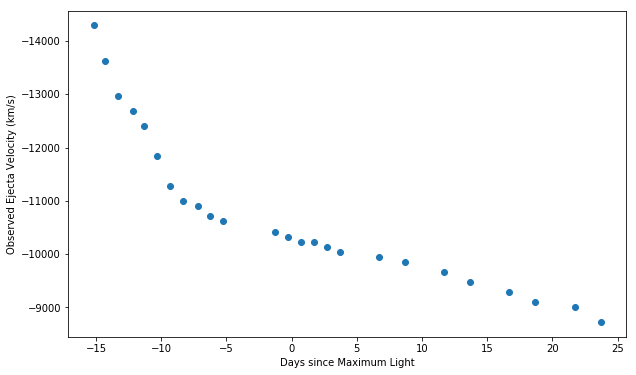

2001el


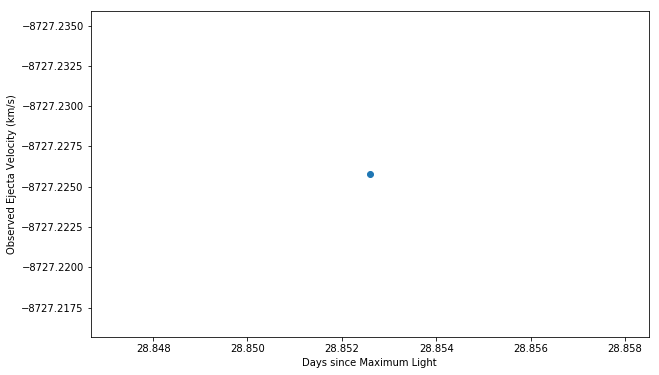

2005cf


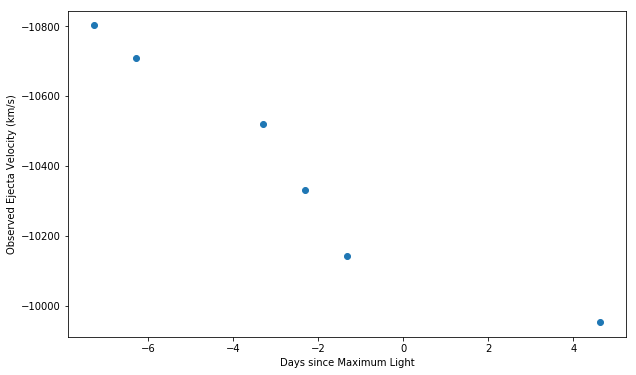

asassn-14lp


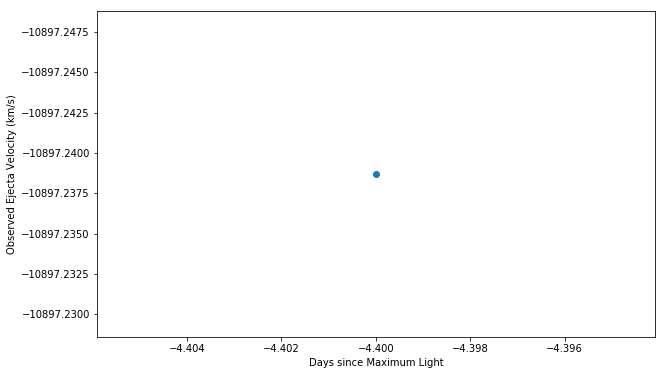

2011by


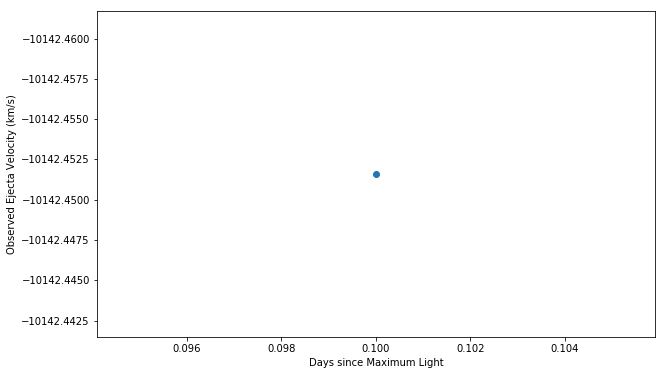

2011fe


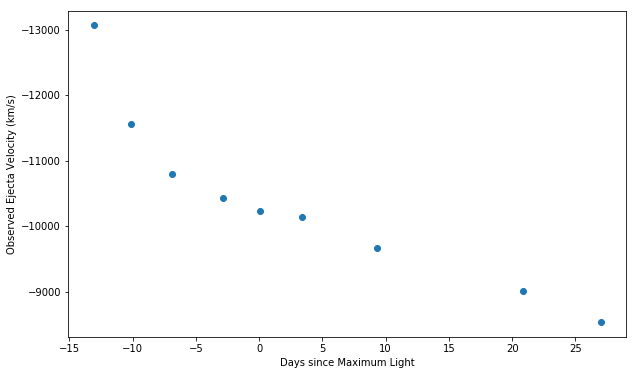

2013dy


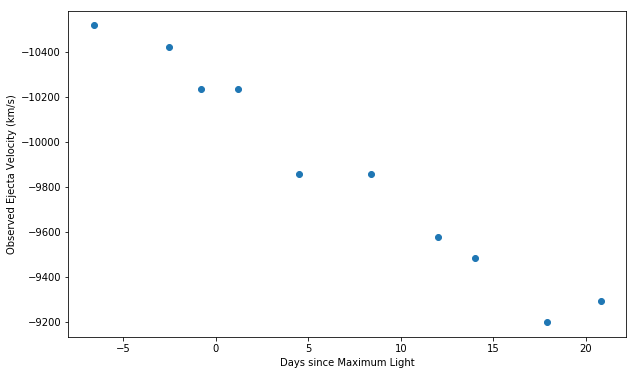

In [28]:
for specimen in v_evo_data:
    print specimen.name
    v_phase = []
    v_obs = []
    
    for spectrum in specimen.objects:
        wavelength = spectrum.wavelength[spectrum.x1:spectrum.x2]
        sm_flux = autosmooth(wavelength, spectrum.flux[spectrum.x1:spectrum.x2], 1 / spectrum.ivar[spectrum.x1:spectrum.x2])
        min_wave = find_min_wave(wavelength, sm_flux)
        v = si_velocity(min_wave)
        
        v_phase.append(spectrum.phase)
        v_obs.append(v)
        
    x = v_phase
    y = v_obs
    plt.figure(figsize=(10,6))
    plt.xlabel("Days since Maximum Light")
    plt.ylabel("Observed Ejecta Velocity (km/s)")
    ax = plt.gca()
    ax.invert_yaxis()
    ax.ticklabel_format(useOffset=False)
    #ax.set_ylim(-6000, -25000)
    plt.scatter(x, y)
    plt.show()

V_0 for every Supernova

In [29]:
v_0_names = []
v_0_values = []
v_0_spectra = []

for specimen in v_evo_data:
    phases = []
    for spectrum in specimen.objects:
        phases.append(spectrum.phase)
    index = np.argmin(np.abs(phases))
    
    spectrum_0 = specimen.objects[index]
    phase = spectrum_0.phase
    wavelength = spectrum_0.wavelength[spectrum_0.x1:spectrum_0.x2]
    sm_flux = autosmooth(wavelength, spectrum_0.flux[spectrum_0.x1:spectrum_0.x2], 1 / spectrum_0.ivar[spectrum_0.x1:spectrum_0.x2])
    min_wave = find_min_wave(wavelength, sm_flux)
    v_obs = si_velocity(min_wave)
    v_0 = (v_obs + .285*phase) / (1 - .0322*phase)
    
    if v_0 < -5000 and v_0 > -30000:
        v_0_names.append(spectrum_0.name)
        v_0_values.append(v_0)
        v_0_spectra.append(spectrum_0.filename)

(array([  1.,   3.,   2.,   1.,   1.,   7.,   4.,   6.,  14.,  12.,  17.,
         22.,  38.,  45.,  95., 131.,  65.,  13.,   4.,   2.]),
 array([-29698.69999309, -28477.82961691, -27256.95924074, -26036.08886456,
        -24815.21848838, -23594.3481122 , -22373.47773602, -21152.60735984,
        -19931.73698366, -18710.86660748, -17489.9962313 , -16269.12585513,
        -15048.25547895, -13827.38510277, -12606.51472659, -11385.64435041,
        -10164.77397423,  -8943.90359805,  -7723.03322187,  -6502.1628457 ,
         -5281.29246952]),
 <a list of 20 Patch objects>)

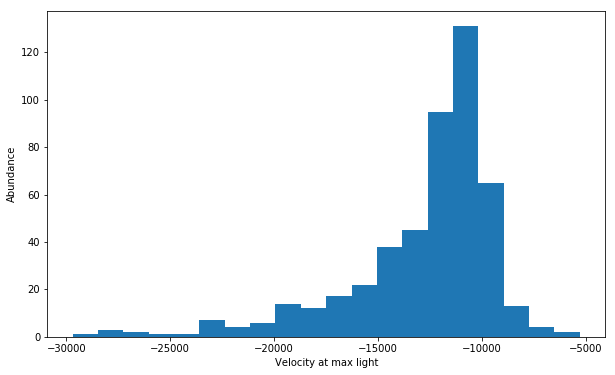

In [32]:
plt.figure(figsize=(10,6))
plt.xlabel("Velocity at max light")
plt.ylabel("Abundance")
plt.hist(v_0_values, bins=20)

In [31]:
si_v0_file = open("new_data\si_v0.txt", "w")
for n in range(0, len(v_0_names)):
    si_v0_file.write(v_0_names[n] + " " + str(v_0_values[n]) + "\n")
si_v0_file.close()

# All Observed Silicon Velocities

In [28]:
v_obs_names = []
v_obs_data = []
v_obs_error_data = []
i=0

for spectrum in v_evo_spectra:
    
    wavelength = spectrum.wavelength[spectrum.x1:spectrum.x2]
    flux = spectrum.flux[spectrum.x1:spectrum.x2]
    sm_flux = autosmooth(wavelength, spectrum.flux[spectrum.x1:spectrum.x2], 1 / spectrum.ivar[spectrum.x1:spectrum.x2])
    flux_error = 1/spectrum.ivar[spectrum.x1:spectrum.x2] ** .5
    min_wave = find_min_wave(wavelength, sm_flux)
    
    v_obs = si_velocity(min_wave)
    #v_obs_error = si_velocity_error(wavelength, flux, flux_error)
    
    v_obs_names.append(spectrum.name)
    v_obs_data.append(v_obs)
    #v_obs_error_data.append(v_obs_error)
    
    if i == int(0.1 * (len(v_evo_spectra))):
        print ("10% complete")
    elif i == int(0.25 * (len(v_evo_spectra))):
        print ("25% complete")
    elif i == int(0.5 * (len(v_evo_spectra))):
        print ("50% complete")
    elif i == int(0.75 * (len(v_evo_spectra))):
        print ("75% complete")
    elif i == int((len(v_evo_spectra))):
        print ("100% complete")
    
    #i = i+1
    print i
print v_obs_data#, v_obs_error_data

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [29]:
v_obs_filenames = []
for spectrum in v_evo_spectra:
    v_obs_filenames.append(spectrum.filename)
print len(v_obs_filenames)
print len(v_obs_data)

2288
2288


In [32]:
si_v_file = open("new_data\si_v.txt", "w")
for n in range(0, len(v_obs_filenames)):
    si_v_file.write(v_obs_filenames[n] + " " + str(v_obs_data[n]) + "\n")
si_v_file.close()

In [30]:
v_obs_dict = {}
for n in range(0, len(v_obs_data)):
    v_obs_dict[v_obs_filenames[n]] = v_obs_data[n]

In [36]:
print v_obs_dict

{u'SN08fp_080928_b01_DUP_WF.dat': -10519.845161290323, u'sn2000fa-20001215.36-fast.flm': -11368.98064516129, u'sn2003fa-20030625.30-fast.flm': -9765.05806451613, u'sn1999gh-19991217-o.flm': -10048.103225806452, u'sn2003cg-20030408.17-fast.flm': -11085.935483870968, u'sn2002bo-20020310.26-fast.flm': -17218.58064516129, u'sn2002hw-20021212-ui.flm': -9670.709677419354, u'sn2011fe-visit5-hst.flm': -10236.8, u'sn1999gd-19991205-uvoir.flm': -10614.193548387097, u'sn2002bo-20020322.17-fast.flm': -12972.90322580645, u'sn1999aa-19990310.23-fast.flm': -10048.103225806452, u'sn1994D-19940317.35-fast.flm': -10802.890322580644, u'sn2000cn-20000709.24-fast.flm': -9293.316129032259, u'sn2007if-20070915.46-fast.flm': -9293.316129032259, u'sn2002cd-20020420-ui-corrected.flm': -14576.825806451612, u'sn2007S-20070209.30-fast.flm': -9953.754838709678, u'sn1998V-19980320.50-fast.flm': -10708.54193548387, u'sn1998eg-19981113.19-fast.flm': -8727.225806451614, u'sn2001fh-20011115.09-fast.flm': -10708.54193548

In [44]:
anc.add_arbitrary_spectra_column('v_obs', v_obs_dict, 'float', "../data/kaepora_v1.db")

type

# Equivalent Width

In [39]:
ew_query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -5 and phase <= 20 and minwave <= 5600 and maxwave >= 6500 and source != 'swift_uv'"
ew_spectra = composite.grab(ew_query, multi_epoch = True, make_corr = True, selection = "max_coverage")

2011 Total Spectra found
79 flagged spectra removed 1932 spectra left
40 spectra of peculiar Ias removed 1892 spectra left
1583 spectra of SNe that have host reddening corrections
Arrays cleaned


In [47]:
si_ew_names = []
si_ew_data = []
si_ew_error_data = []

for spectrum in ew_spectra:
    wavelength = spectrum.wavelength[spectrum.x1:spectrum.x2]
    flux = spectrum.flux[spectrum.x1:spectrum.x2]
    sm_flux = autosmooth(wavelength, spectrum.flux[spectrum.x1:spectrum.x2], 1 / spectrum.ivar[spectrum.x1:spectrum.x2])
    flux_error = 1/spectrum.ivar[spectrum.x1:spectrum.x2] ** .5
    
    si_ew = eq_width(wavelength, sm_flux)
    si_ew_error = si_eq_width_error(wavelength, flux, flux_error, 50)
    
    si_ew_names.append(spectrum.name)
    si_ew_data.append(si_ew)
    si_ew_error_data.append(si_ew_error)
    
    if si_ew > 300 or si_ew < 50:
        plt.figure(figsize=(10,4))
        plt.xlabel(str(spectrum.phase) + "---" + spectrum.filename)
        plt.plot(wavelength, sm_flux)

KeyboardInterrupt: 

In [50]:
ew0_eventnames, ew0_objects = eventsort(ew_spectra)

In [51]:
class ew0_species:
    def __init__(self, name, objects):
        self.name = name
        self.objects = objects

ew0_data = []
for n in range(0, len(ew0_eventnames)):
    ew0_specimen = ew0_species(ew0_eventnames[n], ew0_objects[n])
    ew0_data.append(ew0_specimen)

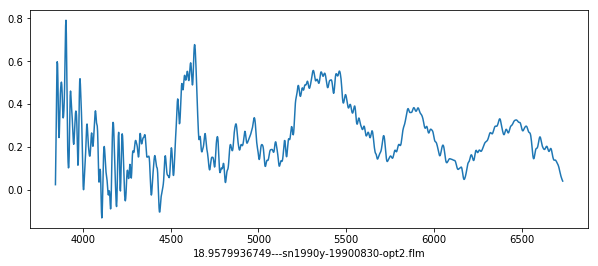

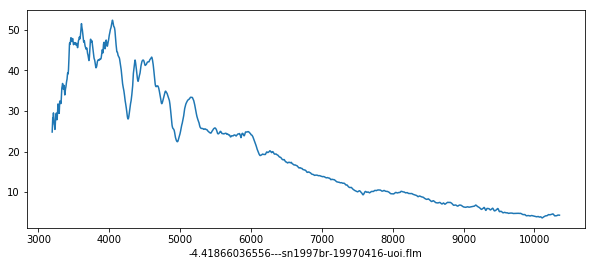

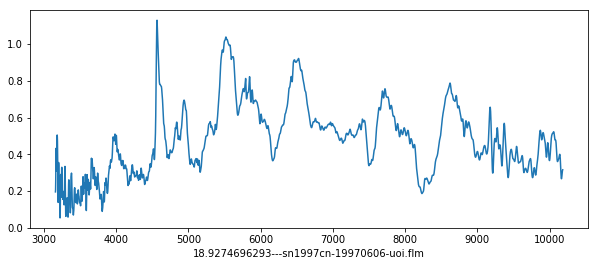

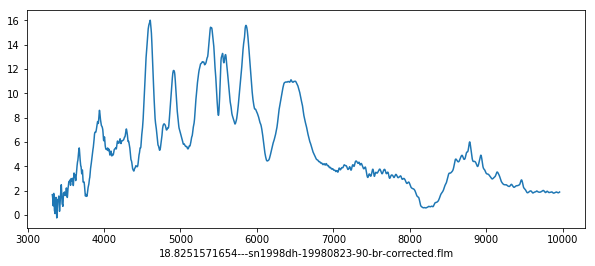

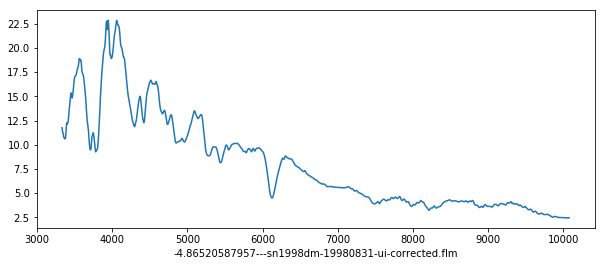

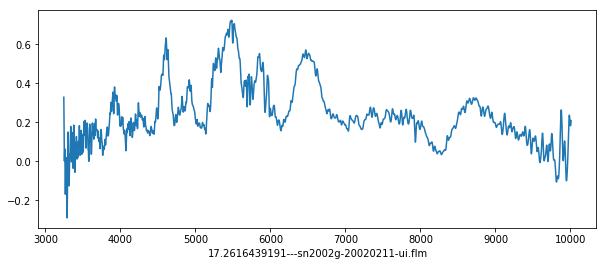

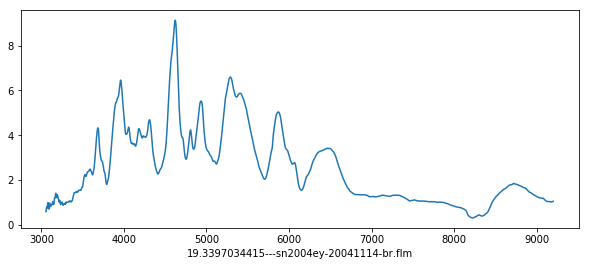

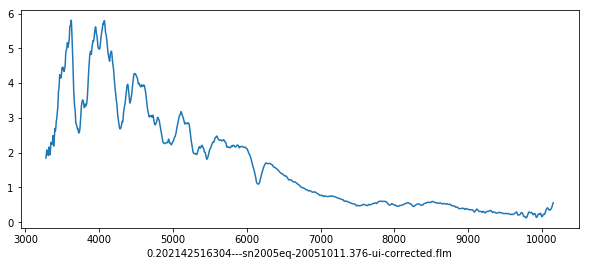

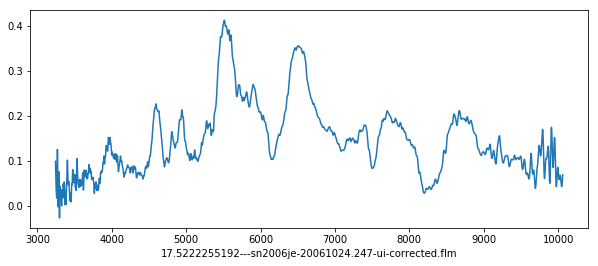

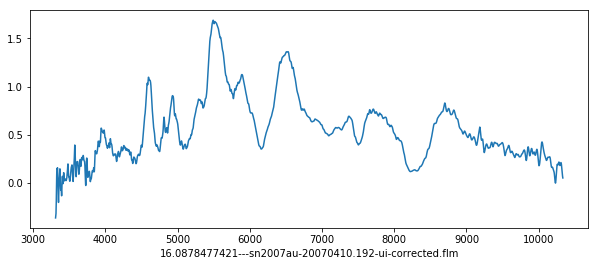

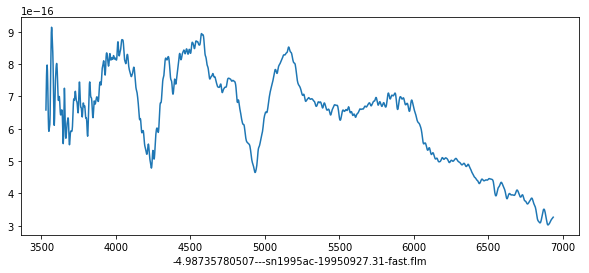

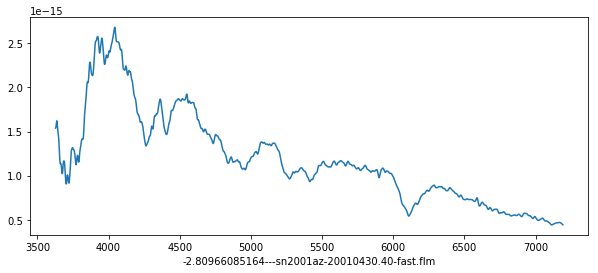

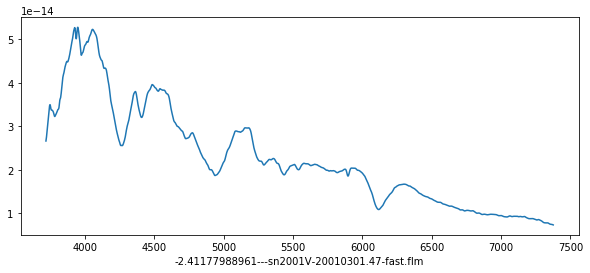

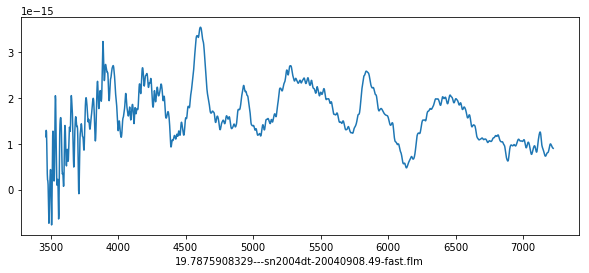

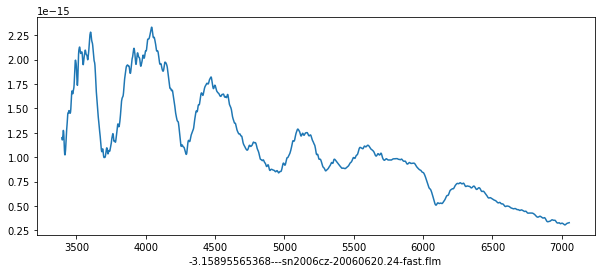

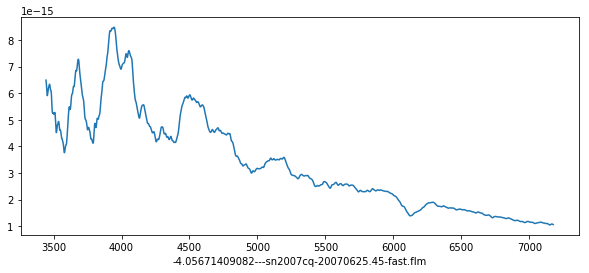

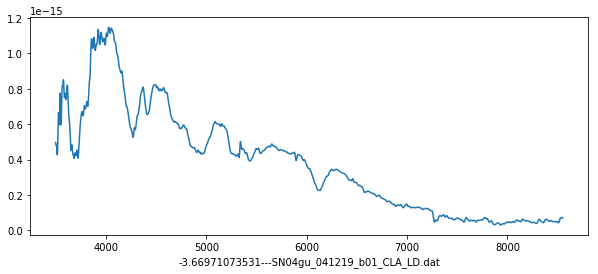

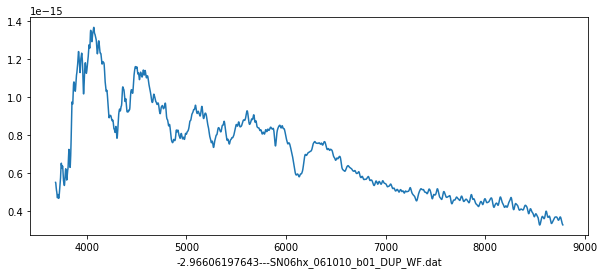

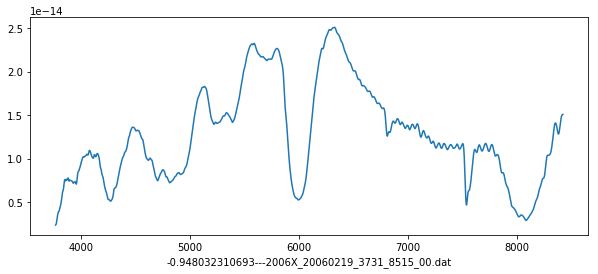

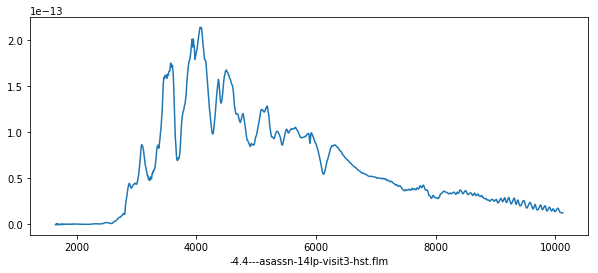

In [59]:
ew0_names = []
ew0_values = []
ew0_spectra = []

for specimen in ew0_data:
    phases = []
    for spectrum in specimen.objects:
        phases.append(spectrum.phase)
    index = np.argmin(np.abs(phases))
    
    spectrum_0 = specimen.objects[index]
    phase = spectrum_0.phase
    wavelength = spectrum_0.wavelength[spectrum_0.x1:spectrum_0.x2]
    sm_flux = autosmooth(wavelength, spectrum_0.flux[spectrum_0.x1:spectrum_0.x2], 1 / spectrum_0.ivar[spectrum_0.x1:spectrum_0.x2] ** 2)
    ew_obs = eq_width(wavelength, sm_flux)
    
    ew0 = eq_width_0(ew_obs, phase)
    
    ew0_names.append(spectrum_0.name)
    ew0_values.append(ew0)
    ew0_spectra.append(spectrum_0.filename)
    
    #print ew0
    
    if ew0 > 600 or ew0 < 50:
        plt.figure(figsize=(10,4))
        plt.xlabel(str(phase) + "---" + spectrum_0.filename)
        plt.plot(wavelength, sm_flux)
        plt.show()

# Si Equivalent Width File

In [26]:
ew_query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -5 and phase <= 20 and minwave <= 5000 and maxwave >= 6500"
ew_Array = composite.grab(ew_query, multi_epoch = True, make_corr = True, selection = "max_coverage")

2044 Total Spectra found
81 flagged spectra removed 1963 spectra left
40 spectra of peculiar Ias removed 1923 spectra left
1586 spectra of SNe that have host reddening corrections
Arrays cleaned


sn2002hd-20021109-joined.flm
sn2002he-20021106.649-joined.flm
sn1995ac-19950927.31-fast.flm
sn1996bl-19961108.24-fast.flm
sn1996bo-19961107.15-fast.flm
sn1997cn-19970602.36-fast.flm
sn1997cn-19970603.23-fast.flm
sn1997cn-19970607.18-fast.flm
sn2000fa-20001218.38-fast.flm
sn2000fa-20001225.42-fast.flm
sn2001cp-20010623.44-fast.flm
sn2001V-20010318.47-fast.flm
sn2002cd-20020504.47-fast.flm
sn2002fb-20020907.51-fast.flm
sn2002fb-20020929.42-fast.flm
sn2002hw-20021112.10-fast.flm
sn2002hw-20021114.10-fast.flm
sn2002kf-20030113.31-fast.flm
sn2003hu-20030928.12-fast.flm
sn2004dt-20040908.49-fast.flm
sn2004ef-20040922.22-fast.flm
sn2004ef-20041006.17-fast.flm
sn2005hc-20051031.29-fast.flm
sn2005mz-20060123.15-fast.flm
sn2006ac-20060226.34-fast.flm
sn2006bq-20060427.35-fast.flm
sn2006cf-20060521.27-fast.flm
sn2006cf-20060522.26-fast.flm
sn2006cj-20060523.33-fast.flm
sn2006cj-20060601.28-fast.flm
sn2006cq-20060531.27-fast.flm
sn2006le-20061121.37-fast.flm
sn2007F-20070121.55-fast.flm
sn2007if-2

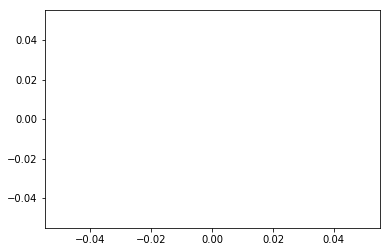

In [28]:
eq_width_values = []
eq_width_filenames = []

for object in ew_Array:
    try:
        wavelength = object.wavelength[object.x1:object.x2]
        flux = object.flux[object.x1:object.x2]
        flux_error = (1/object.ivar[object.x1:object.x2]) ** .5
        sm_flux = autosmooth(wavelength, flux, flux_error)

        #min_wave = find_min_wave(wavelength, sm_flux)
        ew = eq_width(wavelength, sm_flux)

        eq_width_values.append(ew)
        eq_width_filenames.append(object.filename)
    
    except:
        print object.filename
        plt.plot(wavelength,sm_flux)
        pass

In [30]:
si_eqw_file = open("new_data\si_eqw.txt", "w")
for n in range(0, len(eq_width_values)):
    si_eqw_file.write(eq_width_filenames[n] + " " + str(eq_width_values[n]) + "\n")
si_eqw_file.close()